# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)
range_values = max(org_values) - min(org_values)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 0.05 * range_values
print("The noise is:", noise)
values = org_values + np.random.normal(0, noise, org_values.shape)

The noise is: 24.898095903089327


Using matplotlib, I look at the noisy time series I just simulated:

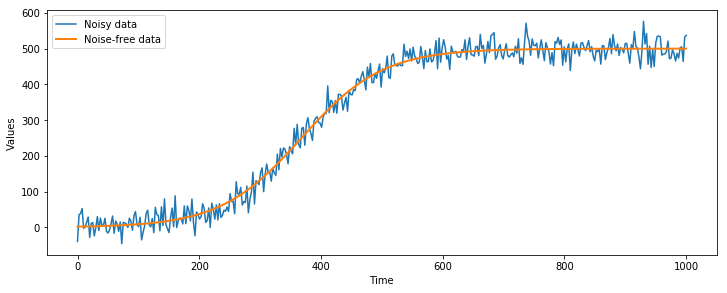

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

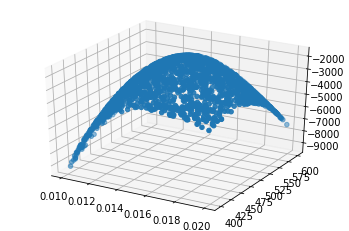

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(problem, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=4, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=500, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
emu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 16,833
Trainable params: 16,833
Non-trainable params: 0
_________________________________________________________________


In [15]:
emu([0.015, 500])

array([[-1846.313]], dtype=float32)

In [16]:
log_likelihood([0.015, 500])

-1853.4065834143667

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error', 'rescaled_mae', 'rescaled_mse', 'val_rescaled_mae', 'val_rescaled_mse'])


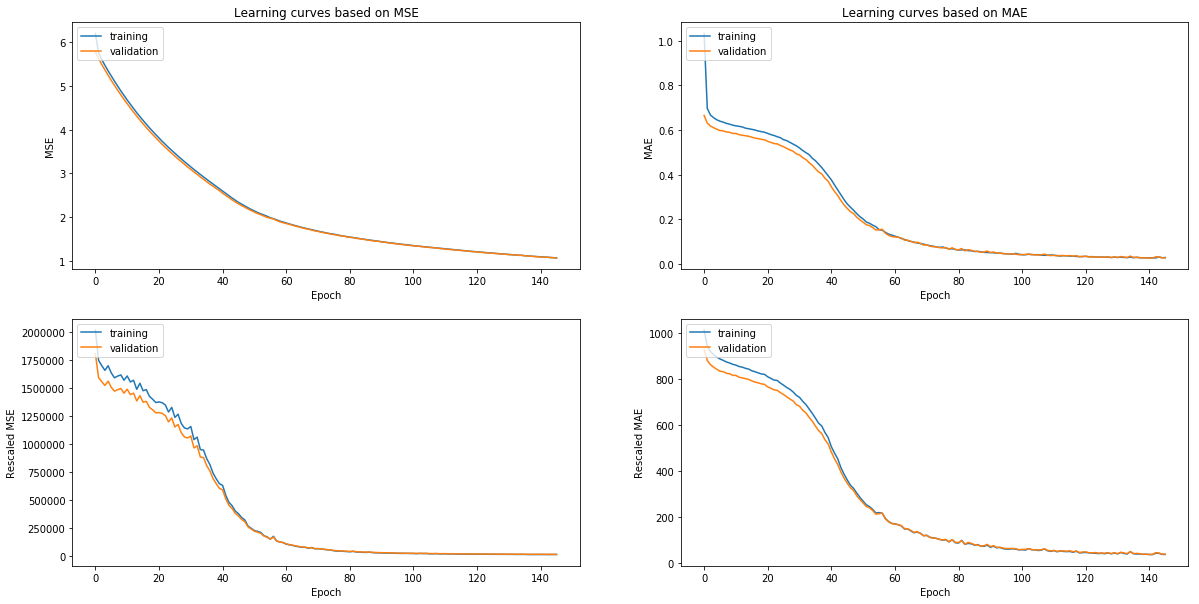

In [17]:
# summarize history for loss
print(hist.history.keys())
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))                 
ax1.title.set_text('Learning curves based on MSE')
ax2.title.set_text('Learning curves based on MAE')

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_ylabel('MSE')
ax1.set_xlabel('Epoch')
ax1.legend(['training', 'validation'], loc='upper left')

ax2.plot(hist.history['mean_absolute_error'])
ax2.plot(hist.history['val_mean_absolute_error'])
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend(['training', 'validation'], loc='upper left')

ax3.plot(hist.history['rescaled_mse'])
ax3.plot(hist.history['val_rescaled_mse'])
ax3.set_ylabel('Rescaled MSE')
ax3.set_xlabel('Epoch')
ax3.legend(['training', 'validation'], loc='upper left')

ax4.plot(hist.history['rescaled_mae'])
ax4.plot(hist.history['val_rescaled_mae'])
ax4.set_ylabel('Rescaled MAE')
ax4.set_xlabel('Epoch')
ax4.legend(['training', 'validation'], loc='upper left')

plt.show()

In [18]:
val_mse = hist.history["val_loss"]
print("Minimum MSE during validation:", min(val_mse))
idx_mse = list(val_mse).index(min(val_mse))
print("Best epoch based on validation MSE:", idx_mse)
print("\n")

rescaled_val_mse = hist.history["val_rescaled_mse"]
print("Minimum rescaled MSE during validation:", min(rescaled_val_mse))
idx_res_mse = list(rescaled_val_mse).index(min(rescaled_val_mse))
print("Best epoch based on rescaled validation MSE:", idx_res_mse)
print("\n")

val_mae = hist.history["val_mean_absolute_error"]
print("Minimum MAE during validation:", min(val_mae))
idx_mae = list(val_mae).index(min(val_mae))
print("Best epoch based on validation MAE:", idx_mae)
print("\n")

rescaled_val_mae = hist.history["val_rescaled_mae"]
print("Minimum rescaled MAE during validation:", min(rescaled_val_mae))
idx_res_mae = list(rescaled_val_mae).index(min(rescaled_val_mae))
print("Best epoch based on rescaled validation MAE:", idx_res_mae)
print("\n")

print(val_mse[-1])
print(rescaled_val_mse[-1])
print(val_mae[-1])
print(rescaled_val_mae[-1])

Minimum MSE during validation: 1.0700283590952555
Best epoch based on validation MSE: 145


Minimum rescaled MSE during validation: 10023.311267719686
Best epoch based on rescaled validation MSE: 142


Minimum MAE during validation: 0.026129043499628704
Best epoch based on validation MAE: 140


Minimum rescaled MAE during validation: 36.45004136126511
Best epoch based on rescaled validation MAE: 140


1.0700283590952555
10349.64627682197
0.02694683798899253
37.590868203306464


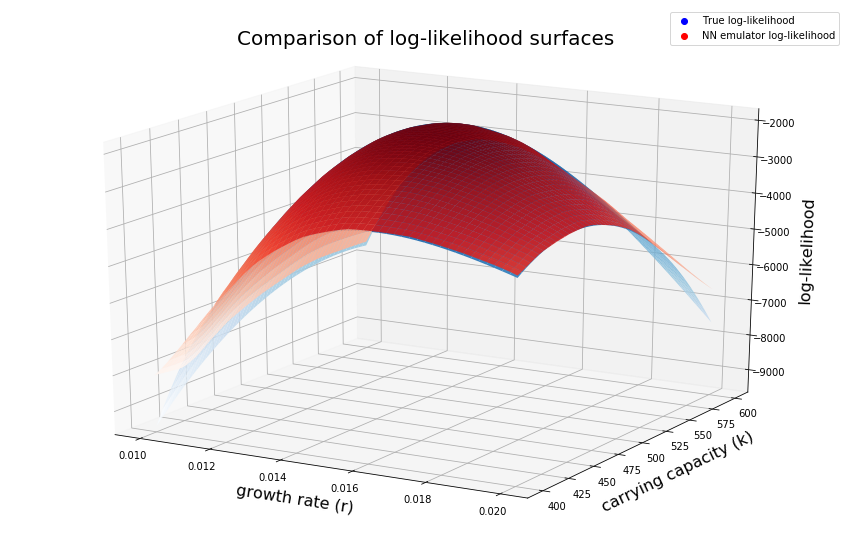

0.008559411027044793

In [19]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D 

test_splits = 50 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
model_prediction = pints.predict_grid(log_likelihood, test_data)
emu_prediction = pints.predict_grid(emu, test_data)

figsize=(20,10)
angle=(20, 300)
alpha=0.9
fontsize=16
labelpad=10

title = "Comparison of log-likelihood surfaces"
x_label = "growth rate (r)"
y_label = "carrying capacity (k)"
z_label = "log-likelihood"


fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.plot_surface(r_grid, k_grid, model_prediction, cmap='Blues', edgecolor='none', alpha=alpha)
ax.plot_surface(r_grid, k_grid, emu_prediction, cmap='Reds', edgecolor='none', alpha=alpha)
#ax.view_init(60, 35)
ax.view_init(*angle)
#ax.set_title('surface')

plt.title(title, fontsize=fontsize*1.25)
ax.set_xlabel(x_label, fontsize=fontsize, labelpad=labelpad)
ax.set_ylabel(y_label, fontsize=fontsize, labelpad=labelpad)
ax.set_zlabel(z_label, fontsize=fontsize, labelpad=labelpad)

fake2Dline1 = mpl.lines.Line2D([0],[0], linestyle="none", c='blue', marker = 'o')
fake2Dline2 = mpl.lines.Line2D([0],[0], linestyle="none", c='red', marker = 'o')
ax.legend([fake2Dline1, fake2Dline2], ["True log-likelihood", "NN emulator log-likelihood"])

plt.show()
mape = np.mean(np.abs((model_prediction - emu_prediction) / model_prediction))
mape

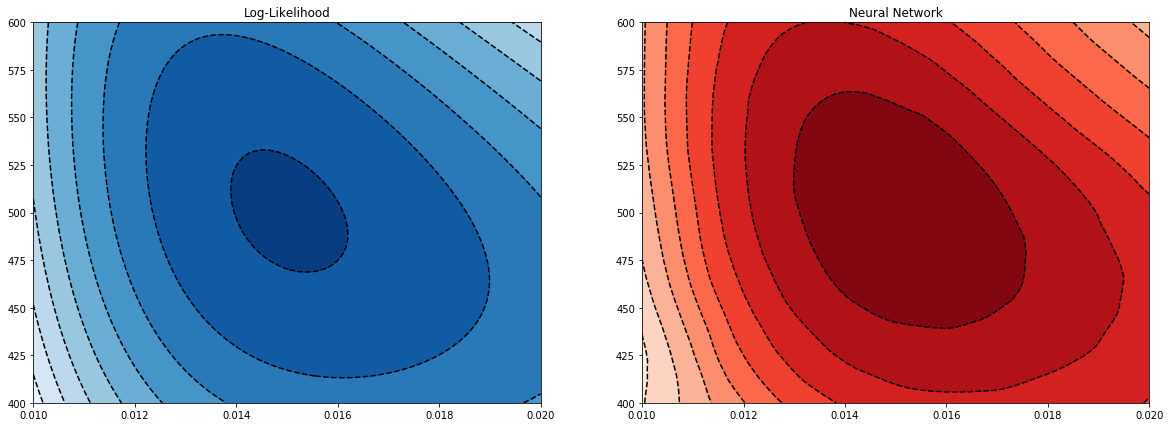

In [20]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

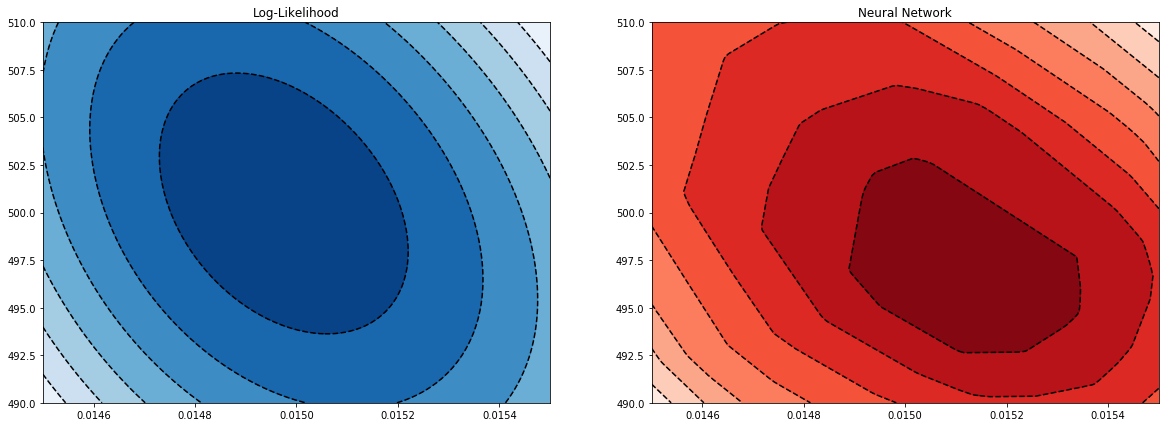

In [21]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.0145, 490], [0.0155, 510], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

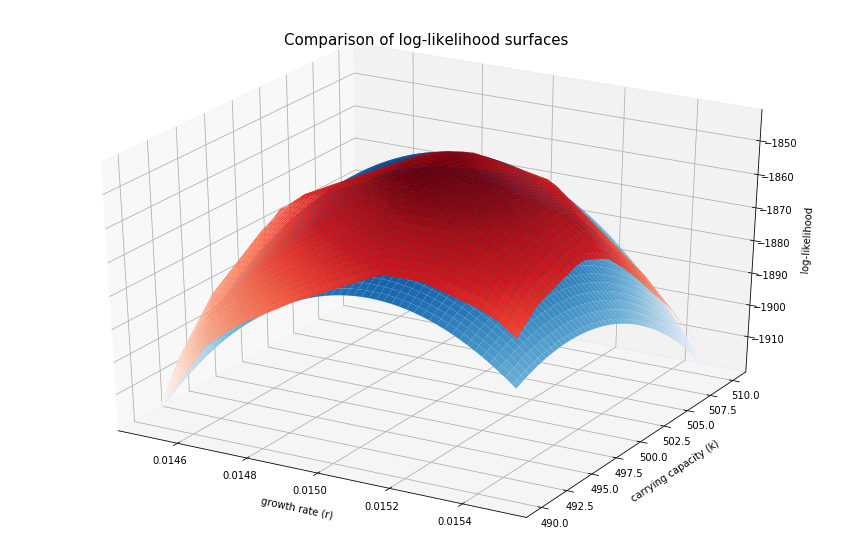

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

figsize=(20,10)
angle=(25, 300)
alpha=1.0
fontsize=10
labelpad=10

title = "Comparison of log-likelihood surfaces"
x_label = "growth rate (r)"
y_label = "carrying capacity (k)"
z_label = "log-likelihood"


fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, ll, cmap='Blues', edgecolor='none', alpha=alpha)
ax.plot_surface(xx, yy, np.array(ll_emu), cmap='Reds', edgecolor='none', alpha=alpha)
#ax.view_init(60, 35)
#ax.view_init(*angle)
#ax.set_title('surface')

plt.title(title, fontsize=fontsize*1.5)
ax.set_xlabel(x_label, fontsize=fontsize, labelpad=labelpad)
ax.set_ylabel(y_label, fontsize=fontsize, labelpad=labelpad)
ax.set_zlabel(z_label, fontsize=fontsize, labelpad=labelpad)
plt.show()

In [23]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

In [24]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]
[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]
[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]
[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+0

 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]

 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]

 [1.66558898e-06 7.79583418e-03]]


[[ 5.58078233e-09 -4.79426503e-05]
 [-4.79426503e-05  9.51947593e-01]]


[[3.85158233e-09 2.09111198e-06]
 [2.09111198e-06 1.11916610e-02]]


[[ 9.54170189e-09 -1.44614594e-06]
 [-1.44614594e-06  1.20861589e-02]]


[[ 5.19312962e-09 -4.75714565e-05]
 [-4.75714565e-05  1.08716359e+00]]


[[4.43093059e-09 4.19833105e-06]
 [4.19833105e-06 1.61379614e-02]]


[[ 1.03100539e-08 -3.83818192e-06]
 [-3.83818192e-06  1.52637082e-02]]


[[ 5.21596743e-09 -5.53538465e-05]
 [-5.53538465e-05  1.30917596e+00]]


[[4.82660009e-09 5.77975101e-06]
 [5.77975101e-06 1.97750361e-02]]


[[ 1.07853385e-08 -5.64955039e-06]
 [-5.64955039e-06  1.75505862e-02]]


[[ 5.22418771e-09 -6.93742795e-05]
 [-6.93742795e-05  2.01625079e+00]]


[[5.07701744e-09 6.93922251e-06]
 [6.93922251e-06 2.23655898e-02]]


[[ 1.16405570e-08 -7.28578544e-06]
 [-7.28578544e-06  1.87344250e-02]]


[[ 4.89892225e-09 -7.71342761e-05]
 [-7.71342761e-05  4.02890917e+00]]


[[4.68793682e-09 6.50506178e-06

[[ 2.82657861e-09 -3.88720577e-05]
 [-3.88720577e-05  4.01075778e+00]]


[[ 1.19347527e-07 -9.12283177e-03]
 [-9.12283177e-03  8.42423908e+02]]


[[ 2.43477590e-07 -8.50427557e-03]
 [-8.50427557e-03  3.85953069e+02]]


[[ 2.71596146e-09 -3.84809484e-05]
 [-3.84809484e-05  3.89575394e+00]]


[[ 1.15748179e-07 -8.75162611e-03]
 [-8.75162611e-03  8.03672612e+02]]


[[ 2.54916521e-07 -9.27533527e-03]
 [-9.27533527e-03  4.27428048e+02]]


[[ 2.60851584e-09 -3.79663980e-05]
 [-3.79663980e-05  3.77904840e+00]]


[[ 1.12124386e-07 -8.39275373e-03]
 [-8.39275373e-03  7.66721443e+02]]


[[ 2.63544550e-07 -9.89351068e-03]
 [-9.89351068e-03  4.61010222e+02]]


[[ 2.50432431e-09 -3.73495610e-05]
 [-3.73495610e-05  3.66150153e+00]]


[[ 1.08498613e-07 -8.04622980e-03]
 [-8.04622980e-03  7.31492562e+02]]


[[ 2.69736566e-07 -1.03784255e-02]
 [-1.03784255e-02  4.87704095e+02]]


[[ 2.40343778e-09 -3.66488707e-05]
 [-3.66488707e-05  3.54384389e+00]]


[[ 1.04889817e-07 -7.71199600e-03]
 [-7.71199600e-0

[[ 1.11392226e-08 -3.35221684e-04]
 [-3.35221684e-04  1.90513194e+01]]


[[ 4.09301777e-09 -5.51208931e-05]
 [-5.51208931e-05  2.25081759e+00]]


[[ 1.55768464e-08 -3.92753886e-04]
 [-3.92753886e-04  2.32562409e+01]]


[[ 1.07651872e-08 -3.21268632e-04]
 [-3.21268632e-04  1.84393199e+01]]


[[ 3.95934038e-09 -5.18663515e-05]
 [-5.18663515e-05  2.26378497e+00]]


[[ 1.50069472e-08 -3.78374787e-04]
 [-3.78374787e-04  2.24116984e+01]]


[[ 1.04033094e-08 -3.07979197e-04]
 [-3.07979197e-04  1.78450544e+01]]


[[ 4.37155271e-09 -5.39093486e-05]
 [-5.39093486e-05  2.20898735e+00]]


[[ 1.44592221e-08 -3.64555855e-04]
 [-3.64555855e-04  2.15995645e+01]]


[[ 1.00532633e-08 -2.95317082e-04]
 [-2.95317082e-04  1.72682373e+01]]


[[ 4.59799642e-09 -4.98651439e-05]
 [-4.98651439e-05  2.13978868e+00]]


[[ 1.39327550e-08 -3.51273897e-04]
 [-3.51273897e-04  2.08185334e+01]]


[[ 9.71472379e-09 -2.83248251e-04]
 [-2.83248251e-04  1.67085619e+01]]


[[ 5.03267920e-09 -6.03879529e-05]
 [-6.03879529e-0

[[ 6.25243165e-09 -6.98712306e-05]
 [-6.98712306e-05  3.58919614e+00]]


[[ 3.95835997e-09 -1.07634029e-04]
 [-1.07634029e-04  5.03410037e+00]]


[[ 5.30361040e-09 -9.35457660e-05]
 [-9.35457660e-05  4.38556328e+00]]


[[ 6.07887107e-09 -6.73827043e-05]
 [-6.73827043e-05  3.48578512e+00]]


[[ 4.40204241e-09 -1.21776759e-04]
 [-1.21776759e-04  5.41821430e+00]]


[[ 5.55251044e-09 -9.99129303e-05]
 [-9.99129303e-05  4.45837227e+00]]


[[ 5.90984359e-09 -6.49956485e-05]
 [-6.49956485e-05  3.38532608e+00]]


[[ 4.79735748e-09 -1.34411938e-04]
 [-1.34411938e-04  5.75749044e+00]]


[[ 5.39117395e-09 -9.78595136e-05]
 [-9.78595136e-05  4.43942031e+00]]


[[ 5.74526150e-09 -6.27053062e-05]
 [-6.27053062e-05  3.28774269e+00]]


[[ 5.14805820e-09 -1.45655914e-04]
 [-1.45655914e-04  6.05546236e+00]]


[[ 5.22680744e-09 -9.50145632e-05]
 [-9.50145632e-05  4.36908585e+00]]


[[ 5.86823646e-09 -6.07270225e-05]
 [-6.07270225e-05  3.18750512e+00]]


[[ 5.45762932e-09 -1.55616740e-04]
 [-1.55616740e-0

[[ 2.40598361e-09 -1.95084287e-05]
 [-1.95084287e-05  4.21534569e+00]]


[[ 3.29295466e-09 -1.96742765e-05]
 [-1.96742765e-05  2.14736783e+00]]


[[ 2.97305821e-09 -7.32631077e-05]
 [-7.32631077e-05  4.09749439e+00]]


[[ 2.45387506e-09 -1.17374503e-05]
 [-1.17374503e-05  4.57268380e+00]]


[[ 3.20562543e-09 -1.93607829e-05]
 [-1.93607829e-05  2.26665482e+00]]


[[ 2.90224721e-09 -7.18793714e-05]
 [-7.18793714e-05  4.02713273e+00]]


[[ 2.43352690e-09 -1.74295757e-05]
 [-1.74295757e-05  5.25373917e+00]]


[[ 3.16310913e-09 -1.84027878e-05]
 [-1.84027878e-05  2.21107857e+00]]


[[ 2.83298500e-09 -7.05047910e-05]
 [-7.05047910e-05  3.95671865e+00]]


[[ 2.41139736e-09 -2.26482091e-05]
 [-2.26482091e-05  5.87373178e+00]]


[[ 3.11955316e-09 -1.74947504e-05]
 [-1.74947504e-05  2.15681337e+00]]


[[ 2.76524924e-09 -6.91406819e-05]
 [-6.91406819e-05  3.88636204e+00]]


[[ 2.37350910e-09 -2.31444163e-05]
 [-2.31444163e-05  5.76411811e+00]]


[[ 3.07510731e-09 -1.66339626e-05]
 [-1.66339626e-0

[[ 5.04815123e-09 -7.99309424e-05]
 [-7.99309424e-05  3.12486208e+00]]


[[5.41404990e-09 1.23507822e-05]
 [1.23507822e-05 5.38787732e+00]]


[[ 1.81163809e-09 -1.43916927e-05]
 [-1.43916927e-05  2.28890856e+00]]


[[ 4.94165347e-09 -7.93755483e-05]
 [-7.93755483e-05  3.18361466e+00]]


[[5.49096166e-09 1.20817001e-05]
 [1.20817001e-05 5.25967694e+00]]


[[ 2.05953763e-09 -2.63525610e-05]
 [-2.63525610e-05  2.75460906e+00]]


[[ 4.82652026e-09 -7.79753101e-05]
 [-7.79753101e-05  3.21014509e+00]]


[[5.55630296e-09 1.18181670e-05]
 [1.18181670e-05 5.13467449e+00]]


[[ 2.04419894e-09 -2.53682551e-05]
 [-2.53682551e-05  2.69295415e+00]]


[[ 4.71414724e-09 -7.65871743e-05]
 [-7.65871743e-05  3.23122579e+00]]


[[5.61083925e-09 1.15600937e-05]
 [1.15600937e-05 5.01278643e+00]]


[[ 2.07069949e-09 -2.31221082e-05]
 [-2.31221082e-05  2.66504735e+00]]


[[ 4.60446760e-09 -7.52119171e-05]
 [-7.52119171e-05  3.24722849e+00]]


[[5.65529234e-09 1.13073907e-05]
 [1.13073907e-05 4.89393149e+00]]




[[ 8.17743040e-09 -9.74882999e-05]
 [-9.74882999e-05  4.05052000e+00]]


[[ 3.48083776e-09 -6.64852765e-06]
 [-6.64852765e-06  3.52372444e+00]]


[[ 5.33114251e-09 -7.28605352e-05]
 [-7.28605352e-05  4.00067229e+00]]


[[ 8.21333512e-09 -1.01698402e-04]
 [-1.01698402e-04  4.14988581e+00]]


[[ 3.45228596e-09 -7.74817473e-06]
 [-7.74817473e-06  3.47990556e+00]]


[[ 5.33518859e-09 -7.29658588e-05]
 [-7.29658588e-05  3.93752189e+00]]


[[ 8.23924301e-09 -1.05540889e-04]
 [-1.05540889e-04  4.23894101e+00]]


[[ 3.42235832e-09 -8.76937808e-06]
 [-8.76937808e-06  3.43567363e+00]]


[[ 5.33399954e-09 -7.29963510e-05]
 [-7.29963510e-05  3.87478612e+00]]


[[ 8.06163266e-09 -1.03616254e-04]
 [-1.03616254e-04  4.25501651e+00]]


[[ 3.39117638e-09 -9.71634608e-06]
 [-9.71634608e-06  3.39110033e+00]]


[[ 5.32792502e-09 -7.29569631e-05]
 [-7.29569631e-05  3.81249983e+00]]


[[ 7.88800040e-09 -1.01719601e-04]
 [-1.01719601e-04  4.26609464e+00]]


[[ 3.35885468e-09 -1.05930777e-05]
 [-1.05930777e

 [-2.85495706e-05  4.76816404e+00]]


[[ 2.93499779e-09 -5.16464263e-05]
 [-5.16464263e-05  4.89324634e+00]]


[[ 1.99588905e-09 -1.29131183e-05]
 [-1.29131183e-05  2.01594756e+00]]


[[ 3.06123788e-09 -2.90054561e-05]
 [-2.90054561e-05  4.71721702e+00]]


[[ 2.87629311e-09 -5.05370795e-05]
 [-5.05370795e-05  4.83703759e+00]]


[[ 1.97074354e-09 -1.26473205e-05]
 [-1.26473205e-05  1.97553872e+00]]


[[ 3.28628932e-09 -3.39700091e-05]
 [-3.39700091e-05  4.73012816e+00]]


[[ 2.84110503e-09 -4.92507876e-05]
 [-4.92507876e-05  4.74351082e+00]]


[[ 1.94553500e-09 -1.23873568e-05]
 [-1.23873568e-05  1.93597490e+00]]


[[ 3.26255651e-09 -3.65028680e-05]
 [-3.65028680e-05  4.88104726e+00]]


[[ 2.80576475e-09 -4.80022249e-05]
 [-4.80022249e-05  4.65180570e+00]]


[[ 1.92028864e-09 -1.21330889e-05]
 [-1.21330889e-05  1.89723767e+00]]


[[ 3.23765691e-09 -3.88557851e-05]
 [-3.88557851e-05  5.01910293e+00]]


[[ 2.85135721e-09 -5.11225584e-05]
 [-5.11225584e-05  4.72250603e+00]]


[[ 1.89502808

 [-6.67015865e-05  6.66046092e+00]]


[[ 2.28269561e-09 -4.67530900e-05]
 [-4.67530900e-05  3.60097218e+00]]


[[ 3.92367507e-09 -7.94796101e-06]
 [-7.94796101e-06  3.05308801e+00]]


[[ 2.62896357e-09 -6.51794705e-05]
 [-6.51794705e-05  6.69861299e+00]]


[[ 2.28129427e-09 -4.59218534e-05]
 [-4.59218534e-05  3.53378035e+00]]


[[ 3.85331978e-09 -7.14474622e-06]
 [-7.14474622e-06  3.14374133e+00]]


[[ 2.58037010e-09 -6.36971715e-05]
 [-6.36971715e-05  6.73002084e+00]]


[[ 2.27839774e-09 -4.51052394e-05]
 [-4.51052394e-05  3.46789344e+00]]


[[ 3.78422522e-09 -6.38133518e-06]
 [-6.38133518e-06  3.22717816e+00]]


[[ 2.53270399e-09 -6.22534988e-05]
 [-6.22534988e-05  6.75504702e+00]]


[[ 2.2740936e-09 -4.4303010e-05]
 [-4.4303010e-05  3.4032851e+00]]


[[ 3.71636991e-09 -5.65601147e-06]
 [-5.65601147e-06  3.30374996e+00]]


[[ 2.48594711e-09 -6.08473016e-05]
 [-6.08473016e-05  6.77403776e+00]]


[[ 2.26846542e-09 -4.35149302e-05]
 [-4.35149302e-05  3.33992954e+00]]


[[ 3.64973269e-09

[[ 2.23796956e-09 -5.72720920e-05]
 [-5.72720920e-05  4.13878873e+00]]


[[ 7.03467753e-09 -9.98214132e-05]
 [-9.98214132e-05  4.35793661e+00]]


[[ 1.89804133e-09 -2.29086370e-05]
 [-2.29086370e-05  5.54886300e+00]]


[[ 2.47545015e-09 -6.34024765e-05]
 [-6.34024765e-05  4.25026667e+00]]


[[ 6.92907305e-09 -9.79766871e-05]
 [-9.79766871e-05  4.28223713e+00]]


[[ 1.92396100e-09 -2.49662526e-05]
 [-2.49662526e-05  5.55399027e+00]]


[[ 2.69902817e-09 -6.91742789e-05]
 [-6.91742789e-05  4.35334676e+00]]


[[ 6.84268526e-09 -9.75776302e-05]
 [-9.75776302e-05  4.25703180e+00]]


[[ 1.94736097e-09 -2.69012792e-05]
 [-2.69012792e-05  5.55548363e+00]]


[[ 2.73574609e-09 -7.13583276e-05]
 [-7.13583276e-05  4.41451360e+00]]


[[ 6.75666450e-09 -9.71403428e-05]
 [-9.71403428e-05  4.23056542e+00]]


[[ 1.96836115e-09 -2.87190397e-05]
 [-2.87190397e-05  5.55353673e+00]]


[[ 2.76889570e-09 -7.33853480e-05]
 [-7.33853480e-05  4.46982249e+00]]


[[ 6.67104628e-09 -9.66671514e-05]
 [-9.66671514e-0

 [-3.96427779e-05  2.79094493e+00]]


[[ 2.41956782e-09 -2.49388535e-05]
 [-2.49388535e-05  2.43531039e+00]]


[[ 6.07019220e-09 -2.25483561e-05]
 [-2.25483561e-05  3.40274434e+00]]


[[ 3.83288171e-09 -3.89403212e-05]
 [-3.89403212e-05  2.74519940e+00]]


[[ 2.37946389e-09 -2.45201344e-05]
 [-2.45201344e-05  2.40891886e+00]]


[[ 5.98150564e-09 -2.23334898e-05]
 [-2.23334898e-05  3.34849907e+00]]


[[ 3.77324060e-09 -3.82514435e-05]
 [-3.82514435e-05  2.70022424e+00]]


[[ 2.34005012e-09 -2.41087972e-05]
 [-2.41087972e-05  2.38252267e+00]]


[[ 5.89395509e-09 -2.21171134e-05]
 [-2.21171134e-05  3.29511720e+00]]


[[ 3.71449893e-09 -3.75758525e-05]
 [-3.75758525e-05  2.65600626e+00]]


[[ 2.30131419e-09 -2.37047042e-05]
 [-2.37047042e-05  2.35613727e+00]]


[[ 5.80753328e-09 -2.18994278e-05]
 [-2.18994278e-05  3.24258564e+00]]


[[ 3.72220425e-09 -3.69598309e-05]
 [-3.69598309e-05  2.61206680e+00]]


[[ 2.28069933e-09 -2.40926008e-05]
 [-2.40926008e-05  2.35201442e+00]]


[[ 5.72223264



[[ 3.24158865e-09 -1.97948190e-05]
 [-1.97948190e-05  2.24293653e+00]]


[[ 3.38926368e-09 -2.31818811e-05]
 [-2.31818811e-05  1.59170833e+00]]


[[ 4.09940181e-09 -5.48300861e-05]
 [-5.48300861e-05  3.36349277e+00]]


[[ 3.23476949e-09 -1.80011760e-05]
 [-1.80011760e-05  2.25715166e+00]]


[[ 3.37612841e-09 -2.26461686e-05]
 [-2.26461686e-05  1.56733626e+00]]


[[ 4.07166852e-09 -5.49719826e-05]
 [-5.49719826e-05  3.33791791e+00]]


[[ 3.22667836e-09 -1.62831455e-05]
 [-1.62831455e-05  2.26958562e+00]]


[[ 3.36194904e-09 -2.21245340e-05]
 [-2.21245340e-05  1.54334017e+00]]


[[ 4.04323612e-09 -5.50801220e-05]
 [-5.50801220e-05  3.31190366e+00]]


[[ 3.21738081e-09 -1.46379743e-05]
 [-1.46379743e-05  2.28031785e+00]]


[[ 3.34678329e-09 -2.16165698e-05]
 [-2.16165698e-05  1.51971440e+00]]


[[ 3.98300403e-09 -5.40197032e-05]
 [-5.40197032e-05  3.27063687e+00]]


[[ 3.16962908e-09 -1.46333531e-05]
 [-1.46333531e-05  2.26214643e+00]]


[[ 3.33068658e-09 -2.11218807e-05]
 [-2.11218807e

[[3.68683566e-09 3.84396118e-06]
 [3.84396118e-06 2.70486253e+00]]


[[ 5.31060143e-09 -6.00911364e-06]
 [-6.00911364e-06  1.71103958e+00]]


[[ 5.77567987e-09 -9.09803057e-05]
 [-9.09803057e-05  3.72248126e+00]]


[[3.66033206e-09 3.34231908e-06]
 [3.34231908e-06 2.67094868e+00]]


[[ 5.34069848e-09 -9.61130260e-06]
 [-9.61130260e-06  1.80922117e+00]]


[[ 5.71408968e-09 -8.97138276e-05]
 [-8.97138276e-05  3.66687405e+00]]


[[3.60998023e-09 3.05184299e-06]
 [3.05184299e-06 2.64303033e+00]]


[[ 5.36704302e-09 -1.30471333e-05]
 [-1.30471333e-05  1.90217357e+00]]


[[ 5.65270377e-09 -8.84640288e-05]
 [-8.84640288e-05  3.61212142e+00]]


[[3.56027267e-09 2.77305747e-06]
 [2.77305747e-06 2.61518145e+00]]


[[ 5.29312058e-09 -1.28328273e-05]
 [-1.28328273e-05  1.87362558e+00]]


[[ 5.59154179e-09 -8.72307331e-05]
 [-8.72307331e-05  3.55820996e+00]]


[[3.51120324e-09 2.50555651e-06]
 [2.50555651e-06 2.58741201e+00]]


[[ 5.22014781e-09 -1.26224004e-05]
 [-1.26224004e-05  1.84552075e+00]]


 [-8.67116339e-06  1.67978445e+00]]


[[ 3.44739441e-09 -3.06654130e-05]
 [-3.06654130e-05  1.77650622e+00]]


[[ 4.78381517e-09 -5.77967786e-05]
 [-5.77967786e-05  3.36214046e+00]]


[[ 2.79359068e-09 -8.94037647e-06]
 [-8.94037647e-06  1.66309257e+00]]


[[ 3.43023341e-09 -3.19930901e-05]
 [-3.19930901e-05  1.84759777e+00]]


[[ 4.84623727e-09 -5.61070197e-05]
 [-5.61070197e-05  3.31947554e+00]]


[[ 3.12411512e-09 -1.35182045e-05]
 [-1.35182045e-05  1.69897166e+00]]


[[ 3.41240539e-09 -3.32506437e-05]
 [-3.32506437e-05  1.91487945e+00]]


[[ 4.90399440e-09 -5.44668738e-05]
 [-5.44668738e-05  3.27728440e+00]]


[[ 3.43917226e-09 -1.78939734e-05]
 [-1.78939734e-05  1.73261568e+00]]


[[ 3.39394733e-09 -3.44406122e-05]
 [-3.44406122e-05  1.97848962e+00]]


[[ 4.95726659e-09 -5.28748682e-05]
 [-5.28748682e-05  3.23556441e+00]]


[[ 3.73930553e-09 -2.20746708e-05]
 [-2.20746708e-05  1.76410825e+00]]


[[ 3.41674911e-09 -3.58101183e-05]
 [-3.58101183e-05  1.99869176e+00]]


[[ 5.00622780

 [-7.76766276e-05  3.92493443e+00]]


[[4.30263776e-09 1.57384476e-07]
 [1.57384476e-07 2.74493195e+00]]


[[ 3.37495749e-09 -1.34169345e-05]
 [-1.34169345e-05  1.69456231e+00]]


[[ 7.41764882e-09 -7.53088502e-05]
 [-7.53088502e-05  4.01496470e+00]]


[[4.2434887e-09 2.0889167e-07]
 [2.0889167e-07 2.7226345e+00]]


[[ 3.32855869e-09 -1.32121736e-05]
 [-1.32121736e-05  1.67446859e+00]]


[[ 7.44598681e-09 -7.70289652e-05]
 [-7.70289652e-05  4.01788199e+00]]


[[4.18517798e-09 2.58195564e-07]
 [2.58195564e-07 2.70022932e+00]]


[[ 3.28281788e-09 -1.30108732e-05]
 [-1.30108732e-05  1.65457199e+00]]


[[ 7.47034937e-09 -7.86491255e-05]
 [-7.86491255e-05  4.01916426e+00]]


[[4.12769340e-09 3.05369485e-07]
 [3.05369485e-07 2.67772984e+00]]


[[ 3.23772546e-09 -1.28129674e-05]
 [-1.28129674e-05  1.63487209e+00]]


[[ 7.49089434e-09 -8.01729008e-05]
 [-8.01729008e-05  4.01887989e+00]]


[[4.07102291e-09 3.50484484e-07]
 [3.50484484e-07 2.65514895e+00]]


[[ 3.19327198e-09 -1.26183915e-05]
 [

 [-1.11907477e-04  4.74963770e+00]]


[[ 2.75497851e-09 -1.86867626e-05]
 [-1.86867626e-05  4.48002770e+00]]


[[ 2.95979909e-09 -3.13020502e-05]
 [-3.13020502e-05  2.85674555e+00]]


[[ 6.41880941e-09 -1.14794554e-04]
 [-1.14794554e-04  4.88024071e+00]]


[[ 2.72012027e-09 -1.82337068e-05]
 [-1.82337068e-05  4.44433509e+00]]


[[ 2.94278485e-09 -2.93496509e-05]
 [-2.93496509e-05  2.92464443e+00]]


[[ 6.42966194e-09 -1.17526586e-04]
 [-1.17526586e-04  5.00393958e+00]]


[[ 2.68569435e-09 -1.77922724e-05]
 [-1.77922724e-05  4.40850344e+00]]


[[ 2.92541596e-09 -2.74645672e-05]
 [-2.74645672e-05  2.98882020e+00]]


[[ 6.43783080e-09 -1.20108864e-04]
 [-1.20108864e-04  5.12096922e+00]]


[[ 2.65169585e-09 -1.73621499e-05]
 [-1.73621499e-05  4.37255157e+00]]


[[ 2.90771321e-09 -2.56447594e-05]
 [-2.56447594e-05  3.04940041e+00]]


[[ 6.40177325e-09 -1.21681634e-04]
 [-1.21681634e-04  5.25606765e+00]]


[[ 2.61811993e-09 -1.69430381e-05]
 [-1.69430381e-05  4.33649760e+00]]


[[ 2.98444595

 [-5.79061905e-05  4.12758826e+00]]


[[ 5.24715281e-09 -8.55554211e-05]
 [-8.55554211e-05  4.83306233e+00]]


[[ 4.00190132e-09 -6.01797611e-05]
 [-6.01797611e-05  4.45939883e+00]]


[[ 3.59071632e-09 -5.93889752e-05]
 [-5.93889752e-05  4.28941467e+00]]


[[ 5.19898727e-09 -8.51841643e-05]
 [-8.51841643e-05  4.79862773e+00]]


[[ 3.95082947e-09 -5.94148915e-05]
 [-5.94148915e-05  4.40239511e+00]]


[[ 3.56714672e-09 -6.07954534e-05]
 [-6.07954534e-05  4.44362919e+00]]


[[ 5.13297695e-09 -8.40845292e-05]
 [-8.40845292e-05  4.73719753e+00]]


[[ 3.90042740e-09 -5.86599725e-05]
 [-5.86599725e-05  4.34614136e+00]]


[[ 3.55406859e-09 -5.98425125e-05]
 [-5.98425125e-05  4.38761133e+00]]


[[ 5.06782401e-09 -8.29996413e-05]
 [-8.29996413e-05  4.67657814e+00]]


[[ 3.91012205e-09 -6.08643433e-05]
 [-6.08643433e-05  4.43687361e+00]]


[[ 3.54033315e-09 -5.89066028e-05]
 [-5.89066028e-05  4.33231102e+00]]


[[ 5.00351715e-09 -8.19292940e-05]
 [-8.19292940e-05  4.61675856e+00]]


[[ 3.91817000



[[ 2.83755159e-09 -3.97687882e-05]
 [-3.97687882e-05  4.03608356e+00]]


[[ 4.94566905e-09 -3.55551199e-05]
 [-3.55551199e-05  4.19877477e+00]]


[[ 3.13254442e-09 -3.78372258e-05]
 [-3.78372258e-05  3.21594669e+00]]


[[ 2.80232406e-09 -3.92698246e-05]
 [-3.92698246e-05  3.99150785e+00]]


[[ 4.89723691e-09 -3.50464548e-05]
 [-3.50464548e-05  4.14701211e+00]]


[[ 3.09842490e-09 -3.71495497e-05]
 [-3.71495497e-05  3.18602120e+00]]


[[ 2.76754771e-09 -3.87773808e-05]
 [-3.87773808e-05  3.94736662e+00]]


[[ 4.84910575e-09 -3.45459640e-05]
 [-3.45459640e-05  4.09590366e+00]]


[[ 3.06462496e-09 -3.64760546e-05]
 [-3.64760546e-05  3.15623269e+00]]


[[ 2.74155181e-09 -3.81613478e-05]
 [-3.81613478e-05  3.90057672e+00]]


[[ 4.80127956e-09 -3.40534982e-05]
 [-3.40534982e-05  4.04544100e+00]]


[[ 3.03114333e-09 -3.58164189e-05]
 [-3.58164189e-05  3.12658552e+00]]


[[ 2.71568318e-09 -3.75565251e-05]
 [-3.75565251e-05  3.85433194e+00]]


[[ 4.75376210e-09 -3.35689108e-05]
 [-3.35689108e


[[ 4.52674705e-09 -6.81413011e-05]
 [-6.81413011e-05  4.37352297e+00]]


[[ 4.38619035e-09 -6.08580343e-06]
 [-6.08580343e-06  2.53677304e+00]]


[[ 4.83927916e-09 -9.69662874e-05]
 [-9.69662874e-05  5.71738089e+00]]


[[ 4.48312028e-09 -6.72879324e-05]
 [-6.72879324e-05  4.32102984e+00]]


[[ 4.33366220e-09 -6.09915851e-06]
 [-6.09915851e-06  2.54309278e+00]]


[[ 4.79737727e-09 -9.47314166e-05]
 [-9.47314166e-05  5.71887072e+00]]


[[ 4.43977613e-09 -6.64459549e-05]
 [-6.64459549e-05  4.26918513e+00]]


[[ 4.28735301e-09 -5.68375573e-06]
 [-5.68375573e-06  2.53281067e+00]]


[[ 4.75560607e-09 -9.25497818e-05]
 [-9.25497818e-05  5.71866498e+00]]


[[ 4.39671726e-09 -6.56152034e-05]
 [-6.56152034e-05  4.21798061e+00]]


[[ 4.24147988e-09 -5.28166730e-06]
 [-5.28166730e-06  2.52217183e+00]]


[[ 4.71397333e-09 -9.04200839e-05]
 [-9.04200839e-05  5.71682600e+00]]


[[ 4.35394613e-09 -6.47955153e-05]
 [-6.47955153e-05  4.16740817e+00]]


[[ 4.19604057e-09 -4.89252526e-06]
 [-4.89252526e-

 [-6.63547794e-05  3.70064819e+00]]


[[ 4.41125055e-09 -3.33181472e-05]
 [-3.33181472e-05  3.55341151e+00]]


[[ 4.04775229e-09 -5.20765915e-05]
 [-5.20765915e-05  3.38667737e+00]]


[[ 4.54652150e-09 -6.51481233e-05]
 [-6.51481233e-05  3.66311166e+00]]


[[ 4.37915255e-09 -3.36363405e-05]
 [-3.36363405e-05  3.53801357e+00]]


[[ 4.00205973e-09 -5.14488313e-05]
 [-5.14488313e-05  3.34766745e+00]]


[[ 4.52723019e-09 -6.39659787e-05]
 [-6.39659787e-05  3.62589780e+00]]


[[ 4.34699538e-09 -3.39344129e-05]
 [-3.39344129e-05  3.52220097e+00]]


[[ 3.95688298e-09 -5.08291070e-05]
 [-5.08291070e-05  3.30911646e+00]]


[[ 4.50739455e-09 -6.28078073e-05]
 [-6.28078073e-05  3.58900562e+00]]


[[ 4.31479019e-09 -3.42129949e-05]
 [-3.42129949e-05  3.50599286e+00]]


[[ 3.91221641e-09 -5.02173073e-05]
 [-5.02173073e-05  3.27101891e+00]]


[[ 4.55093112e-09 -6.39213058e-05]
 [-6.39213058e-05  3.58273409e+00]]


[[ 4.28254772e-09 -3.44727004e-05]
 [-3.44727004e-05  3.48940786e+00]]


[[ 3.86805445

 [-1.33495271e-05  2.17059877e+00]]


[[ 4.50743733e-09 -6.22570145e-05]
 [-6.22570145e-05  3.91215145e+00]]


[[ 3.59297688e-09 -2.98730694e-05]
 [-2.98730694e-05  1.85013304e+00]]


[[ 3.04408331e-09 -1.34109870e-05]
 [-1.34109870e-05  2.14818236e+00]]


[[ 4.46565081e-09 -6.18412084e-05]
 [-6.18412084e-05  3.87707172e+00]]


[[ 3.55358174e-09 -2.95622728e-05]
 [-2.95622728e-05  1.82986234e+00]]


[[ 3.10334856e-09 -1.77531572e-05]
 [-1.77531572e-05  2.33967387e+00]]


[[ 4.48814617e-09 -6.28293975e-05]
 [-6.28293975e-05  3.87234276e+00]]


[[ 3.51461873e-09 -2.92544990e-05]
 [-2.92544990e-05  1.80981365e+00]]


[[ 3.15982752e-09 -2.19441765e-05]
 [-2.19441765e-05  2.52410603e+00]]


[[ 4.50874712e-09 -6.37683259e-05]
 [-6.37683259e-05  3.86679460e+00]]


[[ 3.47508617e-09 -2.89227022e-05]
 [-2.89227022e-05  1.78945007e+00]]


[[ 3.21360120e-09 -2.59881423e-05]
 [-2.59881423e-05  2.70167317e+00]]


[[ 4.49856460e-09 -6.33051792e-05]
 [-6.33051792e-05  3.82482030e+00]]


[[ 3.43601052

 [-2.60800999e-05  2.21736899e+00]]


[[ 3.74844832e-09 -6.31441384e-05]
 [-6.31441384e-05  3.96409795e+00]]


[[ 4.37208514e-09 -3.34783113e-05]
 [-3.34783113e-05  2.00345338e+00]]


[[ 3.35734986e-09 -2.70572969e-05]
 [-2.70572969e-05  2.21773890e+00]]


[[ 3.74777893e-09 -6.26260388e-05]
 [-6.26260388e-05  3.92132320e+00]]


[[ 4.33385772e-09 -3.31127573e-05]
 [-3.31127573e-05  1.98145174e+00]]


[[ 3.38364888e-09 -2.79958640e-05]
 [-2.79958640e-05  2.21756499e+00]]


[[ 3.74623309e-09 -6.21099679e-05]
 [-6.21099679e-05  3.87901539e+00]]


[[ 4.29584876e-09 -3.27512894e-05]
 [-3.27512894e-05  1.95969879e+00]]


[[ 3.40827245e-09 -2.88968610e-05]
 [-2.88968610e-05  2.21686552e+00]]


[[ 3.74384057e-09 -6.15959869e-05]
 [-6.15959869e-05  3.83716947e+00]]


[[ 4.25806047e-09 -3.23938613e-05]
 [-3.23938613e-05  1.93819165e+00]]


[[ 3.37404478e-09 -2.83880424e-05]
 [-2.83880424e-05  2.20416145e+00]]


[[ 3.74063034e-09 -6.10841542e-05]
 [-6.10841542e-05  3.79578042e+00]]


[[ 4.22049490

 [-1.12607574e-05  2.04841008e+00]]


[[ 4.28589255e-09 -2.84585995e-05]
 [-2.84585995e-05  3.99561576e+00]]


[[ 5.14482861e-09 -5.53179808e-05]
 [-5.53179808e-05  3.92084854e+00]]


[[ 2.79051615e-09 -1.08958865e-05]
 [-1.08958865e-05  2.02719811e+00]]


[[ 4.39481583e-09 -3.10174118e-05]
 [-3.10174118e-05  4.00589454e+00]]


[[ 5.10292122e-09 -5.50271275e-05]
 [-5.50271275e-05  3.88585029e+00]]


[[ 2.76326668e-09 -1.09677627e-05]
 [-1.09677627e-05  2.01933889e+00]]


[[ 4.41074260e-09 -3.36825378e-05]
 [-3.36825378e-05  4.10590939e+00]]


[[ 5.06119690e-09 -5.47330930e-05]
 [-5.47330930e-05  3.85109024e+00]]


[[ 2.73626221e-09 -1.10348484e-05]
 [-1.10348484e-05  2.01127284e+00]]


[[ 4.53346891e-09 -3.59379719e-05]
 [-3.59379719e-05  4.10233182e+00]]


[[ 5.01965957e-09 -5.44360507e-05]
 [-5.44360507e-05  3.81656884e+00]]


[[ 2.70950112e-09 -1.10972840e-05]
 [-1.10972840e-05  2.00300862e+00]]


[[ 4.65124131e-09 -3.81131058e-05]
 [-3.81131058e-05  4.09793860e+00]]


[[ 4.97831296

[[ 4.87062254e-09 -6.84342220e-05]
 [-6.84342220e-05  3.61664840e+00]]


[[ 4.67577615e-09 -4.92933988e-05]
 [-4.92933988e-05  3.87551826e+00]]


[[ 2.46326874e-09 -7.94075475e-07]
 [-7.94075475e-07  3.82177781e+00]]


[[ 4.82290658e-09 -6.78146329e-05]
 [-6.78146329e-05  3.58179676e+00]]


[[ 4.62790514e-09 -4.86548195e-05]
 [-4.86548195e-05  3.85220880e+00]]


[[ 2.45233119e-09 -9.50677705e-07]
 [-9.50677705e-07  3.78375363e+00]]


[[ 4.77563836e-09 -6.71997348e-05]
 [-6.71997348e-05  3.54725934e+00]]


[[ 4.58052890e-09 -4.80256701e-05]
 [-4.80256701e-05  3.82879434e+00]]


[[ 2.49268554e-09 -1.64149106e-06]
 [-1.64149106e-06  3.75174345e+00]]


[[ 4.72881427e-09 -6.65895169e-05]
 [-6.65895169e-05  3.51303393e+00]]


[[ 4.53364235e-09 -4.74057923e-05]
 [-4.74057923e-05  3.80528349e+00]]


[[ 2.53124011e-09 -2.31036647e-06]
 [-2.31036647e-06  3.71992212e+00]]


[[ 4.68243074e-09 -6.59839679e-05]
 [-6.59839679e-05  3.47911832e+00]]


[[ 4.48724050e-09 -4.67950309e-05]
 [-4.67950309e-0

[[ 2.78631387e-09 -2.88589977e-05]
 [-2.88589977e-05  2.66205406e+00]]


[[ 3.09271724e-09 -3.71951897e-05]
 [-3.71951897e-05  2.69432007e+00]]


[[ 4.87882571e-09 -7.08338183e-05]
 [-7.08338183e-05  4.72283656e+00]]


[[ 2.75849905e-09 -2.85742530e-05]
 [-2.85742530e-05  2.63511508e+00]]


[[ 3.06125803e-09 -3.68175806e-05]
 [-3.68175806e-05  2.66811713e+00]]


[[ 4.83486057e-09 -7.04967103e-05]
 [-7.04967103e-05  4.70075508e+00]]


[[ 2.73096429e-09 -2.82923065e-05]
 [-2.82923065e-05  2.60845487e+00]]


[[ 3.03012774e-09 -3.64439046e-05]
 [-3.64439046e-05  2.64216379e+00]]


[[ 4.79124055e-09 -7.01553704e-05]
 [-7.01553704e-05  4.67837933e+00]]


[[ 2.89109006e-09 -3.21447481e-05]
 [-3.21447481e-05  2.67315330e+00]]


[[ 3.02538121e-09 -3.49383382e-05]
 [-3.49383382e-05  2.66474353e+00]]


[[ 4.74796430e-09 -6.98100033e-05]
 [-6.98100033e-05  4.65572323e+00]]


[[ 3.04574214e-09 -3.58731930e-05]
 [-3.58731930e-05  2.73533059e+00]]


[[ 3.02015744e-09 -3.34714528e-05]
 [-3.34714528e-0

 [-3.38599592e-05  3.37811930e+00]]


[[ 2.17845748e-09 -2.87681429e-05]
 [-2.87681429e-05  2.42480646e+00]]


[[ 3.24112973e-09 -1.97680304e-05]
 [-1.97680304e-05  4.19187450e+00]]


[[ 3.12078685e-09 -3.38793517e-05]
 [-3.38793517e-05  3.34957843e+00]]


[[ 2.16716355e-09 -2.84199281e-05]
 [-2.84199281e-05  2.40107685e+00]]


[[ 3.20892430e-09 -1.95279286e-05]
 [-1.95279286e-05  4.64232662e+00]]


[[ 3.11441656e-09 -3.38915081e-05]
 [-3.38915081e-05  3.32122943e+00]]


[[ 2.15578013e-09 -2.80765005e-05]
 [-2.80765005e-05  2.37758220e+00]]


[[ 3.18185743e-09 -1.91545609e-05]
 [-1.91545609e-05  4.60288844e+00]]


[[ 3.10762423e-09 -3.38966454e-05]
 [-3.38966454e-05  3.29307228e+00]]


[[ 2.15014202e-09 -2.88148246e-05]
 [-2.88148246e-05  2.41954154e+00]]


[[ 3.16090197e-09 -1.93842647e-05]
 [-1.93842647e-05  4.57373515e+00]]


[[ 3.10042403e-09 -3.38949752e-05]
 [-3.38949752e-05  3.26510692e+00]]


[[ 2.14424965e-09 -2.95255108e-05]
 [-2.95255108e-05  2.45977668e+00]]


[[ 3.13995001



[[ 2.84793405e-09 -3.43994941e-05]
 [-3.43994941e-05  2.95351318e+00]]


[[ 2.45745694e-09 -2.03100067e-05]
 [-2.03100067e-05  2.64247096e+00]]


[[ 2.84613323e-09 -2.86598181e-05]
 [-2.86598181e-05  3.30476368e+00]]


[[ 2.83468410e-09 -3.35038724e-05]
 [-3.35038724e-05  2.94661025e+00]]


[[ 2.47562530e-09 -1.91969591e-05]
 [-1.91969591e-05  2.63671125e+00]]


[[ 2.86624173e-09 -2.88369535e-05]
 [-2.88369535e-05  3.27698949e+00]]


[[ 2.82128723e-09 -3.26280468e-05]
 [-3.26280468e-05  2.93935442e+00]]


[[ 2.49279881e-09 -1.81127328e-05]
 [-1.81127328e-05  2.63062360e+00]]


[[ 2.88522584e-09 -2.90035099e-05]
 [-2.90035099e-05  3.24940851e+00]]


[[ 2.80775040e-09 -3.17716016e-05]
 [-3.17716016e-05  2.93175757e+00]]


[[ 2.50900361e-09 -1.70566854e-05]
 [-1.70566854e-05  2.62421891e+00]]


[[ 2.90311519e-09 -2.91597684e-05]
 [-2.91597684e-05  3.22202042e+00]]


[[ 2.92016072e-09 -3.39602345e-05]
 [-3.39602345e-05  2.94792283e+00]]


[[ 2.52426524e-09 -1.60281879e-05]
 [-1.60281879e

 [-2.69426097e-05  2.28295249e+00]]


[[ 2.47880255e-09 -1.76818375e-05]
 [-1.76818375e-05  2.69615499e+00]]


[[ 5.61249618e-09 -9.72088336e-05]
 [-9.72088336e-05  3.91398540e+00]]


[[ 3.62707496e-09 -2.67615226e-05]
 [-2.67615226e-05  2.27949004e+00]]


[[ 2.45625038e-09 -1.73432301e-05]
 [-1.73432301e-05  2.69885036e+00]]


[[ 5.76052704e-09 -1.00094725e-04]
 [-1.00094725e-04  3.94885264e+00]]


[[ 3.66340939e-09 -2.63443305e-05]
 [-2.63443305e-05  2.25818811e+00]]


[[ 2.43389904e-09 -1.70111543e-05]
 [-1.70111543e-05  2.70098313e+00]]


[[ 5.73264584e-09 -1.00057966e-04]
 [-1.00057966e-04  3.94244358e+00]]


[[ 3.69804924e-09 -2.59342895e-05]
 [-2.59342895e-05  2.23708707e+00]]


[[ 2.41174689e-09 -1.66854826e-05]
 [-1.66854826e-05  2.70256924e+00]]


[[ 5.70452833e-09 -1.00004264e-04]
 [-1.00004264e-04  3.93550829e+00]]


[[ 3.73103717e-09 -2.55312691e-05]
 [-2.55312691e-05  2.21618505e+00]]


[[ 2.38979230e-09 -1.63660904e-05]
 [-1.63660904e-05  2.70362422e+00]]


[[ 5.67618664

 [-6.13991515e-05  3.35352108e+00]]


[[ 5.52547813e-09 -1.12642134e-05]
 [-1.12642134e-05  1.92287976e+00]]


[[ 4.81649013e-09 -2.35895544e-05]
 [-2.35895544e-05  3.36345869e+00]]


[[ 4.18390302e-09 -6.09136950e-05]
 [-6.09136950e-05  3.32262553e+00]]


[[ 5.48866971e-09 -1.23500986e-05]
 [-1.23500986e-05  2.00177885e+00]]


[[ 5.09021490e-09 -1.94153853e-05]
 [-1.94153853e-05  3.38122339e+00]]


[[ 4.22002941e-09 -6.32841989e-05]
 [-6.32841989e-05  3.40663138e+00]]


[[ 5.45194167e-09 -1.34035414e-05]
 [-1.34035414e-05  2.07813014e+00]]


[[ 5.17925834e-09 -2.00337847e-05]
 [-2.00337847e-05  3.35442465e+00]]


[[ 4.25441979e-09 -6.55776344e-05]
 [-6.55776344e-05  3.48770533e+00]]


[[ 5.42712414e-09 -1.30888594e-05]
 [-1.30888594e-05  2.06017832e+00]]


[[ 5.26492359e-09 -2.06314711e-05]
 [-2.06314711e-05  3.32779525e+00]]


[[ 4.28711730e-09 -6.77957782e-05]
 [-6.77957782e-05  3.56591609e+00]]


[[ 5.40206349e-09 -1.27807008e-05]
 [-1.27807008e-05  2.04237223e+00]]


[[ 5.34729118

 [-4.86836418e-05  2.34225342e+00]]


[[ 4.32051102e-09 -1.06198393e-05]
 [-1.06198393e-05  2.13482050e+00]]


[[ 4.75931406e-09 -5.17390097e-05]
 [-5.17390097e-05  3.46237673e+00]]


[[ 3.54336985e-09 -4.82470177e-05]
 [-4.82470177e-05  2.32092593e+00]]


[[ 4.33867124e-09 -1.02043564e-05]
 [-1.02043564e-05  2.11712017e+00]]


[[ 4.72037479e-09 -5.13727022e-05]
 [-5.13727022e-05  3.43330325e+00]]


[[ 3.51288822e-09 -4.78143463e-05]
 [-4.78143463e-05  2.29979744e+00]]


[[ 4.35561737e-09 -9.79854150e-06]
 [-9.79854150e-06  2.09955341e+00]]


[[ 4.68171895e-09 -5.10079084e-05]
 [-5.10079084e-05  3.40445645e+00]]


[[ 3.48265866e-09 -4.73855919e-05]
 [-4.73855919e-05  2.27886603e+00]]


[[ 4.37138024e-09 -9.40219568e-06]
 [-9.40219568e-06  2.08211951e+00]]


[[ 4.64334529e-09 -5.06446487e-05]
 [-5.06446487e-05  3.37583499e+00]]


[[ 3.45267938e-09 -4.69607194e-05]
 [-4.69607194e-05  2.25812982e+00]]


[[ 4.38599002e-09 -9.01512388e-06]
 [-9.01512388e-06  2.06481778e+00]]


[[ 4.60525257

 [-4.69156294e-05  2.43447480e+00]]


[[ 4.20587284e-09 -2.13112603e-05]
 [-2.13112603e-05  2.10164563e+00]]


[[ 4.41454438e-09 -6.88121848e-05]
 [-6.88121848e-05  4.35991054e+00]]


[[ 2.95425217e-09 -4.57347509e-05]
 [-4.57347509e-05  2.42819176e+00]]


[[ 4.18812638e-09 -2.01501966e-05]
 [-2.01501966e-05  2.13021852e+00]]


[[ 4.38908069e-09 -6.76422380e-05]
 [-6.76422380e-05  4.34281593e+00]]


[[ 2.96454787e-09 -4.45782583e-05]
 [-4.45782583e-05  2.42169051e+00]]


[[ 4.17018884e-09 -1.90170622e-05]
 [-1.90170622e-05  2.15768585e+00]]


[[ 4.36360089e-09 -6.64928950e-05]
 [-6.64928950e-05  4.32548812e+00]]


[[ 2.97409557e-09 -4.34456782e-05]
 [-4.34456782e-05  2.41497806e+00]]


[[ 4.16194161e-09 -1.73758215e-05]
 [-1.73758215e-05  2.21292217e+00]]


[[ 4.33810963e-09 -6.53637840e-05]
 [-6.53637840e-05  4.30793634e+00]]


[[ 3.08883574e-09 -4.34295291e-05]
 [-4.34295291e-05  2.39436960e+00]]


[[ 4.15325323e-09 -1.57758121e-05]
 [-1.57758121e-05  2.26632567e+00]]


[[ 4.31261144


[[ 2.92323685e-09 -3.05207586e-05]
 [-3.05207586e-05  2.60316889e+00]]


[[ 4.63088717e-09 -9.59195050e-06]
 [-9.59195050e-06  3.38337052e+00]]


[[ 4.21373001e-09 -6.37344870e-05]
 [-6.37344870e-05  3.84755741e+00]]


[[ 2.93299694e-09 -3.01260696e-05]
 [-3.01260696e-05  2.58076553e+00]]


[[ 4.67332979e-09 -9.61802697e-06]
 [-9.61802697e-06  3.35380997e+00]]


[[ 4.33386474e-09 -6.53630278e-05]
 [-6.53630278e-05  3.84424582e+00]]


[[ 2.96152152e-09 -3.01227958e-05]
 [-3.01227958e-05  2.55936771e+00]]


[[ 4.71393804e-09 -9.64194119e-06]
 [-9.64194119e-06  3.32451298e+00]]


[[ 4.45017196e-09 -6.69386685e-05]
 [-6.69386685e-05  3.84043154e+00]]


[[ 2.98884114e-09 -3.01149882e-05]
 [-3.01149882e-05  2.53814052e+00]]


[[ 4.75275454e-09 -9.66374721e-06]
 [-9.66374721e-06  3.29547716e+00]]


[[ 4.56273559e-09 -6.84625737e-05]
 [-6.84625737e-05  3.83612863e+00]]


[[ 3.01498371e-09 -3.01027693e-05]
 [-3.01027693e-05  2.51708278e+00]]


[[ 4.78982106e-09 -9.68349796e-06]
 [-9.68349796e-

 [-6.04736644e-05  3.26532896e+00]]


[[ 7.06420109e-09 -6.71465835e-05]
 [-6.71465835e-05  3.88923962e+00]]


[[ 3.40976416e-09 -3.62245584e-05]
 [-3.62245584e-05  3.28768175e+00]]


[[ 3.96748714e-09 -6.05171359e-05]
 [-6.05171359e-05  3.24767214e+00]]


[[ 7.04985119e-09 -6.81001670e-05]
 [-6.81001670e-05  3.90612033e+00]]


[[ 3.39142990e-09 -3.67066171e-05]
 [-3.67066171e-05  3.31629826e+00]]


[[ 3.96312588e-09 -6.05505188e-05]
 [-6.05505188e-05  3.22999095e+00]]


[[ 7.03482818e-09 -6.90189987e-05]
 [-6.90189987e-05  3.92198582e+00]]


[[ 3.37306750e-09 -3.71707701e-05]
 [-3.71707701e-05  3.34368339e+00]]


[[ 3.95829062e-09 -6.05740733e-05]
 [-6.05740733e-05  3.21228875e+00]]


[[ 7.01915208e-09 -6.99038507e-05]
 [-6.99038507e-05  3.93686035e+00]]


[[ 3.35468053e-09 -3.76174168e-05]
 [-3.76174168e-05  3.36986527e+00]]


[[ 3.93999622e-09 -6.12294396e-05]
 [-6.12294396e-05  3.27219670e+00]]


[[ 7.00284245e-09 -7.07554803e-05]
 [-7.07554803e-05  3.95076767e+00]]


[[ 3.33627244

 [-3.60399545e-05  2.74202061e+00]]


[[ 5.14428125e-09 -4.81795130e-05]
 [-4.81795130e-05  3.82629155e+00]]


[[ 2.79976699e-09 -4.02657298e-05]
 [-4.02657298e-05  3.23992589e+00]]


[[ 5.77234092e-09 -3.69081714e-05]
 [-3.69081714e-05  2.72749669e+00]]


[[ 5.13449870e-09 -4.79222281e-05]
 [-4.79222281e-05  3.79452219e+00]]


[[ 2.80228328e-09 -4.09410280e-05]
 [-4.09410280e-05  3.25183049e+00]]


[[ 5.87858347e-09 -3.77490298e-05]
 [-3.77490298e-05  2.71295166e+00]]


[[ 5.12422995e-09 -4.76646255e-05]
 [-4.76646255e-05  3.76301746e+00]]


[[ 2.80433466e-09 -4.15933017e-05]
 [-4.15933017e-05  3.26296720e+00]]


[[ 5.98128414e-09 -3.85631117e-05]
 [-3.85631117e-05  2.69838821e+00]]


[[ 5.11348908e-09 -4.74067517e-05]
 [-4.74067517e-05  3.73177521e+00]]


[[ 2.80593284e-09 -4.22230488e-05]
 [-4.22230488e-05  3.27335420e+00]]


[[ 6.08051918e-09 -3.93509879e-05]
 [-3.93509879e-05  2.68380899e+00]]


[[ 5.10228987e-09 -4.71486520e-05]
 [-4.71486520e-05  3.70079330e+00]]


[[ 2.80708928

 [-3.96538475e-05  3.08511824e+00]]


[[ 3.99443261e-09 -2.56701653e-05]
 [-2.56701653e-05  1.98112756e+00]]


[[ 6.29357572e-09 -8.36276534e-05]
 [-8.36276534e-05  3.73289846e+00]]


[[ 3.75663758e-09 -3.89886987e-05]
 [-3.89886987e-05  3.07763579e+00]]


[[ 3.98519771e-09 -2.60184154e-05]
 [-2.60184154e-05  1.97776047e+00]]


[[ 6.24178756e-09 -8.29378375e-05]
 [-8.29378375e-05  3.70186962e+00]]


[[ 3.73138736e-09 -3.83347804e-05]
 [-3.83347804e-05  3.06991490e+00]]


[[ 3.97564271e-09 -2.63543676e-05]
 [-2.63543676e-05  1.97420414e+00]]


[[ 6.19043064e-09 -8.22537937e-05]
 [-8.22537937e-05  3.67110440e+00]]


[[ 3.70625237e-09 -3.76919013e-05]
 [-3.76919013e-05  3.06196274e+00]]


[[ 3.96577712e-09 -2.66782860e-05]
 [-2.66782860e-05  1.97046388e+00]]


[[ 6.13950138e-09 -8.15754735e-05]
 [-8.15754735e-05  3.64060051e+00]]


[[ 3.87258210e-09 -4.25384068e-05]
 [-4.25384068e-05  3.17150788e+00]]


[[ 3.95561021e-09 -2.69904295e-05]
 [-2.69904295e-05  1.96654490e+00]]


[[ 6.08899622

 [-3.37922709e-05  2.58110595e+00]]


[[ 5.55675364e-09 -4.24239358e-05]
 [-4.24239358e-05  2.94666647e+00]]


[[ 3.38488389e-09 -4.45357522e-05]
 [-4.45357522e-05  2.70877447e+00]]


[[ 4.84606427e-09 -3.54495613e-05]
 [-3.54495613e-05  2.60262513e+00]]


[[ 5.52981283e-09 -4.18997597e-05]
 [-4.18997597e-05  2.92420746e+00]]


[[ 3.37163258e-09 -4.39703854e-05]
 [-4.39703854e-05  2.68937010e+00]]


[[ 4.89260845e-09 -3.70614020e-05]
 [-3.70614020e-05  2.62326793e+00]]


[[ 5.50279502e-09 -4.13828625e-05]
 [-4.13828625e-05  2.90190949e+00]]


[[ 3.35825644e-09 -4.34130323e-05]
 [-4.34130323e-05  2.67008315e+00]]


[[ 4.97672429e-09 -3.61950997e-05]
 [-3.61950997e-05  2.60433810e+00]]


[[ 5.47570589e-09 -4.08731341e-05]
 [-4.08731341e-05  2.87977162e+00]]


[[ 3.33645109e-09 -4.32685628e-05]
 [-4.32685628e-05  2.65604629e+00]]


[[ 5.05811014e-09 -3.53452386e-05]
 [-3.53452386e-05  2.58552543e+00]]


[[ 5.44855094e-09 -4.03704662e-05]
 [-4.03704662e-05  2.85779293e+00]]


[[ 3.31473584

 [-7.61505755e-05  5.34776996e+00]]


[[ 5.68870447e-09 -5.11917768e-05]
 [-5.11917768e-05  3.44477265e+00]]


[[ 4.46855833e-09 -3.13431869e-05]
 [-3.13431869e-05  2.38848784e+00]]


[[ 3.86018100e-09 -7.55251200e-05]
 [-7.55251200e-05  5.32147307e+00]]


[[ 5.71270694e-09 -5.08798491e-05]
 [-5.08798491e-05  3.41717193e+00]]


[[ 4.45289372e-09 -3.17442613e-05]
 [-3.17442613e-05  2.39026204e+00]]


[[ 3.82910480e-09 -7.49050168e-05]
 [-7.49050168e-05  5.29512400e+00]]


[[ 5.71388809e-09 -4.93777364e-05]
 [-4.93777364e-05  3.41494551e+00]]


[[ 4.43703231e-09 -3.21315473e-05]
 [-3.21315473e-05  2.39168463e+00]]


[[ 3.79828469e-09 -7.42902177e-05]
 [-7.42902177e-05  5.26872758e+00]]


[[ 5.66873910e-09 -4.88090150e-05]
 [-4.88090150e-05  3.42175301e+00]]


[[ 4.42098105e-09 -3.25053314e-05]
 [-3.25053314e-05  2.39276405e+00]]


[[ 3.76948236e-09 -7.35151750e-05]
 [-7.35151750e-05  5.24400273e+00]]


[[ 5.62394861e-09 -4.82477261e-05]
 [-4.82477261e-05  3.42795450e+00]]


[[ 4.40474675

 [-4.77034883e-05  5.08973144e+00]]


[[ 4.28867034e-09 -3.50631044e-05]
 [-3.50631044e-05  2.17095310e+00]]


[[ 4.09255938e-09 -5.83527050e-05]
 [-5.83527050e-05  3.32858804e+00]]


[[ 3.63844333e-09 -4.78018552e-05]
 [-4.78018552e-05  5.14066294e+00]]


[[ 4.25905133e-09 -3.47488716e-05]
 [-3.47488716e-05  2.15407173e+00]]


[[ 4.18860515e-09 -6.07643985e-05]
 [-6.07643985e-05  3.36652358e+00]]


[[ 3.61208370e-09 -4.78919179e-05]
 [-4.78919179e-05  5.18974309e+00]]


[[ 4.22960397e-09 -3.44377628e-05]
 [-3.44377628e-05  2.13732232e+00]]


[[ 4.15565743e-09 -6.03255576e-05]
 [-6.03255576e-05  3.34826994e+00]]


[[ 3.58589915e-09 -4.79738650e-05]
 [-4.79738650e-05  5.23701019e+00]]


[[ 4.20032793e-09 -3.41297429e-05]
 [-3.41297429e-05  2.12070385e+00]]


[[ 4.12297337e-09 -5.98896075e-05]
 [-5.98896075e-05  3.33003183e+00]]


[[ 3.58921728e-09 -4.80542733e-05]
 [-4.80542733e-05  5.20224370e+00]]


[[ 4.17122285e-09 -3.38247772e-05]
 [-3.38247772e-05  2.10421532e+00]]


[[ 4.09055083

[[ 4.34333960e-09 -3.21909622e-05]
 [-3.21909622e-05  3.91501243e+00]]


[[ 5.64000349e-09 -6.57509297e-05]
 [-6.57509297e-05  4.58382828e+00]]


[[ 3.26414564e-09 -5.05178859e-05]
 [-5.05178859e-05  2.59138473e+00]]


[[ 4.31009949e-09 -3.17248493e-05]
 [-3.17248493e-05  3.95950031e+00]]


[[ 5.68320481e-09 -6.51579388e-05]
 [-6.51579388e-05  4.54817046e+00]]


[[ 3.27124684e-09 -4.98533465e-05]
 [-4.98533465e-05  2.57343645e+00]]


[[ 4.27711499e-09 -3.12657952e-05]
 [-3.12657952e-05  4.00246889e+00]]


[[ 5.72470830e-09 -6.45709274e-05]
 [-6.45709274e-05  4.51279595e+00]]


[[ 3.27778615e-09 -4.91983116e-05]
 [-4.91983116e-05  2.55559640e+00]]


[[ 4.24438414e-09 -3.08136900e-05]
 [-3.08136900e-05  4.04394884e+00]]


[[ 5.76454908e-09 -6.39898271e-05]
 [-6.39898271e-05  4.47770246e+00]]


[[ 3.26533387e-09 -4.89350683e-05]
 [-4.89350683e-05  2.53678470e+00]]


[[ 4.22242304e-09 -2.99124128e-05]
 [-2.99124128e-05  4.05180614e+00]]


[[ 5.73132937e-09 -6.47381531e-05]
 [-6.47381531e-0

 [-6.66943943e-05  4.34242032e+00]]


[[ 5.29314709e-09 -5.50701769e-05]
 [-5.50701769e-05  4.51514794e+00]]


[[ 3.47799736e-09 -5.48954552e-05]
 [-5.48954552e-05  3.47237861e+00]]


[[ 6.26968045e-09 -6.74912098e-05]
 [-6.74912098e-05  4.44196369e+00]]


[[ 5.25522445e-09 -5.52109244e-05]
 [-5.52109244e-05  4.59748538e+00]]


[[ 3.50324429e-09 -5.50155686e-05]
 [-5.50155686e-05  3.45136598e+00]]


[[ 6.23424744e-09 -6.82617537e-05]
 [-6.82617537e-05  4.53869336e+00]]


[[ 5.21755820e-09 -5.53419497e-05]
 [-5.53419497e-05  4.67738708e+00]]


[[ 3.52749860e-09 -5.51264581e-05]
 [-5.51264581e-05  3.43043209e+00]]


[[ 6.26957469e-09 -6.97130795e-05]
 [-6.97130795e-05  4.55076892e+00]]


[[ 5.18014692e-09 -5.54634643e-05]
 [-5.54634643e-05  4.75490028e+00]]


[[ 3.55078055e-09 -5.52283256e-05]
 [-5.52283256e-05  3.40957763e+00]]


[[ 6.30335328e-09 -7.11228188e-05]
 [-7.11228188e-05  4.56203270e+00]]


[[ 5.17829879e-09 -5.42731778e-05]
 [-5.42731778e-05  4.73384482e+00]]


[[ 3.52354238

 [-5.51631711e-05  3.46342895e+00]]


[[ 3.21620151e-09 -4.01257771e-05]
 [-4.01257771e-05  2.67279584e+00]]


[[ 5.57032129e-09 -4.34377651e-05]
 [-4.34377651e-05  3.85882648e+00]]


[[ 5.24295299e-09 -5.47313151e-05]
 [-5.47313151e-05  3.43729695e+00]]


[[ 3.19202855e-09 -3.98144923e-05]
 [-3.98144923e-05  2.65303488e+00]]


[[ 5.54571388e-09 -4.31991263e-05]
 [-4.31991263e-05  3.83011876e+00]]


[[ 5.20387567e-09 -5.43373443e-05]
 [-5.43373443e-05  3.41202002e+00]]


[[ 3.17014265e-09 -3.99341285e-05]
 [-3.99341285e-05  2.71189586e+00]]


[[ 5.51851078e-09 -4.29024395e-05]
 [-4.29024395e-05  3.80123362e+00]]


[[ 5.16509218e-09 -5.39461228e-05]
 [-5.39461228e-05  3.38692793e+00]]


[[ 3.34792968e-09 -4.28066567e-05]
 [-4.28066567e-05  2.74134710e+00]]


[[ 5.49129658e-09 -4.26075979e-05]
 [-4.26075979e-05  3.77257087e+00]]


[[ 5.12660032e-09 -5.35576333e-05]
 [-5.35576333e-05  3.36201938e+00]]


[[ 3.52130558e-09 -4.56091978e-05]
 [-4.56091978e-05  2.76981886e+00]]


[[ 5.46407476

 [-3.60877672e-05  2.57073345e+00]]


[[ 3.41831483e-09 -4.83491946e-05]
 [-4.83491946e-05  2.25780834e+00]]


[[ 4.35665973e-09 -4.35021418e-05]
 [-4.35021418e-05  3.23086597e+00]]


[[ 3.52741853e-09 -3.60792831e-05]
 [-3.60792831e-05  2.59575110e+00]]


[[ 3.39420971e-09 -4.79225931e-05]
 [-4.79225931e-05  2.24419022e+00]]


[[ 4.34223967e-09 -4.38064116e-05]
 [-4.38064116e-05  3.22868013e+00]]


[[ 3.50264783e-09 -3.60669973e-05]
 [-3.60669973e-05  2.61992231e+00]]


[[ 3.37026798e-09 -4.75002269e-05]
 [-4.75002269e-05  2.23062828e+00]]


[[ 4.32766172e-09 -4.40990361e-05]
 [-4.40990361e-05  3.22618609e+00]]


[[ 3.47804343e-09 -3.60509976e-05]
 [-3.60509976e-05  2.64326353e+00]]


[[ 3.35400016e-09 -4.69048278e-05]
 [-4.69048278e-05  2.22060934e+00]]


[[ 4.31293114e-09 -4.43802460e-05]
 [-4.43802460e-05  3.22339113e+00]]


[[ 3.45360440e-09 -3.60313700e-05]
 [-3.60313700e-05  2.66579091e+00]]


[[ 3.33772509e-09 -4.63175492e-05]
 [-4.63175492e-05  2.21056883e+00]]


[[ 4.29805306

[[ 3.17519527e-09 -4.17355123e-05]
 [-4.17355123e-05  2.82451319e+00]]


[[ 4.40242044e-09 -5.30004874e-05]
 [-5.30004874e-05  2.76530177e+00]]


[[ 4.22814509e-09 -5.78756829e-05]
 [-5.78756829e-05  3.56613781e+00]]


[[ 3.18983405e-09 -4.10425568e-05]
 [-4.10425568e-05  2.80769491e+00]]


[[ 4.53654281e-09 -5.49735197e-05]
 [-5.49735197e-05  2.77851295e+00]]


[[ 4.19907013e-09 -5.75820873e-05]
 [-5.75820873e-05  3.54867242e+00]]


[[ 3.21137315e-09 -4.12126458e-05]
 [-4.12126458e-05  2.79201673e+00]]


[[ 4.66722167e-09 -5.68971600e-05]
 [-5.68971600e-05  2.79113428e+00]]


[[ 4.17018454e-09 -5.72887726e-05]
 [-5.72887726e-05  3.53121049e+00]]


[[ 3.23209253e-09 -4.13745579e-05]
 [-4.13745579e-05  2.77638396e+00]]


[[ 4.79451950e-09 -5.87722992e-05]
 [-5.87722992e-05  2.80317754e+00]]


[[ 4.14148730e-09 -5.69957651e-05]
 [-5.69957651e-05  3.51375389e+00]]


[[ 3.25200820e-09 -4.15284579e-05]
 [-4.15284579e-05  2.76079730e+00]]


[[ 4.91849775e-09 -6.05998133e-05]
 [-6.05998133e-0

[[ 3.99128001e-09 -4.32852932e-05]
 [-4.32852932e-05  2.97766404e+00]]


[[ 4.38598250e-09 -3.24600482e-05]
 [-3.24600482e-05  3.56736847e+00]]


[[ 4.40431402e-09 -7.29178292e-05]
 [-7.29178292e-05  3.50989496e+00]]


[[ 3.98726675e-09 -4.32650531e-05]
 [-4.32650531e-05  2.95954545e+00]]


[[ 4.38045717e-09 -3.14817115e-05]
 [-3.14817115e-05  3.56255746e+00]]


[[ 4.39391510e-09 -7.36543390e-05]
 [-7.36543390e-05  3.55883066e+00]]


[[ 3.98292375e-09 -4.32407282e-05]
 [-4.32407282e-05  2.94151118e+00]]


[[ 4.37459384e-09 -3.05213479e-05]
 [-3.05213479e-05  3.55747845e+00]]


[[ 4.40014487e-09 -7.18009567e-05]
 [-7.18009567e-05  3.57881582e+00]]


[[ 3.97825873e-09 -4.32124114e-05]
 [-4.32124114e-05  2.92356132e+00]]


[[ 4.35977048e-09 -3.10726769e-05]
 [-3.10726769e-05  3.56709185e+00]]


[[ 4.40577923e-09 -6.99803468e-05]
 [-6.99803468e-05  3.59799249e+00]]


[[ 4.04613071e-09 -4.15492248e-05]
 [-4.15492248e-05  2.92124631e+00]]


[[ 4.34481357e-09 -3.16087785e-05]
 [-3.16087785e-0

 [-5.53328001e-05  3.16385545e+00]]


[[ 3.86363160e-09 -3.95518956e-05]
 [-3.95518956e-05  4.14191286e+00]]


[[ 3.58900632e-09 -1.99962404e-05]
 [-1.99962404e-05  3.13661270e+00]]


[[ 4.33913867e-09 -5.47276106e-05]
 [-5.47276106e-05  3.19473743e+00]]


[[ 3.83625726e-09 -3.91221269e-05]
 [-3.91221269e-05  4.20634067e+00]]


[[ 3.56392196e-09 -1.99462117e-05]
 [-1.99462117e-05  3.12964208e+00]]


[[ 4.30894748e-09 -5.41298279e-05]
 [-5.41298279e-05  3.22463235e+00]]


[[ 3.80907954e-09 -3.86975916e-05]
 [-3.86975916e-05  4.26895969e+00]]


[[ 3.53901284e-09 -1.98952268e-05]
 [-1.98952268e-05  3.12250260e+00]]


[[ 4.27896521e-09 -5.35393537e-05]
 [-5.35393537e-05  3.25355854e+00]]


[[ 3.79316360e-09 -3.88437812e-05]
 [-3.88437812e-05  4.25428564e+00]]


[[ 3.51427776e-09 -1.98433119e-05]
 [-1.98433119e-05  3.11519868e+00]]


[[ 4.28864665e-09 -5.45182205e-05]
 [-5.45182205e-05  3.27636572e+00]]


[[ 3.77720320e-09 -3.89828905e-05]
 [-3.89828905e-05  4.23949365e+00]]


[[ 3.48971554

 [-4.53373931e-05  4.09871418e+00]]


[[ 3.87006404e-09 -4.22174983e-05]
 [-4.22174983e-05  4.14565814e+00]]


[[ 2.90485641e-09 -1.60477477e-05]
 [-1.60477477e-05  2.73607867e+00]]


[[ 5.02870802e-09 -4.48505103e-05]
 [-4.48505103e-05  4.07055206e+00]]


[[ 3.86383874e-09 -4.23678580e-05]
 [-4.23678580e-05  4.12598007e+00]]


[[ 2.90149640e-09 -1.70415737e-05]
 [-1.70415737e-05  2.78842513e+00]]


[[ 5.03165462e-09 -4.43694838e-05]
 [-4.43694838e-05  4.04258263e+00]]


[[ 3.85736290e-09 -4.25108494e-05]
 [-4.25108494e-05  4.10630991e+00]]


[[ 2.93366767e-09 -1.64474296e-05]
 [-1.64474296e-05  2.77305458e+00]]


[[ 5.07676931e-09 -4.58283219e-05]
 [-4.58283219e-05  4.05305546e+00]]


[[ 3.83119937e-09 -4.23198473e-05]
 [-4.23198473e-05  4.08908178e+00]]


[[ 2.96486897e-09 -1.58642164e-05]
 [-1.58642164e-05  2.75773470e+00]]


[[ 5.12042859e-09 -4.72517972e-05]
 [-4.72517972e-05  4.06290624e+00]]


[[ 3.80521004e-09 -4.21286985e-05]
 [-4.21286985e-05  4.07181355e+00]]


[[ 2.99511790

[[ 2.81252495e-09 -2.83522723e-05]
 [-2.83522723e-05  2.88696234e+00]]


[[ 5.04532982e-09 -5.27803609e-05]
 [-5.27803609e-05  3.77426779e+00]]


[[ 3.48566647e-09 -3.47333755e-05]
 [-3.47333755e-05  3.67279065e+00]]


[[ 2.81015042e-09 -2.78098987e-05]
 [-2.78098987e-05  2.87379926e+00]]


[[ 5.02146635e-09 -5.30425922e-05]
 [-5.30425922e-05  3.78324886e+00]]


[[ 3.47715041e-09 -3.64418552e-05]
 [-3.64418552e-05  3.88893484e+00]]


[[ 2.80755437e-09 -2.72761654e-05]
 [-2.72761654e-05  2.86063375e+00]]


[[ 4.99761666e-09 -5.32942318e-05]
 [-5.32942318e-05  3.79167746e+00]]


[[ 3.46847676e-09 -3.81111580e-05]
 [-3.81111580e-05  4.10019224e+00]]


[[ 2.80073842e-09 -2.77169197e-05]
 [-2.77169197e-05  2.87200114e+00]]


[[ 4.98949545e-09 -5.34326535e-05]
 [-5.34326535e-05  3.77503152e+00]]


[[ 3.52929492e-09 -3.73336103e-05]
 [-3.73336103e-05  4.07476677e+00]]


[[ 2.7937947e-09 -2.8145803e-05]
 [-2.8145803e-05  2.8828544e+00]]


[[ 4.96009685e-09 -5.26235265e-05]
 [-5.26235265e-05  3

[[ 4.44153330e-09 -3.68384295e-05]
 [-3.68384295e-05  3.63736147e+00]]


[[ 3.73961353e-09 -5.96074971e-05]
 [-5.96074971e-05  3.28173051e+00]]


[[ 3.98828988e-09 -5.19286920e-05]
 [-5.19286920e-05  3.10406869e+00]]


[[ 4.48859618e-09 -3.70071862e-05]
 [-3.70071862e-05  3.61468095e+00]]


[[ 3.77834829e-09 -6.05095323e-05]
 [-6.05095323e-05  3.28589467e+00]]


[[ 3.96127892e-09 -5.16559708e-05]
 [-5.16559708e-05  3.10165683e+00]]


[[ 4.45883225e-09 -3.67844143e-05]
 [-3.67844143e-05  3.59079940e+00]]


[[ 3.81593023e-09 -6.13873024e-05]
 [-6.13873024e-05  3.28966442e+00]]


[[ 3.93445233e-09 -5.13840157e-05]
 [-5.13840157e-05  3.09900332e+00]]


[[ 4.42926269e-09 -3.65627769e-05]
 [-3.65627769e-05  3.56707256e+00]]


[[ 3.85237980e-09 -6.22412290e-05]
 [-6.22412290e-05  3.29304763e+00]]


[[ 3.90780884e-09 -5.11128372e-05]
 [-5.11128372e-05  3.09611348e+00]]


[[ 4.40850257e-09 -3.64541697e-05]
 [-3.64541697e-05  3.54469453e+00]]


[[ 3.84568346e-09 -6.17062637e-05]
 [-6.17062637e-0

[[ 5.54497863e-09 -3.00205028e-05]
 [-3.00205028e-05  3.51314461e+00]]


[[ 2.50343591e-09 -3.48359099e-05]
 [-3.48359099e-05  2.49726529e+00]]


[[ 4.16218352e-09 -6.35380246e-05]
 [-6.35380246e-05  4.12326120e+00]]


[[ 5.57900826e-09 -2.81653333e-05]
 [-2.81653333e-05  3.52741643e+00]]


[[ 2.49130915e-09 -3.44633279e-05]
 [-3.44633279e-05  2.48417651e+00]]


[[ 4.18305685e-09 -6.34369705e-05]
 [-6.34369705e-05  4.09752240e+00]]


[[ 5.65765151e-09 -2.96665848e-05]
 [-2.96665848e-05  3.52809357e+00]]


[[ 2.47920090e-09 -3.40951685e-05]
 [-3.40951685e-05  2.47112648e+00]]


[[ 4.19981669e-09 -6.41842491e-05]
 [-6.41842491e-05  4.10046960e+00]]


[[ 5.67580536e-09 -2.98815994e-05]
 [-2.98815994e-05  3.50724653e+00]]


[[ 2.46711193e-09 -3.37313753e-05]
 [-3.37313753e-05  2.45811562e+00]]


[[ 4.21585114e-09 -6.49104531e-05]
 [-6.49104531e-05  4.10298145e+00]]


[[ 5.69307056e-09 -3.00895066e-05]
 [-3.00895066e-05  3.48650240e+00]]


[[ 2.45504299e-09 -3.33718926e-05]
 [-3.33718926e-0

 [-7.36365308e-05  4.60560611e+00]]


[[ 6.55445670e-09 -5.99304395e-05]
 [-5.99304395e-05  4.30933264e+00]]


[[ 3.88130153e-09 -4.19791796e-05]
 [-4.19791796e-05  2.85037153e+00]]


[[ 4.04733566e-09 -7.34630222e-05]
 [-7.34630222e-05  4.61761799e+00]]


[[ 6.54941815e-09 -6.06603974e-05]
 [-6.06603974e-05  4.31338839e+00]]


[[ 3.87825885e-09 -4.20321045e-05]
 [-4.20321045e-05  2.83613629e+00]]


[[ 4.02257173e-09 -7.32864281e-05]
 [-7.32864281e-05  4.62897507e+00]]


[[ 6.54389494e-09 -6.13702519e-05]
 [-6.13702519e-05  4.31697667e+00]]


[[ 3.85450271e-09 -4.14823163e-05]
 [-4.14823163e-05  2.84943594e+00]]


[[ 3.99794579e-09 -7.31068275e-05]
 [-7.31068275e-05  4.63968967e+00]]


[[ 6.53789744e-09 -6.20603473e-05]
 [-6.20603473e-05  4.32010670e+00]]


[[ 3.83087937e-09 -4.09398700e-05]
 [-4.09398700e-05  2.86221337e+00]]


[[ 3.97345731e-09 -7.29242985e-05]
 [-7.29242985e-05  4.64977388e+00]]


[[ 6.53143589e-09 -6.27310226e-05]
 [-6.27310226e-05  4.32278751e+00]]


[[ 3.80738831


[[ 6.21099031e-09 -5.10669228e-05]
 [-5.10669228e-05  3.88306307e+00]]


[[ 3.18381689e-09 -3.41403373e-05]
 [-3.41403373e-05  2.78643270e+00]]


[[ 3.21981234e-09 -3.57910364e-05]
 [-3.57910364e-05  3.87189365e+00]]


[[ 6.17030400e-09 -5.05967204e-05]
 [-5.05967204e-05  3.89819318e+00]]


[[ 3.20871626e-09 -3.46616400e-05]
 [-3.46616400e-05  2.78013465e+00]]


[[ 3.20822593e-09 -3.57117526e-05]
 [-3.57117526e-05  3.84881800e+00]]


[[ 6.16586688e-09 -5.17700172e-05]
 [-5.17700172e-05  3.93487825e+00]]


[[ 3.23284086e-09 -3.51695614e-05]
 [-3.51695614e-05  2.77371892e+00]]


[[ 3.19658951e-09 -3.56309251e-05]
 [-3.56309251e-05  3.82586460e+00]]


[[ 6.16097962e-09 -5.29154927e-05]
 [-5.29154927e-05  3.97049123e+00]]


[[ 3.25620411e-09 -3.56643252e-05]
 [-3.56643252e-05  2.76718847e+00]]


[[ 3.18490513e-09 -3.55485923e-05]
 [-3.55485923e-05  3.80303308e+00]]


[[ 6.15565171e-09 -5.40336040e-05]
 [-5.40336040e-05  4.00505051e+00]]


[[ 3.27881925e-09 -3.61461516e-05]
 [-3.61461516e-

 [-3.88620700e-05  4.39080974e+00]]


[[ 3.28760951e-09 -3.59104438e-05]
 [-3.59104438e-05  2.75328425e+00]]


[[ 2.88691500e-09 -4.05141440e-05]
 [-4.05141440e-05  3.58224095e+00]]


[[ 4.85238290e-09 -3.83364250e-05]
 [-3.83364250e-05  4.38157855e+00]]


[[ 3.30727461e-09 -3.50540057e-05]
 [-3.50540057e-05  2.74464175e+00]]


[[ 2.86951855e-09 -4.02949141e-05]
 [-4.02949141e-05  3.56020450e+00]]


[[ 4.83743302e-09 -3.79950092e-05]
 [-3.79950092e-05  4.35339430e+00]]


[[ 3.28818105e-09 -3.45920879e-05]
 [-3.45920879e-05  2.74789724e+00]]


[[ 2.85221879e-09 -4.00765499e-05]
 [-4.00765499e-05  3.53829691e+00]]


[[ 4.82236388e-09 -3.76570551e-05]
 [-3.76570551e-05  4.32539198e+00]]


[[ 3.26918179e-09 -3.41362882e-05]
 [-3.41362882e-05  2.75085431e+00]]


[[ 2.83501532e-09 -3.98590535e-05]
 [-3.98590535e-05  3.51651755e+00]]


[[ 4.80717917e-09 -3.73225234e-05]
 [-3.73225234e-05  4.29757040e+00]]


[[ 3.25027665e-09 -3.36865251e-05]
 [-3.36865251e-05  2.75351863e+00]]


[[ 2.81790774



[[ 2.85568932e-09 -3.44126754e-05]
 [-3.44126754e-05  3.19204119e+00]]


[[ 4.45943857e-09 -2.65483914e-05]
 [-2.65483914e-05  3.45631471e+00]]


[[ 4.21486469e-09 -3.58323775e-05]
 [-3.58323775e-05  2.68369625e+00]]


[[ 2.85119280e-09 -3.44874677e-05]
 [-3.44874677e-05  3.17772419e+00]]


[[ 4.44676382e-09 -2.59231199e-05]
 [-2.59231199e-05  3.44669196e+00]]


[[ 4.18937838e-09 -3.52592026e-05]
 [-3.52592026e-05  2.73219256e+00]]


[[ 2.84654585e-09 -3.45579333e-05]
 [-3.45579333e-05  3.16342013e+00]]


[[ 4.43396440e-09 -2.53078215e-05]
 [-2.53078215e-05  3.43696869e+00]]


[[ 4.17520383e-09 -3.53340591e-05]
 [-3.53340591e-05  2.72162823e+00]]


[[ 2.84175183e-09 -3.46241511e-05]
 [-3.46241511e-05  3.14912999e+00]]


[[ 4.42104388e-09 -2.47023530e-05]
 [-2.47023530e-05  3.42714768e+00]]


[[ 4.16095641e-09 -3.54045190e-05]
 [-3.54045190e-05  2.71104211e+00]]


[[ 2.83681404e-09 -3.46861991e-05]
 [-3.46861991e-05  3.13485472e+00]]


[[ 4.40800573e-09 -2.41065731e-05]
 [-2.41065731e

 [-1.91808715e-05  2.84661055e+00]]


[[ 3.64359011e-09 -3.94998760e-05]
 [-3.94998760e-05  5.16205934e+00]]


[[ 3.63359723e-09 -4.69361291e-05]
 [-4.69361291e-05  2.97908524e+00]]


[[ 2.73044598e-09 -1.93851491e-05]
 [-1.93851491e-05  2.82920687e+00]]


[[ 3.62069874e-09 -3.92447383e-05]
 [-3.92447383e-05  5.12906510e+00]]


[[ 3.63818078e-09 -4.75077812e-05]
 [-4.75077812e-05  2.98735475e+00]]


[[ 2.88684787e-09 -2.16166443e-05]
 [-2.16166443e-05  2.84302614e+00]]


[[ 3.59795156e-09 -3.89912980e-05]
 [-3.89912980e-05  5.09628599e+00]]


[[ 3.64237986e-09 -4.80645913e-05]
 [-4.80645913e-05  2.99522210e+00]]


[[ 2.88681437e-09 -2.07581642e-05]
 [-2.07581642e-05  2.85300490e+00]]


[[ 3.57534767e-09 -3.87395435e-05]
 [-3.87395435e-05  5.06372056e+00]]


[[ 3.64620158e-09 -4.86068014e-05]
 [-4.86068014e-05  3.00269444e+00]]


[[ 2.88654629e-09 -1.99144647e-05]
 [-1.99144647e-05  2.86255973e+00]]


[[ 3.55964235e-09 -3.80496832e-05]
 [-3.80496832e-05  5.05870751e+00]]


[[ 3.64965296

 [-3.48374686e-05  2.29643092e+00]]


[[ 3.84635119e-09 -1.93317056e-05]
 [-1.93317056e-05  3.07203612e+00]]


[[ 4.64099123e-09 -3.56108767e-05]
 [-3.56108767e-05  4.01834407e+00]]


[[ 2.71811231e-09 -3.46805135e-05]
 [-3.46805135e-05  2.32522438e+00]]


[[ 3.88743934e-09 -1.85562326e-05]
 [-1.85562326e-05  3.05914446e+00]]


[[ 4.64728641e-09 -3.58862463e-05]
 [-3.58862463e-05  3.99997805e+00]]


[[ 2.70102539e-09 -3.45237739e-05]
 [-3.45237739e-05  2.35328653e+00]]


[[ 3.93601819e-09 -1.74845719e-05]
 [-1.74845719e-05  3.05226350e+00]]


[[ 4.65309224e-09 -3.61535365e-05]
 [-3.61535365e-05  3.98164193e+00]]


[[ 2.68404750e-09 -3.43672587e-05]
 [-3.43672587e-05  2.38062912e+00]]


[[ 3.98336238e-09 -1.64318439e-05]
 [-1.64318439e-05  3.04527006e+00]]


[[ 4.65841764e-09 -3.64128808e-05]
 [-3.64128808e-05  3.96333663e+00]]


[[ 2.66717795e-09 -3.42109762e-05]
 [-3.42109762e-05  2.40726375e+00]]


[[ 4.02949175e-09 -1.53977712e-05]
 [-1.53977712e-05  3.03816687e+00]]


[[ 4.66327141


[[ 3.89334970e-09 -1.10539821e-05]
 [-1.10539821e-05  2.87543738e+00]]


[[ 5.47709757e-09 -5.89318039e-05]
 [-5.89318039e-05  3.66856514e+00]]


[[ 4.70544313e-09 -7.52602114e-05]
 [-7.52602114e-05  4.73255058e+00]]


[[ 3.86958910e-09 -1.09887060e-05]
 [-1.09887060e-05  2.85748304e+00]]


[[ 5.48029447e-09 -5.85556979e-05]
 [-5.85556979e-05  3.64563070e+00]]


[[ 4.71667776e-09 -7.65239675e-05]
 [-7.65239675e-05  4.77694791e+00]]


[[ 3.84597280e-09 -1.09237984e-05]
 [-1.09237984e-05  2.83964292e+00]]


[[ 5.48300441e-09 -5.81820863e-05]
 [-5.81820863e-05  3.62284254e+00]]


[[ 4.72733413e-09 -7.77580504e-05]
 [-7.77580504e-05  4.82014006e+00]]


[[ 3.82249995e-09 -1.08592575e-05]
 [-1.08592575e-05  2.82191628e+00]]


[[ 5.48523643e-09 -5.78109518e-05]
 [-5.78109518e-05  3.60019968e+00]]


[[ 4.73742236e-09 -7.89629251e-05]
 [-7.89629251e-05  4.86214648e+00]]


[[ 3.79916971e-09 -1.07950816e-05]
 [-1.07950816e-05  2.80430239e+00]]


[[ 5.48699944e-09 -5.74422770e-05]
 [-5.74422770e-

 [-6.25746538e-05  2.90181491e+00]]


[[ 4.89395485e-09 -7.12367120e-05]
 [-7.12367120e-05  4.69046124e+00]]


[[ 4.72514589e-09 -5.02828666e-05]
 [-5.02828666e-05  3.67539383e+00]]


[[ 5.86998809e-09 -6.26499311e-05]
 [-6.26499311e-05  2.88625021e+00]]


[[ 4.89509957e-09 -7.00951945e-05]
 [-7.00951945e-05  4.67708638e+00]]


[[ 4.78936884e-09 -4.95532956e-05]
 [-4.95532956e-05  3.65453493e+00]]


[[ 5.92222449e-09 -6.27190332e-05]
 [-6.27190332e-05  2.87075432e+00]]


[[ 4.89584974e-09 -6.89695211e-05]
 [-6.89695211e-05  4.66360310e+00]]


[[ 4.85203440e-09 -4.88334883e-05]
 [-4.88334883e-05  3.63378453e+00]]


[[ 5.89445347e-09 -6.27981429e-05]
 [-6.27981429e-05  2.87763758e+00]]


[[ 4.89621271e-09 -6.78594823e-05]
 [-6.78594823e-05  4.65001452e+00]]


[[ 4.91316693e-09 -4.81233178e-05]
 [-4.81233178e-05  3.61314221e+00]]


[[ 5.86674854e-09 -6.28709979e-05]
 [-6.28709979e-05  2.88417377e+00]]


[[ 4.89619574e-09 -6.67648711e-05]
 [-6.67648711e-05  4.63632368e+00]]


[[ 4.97279046

 [-3.63599050e-05  2.92384522e+00]]


[[ 4.53949707e-09 -4.94112526e-05]
 [-4.94112526e-05  3.56182866e+00]]


[[ 5.10748780e-09 -5.48129944e-05]
 [-5.48129944e-05  3.24225174e+00]]


[[ 4.87346101e-09 -3.60908813e-05]
 [-3.60908813e-05  2.90621059e+00]]


[[ 4.51384264e-09 -4.90458921e-05]
 [-4.90458921e-05  3.54188848e+00]]


[[ 5.08417141e-09 -5.46629151e-05]
 [-5.46629151e-05  3.22673459e+00]]


[[ 4.85181855e-09 -3.58241041e-05]
 [-3.58241041e-05  2.88868287e+00]]


[[ 4.48832239e-09 -4.86835803e-05]
 [-4.86835803e-05  3.52205008e+00]]


[[ 5.06090366e-09 -5.45115107e-05]
 [-5.45115107e-05  3.21126152e+00]]


[[ 4.83021138e-09 -3.55595521e-05]
 [-3.55595521e-05  2.87126142e+00]]


[[ 4.46293576e-09 -4.83242883e-05]
 [-4.83242883e-05  3.50231310e+00]]


[[ 5.03259318e-09 -5.42414782e-05]
 [-5.42414782e-05  3.19313038e+00]]


[[ 4.80864048e-09 -3.52972043e-05]
 [-3.52972043e-05  2.85394559e+00]]


[[ 4.43768224e-09 -4.79679875e-05]
 [-4.79679875e-05  3.48267717e+00]]


[[ 5.00442699

[[ 3.84269639e-09 -3.69740080e-05]
 [-3.69740080e-05  2.37668622e+00]]


[[ 3.57090379e-09 -3.74655650e-05]
 [-3.74655650e-05  2.56393426e+00]]


[[ 4.22475739e-09 -4.94978625e-05]
 [-4.94978625e-05  3.33384041e+00]]


[[ 3.82546123e-09 -3.69855414e-05]
 [-3.69855414e-05  2.37147685e+00]]


[[ 3.57001812e-09 -3.73065438e-05]
 [-3.73065438e-05  2.54862917e+00]]


[[ 4.20995858e-09 -4.93601484e-05]
 [-4.93601484e-05  3.31608510e+00]]


[[ 3.80825964e-09 -3.69941611e-05]
 [-3.69941611e-05  2.36618879e+00]]


[[ 3.56888754e-09 -3.71476854e-05]
 [-3.71476854e-05  2.53341592e+00]]


[[ 4.19790794e-09 -4.84415875e-05]
 [-4.84415875e-05  3.32457237e+00]]


[[ 3.79109230e-09 -3.69999202e-05]
 [-3.69999202e-05  2.36082387e+00]]


[[ 3.56751665e-09 -3.69889986e-05]
 [-3.69889986e-05  2.51829397e+00]]


[[ 4.18576945e-09 -4.75361790e-05]
 [-4.75361790e-05  3.33266240e+00]]


[[ 3.77395987e-09 -3.70028708e-05]
 [-3.70028708e-05  2.35538392e+00]]


[[ 3.55124213e-09 -3.60829812e-05]
 [-3.60829812e-0

 [-3.75159692e-05  2.71570523e+00]]


[[ 4.32747632e-09 -3.45135020e-05]
 [-3.45135020e-05  3.96117333e+00]]


[[ 4.86034447e-09 -5.87645178e-05]
 [-5.87645178e-05  2.85014420e+00]]


[[ 3.39525190e-09 -3.87277836e-05]
 [-3.87277836e-05  2.76632269e+00]]


[[ 4.35934253e-09 -3.45888574e-05]
 [-3.45888574e-05  3.93881072e+00]]


[[ 4.94392969e-09 -5.85039033e-05]
 [-5.85039033e-05  2.83313887e+00]]


[[ 3.40538816e-09 -3.99150275e-05]
 [-3.99150275e-05  2.81583159e+00]]


[[ 4.39032339e-09 -3.46603806e-05]
 [-3.46603806e-05  3.91656831e+00]]


[[ 5.02565768e-09 -5.82437876e-05]
 [-5.82437876e-05  2.81623656e+00]]


[[ 3.41509833e-09 -4.10780610e-05]
 [-4.10780610e-05  2.86424848e+00]]


[[ 4.36425801e-09 -3.45022575e-05]
 [-3.45022575e-05  3.90329989e+00]]


[[ 5.10555625e-09 -5.79841811e-05]
 [-5.79841811e-05  2.79943664e+00]]


[[ 3.42438946e-09 -4.22172395e-05]
 [-4.22172395e-05  2.91158968e+00]]


[[ 4.33834901e-09 -3.43445085e-05]
 [-3.43445085e-05  3.88999071e+00]]


[[ 5.18365283

 [-5.58390803e-05  4.07162857e+00]]


[[ 2.71886157e-09 -4.21723669e-05]
 [-4.21723669e-05  3.56545677e+00]]


[[ 5.04813061e-09 -5.20860311e-05]
 [-5.20860311e-05  3.78247142e+00]]


[[ 5.24030303e-09 -5.72003415e-05]
 [-5.72003415e-05  4.07845984e+00]]


[[ 2.70273291e-09 -4.19432786e-05]
 [-4.19432786e-05  3.61969283e+00]]


[[ 5.03690411e-09 -5.12799620e-05]
 [-5.12799620e-05  3.77321094e+00]]


[[ 5.30054261e-09 -5.85333417e-05]
 [-5.85333417e-05  4.08488311e+00]]


[[ 2.68670176e-09 -4.17153259e-05]
 [-4.17153259e-05  3.67270877e+00]]


[[ 5.01719645e-09 -5.13114071e-05]
 [-5.13114071e-05  3.76189426e+00]]


[[ 5.27025293e-09 -5.82855484e-05]
 [-5.82855484e-05  4.06919303e+00]]


[[ 2.67603192e-09 -4.14146232e-05]
 [-4.14146232e-05  3.65145599e+00]]


[[ 5.02535703e-09 -5.12908838e-05]
 [-5.12908838e-05  3.74170032e+00]]


[[ 5.31077487e-09 -5.79381661e-05]
 [-5.79381661e-05  4.04505360e+00]]


[[ 2.66536429e-09 -4.11163688e-05]
 [-4.11163688e-05  3.63032542e+00]]


[[ 5.05202348

[[ 2.22563864e-09 -2.39325158e-05]
 [-2.39325158e-05  3.04330882e+00]]


[[ 4.50814639e-09 -4.46221930e-05]
 [-4.46221930e-05  3.56299540e+00]]


[[ 5.84476280e-09 -6.97173029e-05]
 [-6.97173029e-05  4.77321095e+00]]


[[ 2.21998203e-09 -2.37257174e-05]
 [-2.37257174e-05  3.02600814e+00]]


[[ 4.54512424e-09 -4.58512937e-05]
 [-4.58512937e-05  3.57709143e+00]]


[[ 5.82351029e-09 -6.87358706e-05]
 [-6.87358706e-05  4.77010158e+00]]


[[ 2.21427229e-09 -2.35209331e-05]
 [-2.35209331e-05  3.00880424e+00]]


[[ 4.64086472e-09 -4.76333153e-05]
 [-4.76333153e-05  3.59043638e+00]]


[[ 5.80223161e-09 -6.77670175e-05]
 [-6.77670175e-05  4.76671853e+00]]


[[ 2.20706352e-09 -2.33980219e-05]
 [-2.33980219e-05  2.99116223e+00]]


[[ 4.61728017e-09 -4.69475776e-05]
 [-4.69475776e-05  3.61397106e+00]]


[[ 5.77073442e-09 -6.75331288e-05]
 [-6.75331288e-05  4.74910185e+00]]


[[ 2.21979591e-09 -2.40833797e-05]
 [-2.40833797e-05  2.99992947e+00]]


[[ 4.59379369e-09 -4.62707028e-05]
 [-4.62707028e-0

 [-3.45054535e-05  3.44093536e+00]]


[[ 5.01976496e-09 -7.89717570e-05]
 [-7.89717570e-05  7.53571571e+00]]


[[ 2.37996621e-09 -2.82299561e-05]
 [-2.82299561e-05  2.25978890e+00]]


[[ 5.18567305e-09 -3.53501279e-05]
 [-3.53501279e-05  3.42742446e+00]]


[[ 4.99154639e-09 -7.88765818e-05]
 [-7.88765818e-05  7.62376608e+00]]


[[ 2.36839204e-09 -2.80732434e-05]
 [-2.80732434e-05  2.24665748e+00]]


[[ 5.32105929e-09 -3.61776503e-05]
 [-3.61776503e-05  3.41391800e+00]]


[[ 4.96348360e-09 -7.87777390e-05]
 [-7.87777390e-05  7.70976253e+00]]


[[ 2.35686007e-09 -2.79173718e-05]
 [-2.79173718e-05  2.23360370e+00]]


[[ 5.45372004e-09 -3.69882667e-05]
 [-3.69882667e-05  3.40041684e+00]]


[[ 4.93557576e-09 -7.86753004e-05]
 [-7.86753004e-05  7.79373542e+00]]


[[ 2.34537034e-09 -2.77623375e-05]
 [-2.77623375e-05  2.22062708e+00]]


[[ 5.58369429e-09 -3.77822199e-05]
 [-3.77822199e-05  3.38692182e+00]]


[[ 4.90782209e-09 -7.85693366e-05]
 [-7.85693366e-05  7.87571471e+00]]


[[ 2.33392291

[[ 4.08181498e-09 -5.34646427e-05]
 [-5.34646427e-05  6.18111229e+00]]


[[ 3.59487952e-09 -4.03989894e-05]
 [-4.03989894e-05  2.45410969e+00]]


[[ 6.34316548e-09 -7.10773111e-05]
 [-7.10773111e-05  4.86694691e+00]]


[[ 4.14789312e-09 -5.52942129e-05]
 [-5.52942129e-05  6.19647841e+00]]


[[ 3.58842475e-09 -4.06488382e-05]
 [-4.06488382e-05  2.45629300e+00]]


[[ 6.35709321e-09 -7.25154960e-05]
 [-7.25154960e-05  4.90651542e+00]]


[[ 4.21255301e-09 -5.70884605e-05]
 [-5.70884605e-05  6.21116802e+00]]


[[ 3.58184388e-09 -4.08916700e-05]
 [-4.08916700e-05  2.45827577e+00]]


[[ 6.35508116e-09 -7.35440939e-05]
 [-7.35440939e-05  4.93865649e+00]]


[[ 4.27581507e-09 -5.88478822e-05]
 [-5.88478822e-05  6.22519198e+00]]


[[ 3.57513958e-09 -4.11275913e-05]
 [-4.11275913e-05  2.46006136e+00]]


[[ 6.43605074e-09 -7.32431609e-05]
 [-7.32431609e-05  4.91031965e+00]]


[[ 4.33769950e-09 -6.05729682e-05]
 [-6.05729682e-05  6.23856099e+00]]


[[ 3.56519076e-09 -4.06684451e-05]
 [-4.06684451e-0

 [-4.34765121e-05  2.72332766e+00]]


[[ 5.08088190e-09 -5.90504363e-05]
 [-5.90504363e-05  3.89155862e+00]]


[[ 3.66183162e-09 -5.33619553e-05]
 [-5.33619553e-05  4.39004454e+00]]


[[ 3.44589505e-09 -4.34563875e-05]
 [-4.34563875e-05  2.71853913e+00]]


[[ 5.05255794e-09 -5.86526887e-05]
 [-5.86526887e-05  3.87460430e+00]]


[[ 3.64108339e-09 -5.30698967e-05]
 [-5.30698967e-05  4.36595893e+00]]


[[ 3.43099782e-09 -4.34337816e-05]
 [-4.34337816e-05  2.71365588e+00]]


[[ 5.04311462e-09 -5.78041033e-05]
 [-5.78041033e-05  3.86607024e+00]]


[[ 3.62045404e-09 -5.27793935e-05]
 [-5.27793935e-05  4.34200228e+00]]


[[ 3.43946666e-09 -4.36986683e-05]
 [-4.36986683e-05  2.70753585e+00]]


[[ 5.03284321e-09 -5.83793760e-05]
 [-5.83793760e-05  3.88823997e+00]]


[[ 3.59994289e-09 -5.24904380e-05]
 [-5.24904380e-05  4.31817396e+00]]


[[ 3.44756677e-09 -4.39561744e-05]
 [-4.39561744e-05  2.70134470e+00]]


[[ 5.01474032e-09 -5.72841121e-05]
 [-5.72841121e-05  3.92064917e+00]]


[[ 3.57954927


[[ 4.15819636e-09 -6.22024427e-05]
 [-6.22024427e-05  4.20600541e+00]]


[[ 3.80451150e-09 -2.95994432e-05]
 [-2.95994432e-05  2.19531528e+00]]


[[ 4.78396396e-09 -4.20517525e-05]
 [-4.20517525e-05  3.40295151e+00]]


[[ 4.16188841e-09 -6.23031064e-05]
 [-6.23031064e-05  4.18973737e+00]]


[[ 3.78429247e-09 -2.93708213e-05]
 [-2.93708213e-05  2.18576958e+00]]


[[ 4.76139227e-09 -4.21505622e-05]
 [-4.21505622e-05  3.40894429e+00]]


[[ 4.13938111e-09 -6.17730883e-05]
 [-6.17730883e-05  4.19655794e+00]]


[[ 3.76417529e-09 -2.91442072e-05]
 [-2.91442072e-05  2.17624649e+00]]


[[ 4.73890003e-09 -4.22450047e-05]
 [-4.22450047e-05  3.41461781e+00]]


[[ 4.11791101e-09 -6.13476055e-05]
 [-6.13476055e-05  4.17580799e+00]]


[[ 3.74907449e-09 -2.90334034e-05]
 [-2.90334034e-05  2.16440997e+00]]


[[ 4.71648736e-09 -4.23351488e-05]
 [-4.23351488e-05  3.41997717e+00]]


[[ 4.12970251e-09 -6.21009896e-05]
 [-6.21009896e-05  4.18670676e+00]]


[[ 3.83511264e-09 -2.91853265e-05]
 [-2.91853265e-

[[ 4.89258156e-09 -7.26925895e-05]
 [-7.26925895e-05  4.72774756e+00]]


[[ 4.49258211e-09 -6.80030672e-05]
 [-6.80030672e-05  3.32549309e+00]]


[[ 5.08885577e-09 -3.31378109e-05]
 [-3.31378109e-05  3.93122439e+00]]


[[ 4.88668528e-09 -7.31913773e-05]
 [-7.31913773e-05  4.73939369e+00]]


[[ 4.46827239e-09 -6.76783404e-05]
 [-6.76783404e-05  3.31049905e+00]]


[[ 5.07926900e-09 -3.27897603e-05]
 [-3.27897603e-05  3.91057757e+00]]


[[ 4.88058202e-09 -7.36771862e-05]
 [-7.36771862e-05  4.75054689e+00]]


[[ 4.44409173e-09 -6.73548368e-05]
 [-6.73548368e-05  3.29554988e+00]]


[[ 5.06952527e-09 -3.24455115e-05]
 [-3.24455115e-05  3.89003312e+00]]


[[ 4.87427569e-09 -7.41502060e-05]
 [-7.41502060e-05  4.76121485e+00]]


[[ 4.42003950e-09 -6.70325566e-05]
 [-6.70325566e-05  3.28064576e+00]]


[[ 5.05962790e-09 -3.21050219e-05]
 [-3.21050219e-05  3.86959063e+00]]


[[ 4.88434255e-09 -7.34130595e-05]
 [-7.34130595e-05  4.73730019e+00]]


[[ 4.39611506e-09 -6.67114995e-05]
 [-6.67114995e-0

 [-4.34493102e-05  4.00213044e+00]]


[[ 4.29926821e-09 -6.96421271e-05]
 [-6.96421271e-05  4.72746783e+00]]


[[ 6.59386609e-09 -5.21098862e-05]
 [-5.21098862e-05  3.43778418e+00]]


[[ 4.86478759e-09 -4.39993583e-05]
 [-4.39993583e-05  4.00505862e+00]]


[[ 4.27730310e-09 -6.91018419e-05]
 [-6.91018419e-05  4.71342544e+00]]


[[ 6.56295397e-09 -5.10186606e-05]
 [-5.10186606e-05  3.53093142e+00]]


[[ 4.86237018e-09 -4.45375224e-05]
 [-4.45375224e-05  4.00769135e+00]]


[[ 4.25544101e-09 -6.85663136e-05]
 [-6.85663136e-05  4.69932708e+00]]


[[ 6.57304145e-09 -5.06181258e-05]
 [-5.06181258e-05  3.51160892e+00]]


[[ 4.85969375e-09 -4.50639690e-05]
 [-4.50639690e-05  4.01003345e+00]]


[[ 4.23368159e-09 -6.80354960e-05]
 [-6.80354960e-05  4.68517460e+00]]


[[ 6.58255614e-09 -5.02211550e-05]
 [-5.02211550e-05  3.49239251e+00]]


[[ 4.85676285e-09 -4.55788628e-05]
 [-4.55788628e-05  4.01208968e+00]]


[[ 4.21383860e-09 -6.80311954e-05]
 [-6.80311954e-05  4.69714873e+00]]


[[ 6.59150711



[[ 6.89314466e-09 -3.46640550e-05]
 [-3.46640550e-05  2.78892973e+00]]


[[ 4.81548561e-09 -6.40303119e-05]
 [-6.40303119e-05  3.97111517e+00]]


[[ 4.80638244e-09 -5.88468862e-05]
 [-5.88468862e-05  3.94453964e+00]]


[[ 6.88113935e-09 -3.49685868e-05]
 [-3.49685868e-05  2.78302331e+00]]


[[ 4.79102989e-09 -6.37538501e-05]
 [-6.37538501e-05  3.95205077e+00]]


[[ 4.78004535e-09 -5.85290556e-05]
 [-5.85290556e-05  3.92310796e+00]]


[[ 6.86891623e-09 -3.52659680e-05]
 [-3.52659680e-05  2.77704619e+00]]


[[ 4.76668866e-09 -6.34781023e-05]
 [-6.34781023e-05  3.93306249e+00]]


[[ 4.75385453e-09 -5.82129392e-05]
 [-5.82129392e-05  3.90179330e+00]]


[[ 6.85647971e-09 -3.55562999e-05]
 [-3.55562999e-05  2.77099990e+00]]


[[ 4.74246153e-09 -6.32030736e-05]
 [-6.32030736e-05  3.91415022e+00]]


[[ 4.72780918e-09 -5.78985278e-05]
 [-5.78985278e-05  3.88059501e+00]]


[[ 6.82094514e-09 -3.51136309e-05]
 [-3.51136309e-05  2.78319812e+00]]


[[ 4.71834808e-09 -6.29287690e-05]
 [-6.29287690e

 [-3.37368356e-05  3.41620514e+00]]


[[ 5.08514800e-09 -3.99542286e-05]
 [-3.99542286e-05  3.25926874e+00]]


[[ 4.43466915e-09 -6.86949662e-05]
 [-6.86949662e-05  4.23769055e+00]]


[[ 3.44369898e-09 -3.36991307e-05]
 [-3.36991307e-05  3.43025578e+00]]


[[ 5.05875684e-09 -3.98978131e-05]
 [-3.98978131e-05  3.26048925e+00]]


[[ 4.41878556e-09 -6.83614991e-05]
 [-6.83614991e-05  4.21475915e+00]]


[[ 3.42554607e-09 -3.36600402e-05]
 [-3.36600402e-05  3.44387217e+00]]


[[ 5.04060756e-09 -3.94617172e-05]
 [-3.94617172e-05  3.24771748e+00]]


[[ 4.40289958e-09 -6.80294331e-05]
 [-6.80294331e-05  4.19195302e+00]]


[[ 3.40748705e-09 -3.36195894e-05]
 [-3.36195894e-05  3.45706068e+00]]


[[ 5.02245610e-09 -3.90304227e-05]
 [-3.90304227e-05  3.23496197e+00]]


[[ 4.38701223e-09 -6.76987653e-05]
 [-6.76987653e-05  4.16927147e+00]]


[[ 3.38952145e-09 -3.35778034e-05]
 [-3.35778034e-05  3.46982760e+00]]


[[ 5.02821484e-09 -4.03804230e-05]
 [-4.03804230e-05  3.29094745e+00]]


[[ 4.37112450

 [-3.19849410e-05  3.12495558e+00]]


[[ 4.84132576e-09 -4.25291532e-05]
 [-4.25291532e-05  2.86570978e+00]]


[[ 4.59664274e-09 -5.87441298e-05]
 [-5.87441298e-05  4.52849686e+00]]


[[ 4.40061459e-09 -3.21632266e-05]
 [-3.21632266e-05  3.11048209e+00]]


[[ 4.85328362e-09 -4.22647583e-05]
 [-4.22647583e-05  2.85023082e+00]]


[[ 4.58341335e-09 -5.87307200e-05]
 [-5.87307200e-05  4.51194908e+00]]


[[ 4.40658028e-09 -3.17337957e-05]
 [-3.17337957e-05  3.09583933e+00]]


[[ 4.85630336e-09 -4.11254522e-05]
 [-4.11254522e-05  2.86312130e+00]]


[[ 4.57013115e-09 -5.87140975e-05]
 [-5.87140975e-05  4.49540658e+00]]


[[ 4.41219172e-09 -3.13094874e-05]
 [-3.13094874e-05  3.08125363e+00]]


[[ 4.85899044e-09 -4.00022518e-05]
 [-4.00022518e-05  2.87563518e+00]]


[[ 4.55679782e-09 -5.86943161e-05]
 [-5.86943161e-05  4.47887027e+00]]


[[ 4.41745438e-09 -3.08902429e-05]
 [-3.08902429e-05  3.06672493e+00]]


[[ 4.86135017e-09 -3.88949597e-05]
 [-3.88949597e-05  2.88777789e+00]]


[[ 4.54341499

 [-3.79270727e-05  2.67557748e+00]]


[[ 3.92292155e-09 -5.71695220e-05]
 [-5.71695220e-05  3.74565298e+00]]


[[ 4.26962112e-09 -2.37519442e-05]
 [-2.37519442e-05  3.28432090e+00]]


[[ 4.82515314e-09 -3.78588215e-05]
 [-3.78588215e-05  2.66141870e+00]]


[[ 3.91911673e-09 -5.75046790e-05]
 [-5.75046790e-05  3.74943209e+00]]


[[ 4.25966825e-09 -2.35741623e-05]
 [-2.35741623e-05  3.26688304e+00]]


[[ 4.88679309e-09 -3.77894937e-05]
 [-3.77894937e-05  2.64733512e+00]]


[[ 3.91514792e-09 -5.78311279e-05]
 [-5.78311279e-05  3.75293472e+00]]


[[ 4.24963093e-09 -2.33978905e-05]
 [-2.33978905e-05  3.24953842e+00]]


[[ 4.86148865e-09 -3.77043286e-05]
 [-3.77043286e-05  2.64803681e+00]]


[[ 3.89730750e-09 -5.79725589e-05]
 [-5.79725589e-05  3.79706323e+00]]


[[ 4.23951113e-09 -2.32231145e-05]
 [-2.32231145e-05  3.23228656e+00]]


[[ 4.83631259e-09 -3.76183689e-05]
 [-3.76183689e-05  2.64857501e+00]]


[[ 3.87953059e-09 -5.81083792e-05]
 [-5.81083792e-05  3.84026242e+00]]


[[ 4.23217645

[[ 3.91465957e-09 -2.16701627e-05]
 [-2.16701627e-05  2.78848137e+00]]


[[ 4.50243208e-09 -5.03821158e-05]
 [-5.03821158e-05  2.92071620e+00]]


[[ 3.47043980e-09 -3.95648701e-05]
 [-3.95648701e-05  4.10699997e+00]]


[[ 3.91187744e-09 -2.16312633e-05]
 [-2.16312633e-05  2.77395748e+00]]


[[ 4.48468499e-09 -5.03869543e-05]
 [-5.03869543e-05  2.91714252e+00]]


[[ 3.51036500e-09 -3.96818321e-05]
 [-3.96818321e-05  4.08696942e+00]]


[[ 3.90891858e-09 -2.15917626e-05]
 [-2.15917626e-05  2.75950890e+00]]


[[ 4.46696800e-09 -5.03888664e-05]
 [-5.03888664e-05  2.91346102e+00]]


[[ 3.54945355e-09 -3.97946810e-05]
 [-3.97946810e-05  4.06702796e+00]]


[[ 3.90578604e-09 -2.15516726e-05]
 [-2.15516726e-05  2.74513524e+00]]


[[ 4.44928164e-09 -5.03878995e-05]
 [-5.03878995e-05  2.90967365e+00]]


[[ 3.56724916e-09 -3.90053472e-05]
 [-3.90053472e-05  4.05446537e+00]]


[[ 3.90248281e-09 -2.15110052e-05]
 [-2.15110052e-05  2.73083613e+00]]


[[ 4.43162645e-09 -5.03841000e-05]
 [-5.03841000e-0

 [-4.08337738e-05  3.48790017e+00]]


[[ 3.77237067e-09 -3.69907663e-05]
 [-3.69907663e-05  3.04028004e+00]]


[[ 3.52162859e-09 -3.63717652e-05]
 [-3.63717652e-05  3.72273237e+00]]


[[ 4.50447464e-09 -4.12069612e-05]
 [-4.12069612e-05  3.47142332e+00]]


[[ 3.76668674e-09 -3.66255062e-05]
 [-3.66255062e-05  3.02624941e+00]]


[[ 3.51765491e-09 -3.62398538e-05]
 [-3.62398538e-05  3.70331814e+00]]


[[ 4.48068779e-09 -4.09838506e-05]
 [-4.09838506e-05  3.47177045e+00]]


[[ 3.75263892e-09 -3.63611655e-05]
 [-3.63611655e-05  3.01112813e+00]]


[[ 3.51354854e-09 -3.61080178e-05]
 [-3.61080178e-05  3.68400570e+00]]


[[ 4.45702882e-09 -4.07619974e-05]
 [-4.07619974e-05  3.47191897e+00]]


[[ 3.78181787e-09 -3.95988699e-05]
 [-3.95988699e-05  3.23531177e+00]]


[[ 3.50931184e-09 -3.59762634e-05]
 [-3.59762634e-05  3.66479452e+00]]


[[ 4.43349702e-09 -4.05413941e-05]
 [-4.05413941e-05  3.47187206e+00]]


[[ 3.81032398e-09 -4.27830489e-05]
 [-4.27830489e-05  3.45576180e+00]]


[[ 3.50494714



[[ 3.48598856e-09 -4.61922589e-05]
 [-4.61922589e-05  3.83607144e+00]]


[[ 3.55509855e-09 -1.63413491e-05]
 [-1.63413491e-05  4.08510648e+00]]


[[ 4.45985201e-09 -2.03459968e-05]
 [-2.03459968e-05  3.10112958e+00]]


[[ 3.49727490e-09 -4.63612868e-05]
 [-4.63612868e-05  3.82169355e+00]]


[[ 3.57341687e-09 -1.76453288e-05]
 [-1.76453288e-05  4.11597742e+00]]


[[ 4.43713032e-09 -2.03635680e-05]
 [-2.03635680e-05  3.10901879e+00]]


[[ 3.50819237e-09 -4.65251194e-05]
 [-4.65251194e-05  3.80733260e+00]]


[[ 3.59125157e-09 -1.89278373e-05]
 [-1.89278373e-05  4.14613765e+00]]


[[ 4.41452312e-09 -2.03797488e-05]
 [-2.03797488e-05  3.11661384e+00]]


[[ 3.51874622e-09 -4.66838302e-05]
 [-4.66838302e-05  3.79298914e+00]]


[[ 3.60860933e-09 -2.01891442e-05]
 [-2.01891442e-05  4.17559677e+00]]


[[ 4.39202985e-09 -2.03945602e-05]
 [-2.03945602e-05  3.12391898e+00]]


[[ 3.52894163e-09 -4.68374918e-05]
 [-4.68374918e-05  3.77866369e+00]]


[[ 3.59246023e-09 -2.05392873e-05]
 [-2.05392873e

 [-1.76689045e-05  2.72700485e+00]]


[[ 3.40028373e-09 -4.78593976e-05]
 [-4.78593976e-05  3.30187562e+00]]


[[ 2.98280475e-09 -1.89683765e-05]
 [-1.89683765e-05  3.49175066e+00]]


[[ 3.88638707e-09 -1.75267198e-05]
 [-1.75267198e-05  2.71545931e+00]]


[[ 3.39568475e-09 -4.79436958e-05]
 [-4.79436958e-05  3.29320381e+00]]


[[ 2.97295184e-09 -1.91194164e-05]
 [-1.91194164e-05  3.48464490e+00]]


[[ 3.97497569e-09 -1.94446244e-05]
 [-1.94446244e-05  2.73845395e+00]]


[[ 3.39097469e-09 -4.80240979e-05]
 [-4.80240979e-05  3.28448994e+00]]


[[ 2.96309256e-09 -1.92670711e-05]
 [-1.92670711e-05  3.47746235e+00]]


[[ 4.06196873e-09 -2.13315709e-05]
 [-2.13315709e-05  2.76094256e+00]]


[[ 3.38615555e-09 -4.81006610e-05]
 [-4.81006610e-05  3.27573518e+00]]


[[ 2.95322753e-09 -1.94113858e-05]
 [-1.94113858e-05  3.47020463e+00]]


[[ 4.14738655e-09 -2.31879438e-05]
 [-2.31879438e-05  2.78293188e+00]]


[[ 3.38122932e-09 -4.81734414e-05]
 [-4.81734414e-05  3.26694064e+00]]


[[ 2.94335741

 [-4.10889184e-05  3.69656706e+00]]


[[ 3.93436208e-09 -5.42371561e-05]
 [-5.42371561e-05  3.03830031e+00]]


[[ 2.74609319e-09 -2.42514985e-05]
 [-2.42514985e-05  3.08992463e+00]]


[[ 4.75137127e-09 -4.22978627e-05]
 [-4.22978627e-05  3.71467166e+00]]


[[ 3.91919066e-09 -5.38793547e-05]
 [-5.38793547e-05  3.02383326e+00]]


[[ 2.73655576e-09 -2.42896182e-05]
 [-2.42896182e-05  3.07975686e+00]]


[[ 4.78063473e-09 -4.34858550e-05]
 [-4.34858550e-05  3.73229916e+00]]


[[ 3.90404629e-09 -5.35242348e-05]
 [-5.35242348e-05  3.00942981e+00]]


[[ 2.72255280e-09 -2.41449585e-05]
 [-2.41449585e-05  3.06753927e+00]]


[[ 4.75603281e-09 -4.32596150e-05]
 [-4.32596150e-05  3.71317465e+00]]


[[ 3.88892938e-09 -5.31717736e-05]
 [-5.31717736e-05  2.99508976e+00]]


[[ 2.83510285e-09 -2.59613256e-05]
 [-2.59613256e-05  3.08148553e+00]]


[[ 4.73155955e-09 -4.30345835e-05]
 [-4.30345835e-05  3.69414931e+00]]


[[ 3.87384031e-09 -5.28219488e-05]
 [-5.28219488e-05  2.98081290e+00]]


[[ 2.94576116

 [-4.94054231e-05  4.05852903e+00]]


[[ 4.21921801e-09 -3.42943659e-05]
 [-3.42943659e-05  2.93666533e+00]]


[[ 4.33323244e-09 -5.07938062e-05]
 [-5.07938062e-05  3.31196652e+00]]


[[ 5.53955172e-09 -4.99295601e-05]
 [-4.99295601e-05  4.04107533e+00]]


[[ 4.29680080e-09 -3.67985972e-05]
 [-3.67985972e-05  2.99405362e+00]]


[[ 4.31145635e-09 -5.06995612e-05]
 [-5.06995612e-05  3.36541917e+00]]


[[ 5.69185173e-09 -5.04430426e-05]
 [-5.04430426e-05  4.02367875e+00]]


[[ 4.37296797e-09 -3.92624526e-05]
 [-3.92624526e-05  3.05040440e+00]]


[[ 4.28978965e-09 -5.06041175e-05]
 [-5.06041175e-05  3.41787537e+00]]


[[ 5.84151622e-09 -5.09460087e-05]
 [-5.09460087e-05  4.00633934e+00]]


[[ 4.36464898e-09 -4.00649450e-05]
 [-4.00649450e-05  3.10646934e+00]]


[[ 4.26823181e-09 -5.05074989e-05]
 [-5.05074989e-05  3.46934777e+00]]


[[ 6.00195035e-09 -5.27925776e-05]
 [-5.27925776e-05  4.00918158e+00]]


[[ 4.39871428e-09 -4.16445533e-05]
 [-4.16445533e-05  3.14705924e+00]]


[[ 4.24678228

 [-5.44097769e-05  3.69448075e+00]]


[[ 4.74689363e-09 -5.72789734e-05]
 [-5.72789734e-05  3.09734759e+00]]


[[ 6.27284346e-09 -3.27626824e-05]
 [-3.27626824e-05  4.19330317e+00]]


[[ 4.63092888e-09 -5.44094804e-05]
 [-5.44094804e-05  3.68194969e+00]]


[[ 4.79834143e-09 -5.83304555e-05]
 [-5.83304555e-05  3.10547612e+00]]


[[ 6.26197668e-09 -3.27660972e-05]
 [-3.27660972e-05  4.17339673e+00]]


[[ 4.61953846e-09 -5.44063932e-05]
 [-5.44063932e-05  3.66942040e+00]]


[[ 4.84875886e-09 -5.93629207e-05]
 [-5.93629207e-05  3.11332127e+00]]


[[ 6.25095382e-09 -3.27677770e-05]
 [-3.27677770e-05  4.15357918e+00]]


[[ 4.60808428e-09 -5.44005585e-05]
 [-5.44005585e-05  3.65689351e+00]]


[[ 4.89815916e-09 -6.03766077e-05]
 [-6.03766077e-05  3.12088699e+00]]


[[ 6.23977784e-09 -3.27677483e-05]
 [-3.27677483e-05  4.13385021e+00]]


[[ 4.59656793e-09 -5.43920190e-05]
 [-5.43920190e-05  3.64436964e+00]]


[[ 4.94208170e-09 -5.79220848e-05]
 [-5.79220848e-05  3.17215140e+00]]


[[ 6.22845171

 [-3.89409566e-05  4.33223712e+00]]


[[ 6.25805180e-09 -5.45163248e-05]
 [-5.45163248e-05  3.19378133e+00]]


[[ 4.95819368e-09 -6.88727794e-05]
 [-6.88727794e-05  4.62980729e+00]]


[[ 7.80264683e-09 -3.81767691e-05]
 [-3.81767691e-05  4.31290086e+00]]


[[ 6.22824439e-09 -5.41710466e-05]
 [-5.41710466e-05  3.18059694e+00]]


[[ 5.02974359e-09 -6.90259005e-05]
 [-6.90259005e-05  4.60907484e+00]]


[[ 7.89171567e-09 -3.74222062e-05]
 [-3.74222062e-05  4.29363872e+00]]


[[ 6.19857251e-09 -5.38282481e-05]
 [-5.38282481e-05  3.16745096e+00]]


[[ 5.09995683e-09 -6.91732119e-05]
 [-6.91732119e-05  4.58842262e+00]]


[[ 7.97903821e-09 -3.66771600e-05]
 [-3.66771600e-05  4.27445057e+00]]


[[ 6.16903563e-09 -5.34879093e-05]
 [-5.34879093e-05  3.15434346e+00]]


[[ 5.16885019e-09 -6.93147948e-05]
 [-6.93147948e-05  4.56785050e+00]]


[[ 8.06463663e-09 -3.59415235e-05]
 [-3.59415235e-05  4.25533627e+00]]


[[ 6.13963321e-09 -5.31500101e-05]
 [-5.31500101e-05  3.14127455e+00]]


[[ 5.23644029

 [-4.75488362e-05  4.12155328e+00]]


[[ 7.37979548e-09 -6.23738472e-05]
 [-6.23738472e-05  3.29205994e+00]]


[[ 4.58813308e-09 -6.30313383e-05]
 [-6.30313383e-05  4.22118365e+00]]


[[ 7.65917959e-09 -4.68104239e-05]
 [-4.68104239e-05  4.16027006e+00]]


[[ 7.54681280e-09 -6.22535775e-05]
 [-6.22535775e-05  3.27578399e+00]]


[[ 4.60325449e-09 -6.30402089e-05]
 [-6.30402089e-05  4.20284095e+00]]


[[ 7.68573786e-09 -4.71743396e-05]
 [-4.71743396e-05  4.14498918e+00]]


[[ 7.71094763e-09 -6.21320100e-05]
 [-6.21320100e-05  3.25958902e+00]]


[[ 4.61791955e-09 -6.30458045e-05]
 [-6.30458045e-05  4.18456403e+00]]


[[ 7.71151463e-09 -4.75304440e-05]
 [-4.75304440e-05  4.12973105e+00]]


[[ 7.87223534e-09 -6.20091706e-05]
 [-6.20091706e-05  3.24347463e+00]]


[[ 4.61651501e-09 -6.26540752e-05]
 [-6.26540752e-05  4.16392156e+00]]


[[ 7.73652045e-09 -4.78788374e-05]
 [-4.78788374e-05  4.11449609e+00]]


[[ 7.90491901e-09 -5.99606023e-05]
 [-5.99606023e-05  3.26923866e+00]]


[[ 4.61490153

[[ 7.20961604e-09 -3.06959849e-05]
 [-3.06959849e-05  4.42393627e+00]]


[[ 6.15025657e-09 -4.63318856e-05]
 [-4.63318856e-05  3.20006414e+00]]


[[ 5.28981695e-09 -5.54513555e-05]
 [-5.54513555e-05  3.64016096e+00]]


[[ 7.17912365e-09 -3.03733375e-05]
 [-3.03733375e-05  4.40746341e+00]]


[[ 6.12522647e-09 -4.63645214e-05]
 [-4.63645214e-05  3.19673235e+00]]


[[ 5.26761584e-09 -5.49511357e-05]
 [-5.49511357e-05  3.63458839e+00]]


[[ 7.14873286e-09 -3.00540052e-05]
 [-3.00540052e-05  4.39101945e+00]]


[[ 6.10026836e-09 -4.63943929e-05]
 [-4.63943929e-05  3.19329314e+00]]


[[ 5.28084931e-09 -5.53441266e-05]
 [-5.53441266e-05  3.62780595e+00]]


[[ 7.11844367e-09 -2.97379542e-05]
 [-2.97379542e-05  4.37460476e+00]]


[[ 6.07538242e-09 -4.64215403e-05]
 [-4.64215403e-05  3.18974830e+00]]


[[ 5.26948627e-09 -5.53645979e-05]
 [-5.53645979e-05  3.61567167e+00]]


[[ 7.10818011e-09 -2.99975998e-05]
 [-2.99975998e-05  4.35951653e+00]]


[[ 6.05056882e-09 -4.64460032e-05]
 [-4.64460032e-0

 [-2.42654430e-05  4.54020954e+00]]


[[ 5.06592977e-09 -5.10240411e-05]
 [-5.10240411e-05  3.39422079e+00]]


[[ 5.40868512e-09 -5.03093972e-05]
 [-5.03093972e-05  3.33744245e+00]]


[[ 5.43744713e-09 -2.37665627e-05]
 [-2.37665627e-05  4.55984757e+00]]


[[ 5.04097374e-09 -5.07506120e-05]
 [-5.07506120e-05  3.42861372e+00]]


[[ 5.41599592e-09 -5.01173215e-05]
 [-5.01173215e-05  3.32108701e+00]]


[[ 5.41404347e-09 -2.32739121e-05]
 [-2.32739121e-05  4.57897416e+00]]


[[ 5.08336020e-09 -4.99605370e-05]
 [-4.99605370e-05  3.41605599e+00]]


[[ 5.42293618e-09 -4.99256597e-05]
 [-4.99256597e-05  3.30481266e+00]]


[[ 5.38958888e-09 -2.30980529e-05]
 [-2.30980529e-05  4.55809706e+00]]


[[ 5.13332952e-09 -4.97375233e-05]
 [-4.97375233e-05  3.39923131e+00]]


[[ 5.42951109e-09 -4.97344151e-05]
 [-4.97344151e-05  3.28861899e+00]]


[[ 5.44126132e-09 -2.31182021e-05]
 [-2.31182021e-05  4.53586937e+00]]


[[ 5.18231107e-09 -4.95153998e-05]
 [-4.95153998e-05  3.38249089e+00]]


[[ 5.43572581

 [-4.42567984e-05  2.92802434e+00]]


[[ 4.96993337e-09 -2.44792589e-05]
 [-2.44792589e-05  3.79477801e+00]]


[[ 4.41203800e-09 -4.05799305e-05]
 [-4.05799305e-05  3.68473825e+00]]


[[ 5.17494195e-09 -4.48367378e-05]
 [-4.48367378e-05  2.93329389e+00]]


[[ 4.95215159e-09 -2.42816953e-05]
 [-2.42816953e-05  3.77713379e+00]]


[[ 4.39178408e-09 -4.05711999e-05]
 [-4.05711999e-05  3.69368327e+00]]


[[ 5.18167199e-09 -4.54060145e-05]
 [-4.54060145e-05  2.93834589e+00]]


[[ 4.93439449e-09 -2.40858743e-05]
 [-2.40858743e-05  3.75956836e+00]]


[[ 4.37161795e-09 -4.05606597e-05]
 [-4.05606597e-05  3.70232043e+00]]


[[ 5.18805565e-09 -4.59647591e-05]
 [-4.59647591e-05  2.94318331e+00]]


[[ 4.91666258e-09 -2.38917795e-05]
 [-2.38917795e-05  3.74208141e+00]]


[[ 4.35153927e-09 -4.05483373e-05]
 [-4.05483373e-05  3.71065391e+00]]


[[ 5.19409777e-09 -4.65131007e-05]
 [-4.65131007e-05  2.94780911e+00]]


[[ 4.89895636e-09 -2.36993949e-05]
 [-2.36993949e-05  3.72467265e+00]]


[[ 4.33154773

 [-2.26877357e-05  3.41751472e+00]]


[[ 4.42778354e-09 -5.84564800e-05]
 [-5.84564800e-05  5.05164010e+00]]


[[ 4.82526250e-09 -3.57592465e-05]
 [-3.57592465e-05  3.69918011e+00]]


[[ 4.84508807e-09 -2.23253572e-05]
 [-2.23253572e-05  3.41594212e+00]]


[[ 4.41162362e-09 -5.84749961e-05]
 [-5.84749961e-05  5.04417474e+00]]


[[ 4.80328822e-09 -3.57141389e-05]
 [-3.57141389e-05  3.69241121e+00]]


[[ 4.82572761e-09 -2.19672145e-05]
 [-2.19672145e-05  3.41423151e+00]]


[[ 4.39549162e-09 -5.84904866e-05]
 [-5.84904866e-05  5.03658062e+00]]


[[ 4.78140824e-09 -3.56680066e-05]
 [-3.56680066e-05  3.68556710e+00]]


[[ 4.80642228e-09 -2.16132621e-05]
 [-2.16132621e-05  3.41238500e+00]]


[[ 4.37938791e-09 -5.85029956e-05]
 [-5.85029956e-05  5.02886001e+00]]


[[ 4.76836583e-09 -3.56753784e-05]
 [-3.56753784e-05  3.67086111e+00]]


[[ 4.78874765e-09 -2.12001102e-05]
 [-2.12001102e-05  3.41252156e+00]]


[[ 4.36331285e-09 -5.85125663e-05]
 [-5.85125663e-05  5.02101516e+00]]


[[ 4.75528909

 [-4.65897964e-05  4.00435371e+00]]


[[ 4.30590755e-09 -3.98547693e-05]
 [-3.98547693e-05  3.05373976e+00]]


[[ 4.58669696e-09 -1.80389980e-05]
 [-1.80389980e-05  3.27331411e+00]]


[[ 3.87293049e-09 -4.64229779e-05]
 [-4.64229779e-05  3.98650224e+00]]


[[ 4.36128158e-09 -4.14150575e-05]
 [-4.14150575e-05  3.07932388e+00]]


[[ 4.56460935e-09 -1.79188427e-05]
 [-1.79188427e-05  3.27456304e+00]]


[[ 3.85428002e-09 -4.62244523e-05]
 [-4.62244523e-05  3.97946286e+00]]


[[ 4.41564969e-09 -4.29507930e-05]
 [-4.29507930e-05  3.10439370e+00]]


[[ 4.54262960e-09 -1.77995959e-05]
 [-1.77995959e-05  3.27564150e+00]]


[[ 3.83572065e-09 -4.60266545e-05]
 [-4.60266545e-05  3.97234040e+00]]


[[ 4.46902403e-09 -4.44622626e-05]
 [-4.44622626e-05  3.12895559e+00]]


[[ 4.52075720e-09 -1.76812499e-05]
 [-1.76812499e-05  3.27655194e+00]]


[[ 3.81725191e-09 -4.58295833e-05]
 [-4.58295833e-05  3.96513640e+00]]


[[ 4.48485491e-09 -4.41041052e-05]
 [-4.41041052e-05  3.11439684e+00]]


[[ 4.49899161

 [-1.79393996e-05  3.13915074e+00]]


[[ 3.95684909e-09 -3.68029779e-05]
 [-3.68029779e-05  3.22939113e+00]]


[[ 4.01174772e-09 -3.65490851e-05]
 [-3.65490851e-05  2.99301780e+00]]


[[ 4.70566321e-09 -1.82359282e-05]
 [-1.82359282e-05  3.13241502e+00]]


[[ 3.99846222e-09 -3.74066574e-05]
 [-3.74066574e-05  3.22394481e+00]]


[[ 4.00023179e-09 -3.67218020e-05]
 [-3.67218020e-05  2.99433074e+00]]


[[ 4.72347604e-09 -1.70945196e-05]
 [-1.70945196e-05  3.14489246e+00]]


[[ 4.03929241e-09 -3.79999245e-05]
 [-3.79999245e-05  3.21842890e+00]]


[[ 3.98869806e-09 -3.68903452e-05]
 [-3.68903452e-05  2.99548728e+00]]


[[ 4.74081550e-09 -1.59687650e-05]
 [-1.59687650e-05  3.15704583e+00]]


[[ 4.07934913e-09 -3.85829029e-05]
 [-3.85829029e-05  3.21284470e+00]]


[[ 3.97714734e-09 -3.70547676e-05]
 [-3.70547676e-05  2.99648966e+00]]


[[ 4.75768766e-09 -1.48584894e-05]
 [-1.48584894e-05  3.16887928e+00]]


[[ 4.11864177e-09 -3.91557150e-05]
 [-3.91557150e-05  3.20719345e+00]]


[[ 3.96558042

[[ 3.56934496e-09 -3.96410741e-05]
 [-3.96410741e-05  3.03184491e+00]]


[[ 4.55627320e-09 -5.63629321e-05]
 [-5.63629321e-05  6.81366725e+00]]


[[ 4.21549481e-09 -4.39200273e-05]
 [-4.39200273e-05  3.51632045e+00]]


[[ 3.56882358e-09 -4.00493083e-05]
 [-4.00493083e-05  3.03901913e+00]]


[[ 4.53455932e-09 -5.60921843e-05]
 [-5.60921843e-05  6.78662936e+00]]


[[ 4.23840013e-09 -4.44137580e-05]
 [-4.44137580e-05  3.51105797e+00]]


[[ 3.56814792e-09 -4.04498858e-05]
 [-4.04498858e-05  3.04595297e+00]]


[[ 4.52281572e-09 -5.62622663e-05]
 [-5.62622663e-05  6.77367870e+00]]


[[ 4.26078564e-09 -4.48984115e-05]
 [-4.48984115e-05  3.50571169e+00]]


[[ 3.59601350e-09 -4.00475576e-05]
 [-4.00475576e-05  3.03241623e+00]]


[[ 4.51103523e-09 -5.64273658e-05]
 [-5.64273658e-05  6.76060646e+00]]


[[ 4.28265784e-09 -4.53740968e-05]
 [-4.53740968e-05  3.50028308e+00]]


[[ 3.62331748e-09 -3.96491714e-05]
 [-3.96491714e-05  3.01893579e+00]]


[[ 4.59591320e-09 -5.62053624e-05]
 [-5.62053624e-0



[[ 3.60161345e-09 -3.35832505e-05]
 [-3.35832505e-05  2.58267630e+00]]


[[ 4.17013142e-09 -4.25582708e-05]
 [-4.25582708e-05  5.13841833e+00]]


[[ 4.79061689e-09 -5.26205702e-05]
 [-5.26205702e-05  3.35379844e+00]]


[[ 3.58962775e-09 -3.33918699e-05]
 [-3.33918699e-05  2.57065311e+00]]


[[ 4.15185146e-09 -4.26042233e-05]
 [-4.26042233e-05  5.15588271e+00]]


[[ 4.80353652e-09 -5.15342321e-05]
 [-5.15342321e-05  3.35760463e+00]]


[[ 3.57765186e-09 -3.32017165e-05]
 [-3.32017165e-05  2.55868587e+00]]


[[ 4.13364568e-09 -4.26476170e-05]
 [-4.26476170e-05  5.17286821e+00]]


[[ 4.81605764e-09 -5.04610322e-05]
 [-5.04610322e-05  3.36120655e+00]]


[[ 3.56568622e-09 -3.30127814e-05]
 [-3.30127814e-05  2.54677432e+00]]


[[ 4.11551384e-09 -4.26884868e-05]
 [-4.26884868e-05  5.18938095e+00]]


[[ 4.82818541e-09 -4.94008308e-05]
 [-4.94008308e-05  3.36460696e+00]]


[[ 3.55373120e-09 -3.28250556e-05]
 [-3.28250556e-05  2.53491819e+00]]


[[ 4.09745571e-09 -4.27268671e-05]
 [-4.27268671e

 [-3.59237581e-05  3.15598176e+00]]


[[ 4.04161733e-09 -3.82717580e-05]
 [-3.82717580e-05  2.72536460e+00]]


[[ 4.26902935e-09 -5.00969155e-05]
 [-5.00969155e-05  4.39080529e+00]]


[[ 4.76906503e-09 -3.58854308e-05]
 [-3.58854308e-05  3.14404696e+00]]


[[ 4.04636317e-09 -3.70807648e-05]
 [-3.70807648e-05  2.75555339e+00]]


[[ 4.25318380e-09 -4.98461067e-05]
 [-4.98461067e-05  4.37020303e+00]]


[[ 4.75243584e-09 -3.58460603e-05]
 [-3.58460603e-05  3.13214190e+00]]


[[ 4.05086328e-09 -3.59049575e-05]
 [-3.59049575e-05  2.78519406e+00]]


[[ 4.23646185e-09 -4.97693083e-05]
 [-4.97693083e-05  4.35721330e+00]]


[[ 4.81453722e-09 -3.53706292e-05]
 [-3.53706292e-05  3.11852264e+00]]


[[ 4.05512098e-09 -3.47441726e-05]
 [-3.47441726e-05  2.81429311e+00]]


[[ 4.21978906e-09 -4.96913975e-05]
 [-4.96913975e-05  4.34421467e+00]]


[[ 4.84695434e-09 -3.48371819e-05]
 [-3.48371819e-05  3.10630113e+00]]


[[ 4.03619480e-09 -3.46992689e-05]
 [-3.46992689e-05  2.89605073e+00]]


[[ 4.20316546

 [-3.94827548e-05  4.08648864e+00]]


[[ 4.21771319e-09 -3.95350730e-05]
 [-3.95350730e-05  3.55981248e+00]]


[[ 4.93754564e-09 -5.87817954e-05]
 [-5.87817954e-05  3.44288831e+00]]


[[ 3.83090414e-09 -3.93085644e-05]
 [-3.93085644e-05  4.06802086e+00]]


[[ 4.19883646e-09 -3.93571443e-05]
 [-3.93571443e-05  3.54322384e+00]]


[[ 4.92296670e-09 -5.80222519e-05]
 [-5.80222519e-05  3.45439794e+00]]


[[ 3.81316060e-09 -3.91351048e-05]
 [-3.91351048e-05  4.04963490e+00]]


[[ 4.18870180e-09 -3.92203976e-05]
 [-3.92203976e-05  3.52689243e+00]]


[[ 4.90837770e-09 -5.72708408e-05]
 [-5.72708408e-05  3.46559531e+00]]


[[ 3.82667922e-09 -3.90819389e-05]
 [-3.90819389e-05  4.03123940e+00]]


[[ 4.17137745e-09 -3.88871773e-05]
 [-3.88871773e-05  3.52034530e+00]]


[[ 4.89377943e-09 -5.65274801e-05]
 [-5.65274801e-05  3.47648433e+00]]


[[ 3.83984121e-09 -3.90278150e-05]
 [-3.90278150e-05  4.01292633e+00]]


[[ 4.15411438e-09 -3.85569385e-05]
 [-3.85569385e-05  3.51373655e+00]]


[[ 4.87917268

 [-5.03430911e-05  4.09044334e+00]]


[[ 4.41461216e-09 -4.03426725e-05]
 [-4.03426725e-05  3.73400869e+00]]


[[ 5.80582771e-09 -6.51704662e-05]
 [-6.51704662e-05  3.60962529e+00]]


[[ 4.68164291e-09 -5.02473945e-05]
 [-5.02473945e-05  4.10516744e+00]]


[[ 4.42843085e-09 -4.08250634e-05]
 [-4.08250634e-05  3.72972945e+00]]


[[ 5.81362328e-09 -6.46529824e-05]
 [-6.46529824e-05  3.59418010e+00]]


[[ 4.66045403e-09 -5.01508688e-05]
 [-5.01508688e-05  4.11950935e+00]]


[[ 4.44186605e-09 -4.12989669e-05]
 [-4.12989669e-05  3.72534928e+00]]


[[ 5.82866687e-09 -6.50339111e-05]
 [-6.50339111e-05  3.58851997e+00]]


[[ 4.63936003e-09 -5.00535300e-05]
 [-5.00535300e-05  4.13347382e+00]]


[[ 4.42314672e-09 -4.09908669e-05]
 [-4.09908669e-05  3.71510029e+00]]


[[ 5.84324964e-09 -6.54067261e-05]
 [-6.54067261e-05  3.58278427e+00]]


[[ 4.61836049e-09 -4.99553940e-05]
 [-4.99553940e-05  4.14706557e+00]]


[[ 4.40449805e-09 -4.06852994e-05]
 [-4.06852994e-05  3.70483430e+00]]


[[ 5.85737746

 [-3.22218390e-05  3.49466075e+00]]


[[ 3.98946984e-09 -3.28169907e-05]
 [-3.28169907e-05  2.80738752e+00]]


[[ 7.27326955e-09 -6.93969442e-05]
 [-6.93969442e-05  2.96899801e+00]]


[[ 4.14709424e-09 -3.20740194e-05]
 [-3.20740194e-05  3.47853043e+00]]


[[ 3.97135618e-09 -3.26639475e-05]
 [-3.26639475e-05  2.79443518e+00]]


[[ 7.28531580e-09 -6.92889318e-05]
 [-6.92889318e-05  2.95628018e+00]]


[[ 4.12827599e-09 -3.19268850e-05]
 [-3.19268850e-05  3.46247577e+00]]


[[ 3.95332473e-09 -3.25116367e-05]
 [-3.25116367e-05  2.78154355e+00]]


[[ 7.29688531e-09 -6.91794705e-05]
 [-6.91794705e-05  2.94361292e+00]]


[[ 4.10954305e-09 -3.17804325e-05]
 [-3.17804325e-05  3.44649643e+00]]


[[ 3.93537512e-09 -3.23600548e-05]
 [-3.23600548e-05  2.76871235e+00]]


[[ 7.30107861e-09 -6.98647362e-05]
 [-6.98647362e-05  2.95667178e+00]]


[[ 4.09089504e-09 -3.16346588e-05]
 [-3.16346588e-05  3.43059205e+00]]


[[ 3.91750700e-09 -3.22091980e-05]
 [-3.22091980e-05  2.75594128e+00]]


[[ 7.30490347

 [-9.52394392e-05  4.64598597e+00]]


[[ 3.66193010e-09 -2.69481346e-05]
 [-2.69481346e-05  3.71615243e+00]]


[[ 4.19411509e-09 -2.46660959e-05]
 [-2.46660959e-05  3.14660331e+00]]


[[ 7.42469479e-09 -9.48552858e-05]
 [-9.48552858e-05  4.62928798e+00]]


[[ 3.64597631e-09 -2.67367663e-05]
 [-2.67367663e-05  3.70830854e+00]]


[[ 4.17503971e-09 -2.45559090e-05]
 [-2.45559090e-05  3.13222878e+00]]


[[ 7.39124352e-09 -9.44724419e-05]
 [-9.44724419e-05  4.61262566e+00]]


[[ 3.63008922e-09 -2.65271863e-05]
 [-2.65271863e-05  3.70041707e+00]]


[[ 4.15605181e-09 -2.44462089e-05]
 [-2.44462089e-05  3.11792076e+00]]


[[ 7.35794272e-09 -9.40909056e-05]
 [-9.40909056e-05  4.59599924e+00]]


[[ 3.61426858e-09 -2.63193789e-05]
 [-2.63193789e-05  3.69247903e+00]]


[[ 4.13715099e-09 -2.43369937e-05]
 [-2.43369937e-05  3.10367893e+00]]


[[ 7.32479174e-09 -9.37106751e-05]
 [-9.37106751e-05  4.57940894e+00]]


[[ 3.59851415e-09 -2.61133283e-05]
 [-2.61133283e-05  3.68449540e+00]]


[[ 4.11833684

 [-1.89890743e-05  2.55979184e+00]]


[[ 6.55702106e-09 -7.76121423e-05]
 [-7.76121423e-05  4.52976771e+00]]


[[ 4.48045803e-09 -6.47692823e-05]
 [-6.47692823e-05  4.29015607e+00]]


[[ 3.19650305e-09 -1.87648153e-05]
 [-1.87648153e-05  2.55321196e+00]]


[[ 6.53415167e-09 -7.65764648e-05]
 [-7.65764648e-05  4.57547756e+00]]


[[ 4.46053679e-09 -6.44940499e-05]
 [-6.44940499e-05  4.27140853e+00]]


[[ 3.18563440e-09 -1.85428473e-05]
 [-1.85428473e-05  2.54661633e+00]]


[[ 6.51132446e-09 -7.55517849e-05]
 [-7.55517849e-05  4.62037244e+00]]


[[ 4.44199116e-09 -6.41985268e-05]
 [-6.41985268e-05  4.25194873e+00]]


[[ 3.17478248e-09 -1.83231478e-05]
 [-1.83231478e-05  2.54000544e+00]]


[[ 6.48853984e-09 -7.45379939e-05]
 [-7.45379939e-05  4.66446174e+00]]


[[ 4.42351525e-09 -6.39043874e-05]
 [-6.39043874e-05  4.23257904e+00]]


[[ 3.16394753e-09 -1.81056950e-05]
 [-1.81056950e-05  2.53337979e+00]]


[[ 6.46579816e-09 -7.35349842e-05]
 [-7.35349842e-05  4.70775471e+00]]


[[ 4.41885974

 [-6.36185406e-05  4.01774547e+00]]


[[ 4.45116604e-09 -3.12187869e-05]
 [-3.12187869e-05  2.74402139e+00]]


[[ 5.96913199e-09 -5.38128201e-05]
 [-5.38128201e-05  4.07487763e+00]]


[[ 5.37848317e-09 -6.57958086e-05]
 [-6.57958086e-05  4.08656399e+00]]


[[ 4.43488202e-09 -3.09884502e-05]
 [-3.09884502e-05  2.73362846e+00]]


[[ 5.94222368e-09 -5.35409924e-05]
 [-5.35409924e-05  4.06237584e+00]]


[[ 5.35640070e-09 -6.52590698e-05]
 [-6.52590698e-05  4.09303897e+00]]


[[ 4.41863792e-09 -3.07599777e-05]
 [-3.07599777e-05  2.72326496e+00]]


[[ 5.91543808e-09 -5.32706698e-05]
 [-5.32706698e-05  4.04987777e+00]]


[[ 5.33439928e-09 -6.47269593e-05]
 [-6.47269593e-05  4.09925832e+00]]


[[ 4.40243385e-09 -3.05333533e-05]
 [-3.05333533e-05  2.71293093e+00]]


[[ 5.88877460e-09 -5.30018429e-05]
 [-5.30018429e-05  4.03738389e+00]]


[[ 5.31247873e-09 -6.41994359e-05]
 [-6.41994359e-05  4.10522531e+00]]


[[ 4.38626995e-09 -3.03085610e-05]
 [-3.03085610e-05  2.70262638e+00]]


[[ 5.86223269

 [-3.06017783e-05  2.62265578e+00]]


[[ 5.34764915e-09 -4.48219715e-05]
 [-4.48219715e-05  3.57075308e+00]]


[[ 5.21614736e-09 -6.37192617e-05]
 [-6.37192617e-05  4.55941075e+00]]


[[ 4.23075985e-09 -3.03712357e-05]
 [-3.03712357e-05  2.61383952e+00]]


[[ 5.32540859e-09 -4.47022012e-05]
 [-4.47022012e-05  3.55833463e+00]]


[[ 5.20373714e-09 -6.33514502e-05]
 [-6.33514502e-05  4.53947246e+00]]


[[ 4.24985172e-09 -3.11668960e-05]
 [-3.11668960e-05  2.62486425e+00]]


[[ 5.30325328e-09 -4.45822418e-05]
 [-4.45822418e-05  3.54594013e+00]]


[[ 5.19128419e-09 -6.29860486e-05]
 [-6.29860486e-05  4.51962010e+00]]


[[ 4.26851357e-09 -3.19505390e-05]
 [-3.19505390e-05  2.63563377e+00]]


[[ 5.28118297e-09 -4.44621008e-05]
 [-4.44621008e-05  3.53356975e+00]]


[[ 5.17878964e-09 -6.26230392e-05]
 [-6.26230392e-05  4.49985331e+00]]


[[ 4.27374473e-09 -3.17798619e-05]
 [-3.17798619e-05  2.62379772e+00]]


[[ 5.25919743e-09 -4.43417856e-05]
 [-4.43417856e-05  3.52122369e+00]]


[[ 5.16625455

[[ 5.05718678e-09 -5.93222600e-05]
 [-5.93222600e-05  4.34148994e+00]]


[[ 4.56073288e-09 -4.62781236e-05]
 [-4.62781236e-05  2.86975160e+00]]


[[ 4.35584248e-09 -4.68769491e-05]
 [-4.68769491e-05  3.21045008e+00]]


[[ 5.04956032e-09 -5.92777284e-05]
 [-5.92777284e-05  4.32531984e+00]]


[[ 4.56568542e-09 -4.58183815e-05]
 [-4.58183815e-05  2.85943186e+00]]


[[ 4.33701927e-09 -4.66331162e-05]
 [-4.66331162e-05  3.19784234e+00]]


[[ 5.04183466e-09 -5.92314279e-05]
 [-5.92314279e-05  4.30919422e+00]]


[[ 4.57038912e-09 -4.53629852e-05]
 [-4.53629852e-05  2.84913656e+00]]


[[ 4.31827570e-09 -4.63906963e-05]
 [-4.63906963e-05  3.18527625e+00]]


[[ 5.02401312e-09 -5.94381291e-05]
 [-5.94381291e-05  4.33694120e+00]]


[[ 4.57484716e-09 -4.49118943e-05]
 [-4.49118943e-05  2.83886578e+00]]


[[ 4.29961148e-09 -4.61496802e-05]
 [-4.61496802e-05  3.17275177e+00]]


[[ 5.00623036e-09 -5.96396814e-05]
 [-5.96396814e-05  4.36414239e+00]]


[[ 4.57906270e-09 -4.44650688e-05]
 [-4.44650688e-0

 [-5.70407121e-05  4.89609402e+00]]


[[ 4.23447509e-09 -4.44161530e-05]
 [-4.44161530e-05  2.44828725e+00]]


[[ 3.57145487e-09 -3.94278377e-05]
 [-3.94278377e-05  2.53306359e+00]]


[[ 4.69447625e-09 -5.66880147e-05]
 [-5.66880147e-05  4.88089304e+00]]


[[ 4.25004166e-09 -4.47454709e-05]
 [-4.47454709e-05  2.44547320e+00]]


[[ 3.55678604e-09 -3.93913137e-05]
 [-3.93913137e-05  2.53776303e+00]]


[[ 4.67362954e-09 -5.64413873e-05]
 [-5.64413873e-05  4.86074827e+00]]


[[ 4.26523294e-09 -4.50686298e-05]
 [-4.50686298e-05  2.44260031e+00]]


[[ 3.54217276e-09 -3.93537243e-05]
 [-3.93537243e-05  2.54229971e+00]]


[[ 4.65287681e-09 -5.61958265e-05]
 [-5.61958265e-05  4.84068074e+00]]


[[ 4.28005338e-09 -4.53856998e-05]
 [-4.53856998e-05  2.43966948e+00]]


[[ 3.57112859e-09 -3.94184138e-05]
 [-3.94184138e-05  2.53228526e+00]]


[[ 4.63221765e-09 -5.59513278e-05]
 [-5.59513278e-05  4.82069022e+00]]


[[ 4.26242590e-09 -4.54382113e-05]
 [-4.54382113e-05  2.47522039e+00]]


[[ 3.57546051

 [-3.97941461e-05  3.21153884e+00]]


[[ 4.19892629e-09 -5.10979091e-05]
 [-5.10979091e-05  4.20290659e+00]]


[[ 4.12419945e-09 -5.25648971e-05]
 [-5.25648971e-05  2.87995542e+00]]


[[ 3.70487754e-09 -3.89628965e-05]
 [-3.89628965e-05  3.20976044e+00]]


[[ 4.18500840e-09 -5.08940750e-05]
 [-5.08940750e-05  4.18443862e+00]]


[[ 4.14003074e-09 -5.36218802e-05]
 [-5.36218802e-05  2.91603764e+00]]


[[ 3.72280027e-09 -3.81411583e-05]
 [-3.81411583e-05  3.20788057e+00]]


[[ 4.17111211e-09 -5.06909624e-05]
 [-5.06909624e-05  4.16605265e+00]]


[[ 4.15555697e-09 -5.39960085e-05]
 [-5.39960085e-05  2.91419393e+00]]


[[ 3.74034016e-09 -3.73288369e-05]
 [-3.73288369e-05  3.20590065e+00]]


[[ 4.15723771e-09 -5.04885699e-05]
 [-5.04885699e-05  4.14774832e+00]]


[[ 4.17071533e-09 -5.43630699e-05]
 [-5.43630699e-05  2.91226115e+00]]


[[ 3.76379174e-09 -3.73129253e-05]
 [-3.73129253e-05  3.19229176e+00]]


[[ 4.14338543e-09 -5.02868958e-05]
 [-5.02868958e-05  4.12952526e+00]]


[[ 4.18551016



[[ 3.82514215e-09 -3.40650957e-05]
 [-3.40650957e-05  3.75251627e+00]]


[[ 3.70342402e-09 -5.15341722e-05]
 [-5.15341722e-05  2.87018032e+00]]


[[ 4.36837013e-09 -4.67011793e-05]
 [-4.67011793e-05  3.01108290e+00]]


[[ 3.80984278e-09 -3.41249129e-05]
 [-3.41249129e-05  3.76526829e+00]]


[[ 3.68720341e-09 -5.12698490e-05]
 [-5.12698490e-05  2.88995362e+00]]


[[ 4.35586337e-09 -4.65019420e-05]
 [-4.65019420e-05  2.99786360e+00]]


[[ 3.79459853e-09 -3.41826278e-05]
 [-3.41826278e-05  3.77770724e+00]]


[[ 3.67951544e-09 -5.12255808e-05]
 [-5.12255808e-05  2.88110940e+00]]


[[ 4.34335389e-09 -4.63035422e-05]
 [-4.63035422e-05  2.98470323e+00]]


[[ 3.77861024e-09 -3.41298998e-05]
 [-3.41298998e-05  3.77516710e+00]]


[[ 3.66618587e-09 -5.11158227e-05]
 [-5.11158227e-05  2.87314887e+00]]


[[ 4.33084223e-09 -4.61059768e-05]
 [-4.61059768e-05  2.97160155e+00]]


[[ 3.76268737e-09 -3.40765538e-05]
 [-3.40765538e-05  3.77251520e+00]]


[[ 3.65289100e-09 -5.10055451e-05]
 [-5.10055451e

 [-3.33907803e-05  3.30081688e+00]]


[[ 3.67432304e-09 -4.92202582e-05]
 [-4.92202582e-05  3.10955399e+00]]


[[ 3.76973798e-09 -4.84054003e-05]
 [-4.84054003e-05  3.01230271e+00]]


[[ 3.53835788e-09 -3.37735471e-05]
 [-3.37735471e-05  3.29846336e+00]]


[[ 3.66171644e-09 -4.87205488e-05]
 [-4.87205488e-05  3.11965442e+00]]


[[ 3.95795391e-09 -5.36952278e-05]
 [-5.36952278e-05  3.14701477e+00]]


[[ 3.54588819e-09 -3.41500145e-05]
 [-3.41500145e-05  3.29601532e+00]]


[[ 3.64913588e-09 -4.82255360e-05]
 [-4.82255360e-05  3.12950393e+00]]


[[ 4.08410536e-09 -5.72625343e-05]
 [-5.72625343e-05  3.23404847e+00]]


[[ 3.55318509e-09 -3.45202514e-05]
 [-3.45202514e-05  3.29347411e+00]]


[[ 3.63658150e-09 -4.77351769e-05]
 [-4.77351769e-05  3.13910547e+00]]


[[ 4.06647377e-09 -5.69424828e-05]
 [-5.69424828e-05  3.24587352e+00]]


[[ 3.56025139e-09 -3.48843258e-05]
 [-3.48843258e-05  3.29084107e+00]]


[[ 3.62276666e-09 -4.72723967e-05]
 [-4.72723967e-05  3.15696120e+00]]


[[ 4.04891869

[[ 3.68050509e-09 -4.39890874e-05]
 [-4.39890874e-05  3.39673805e+00]]


[[ 3.11104510e-09 -2.82033318e-05]
 [-2.82033318e-05  2.92120934e+00]]


[[ 4.15402764e-09 -5.54410067e-05]
 [-5.54410067e-05  3.72800208e+00]]


[[ 3.70103183e-09 -4.33717336e-05]
 [-4.33717336e-05  3.38699474e+00]]


[[ 3.10561363e-09 -2.79024098e-05]
 [-2.79024098e-05  2.91250072e+00]]


[[ 4.13637953e-09 -5.52498001e-05]
 [-5.52498001e-05  3.71846291e+00]]


[[ 3.72115238e-09 -4.27607910e-05]
 [-4.27607910e-05  3.37725120e+00]]


[[ 3.10013634e-09 -2.76043590e-05]
 [-2.76043590e-05  2.90379621e+00]]


[[ 4.12411979e-09 -5.51174426e-05]
 [-5.51174426e-05  3.70436436e+00]]


[[ 3.73262525e-09 -4.34637276e-05]
 [-4.34637276e-05  3.39119177e+00]]


[[ 3.09461406e-09 -2.73091531e-05]
 [-2.73091531e-05  2.89509609e+00]]


[[ 4.11186494e-09 -5.49847405e-05]
 [-5.49847405e-05  3.69031040e+00]]


[[ 3.76337138e-09 -4.27952081e-05]
 [-4.27952081e-05  3.38139913e+00]]


[[ 3.08904759e-09 -2.70167660e-05]
 [-2.70167660e-0


[[ 3.32488267e-09 -3.76967897e-05]
 [-3.76967897e-05  2.90202091e+00]]


[[ 3.81064057e-09 -4.95395083e-05]
 [-4.95395083e-05  3.42595030e+00]]


[[ 3.38099171e-09 -3.16197061e-05]
 [-3.16197061e-05  3.17667688e+00]]


[[ 3.32542707e-09 -3.82160312e-05]
 [-3.82160312e-05  2.92074586e+00]]


[[ 3.81403447e-09 -4.95483036e-05]
 [-4.95483036e-05  3.41367359e+00]]


[[ 3.36944169e-09 -3.14086313e-05]
 [-3.14086313e-05  3.16482508e+00]]


[[ 3.44583706e-09 -3.70231930e-05]
 [-3.70231930e-05  2.91599726e+00]]


[[ 3.81724295e-09 -4.95551469e-05]
 [-4.95551469e-05  3.40142918e+00]]


[[ 3.35791621e-09 -3.11991240e-05]
 [-3.11991240e-05  3.15300932e+00]]


[[ 3.56456047e-09 -3.58444235e-05]
 [-3.58444235e-05  2.91120197e+00]]


[[ 3.82026831e-09 -4.95600637e-05]
 [-4.95600637e-05  3.38921713e+00]]


[[ 3.34641539e-09 -3.09911718e-05]
 [-3.09911718e-05  3.14122957e+00]]


[[ 3.64919436e-09 -3.45609261e-05]
 [-3.45609261e-05  2.91139834e+00]]


[[ 3.82311284e-09 -4.95630788e-05]
 [-4.95630788e-

[[ 3.22957326e-09 -3.60584521e-05]
 [-3.60584521e-05  2.91212003e+00]]


[[ 4.01574772e-09 -4.32073511e-05]
 [-4.32073511e-05  3.01287459e+00]]


[[ 3.75148154e-09 -5.04518255e-05]
 [-5.04518255e-05  3.12281700e+00]]


[[ 3.27046061e-09 -3.75067368e-05]
 [-3.75067368e-05  2.94657527e+00]]


[[ 4.02341219e-09 -4.35806948e-05]
 [-4.35806948e-05  3.01249864e+00]]


[[ 3.74363308e-09 -5.03795315e-05]
 [-5.03795315e-05  3.11194742e+00]]


[[ 3.31070165e-09 -3.89350015e-05]
 [-3.89350015e-05  2.98047888e+00]]


[[ 4.03648228e-09 -4.17890111e-05]
 [-4.17890111e-05  3.08453871e+00]]


[[ 3.73574835e-09 -5.03063206e-05]
 [-5.03063206e-05  3.10110363e+00]]


[[ 3.35030328e-09 -4.03434530e-05]
 [-4.03434530e-05  3.01383676e+00]]


[[ 4.01952763e-09 -4.17087137e-05]
 [-4.17087137e-05  3.09941733e+00]]


[[ 3.74933208e-09 -4.98412308e-05]
 [-4.98412308e-05  3.08991335e+00]]


[[ 3.41823103e-09 -4.10578968e-05]
 [-4.10578968e-05  3.01048721e+00]]


[[ 4.00264383e-09 -4.16279206e-05]
 [-4.16279206e-0



[[ 4.14696584e-09 -5.80835961e-05]
 [-5.80835961e-05  3.44143929e+00]]


[[ 3.70524674e-09 -4.96226126e-05]
 [-4.96226126e-05  3.70474651e+00]]


[[ 3.81132790e-09 -4.36254964e-05]
 [-4.36254964e-05  3.55566131e+00]]


[[ 4.12928796e-09 -5.78351497e-05]
 [-5.78351497e-05  3.42707993e+00]]


[[ 3.68978834e-09 -4.93425345e-05]
 [-4.93425345e-05  3.70282578e+00]]


[[ 3.79938485e-09 -4.34680771e-05]
 [-4.34680771e-05  3.54069274e+00]]


[[ 4.11168662e-09 -5.75877859e-05]
 [-5.75877859e-05  3.41278010e+00]]


[[ 3.67439400e-09 -4.90642522e-05]
 [-4.90642522e-05  3.70079533e+00]]


[[ 3.78745689e-09 -4.33110964e-05]
 [-4.33110964e-05  3.52578736e+00]]


[[ 4.09430459e-09 -5.74068884e-05]
 [-5.74068884e-05  3.42696027e+00]]


[[ 3.65906346e-09 -4.87877527e-05]
 [-4.87877527e-05  3.69865667e+00]]


[[ 3.77554428e-09 -4.31545546e-05]
 [-4.31545546e-05  3.51094493e+00]]


[[ 4.07699658e-09 -5.72262246e-05]
 [-5.72262246e-05  3.44083467e+00]]


[[ 3.69093131e-09 -4.98527911e-05]
 [-4.98527911e

[[ 4.03213816e-09 -2.59432837e-05]
 [-2.59432837e-05  3.37783697e+00]]


[[ 3.87608057e-09 -5.66676548e-05]
 [-5.66676548e-05  3.35899950e+00]]


[[ 4.44192260e-09 -5.44227153e-05]
 [-5.44227153e-05  4.01257991e+00]]


[[ 4.02242883e-09 -2.55377053e-05]
 [-2.55377053e-05  3.37534531e+00]]


[[ 3.86335688e-09 -5.61397854e-05]
 [-5.61397854e-05  3.36705593e+00]]


[[ 4.55367985e-09 -5.34195473e-05]
 [-5.34195473e-05  4.00013651e+00]]


[[ 4.01269883e-09 -2.51363741e-05]
 [-2.51363741e-05  3.37276429e+00]]


[[ 3.85065660e-09 -5.56166224e-05]
 [-5.56166224e-05  3.37488903e+00]]


[[ 4.57166937e-09 -5.38889934e-05]
 [-5.38889934e-05  3.99616387e+00]]


[[ 4.00294877e-09 -2.47392503e-05]
 [-2.47392503e-05  3.37009517e+00]]


[[ 3.83797988e-09 -5.50981244e-05]
 [-5.50981244e-05  3.38250137e+00]]


[[ 4.58926591e-09 -5.43505309e-05]
 [-5.43505309e-05  3.99209849e+00]]


[[ 3.99766329e-09 -2.50295671e-05]
 [-2.50295671e-05  3.36917751e+00]]


[[ 3.82532690e-09 -5.45842505e-05]
 [-5.45842505e-0

 [-4.49860812e-05  3.57505619e+00]]


[[ 3.77322486e-09 -4.91335482e-05]
 [-4.91335482e-05  3.47113871e+00]]


[[ 4.14252242e-09 -5.38867289e-05]
 [-5.38867289e-05  3.82979777e+00]]


[[ 4.35626829e-09 -4.48294714e-05]
 [-4.48294714e-05  3.56008706e+00]]


[[ 3.76238893e-09 -4.87634574e-05]
 [-4.87634574e-05  3.46174314e+00]]


[[ 4.12515025e-09 -5.36372588e-05]
 [-5.36372588e-05  3.81911133e+00]]


[[ 4.33986143e-09 -4.47727005e-05]
 [-4.47727005e-05  3.55401376e+00]]


[[ 3.75155674e-09 -4.83963219e-05]
 [-4.83963219e-05  3.45234374e+00]]


[[ 4.10785169e-09 -5.33890444e-05]
 [-5.33890444e-05  3.80842472e+00]]


[[ 4.32350835e-09 -4.47150606e-05]
 [-4.47150606e-05  3.54789130e+00]]


[[ 3.74072863e-09 -4.80321174e-05]
 [-4.80321174e-05  3.44294089e+00]]


[[ 4.09062642e-09 -5.31420787e-05]
 [-5.31420787e-05  3.79773833e+00]]


[[ 4.30720896e-09 -4.46565648e-05]
 [-4.46565648e-05  3.54172055e+00]]


[[ 3.73735698e-09 -4.83369904e-05]
 [-4.83369904e-05  3.44919424e+00]]


[[ 4.07347414

 [-4.02871517e-05  3.47425794e+00]]


[[ 4.09854049e-09 -4.46648520e-05]
 [-4.46648520e-05  3.77603783e+00]]


[[ 4.42200942e-09 -3.23281668e-05]
 [-3.23281668e-05  3.27254074e+00]]


[[ 4.14474076e-09 -4.05151466e-05]
 [-4.05151466e-05  3.46425587e+00]]


[[ 4.09130214e-09 -4.40902485e-05]
 [-4.40902485e-05  3.77528381e+00]]


[[ 4.40348052e-09 -3.21815401e-05]
 [-3.21815401e-05  3.26867050e+00]]


[[ 4.14816758e-09 -4.07489404e-05]
 [-4.07489404e-05  3.45756246e+00]]


[[ 4.08401136e-09 -4.35213328e-05]
 [-4.35213328e-05  3.77440681e+00]]


[[ 4.39576795e-09 -3.18163843e-05]
 [-3.18163843e-05  3.25989673e+00]]


[[ 4.15140572e-09 -4.09783611e-05]
 [-4.09783611e-05  3.45083201e+00]]


[[ 4.07666910e-09 -4.29580531e-05]
 [-4.29580531e-05  3.77340844e+00]]


[[ 4.38799828e-09 -3.14547096e-05]
 [-3.14547096e-05  3.25111906e+00]]


[[ 4.15445747e-09 -4.12034560e-05]
 [-4.12034560e-05  3.44406525e+00]]


[[ 4.09707504e-09 -4.31692925e-05]
 [-4.31692925e-05  3.76167292e+00]]


[[ 4.38017251

 [-3.52967169e-05  3.93097356e+00]]


[[ 4.47531781e-09 -5.57622270e-05]
 [-5.57622270e-05  4.01583236e+00]]


[[ 3.66596679e-09 -3.76094454e-05]
 [-3.76094454e-05  3.05449997e+00]]


[[ 4.18285793e-09 -3.47801579e-05]
 [-3.47801579e-05  3.93388436e+00]]


[[ 4.49732967e-09 -5.61196773e-05]
 [-5.61196773e-05  4.00764642e+00]]


[[ 3.65077367e-09 -3.74850831e-05]
 [-3.74850831e-05  3.05328826e+00]]


[[ 4.17243036e-09 -3.42688592e-05]
 [-3.42688592e-05  3.93662226e+00]]


[[ 4.52479448e-09 -5.46777667e-05]
 [-5.46777667e-05  4.02251177e+00]]


[[ 3.63564411e-09 -3.73609774e-05]
 [-3.73609774e-05  3.05198581e+00]]


[[ 4.15906114e-09 -3.41975207e-05]
 [-3.41975207e-05  3.92148245e+00]]


[[ 4.58197665e-09 -5.46133269e-05]
 [-5.46133269e-05  4.00609446e+00]]


[[ 3.62057785e-09 -3.72371294e-05]
 [-3.72371294e-05  3.05059381e+00]]


[[ 4.14571503e-09 -3.41258892e-05]
 [-3.41258892e-05  3.90639615e+00]]


[[ 4.60331744e-09 -5.56106664e-05]
 [-5.56106664e-05  4.02650164e+00]]


[[ 3.61926751

 [-3.06557990e-05  2.88635523e+00]]


[[ 4.01133034e-09 -2.40591402e-05]
 [-2.40591402e-05  3.58593470e+00]]


[[ 3.96777151e-09 -5.62423906e-05]
 [-5.62423906e-05  3.74915572e+00]]


[[ 3.29126538e-09 -3.05379453e-05]
 [-3.05379453e-05  2.87812009e+00]]


[[ 4.00551380e-09 -2.44916423e-05]
 [-2.44916423e-05  3.59725486e+00]]


[[ 3.95735605e-09 -5.63124285e-05]
 [-5.63124285e-05  3.74884056e+00]]


[[ 3.27765405e-09 -3.04324672e-05]
 [-3.04324672e-05  2.87836699e+00]]


[[ 3.99963223e-09 -2.49179187e-05]
 [-2.49179187e-05  3.60831063e+00]]


[[ 3.94693448e-09 -5.63796620e-05]
 [-5.63796620e-05  3.74840067e+00]]


[[ 3.26409974e-09 -3.03272581e-05]
 [-3.03272581e-05  2.87851204e+00]]


[[ 3.99368667e-09 -2.53380326e-05]
 [-2.53380326e-05  3.61910493e+00]]


[[ 3.93488002e-09 -5.57229873e-05]
 [-5.57229873e-05  3.77435271e+00]]


[[ 3.25060219e-09 -3.02223184e-05]
 [-3.02223184e-05  2.87855652e+00]]


[[ 3.98767812e-09 -2.57520468e-05]
 [-2.57520468e-05  3.62964069e+00]]


[[ 3.92284065

 [-2.58865454e-05  2.87979367e+00]]


[[ 3.40980533e-09 -2.35064051e-05]
 [-2.35064051e-05  3.12814310e+00]]


[[ 3.40045015e-09 -5.42704064e-05]
 [-5.42704064e-05  3.60969059e+00]]


[[ 3.16457785e-09 -2.56295201e-05]
 [-2.56295201e-05  2.87674214e+00]]


[[ 3.40889806e-09 -2.35542857e-05]
 [-2.35542857e-05  3.11683771e+00]]


[[ 3.40095518e-09 -5.38628260e-05]
 [-5.38628260e-05  3.59713005e+00]]


[[ 3.15406545e-09 -2.53748078e-05]
 [-2.53748078e-05  2.87363076e+00]]


[[ 3.40788633e-09 -2.36007742e-05]
 [-2.36007742e-05  3.10556654e+00]]


[[ 3.40133855e-09 -5.34584647e-05]
 [-5.34584647e-05  3.58460297e+00]]


[[ 3.14357620e-09 -2.51223884e-05]
 [-2.51223884e-05  2.87046039e+00]]


[[ 3.40677149e-09 -2.36458862e-05]
 [-2.36458862e-05  3.09432955e+00]]


[[ 3.40160175e-09 -5.30572961e-05]
 [-5.30572961e-05  3.57210936e+00]]


[[ 3.13776888e-09 -2.48760242e-05]
 [-2.48760242e-05  2.86147423e+00]]


[[ 3.40555488e-09 -2.36896374e-05]
 [-2.36896374e-05  3.08312670e+00]]


[[ 3.40174628



[[ 3.14729143e-09 -2.71781785e-05]
 [-2.71781785e-05  2.88728111e+00]]


[[ 3.25319817e-09 -2.20820000e-05]
 [-2.20820000e-05  3.11061133e+00]]


[[ 3.31295000e-09 -4.47789715e-05]
 [-4.47789715e-05  3.17578367e+00]]


[[ 3.13438031e-09 -2.70697449e-05]
 [-2.70697449e-05  2.90625200e+00]]


[[ 3.24496360e-09 -2.23099966e-05]
 [-2.23099966e-05  3.11771102e+00]]


[[ 3.30468995e-09 -4.45566246e-05]
 [-4.45566246e-05  3.16303657e+00]]


[[ 3.12152298e-09 -2.69617379e-05]
 [-2.69617379e-05  2.92489158e+00]]


[[ 3.23672149e-09 -2.25344355e-05]
 [-2.25344355e-05  3.12461857e+00]]


[[ 3.29642067e-09 -4.43355201e-05]
 [-4.43355201e-05  3.15034026e+00]]


[[ 3.10871919e-09 -2.68541559e-05]
 [-2.68541559e-05  2.94320335e+00]]


[[ 3.22847221e-09 -2.27553534e-05]
 [-2.27553534e-05  3.13133611e+00]]


[[ 3.28814255e-09 -4.41156503e-05]
 [-4.41156503e-05  3.13769455e+00]]


[[ 3.09596872e-09 -2.67469973e-05]
 [-2.67469973e-05  2.96119075e+00]]


[[ 3.22021615e-09 -2.29727865e-05]
 [-2.29727865e



[[ 3.03731812e-09 -2.47835643e-05]
 [-2.47835643e-05  2.71183941e+00]]


[[ 3.85722198e-09 -2.80195781e-05]
 [-2.80195781e-05  3.14919763e+00]]


[[ 3.93139433e-09 -4.38373806e-05]
 [-4.38373806e-05  2.77374718e+00]]


[[ 3.02498258e-09 -2.47015431e-05]
 [-2.47015431e-05  2.70702832e+00]]


[[ 3.93231054e-09 -2.96589796e-05]
 [-2.96589796e-05  3.17020974e+00]]


[[ 3.91535324e-09 -4.36584790e-05]
 [-4.36584790e-05  2.76243593e+00]]


[[ 3.01269766e-09 -2.46197062e-05]
 [-2.46197062e-05  2.70218624e+00]]


[[ 4.00634845e-09 -3.12773094e-05]
 [-3.12773094e-05  3.19085907e+00]]


[[ 3.89937860e-09 -4.34803187e-05]
 [-4.34803187e-05  2.75117149e+00]]


[[ 3.00046316e-09 -2.45380539e-05]
 [-2.45380539e-05  2.69731369e+00]]


[[ 4.02799708e-09 -3.18249768e-05]
 [-3.18249768e-05  3.18984285e+00]]


[[ 3.90617733e-09 -4.34072674e-05]
 [-4.34072674e-05  2.74042673e+00]]


[[ 2.98827888e-09 -2.44565868e-05]
 [-2.44565868e-05  2.69241124e+00]]


[[ 4.04924670e-09 -3.23648777e-05]
 [-3.23648777e

[[ 4.66503552e-09 -5.37419788e-05]
 [-5.37419788e-05  3.20628401e+00]]


[[ 4.45112236e-09 -4.25193421e-05]
 [-4.25193421e-05  2.66246759e+00]]


[[ 3.02164048e-09 -2.47535699e-05]
 [-2.47535699e-05  2.43280948e+00]]


[[ 4.65796414e-09 -5.40905107e-05]
 [-5.40905107e-05  3.22034908e+00]]


[[ 4.43436490e-09 -4.25249663e-05]
 [-4.25249663e-05  2.67602067e+00]]


[[ 3.03391553e-09 -2.52723450e-05]
 [-2.52723450e-05  2.43856575e+00]]


[[ 4.64793801e-09 -5.36700306e-05]
 [-5.36700306e-05  3.21183778e+00]]


[[ 4.41766592e-09 -4.25291248e-05]
 [-4.25291248e-05  2.68932070e+00]]


[[ 3.04594135e-09 -2.57839691e-05]
 [-2.57839691e-05  2.44417176e+00]]


[[ 4.64575464e-09 -5.41782422e-05]
 [-5.41782422e-05  3.23041500e+00]]


[[ 4.40102526e-09 -4.25318354e-05]
 [-4.25318354e-05  2.70237034e+00]]


[[ 3.05772059e-09 -2.62885129e-05]
 [-2.62885129e-05  2.44962917e+00]]


[[ 4.62725070e-09 -5.38919020e-05]
 [-5.38919020e-05  3.23023257e+00]]


[[ 4.38444275e-09 -4.25331160e-05]
 [-4.25331160e-0

 [-4.80644560e-05  2.98724387e+00]]


[[ 4.46995287e-09 -5.38095883e-05]
 [-5.38095883e-05  3.30853605e+00]]


[[ 4.09477549e-09 -4.76511842e-05]
 [-4.76511842e-05  2.78696427e+00]]


[[ 4.01887035e-09 -4.82108102e-05]
 [-4.82108102e-05  2.99617496e+00]]


[[ 4.45231330e-09 -5.36531036e-05]
 [-5.36531036e-05  3.30433814e+00]]


[[ 4.13497317e-09 -4.88546970e-05]
 [-4.88546970e-05  2.81006298e+00]]


[[ 4.00812372e-09 -4.83538228e-05]
 [-4.83538228e-05  3.00490038e+00]]


[[ 4.43474276e-09 -5.34967712e-05]
 [-5.34967712e-05  3.30008368e+00]]


[[ 4.17454920e-09 -5.00420344e-05]
 [-5.00420344e-05  2.83279037e+00]]


[[ 4.00107456e-09 -4.78461080e-05]
 [-4.78461080e-05  3.00347505e+00]]


[[ 4.43643070e-09 -5.43362656e-05]
 [-5.43362656e-05  3.34363644e+00]]


[[ 4.21350988e-09 -5.12133551e-05]
 [-5.12133551e-05  2.85515021e+00]]


[[ 3.99398076e-09 -4.73429909e-05]
 [-4.73429909e-05  3.00196935e+00]]


[[ 4.43767077e-09 -5.39575538e-05]
 [-5.39575538e-05  3.33147084e+00]]


[[ 4.25186144

In [25]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains_emu = mcmc.run()
print('Done!')

Running...
[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]
[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]
[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]
[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+0



[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]

[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]



 [2.04788426e-05 7.60522488e-02]]


[[3.16016085e-07 8.09494169e-06]
 [8.09494169e-06 8.28575339e-02]]


[[3.79261165e-07 3.86863073e-05]
 [3.86863073e-05 4.47375185e-01]]


[[2.31862951e-07 1.47917432e-05]
 [1.47917432e-05 6.36010167e-02]]


[[2.61977697e-07 1.21555111e-05]
 [1.21555111e-05 8.54482998e-02]]


[[3.22807629e-07 6.16178233e-05]
 [6.16178233e-05 4.52749632e-01]]


[[1.95167258e-07 1.08850849e-05]
 [1.08850849e-05 5.33801680e-02]]


[[2.18369831e-07 1.37312419e-05]
 [1.37312419e-05 8.23030445e-02]]


[[2.74626554e-07 7.08920519e-05]
 [7.08920519e-05 4.31507251e-01]]


[[1.64801284e-07 8.15065053e-06]
 [8.15065053e-06 4.49716923e-02]]


[[1.82967089e-07 1.39212529e-05]
 [1.39212529e-05 7.63968794e-02]]


[[2.29580155e-07 5.35336332e-05]
 [5.35336332e-05 4.27612353e-01]]


[[1.39630046e-07 6.20266142e-06]
 [6.20266142e-06 3.80332222e-02]]


[[1.54057526e-07 1.33664872e-05]
 [1.33664872e-05 6.93887727e-02]]


[[1.92949384e-07 4.10822422e-05]
 [4.10822422e-05 4.05021090e-01]]


[[ 3.76366985e-09 -4.57534307e-04]
 [-4.57534307e-04  3.49036714e+02]]


[[ 9.03489536e-09 -1.14392704e-04]
 [-1.14392704e-04  2.02722659e+00]]


[[ 2.05105567e-09 -6.19371775e-05]
 [-6.19371775e-05  9.82252983e+00]]


[[ 5.75657369e-09 -7.67684379e-04]
 [-7.67684379e-04  3.74464720e+02]]


[[ 9.31579212e-09 -1.41680299e-04]
 [-1.41680299e-04  3.20998916e+00]]


[[ 2.06882254e-09 -9.54150167e-05]
 [-9.54150167e-05  1.74558772e+01]]


[[ 7.24935166e-09 -1.00143358e-03]
 [-1.00143358e-03  3.90148238e+02]]


[[ 9.43329959e-09 -1.61488449e-04]
 [-1.61488449e-04  4.10078891e+00]]


[[ 2.05998590e-09 -1.20578805e-04]
 [-1.20578805e-04  2.32408013e+01]]


[[ 8.33847619e-09 -1.17344634e-03]
 [-1.17344634e-03  3.98138411e+02]]


[[ 9.42340008e-09 -1.75282733e-04]
 [-1.75282733e-04  4.75535554e+00]]


[[ 2.03075647e-09 -1.39018077e-04]
 [-1.39018077e-04  2.75283006e+01]]


[[ 9.10278909e-09 -1.29571261e-03]
 [-1.29571261e-03  4.00098580e+02]]


[[ 9.31520143e-09 -1.84260539e-04]
 [-1.84260539e-0


[[ 5.69363241e-09 -2.15588195e-04]
 [-2.15588195e-04  1.00471350e+01]]


[[ 4.49973421e-08 -9.38629541e-04]
 [-9.38629541e-04  3.91987791e+01]]


[[ 8.24053290e-09 -6.22436073e-04]
 [-6.22436073e-04  7.17812749e+01]]


[[ 5.41818539e-09 -2.03915338e-04]
 [-2.03915338e-04  9.49604832e+00]]


[[ 4.38045290e-08 -9.12757294e-04]
 [-9.12757294e-04  3.75615893e+01]]


[[ 7.92652617e-09 -5.78757271e-04]
 [-5.78757271e-04  6.85400162e+01]]


[[ 5.15515348e-09 -1.92917986e-04]
 [-1.92917986e-04  8.97761439e+00]]


[[ 4.25472273e-08 -8.85703515e-04]
 [-8.85703515e-04  3.59670484e+01]]


[[ 7.61669981e-09 -5.38677092e-04]
 [-5.38677092e-04  6.54183952e+01]]


[[ 4.90417421e-09 -1.82554832e-04]
 [-1.82554832e-04  8.48975073e+00]]


[[ 4.12444079e-08 -8.57841951e-04]
 [-8.57841951e-04  3.44184115e+01]]


[[ 7.31235690e-09 -5.01855228e-04]
 [-5.01855228e-04  6.24166402e+01]]


[[ 4.66486091e-09 -1.72787187e-04]
 [-1.72787187e-04  8.03051719e+00]]


[[ 3.99120504e-08 -8.29486772e-04]
 [-8.29486772e-

[[ 2.99655361e-09 -5.95265801e-05]
 [-5.95265801e-05  1.11841712e+01]]


[[ 3.03162429e-09 -6.72990667e-05]
 [-6.72990667e-05  2.79749869e+00]]


[[ 8.65350927e-09 -1.76976007e-04]
 [-1.76976007e-04  6.38294602e+00]]


[[ 3.16302277e-09 -5.58627839e-05]
 [-5.58627839e-05  1.06661343e+01]]


[[ 3.05624226e-09 -6.56949487e-05]
 [-6.56949487e-05  2.68137119e+00]]


[[ 8.40509545e-09 -1.69586896e-04]
 [-1.69586896e-04  6.09048162e+00]]


[[ 3.29354582e-09 -5.24627150e-05]
 [-5.24627150e-05  1.01737544e+01]]


[[ 2.95222090e-09 -6.32583567e-05]
 [-6.32583567e-05  2.56687741e+00]]


[[ 8.15515484e-09 -1.62490408e-04]
 [-1.62490408e-04  5.81221312e+00]]


[[ 3.39262443e-09 -4.93047339e-05]
 [-4.93047339e-05  9.70567966e+00]]


[[ 2.84998342e-09 -6.08881506e-05]
 [-6.08881506e-05  2.45719579e+00]]


[[ 7.77911432e-09 -1.54970816e-04]
 [-1.54970816e-04  5.54368627e+00]]


[[ 3.46425443e-09 -4.63691635e-05]
 [-4.63691635e-05  9.26063365e+00]]


[[ 2.74975035e-09 -5.85858970e-05]
 [-5.85858970e-0

[[ 1.51687499e-09 -1.01265446e-05]
 [-1.01265446e-05  2.08686920e+00]]


[[ 2.21608917e-09 -3.27744253e-05]
 [-3.27744253e-05  1.66803489e+00]]


[[ 4.17787767e-09 -4.87858770e-05]
 [-4.87858770e-05  1.55681583e+00]]


[[ 1.47410705e-09 -1.03234927e-05]
 [-1.03234927e-05  2.02686966e+00]]


[[ 2.39941028e-09 -3.42257233e-05]
 [-3.42257233e-05  1.63060574e+00]]


[[ 4.02936468e-09 -4.63799582e-05]
 [-4.63799582e-05  1.51370229e+00]]


[[ 1.43187083e-09 -1.04672347e-05]
 [-1.04672347e-05  1.96773819e+00]]


[[ 2.42644142e-09 -2.89786351e-05]
 [-2.89786351e-05  1.69461376e+00]]


[[ 3.91755901e-09 -4.51639290e-05]
 [-4.51639290e-05  1.46252599e+00]]


[[ 1.39024047e-09 -1.05636522e-05]
 [-1.05636522e-05  1.90956383e+00]]


[[ 2.44322153e-09 -2.42461694e-05]
 [-2.42461694e-05  1.74630091e+00]]


[[ 3.80698187e-09 -4.39537215e-05]
 [-4.39537215e-05  1.41288760e+00]]


[[ 1.34927873e-09 -1.06180657e-05]
 [-1.06180657e-05  1.85242114e+00]]


[[ 2.52788403e-09 -2.34672811e-05]
 [-2.34672811e-0

 [-1.21804574e-05  8.27075544e-01]]


[[ 2.71473660e-09 -3.26431853e-05]
 [-3.26431853e-05  2.69321988e+00]]


[[ 1.78155923e-09 -1.29293506e-05]
 [-1.29293506e-05  1.19047022e+00]]


[[ 5.01337708e-09 -2.26396128e-05]
 [-2.26396128e-05  9.46231283e-01]]


[[ 2.63226576e-09 -2.99386856e-05]
 [-2.99386856e-05  2.83058683e+00]]


[[ 1.72047171e-09 -1.24940028e-05]
 [-1.24940028e-05  1.15123854e+00]]


[[ 5.58737270e-09 -3.19850291e-05]
 [-3.19850291e-05  1.05110580e+00]]


[[ 2.55207174e-09 -2.74393376e-05]
 [-2.74393376e-05  2.94746356e+00]]


[[ 1.66160528e-09 -1.20739473e-05]
 [-1.20739473e-05  1.11332657e+00]]


[[ 6.02787401e-09 -3.01990382e-05]
 [-3.01990382e-05  1.01587320e+00]]


[[ 2.47411722e-09 -2.51298427e-05]
 [-2.51298427e-05  3.04571326e+00]]


[[ 1.60487448e-09 -1.16686328e-05]
 [-1.16686328e-05  1.07669089e+00]]


[[ 6.41003326e-09 -2.85242221e-05]
 [-2.85242221e-05  9.81869774e-01]]


[[ 2.39836276e-09 -2.29960521e-05]
 [-2.29960521e-05  3.12704674e+00]]


[[ 1.55019730


[[3.04926698e-09 1.11700645e-05]
 [1.11700645e-05 7.18049452e-01]]


[[ 2.33548377e-09 -4.03160524e-06]
 [-4.03160524e-06  1.84350106e+00]]


[[ 1.71285970e-09 -1.26801004e-05]
 [-1.26801004e-05  1.20500054e+00]]


[[3.21020488e-09 9.04872502e-06]
 [9.04872502e-06 7.08417340e-01]]


[[ 2.44968865e-09 -2.47199791e-06]
 [-2.47199791e-06  1.79796946e+00]]


[[ 1.66084987e-09 -1.23177866e-05]
 [-1.23177866e-05  1.16944998e+00]]


[[3.13072867e-09 1.03971700e-05]
 [1.03971700e-05 8.26267032e-01]]


[[ 2.37704653e-09 -2.31849343e-06]
 [-2.31849343e-06  1.74530542e+00]]


[[ 1.61049496e-09 -1.19656221e-05]
 [-1.19656221e-05  1.13496754e+00]]


[[3.05268805e-09 1.16041153e-05]
 [1.16041153e-05 9.31902105e-01]]


[[ 2.30661008e-09 -2.17463802e-06]
 [-2.17463802e-06  1.69419987e+00]]


[[ 1.56174023e-09 -1.16233578e-05]
 [-1.16233578e-05  1.10152185e+00]]


[[2.97610428e-09 1.26804394e-05]
 [1.26804394e-05 1.02625873e+00]]


[[ 2.23831300e-09 -2.03981300e-06]
 [-2.03981300e-06  1.64460864e+00]]

[[ 4.44638694e-09 -6.29279785e-05]
 [-6.29279785e-05  3.23935433e+00]]


[[ 1.56344662e-09 -9.70915578e-06]
 [-9.70915578e-06  8.68669248e-01]]


[[ 1.45270772e-09 -1.20539054e-05]
 [-1.20539054e-05  1.66018257e+00]]


[[ 4.45082885e-09 -6.51735428e-05]
 [-6.51735428e-05  3.27331589e+00]]


[[ 1.54026993e-09 -9.16743866e-06]
 [-9.16743866e-06  8.47922744e-01]]


[[ 1.50720736e-09 -1.01498027e-05]
 [-1.01498027e-05  1.63955586e+00]]


[[ 4.44805662e-09 -6.71326566e-05]
 [-6.71326566e-05  3.29942660e+00]]


[[ 1.51664602e-09 -8.65654158e-06]
 [-8.65654158e-06  8.27592403e-01]]


[[ 1.55486953e-09 -8.38798132e-06]
 [-8.38798132e-06  1.61811777e+00]]


[[ 4.35297736e-09 -6.60978800e-05]
 [-6.60978800e-05  3.23163184e+00]]


[[ 1.49265248e-09 -8.17467126e-06]
 [-8.17467126e-06  8.07676321e-01]]


[[ 1.59620119e-09 -6.75917109e-06]
 [-6.75917109e-06  1.59597347e+00]]


[[ 4.25910397e-09 -6.50476048e-05]
 [-6.50476048e-05  3.16450151e+00]]


[[ 1.46836067e-09 -7.72014123e-06]
 [-7.72014123e-0

 [-2.49317277e-05  1.65777918e+00]]


[[ 1.45082163e-09 -1.71462799e-06]
 [-1.71462799e-06  1.04992889e+00]]


[[ 1.33405221e-09 -8.13158526e-06]
 [-8.13158526e-06  1.27011832e+00]]


[[ 2.99052605e-09 -1.89723394e-05]
 [-1.89723394e-05  1.86130721e+00]]


[[ 1.49030924e-09 -1.60095652e-06]
 [-1.60095652e-06  1.02264596e+00]]


[[ 1.31506739e-09 -8.04991762e-06]
 [-8.04991762e-06  1.23811333e+00]]


[[ 3.02102445e-09 -1.34483613e-05]
 [-1.34483613e-05  2.04661429e+00]]


[[ 1.52475390e-09 -1.49393569e-06]
 [-1.49393569e-06  9.96106857e-01]]


[[ 1.29579437e-09 -7.96381504e-06]
 [-7.96381504e-06  1.20692953e+00]]


[[ 3.04514506e-09 -8.33297993e-06]
 [-8.33297993e-06  2.21488843e+00]]


[[ 1.54061390e-09 -1.03201977e-07]
 [-1.03201977e-07  1.00318926e+00]]


[[ 1.27628385e-09 -7.87375528e-06]
 [-7.87375528e-06  1.17654619e+00]]


[[ 3.00208594e-09 -9.14872479e-06]
 [-9.14872479e-06  2.18707920e+00]]


[[1.55320496e-09 1.18043468e-06]
 [1.18043468e-06 1.00839327e+00]]


[[ 1.27229503e-09

[[3.22755547e-09 4.90866302e-06]
 [4.90866302e-06 1.79137680e+00]]


[[ 1.64158753e-09 -1.52816648e-05]
 [-1.52816648e-05  1.32770097e+00]]


[[ 1.92617187e-09 -8.97969600e-06]
 [-8.97969600e-06  1.80694880e+00]]


[[3.19958134e-09 1.64164808e-06]
 [1.64164808e-06 1.94399106e+00]]


[[ 1.66463424e-09 -1.57149221e-05]
 [-1.57149221e-05  1.30570539e+00]]


[[ 2.02446284e-09 -1.19640991e-05]
 [-1.19640991e-05  1.83369231e+00]]


[[3.24289915e-09 1.16047093e-06]
 [1.16047093e-06 1.89838906e+00]]


[[ 1.68407571e-09 -1.60985577e-05]
 [-1.60985577e-05  1.28377785e+00]]


[[ 2.11329168e-09 -1.47188900e-05]
 [-1.47188900e-05  1.85636643e+00]]


[[3.27932063e-09 7.12675689e-07]
 [7.12675689e-07 1.85387180e+00]]


[[ 1.65412205e-09 -1.55997433e-05]
 [-1.55997433e-05  1.25371542e+00]]


[[ 2.51593618e-09 -9.85132973e-06]
 [-9.85132973e-06  1.85616029e+00]]


[[3.30931359e-09 2.96336639e-07]
 [2.96336639e-07 1.81041408e+00]]


[[ 1.67666946e-09 -1.43063464e-05]
 [-1.43063464e-05  1.23672560e+00]]


[[ 1.88316730e-09 -1.38271817e-05]
 [-1.38271817e-05  1.71957794e+00]]


[[9.54035405e-10 2.10187001e-06]
 [2.10187001e-06 9.10820208e-01]]


[[ 1.74259248e-09 -5.40589643e-06]
 [-5.40589643e-06  1.12423378e+00]]


[[ 2.05827519e-09 -1.47977974e-05]
 [-1.47977974e-05  1.68793542e+00]]


[[9.36116924e-10 2.27494871e-06]
 [2.27494871e-06 9.02748436e-01]]


[[ 1.71150853e-09 -5.42428308e-06]
 [-5.42428308e-06  1.10090446e+00]]


[[ 2.58552200e-09 -1.28160158e-05]
 [-1.28160158e-05  1.65418342e+00]]


[[9.18453408e-10 2.43394593e-06]
 [2.43394593e-06 8.94297644e-01]]


[[ 1.68077696e-09 -5.43585309e-06]
 [-5.43585309e-06  1.07802814e+00]]


[[ 3.07437760e-09 -1.09554521e-05]
 [-1.09554521e-05  1.62102493e+00]]


[[9.01046444e-10 2.57967123e-06]
 [2.57967123e-06 8.85503610e-01]]


[[ 1.66904683e-09 -5.71098144e-06]
 [-5.71098144e-06  1.05948733e+00]]


[[ 3.52698648e-09 -9.20968309e-06]
 [-9.20968309e-06  1.58845488e+00]]


[[8.83897207e-10 2.71289145e-06]
 [2.71289145e-06 8.76399944e-01]]


[[ 2.36363418e-09 -3.69885891e-06]
 [-3.69885891e-06  7.10230506e-01]]


[[5.24807612e-09 1.92032622e-05]
 [1.92032622e-05 8.04001158e-01]]


[[ 1.57601027e-09 -2.88155835e-06]
 [-2.88155835e-06  1.42122157e+00]]


[[ 2.36635826e-09 -3.57727996e-06]
 [-3.57727996e-06  6.95000553e-01]]


[[5.17752907e-09 1.86291847e-05]
 [1.86291847e-05 7.87339679e-01]]


[[ 1.54222279e-09 -2.85708425e-06]
 [-2.85708425e-06  1.40790418e+00]]


[[ 2.36675008e-09 -3.46021824e-06]
 [-3.46021824e-06  6.80111325e-01]]


[[5.10677456e-09 1.80748521e-05]
 [1.80748521e-05 7.71026316e-01]]


[[ 1.59563039e-09 -3.22224166e-06]
 [-3.22224166e-06  1.37978049e+00]]


[[ 2.32961948e-09 -4.54621217e-06]
 [-4.54621217e-06  7.64280317e-01]]


[[5.03589514e-09 1.75395042e-05]
 [1.75395042e-05 7.55054037e-01]]


[[ 1.64417173e-09 -3.56112406e-06]
 [-3.56112406e-06  1.35219880e+00]]


[[ 2.39030489e-09 -3.33237733e-06]
 [-3.33237733e-06  7.59174096e-01]]


[[4.96169898e-09 1.90964947e-05]
 [1.90964947e-05 8.49713507e-01]]


 [-4.98852019e-05  3.37860510e+00]]


[[2.33409337e-09 1.42988131e-05]
 [1.42988131e-05 5.29867737e-01]]


[[1.77936707e-09 1.62250530e-06]
 [1.62250530e-06 5.55727824e-01]]


[[ 5.42835168e-09 -4.84421347e-05]
 [-4.84421347e-05  3.32043186e+00]]


[[2.29626701e-09 1.39928192e-05]
 [1.39928192e-05 5.19105396e-01]]


[[1.75138263e-09 1.89195791e-06]
 [1.89195791e-06 5.55527182e-01]]


[[ 5.33450626e-09 -4.70469281e-05]
 [-4.70469281e-05  3.26306829e+00]]


[[2.25885479e-09 1.36939275e-05]
 [1.36939275e-05 5.08570782e-01]]


[[1.71577018e-09 1.84423766e-06]
 [1.84423766e-06 5.63958787e-01]]


[[ 5.24198780e-09 -4.56978153e-05]
 [-4.56978153e-05  3.20651394e+00]]


[[2.22186353e-09 1.34019558e-05]
 [1.34019558e-05 4.98258886e-01]]


[[1.68091346e-09 1.79790183e-06]
 [1.79790183e-06 5.71418583e-01]]


[[ 5.15079421e-09 -4.43930998e-05]
 [-4.43930998e-05  3.15076764e+00]]


[[2.18529920e-09 1.31167274e-05]
 [1.31167274e-05 4.88164814e-01]]


[[1.64679575e-09 1.75290452e-06]
 [1.75290452e-06

[[ 3.65706326e-09 -4.73510427e-05]
 [-4.73510427e-05  2.74291813e+00]]


[[3.05227056e-09 4.56898142e-06]
 [4.56898142e-06 4.55438656e-01]]


[[ 1.30202343e-09 -1.17257920e-05]
 [-1.17257920e-05  6.78627590e-01]]


[[ 3.68233285e-09 -4.56280894e-05]
 [-4.56280894e-05  2.69649483e+00]]


[[3.17900996e-09 2.61561041e-06]
 [2.61561041e-06 4.65317299e-01]]


[[ 1.35309289e-09 -1.31451692e-05]
 [-1.31451692e-05  7.01007980e-01]]


[[ 3.70340669e-09 -4.39708064e-05]
 [-4.39708064e-05  2.65075110e+00]]


[[3.11991405e-09 3.10757445e-06]
 [3.10757445e-06 5.75484623e-01]]


[[ 1.40020600e-09 -1.44727586e-05]
 [-1.44727586e-05  7.21574304e-01]]


[[ 3.72051720e-09 -4.23766048e-05]
 [-4.23766048e-05  2.60568275e+00]]


[[3.06191652e-09 3.56882786e-06]
 [3.56882786e-06 6.78864100e-01]]


[[ 1.41081480e-09 -1.44517992e-05]
 [-1.44517992e-05  7.09392065e-01]]


[[ 3.73388591e-09 -4.08430009e-05]
 [-4.08430009e-05  2.56128526e+00]]


[[3.00499798e-09 4.00082824e-06]
 [4.00082824e-06 7.75776767e-01]]


 [-1.45921013e-05  1.59949693e+00]]


[[ 2.59931137e-09 -6.00741893e-06]
 [-6.00741893e-06  1.10196184e+00]]


[[ 1.65056164e-09 -1.11972055e-05]
 [-1.11972055e-05  8.62060065e-01]]


[[ 3.03089574e-09 -1.42886983e-05]
 [-1.42886983e-05  1.59403277e+00]]


[[ 2.64271502e-09 -5.05639373e-06]
 [-5.05639373e-06  1.08927000e+00]]


[[ 1.70221427e-09 -1.18425824e-05]
 [-1.18425824e-05  8.54946210e-01]]


[[ 2.97487860e-09 -1.39923619e-05]
 [-1.39923619e-05  1.58778971e+00]]


[[ 2.68193046e-09 -4.15445416e-06]
 [-4.15445416e-06  1.07654054e+00]]


[[ 1.74986079e-09 -1.24442946e-05]
 [-1.24442946e-05  8.47645580e-01]]


[[ 2.91993861e-09 -1.37029049e-05]
 [-1.37029049e-05  1.58081637e+00]]


[[ 3.08120665e-09 -6.31340360e-06]
 [-6.31340360e-06  1.06778001e+00]]


[[ 1.84445269e-09 -1.27705702e-05]
 [-1.27705702e-05  8.34416987e-01]]


[[ 2.86605423e-09 -1.34201456e-05]
 [-1.34201456e-05  1.57315912e+00]]


[[ 3.45638715e-09 -8.34905679e-06]
 [-8.34905679e-06  1.05878083e+00]]


[[ 1.83787952

[[ 1.67748393e-09 -1.63387163e-05]
 [-1.63387163e-05  1.57873365e+00]]


[[ 5.50929585e-09 -1.49075037e-05]
 [-1.49075037e-05  1.44232398e+00]]


[[ 1.08986271e-09 -1.39020565e-05]
 [-1.39020565e-05  1.09763047e+00]]


[[ 1.64953034e-09 -1.58718489e-05]
 [-1.58718489e-05  1.56763202e+00]]


[[ 5.51916683e-09 -1.42963042e-05]
 [-1.42963042e-05  1.41781905e+00]]


[[ 1.08011353e-09 -1.27945311e-05]
 [-1.27945311e-05  1.15520860e+00]]


[[ 1.62202839e-09 -1.54198175e-05]
 [-1.54198175e-05  1.55613991e+00]]


[[ 5.44236081e-09 -1.32132614e-05]
 [-1.32132614e-05  1.42516197e+00]]


[[ 1.07020662e-09 -1.17377232e-05]
 [-1.17377232e-05  1.20901324e+00]]


[[ 1.71166166e-09 -1.74862837e-05]
 [-1.74862837e-05  1.57478358e+00]]


[[ 5.36622942e-09 -1.21793475e-05]
 [-1.21793475e-05  1.43122722e+00]]


[[ 1.06015712e-09 -1.07295746e-05]
 [-1.07295746e-05  1.25921393e+00]]


[[ 1.79548465e-09 -1.94324797e-05]
 [-1.94324797e-05  1.59145981e+00]]


[[ 5.29078630e-09 -1.11925766e-05]
 [-1.11925766e-0

[[ 2.42670997e-09 -1.31135320e-05]
 [-1.31135320e-05  2.08349841e+00]]


[[ 3.97778793e-09 -5.46897318e-05]
 [-5.46897318e-05  5.06940870e+00]]


[[ 2.61818275e-09 -2.86555948e-05]
 [-2.86555948e-05  2.02857087e+00]]


[[ 2.39111099e-09 -1.31394666e-05]
 [-1.31394666e-05  2.05829363e+00]]


[[ 3.91903295e-09 -5.53607980e-05]
 [-5.53607980e-05  5.25746777e+00]]


[[ 2.57761886e-09 -2.86788618e-05]
 [-2.86788618e-05  2.05531364e+00]]


[[ 2.48088180e-09 -1.17663763e-05]
 [-1.17663763e-05  2.03313103e+00]]


[[ 3.86100501e-09 -5.59653452e-05]
 [-5.59653452e-05  5.43284935e+00]]


[[ 2.53763135e-09 -2.86842633e-05]
 [-2.86842633e-05  2.07949328e+00]]


[[ 2.56462276e-09 -1.04566496e-05]
 [-1.04566496e-05  2.00807425e+00]]


[[ 3.80370168e-09 -5.65064897e-05]
 [-5.65064897e-05  5.59611037e+00]]


[[ 2.50306045e-09 -2.77763883e-05]
 [-2.77763883e-05  2.06354957e+00]]


[[ 2.64259843e-09 -9.20777061e-06]
 [-9.20777061e-06  1.98313315e+00]]


[[ 3.74712021e-09 -5.69872220e-05]
 [-5.69872220e-0

[[ 2.29684268e-09 -2.01717443e-05]
 [-2.01717443e-05  2.26337914e+00]]


[[ 1.14037897e-08 -1.20817001e-04]
 [-1.20817001e-04  4.53082856e+00]]


[[ 1.47092821e-09 -1.76758886e-05]
 [-1.76758886e-05  1.26813977e+00]]


[[ 2.32753661e-09 -2.32921865e-05]
 [-2.32921865e-05  2.39956140e+00]]


[[ 1.12754423e-08 -1.18250703e-04]
 [-1.18250703e-04  4.46112975e+00]]


[[ 1.47644616e-09 -1.72033813e-05]
 [-1.72033813e-05  1.24823015e+00]]


[[ 2.37589681e-09 -2.31945715e-05]
 [-2.31945715e-05  2.36081700e+00]]


[[ 1.11473192e-08 -1.15747085e-04]
 [-1.15747085e-04  4.39245494e+00]]


[[ 1.48088983e-09 -1.67448948e-05]
 [-1.67448948e-05  1.22862720e+00]]


[[ 2.42057961e-09 -2.30892041e-05]
 [-2.30892041e-05  2.32270688e+00]]


[[ 1.10194825e-08 -1.13304407e-04]
 [-1.13304407e-04  4.32479169e+00]]


[[ 1.48431107e-09 -1.62999819e-05]
 [-1.62999819e-05  1.20932665e+00]]


[[ 2.46174556e-09 -2.29765373e-05]
 [-2.29765373e-05  2.28522078e+00]]


[[ 1.08919911e-08 -1.10920985e-04]
 [-1.10920985e-0

[[ 2.81723277e-09 -1.64903893e-05]
 [-1.64903893e-05  1.61149556e+00]]


[[ 8.63076803e-09 -1.85428493e-05]
 [-1.85428493e-05  3.37634949e+00]]


[[3.56190945e-09 1.10563711e-05]
 [1.10563711e-05 1.92410361e+00]]


[[ 2.85882431e-09 -1.64308775e-05]
 [-1.64308775e-05  1.58620376e+00]]


[[ 8.53025561e-09 -1.71604505e-05]
 [-1.71604505e-05  3.35377312e+00]]


[[3.50502798e-09 1.08612328e-05]
 [1.08612328e-05 1.89726406e+00]]


[[ 2.89697966e-09 -1.63658808e-05]
 [-1.63658808e-05  1.56131635e+00]]


[[ 8.43022175e-09 -1.58354016e-05]
 [-1.58354016e-05  3.33057547e+00]]


[[3.50835286e-09 1.05992518e-05]
 [1.05992518e-05 1.86707061e+00]]


[[ 2.87535711e-09 -1.49956383e-05]
 [-1.49956383e-05  1.58624650e+00]]


[[ 8.33069658e-09 -1.45656056e-05]
 [-1.45656056e-05  3.30679938e+00]]


[[3.50974287e-09 1.03444141e-05]
 [1.03444141e-05 1.83737367e+00]]


[[ 2.85331249e-09 -1.36832016e-05]
 [-1.36832016e-05  1.60918492e+00]]


[[ 8.23170844e-09 -1.33490395e-05]
 [-1.33490395e-05  3.28248584e+0

 [-2.36813272e-05  1.71293885e+00]]


[[ 4.80737965e-09 -1.09557498e-05]
 [-1.09557498e-05  2.63625231e+00]]


[[ 3.21559905e-09 -8.09863785e-07]
 [-8.09863785e-07  1.09679792e+00]]


[[ 2.93737799e-09 -2.46104330e-05]
 [-2.46104330e-05  1.72058861e+00]]


[[ 4.83028298e-09 -1.13139000e-05]
 [-1.13139000e-05  2.59830407e+00]]


[[ 3.17333552e-09 -8.20737736e-07]
 [-8.20737736e-07  1.07989206e+00]]


[[ 2.93953337e-09 -2.54848692e-05]
 [-2.54848692e-05  1.72706719e+00]]


[[ 4.84983232e-09 -1.16501082e-05]
 [-1.16501082e-05  2.56087700e+00]]


[[ 3.13151962e-09 -8.30718803e-07]
 [-8.30718803e-07  1.06325527e+00]]


[[ 2.93957274e-09 -2.45509585e-05]
 [-2.45509585e-05  1.70676884e+00]]


[[ 4.86617670e-09 -1.19652451e-05]
 [-1.19652451e-05  2.52396518e+00]]


[[ 3.09015113e-09 -8.39844264e-07]
 [-8.39844264e-07  1.04688315e+00]]


[[ 2.93821712e-09 -2.36485643e-05]
 [-2.36485643e-05  1.68659949e+00]]


[[ 4.87945962e-09 -1.22601500e-05]
 [-1.22601500e-05  2.48756269e+00]]


[[ 3.04922955

[[ 2.96925738e-09 -9.90623418e-06]
 [-9.90623418e-06  1.72399393e+00]]


[[4.61869004e-09 3.68438090e-06]
 [3.68438090e-06 1.95698264e+00]]


[[ 2.76301842e-09 -1.30036923e-05]
 [-1.30036923e-05  9.24301813e-01]]


[[ 2.93997063e-09 -9.44279868e-06]
 [-9.44279868e-06  1.70460263e+00]]


[[4.54980630e-09 3.70478829e-06]
 [3.70478829e-06 1.94069162e+00]]


[[ 2.72164166e-09 -1.27626561e-05]
 [-1.27626561e-05  9.32958896e-01]]


[[ 2.91068453e-09 -8.99593593e-06]
 [-8.99593593e-06  1.68531986e+00]]


[[4.48198054e-09 3.72262535e-06]
 [3.72262535e-06 1.92426460e+00]]


[[ 2.68090546e-09 -1.25267326e-05]
 [-1.25267326e-05  9.40810880e-01]]


[[ 2.87046682e-09 -8.76453968e-06]
 [-8.76453968e-06  1.66277609e+00]]


[[4.41519614e-09 3.73800166e-06]
 [3.73800166e-06 1.90771555e+00]]


[[ 2.64079960e-09 -1.22957980e-05]
 [-1.22957980e-05  9.47891026e-01]]


[[ 2.84014207e-09 -9.24885053e-06]
 [-9.24885053e-06  1.66773379e+00]]


[[4.34943670e-09 3.75102289e-06]
 [3.75102289e-06 1.89105785e+00]]


[[ 3.26381608e-09 -6.74494825e-06]
 [-6.74494825e-06  1.51467142e+00]]


[[ 2.94837052e-09 -1.70994698e-06]
 [-1.70994698e-06  1.28639030e+00]]


[[ 1.50386841e-09 -3.49761213e-06]
 [-3.49761213e-06  8.77168081e-01]]


[[ 3.22042177e-09 -6.99606321e-06]
 [-6.99606321e-06  1.52257718e+00]]


[[ 2.92372075e-09 -1.54009686e-06]
 [-1.54009686e-06  1.26883433e+00]]


[[ 1.55654197e-09 -3.84978662e-06]
 [-3.84978662e-06  8.66589885e-01]]


[[ 3.17756327e-09 -7.23332404e-06]
 [-7.23332404e-06  1.52950041e+00]]


[[ 2.89891622e-09 -1.37698610e-06]
 [-1.37698610e-06  1.25150943e+00]]


[[ 1.53800682e-09 -4.10370096e-06]
 [-4.10370096e-06  8.77464448e-01]]


[[ 3.14180023e-09 -6.83650257e-06]
 [-6.83650257e-06  1.51546009e+00]]


[[ 2.87397476e-09 -1.22038704e-06]
 [-1.22038704e-06  1.23441296e+00]]


[[ 1.51963262e-09 -4.34486036e-06]
 [-4.34486036e-06  8.87498660e-01]]


[[ 3.10627529e-09 -6.45405586e-06]
 [-6.45405586e-06  1.50139519e+00]]


[[ 2.84891348e-09 -1.07007932e-06]
 [-1.07007932e-0

[[ 3.19658693e-09 -2.22439228e-05]
 [-2.22439228e-05  1.52883698e+00]]


[[ 2.29080565e-09 -1.64723794e-05]
 [-1.64723794e-05  1.71858044e+00]]


[[1.65469940e-09 1.23410501e-06]
 [1.23410501e-06 9.78823286e-01]]


[[ 3.27640773e-09 -2.66500619e-05]
 [-2.66500619e-05  1.68557744e+00]]


[[ 2.25884532e-09 -1.61851563e-05]
 [-1.61851563e-05  1.70231438e+00]]


[[1.63946769e-09 1.35134223e-06]
 [1.35134223e-06 9.67238932e-01]]


[[ 3.35156420e-09 -3.08596819e-05]
 [-3.08596819e-05  1.83503554e+00]]


[[ 2.25355178e-09 -1.59935397e-05]
 [-1.59935397e-05  1.67834870e+00]]


[[1.63187000e-09 1.79526634e-06]
 [1.79526634e-06 9.67394039e-01]]


[[ 3.46774216e-09 -3.33710521e-05]
 [-3.33710521e-05  1.86228037e+00]]


[[ 2.24759170e-09 -1.58036919e-05]
 [-1.58036919e-05  1.65473137e+00]]


[[1.62394846e-09 2.21975248e-06]
 [2.21975248e-06 9.67160598e-01]]


[[ 3.57765300e-09 -3.57633555e-05]
 [-3.57633555e-05  1.88764164e+00]]


[[ 2.24099629e-09 -1.56156153e-05]
 [-1.56156153e-05  1.63145719e+0

[[ 4.10514440e-09 -3.13247907e-05]
 [-3.13247907e-05  2.08408115e+00]]


[[ 2.70378984e-09 -8.63493708e-06]
 [-8.63493708e-06  1.35282414e+00]]


[[1.48854664e-09 8.04290008e-07]
 [8.04290008e-07 9.09832571e-01]]


[[ 4.08230038e-09 -3.06222906e-05]
 [-3.06222906e-05  2.05765771e+00]]


[[ 2.67233936e-09 -8.14802645e-06]
 [-8.14802645e-06  1.35805882e+00]]


[[1.51461208e-09 2.29764687e-06]
 [2.29764687e-06 9.45989324e-01]]


[[ 4.02753295e-09 -3.04776453e-05]
 [-3.04776453e-05  2.08844941e+00]]


[[ 2.64118037e-09 -7.67807190e-06]
 [-7.67807190e-06  1.36256978e+00]]


[[1.53903921e-09 3.72877964e-06]
 [3.72877964e-06 9.80306067e-01]]


[[ 3.97350795e-09 -3.03275372e-05]
 [-3.03275372e-05  2.11719501e+00]]


[[ 2.61031289e-09 -7.22454633e-06]
 [-7.22454633e-06  1.36638564e+00]]


[[1.56188722e-09 5.09973809e-06]
 [5.09973809e-06 1.01284656e+00]]


[[ 3.92021546e-09 -3.01722544e-05]
 [-3.01722544e-05  2.14396909e+00]]


[[ 2.57973683e-09 -6.78693849e-06]
 [-6.78693849e-06  1.36953408e+0

 [-5.17288888e-05  2.10729437e+00]]


[[ 2.18503710e-09 -2.95861204e-05]
 [-2.95861204e-05  1.87977587e+00]]


[[ 2.21236219e-09 -9.13908371e-06]
 [-9.13908371e-06  1.27875596e+00]]


[[ 7.55245396e-09 -5.10849417e-05]
 [-5.10849417e-05  2.07939636e+00]]


[[ 2.15875870e-09 -2.90294832e-05]
 [-2.90294832e-05  1.86315077e+00]]


[[ 2.18273122e-09 -9.01017243e-06]
 [-9.01017243e-06  1.26512708e+00]]


[[ 7.45828056e-09 -5.04486033e-05]
 [-5.04486033e-05  2.05187565e+00]]


[[ 2.13276442e-09 -2.84848141e-05]
 [-2.84848141e-05  1.84652818e+00]]


[[ 2.15351020e-09 -8.88321782e-06]
 [-8.88321782e-06  1.25159369e+00]]


[[ 7.36522509e-09 -4.98198002e-05]
 [-4.98198002e-05  2.02472710e+00]]


[[ 2.10705234e-09 -2.79518267e-05]
 [-2.79518267e-05  1.82991421e+00]]


[[ 2.12469328e-09 -8.75818724e-06]
 [-8.75818724e-06  1.23815695e+00]]


[[ 7.27327657e-09 -4.91984591e-05]
 [-4.91984591e-05  1.99794562e+00]]


[[ 2.08162051e-09 -2.74302421e-05]
 [-2.74302421e-05  1.81331471e+00]]


[[ 2.09627468

[[ 3.99864284e-09 -2.56811460e-05]
 [-2.56811460e-05  1.27762491e+00]]


[[ 2.04649621e-09 -1.98533588e-05]
 [-1.98533588e-05  1.76201100e+00]]


[[ 3.68650610e-09 -1.54880965e-05]
 [-1.54880965e-05  2.26777804e+00]]


[[ 3.96247611e-09 -2.48651513e-05]
 [-2.48651513e-05  1.27540930e+00]]


[[ 2.03709848e-09 -1.93838230e-05]
 [-1.93838230e-05  1.74158342e+00]]


[[ 3.90641037e-09 -1.65441481e-05]
 [-1.65441481e-05  2.24409682e+00]]


[[ 3.92638223e-09 -2.40726087e-05]
 [-2.40726087e-05  1.27284920e+00]]


[[ 2.02737922e-09 -1.89260666e-05]
 [-1.89260666e-05  1.72136476e+00]]


[[ 4.11640992e-09 -1.75533829e-05]
 [-1.75533829e-05  2.22058172e+00]]


[[ 3.89037108e-09 -2.33028643e-05]
 [-2.33028643e-05  1.26995923e+00]]


[[ 2.01735471e-09 -1.84797823e-05]
 [-1.84797823e-05  1.70135386e+00]]


[[ 4.08892548e-09 -1.91212195e-05]
 [-1.91212195e-05  2.31495622e+00]]


[[ 3.85445213e-09 -2.25552821e-05]
 [-2.25552821e-05  1.26675356e+00]]


[[ 2.00704065e-09 -1.80446709e-05]
 [-1.80446709e-0

[[ 2.41002277e-09 -7.88197551e-06]
 [-7.88197551e-06  1.21903853e+00]]


[[ 1.48869334e-09 -6.02838505e-06]
 [-6.02838505e-06  1.24689831e+00]]


[[ 2.83337963e-09 -2.29028188e-05]
 [-2.29028188e-05  2.07147293e+00]]


[[ 2.38303264e-09 -7.79651432e-06]
 [-7.79651432e-06  1.20356207e+00]]


[[ 1.50714521e-09 -6.11330396e-06]
 [-6.11330396e-06  1.23170550e+00]]


[[ 2.80160050e-09 -2.29705885e-05]
 [-2.29705885e-05  2.07492887e+00]]


[[ 2.35289967e-09 -7.70448407e-06]
 [-7.70448407e-06  1.18846396e+00]]


[[ 1.50379622e-09 -5.60038569e-06]
 [-5.60038569e-06  1.22795290e+00]]


[[ 2.77012984e-09 -2.30283645e-05]
 [-2.30283645e-05  2.07758375e+00]]


[[ 2.33608177e-09 -7.76321797e-06]
 [-7.76321797e-06  1.17520092e+00]]


[[ 1.48678408e-09 -5.22731142e-06]
 [-5.22731142e-06  1.25490561e+00]]


[[ 2.73896628e-09 -2.30765164e-05]
 [-2.30765164e-05  2.07946787e+00]]


[[ 2.31915257e-09 -7.81721376e-06]
 [-7.81721376e-06  1.16206492e+00]]


[[ 1.46994151e-09 -4.86677162e-06]
 [-4.86677162e-0

 [-3.18026426e-06  1.06249174e+00]]


[[ 1.57976379e-09 -1.19852993e-05]
 [-1.19852993e-05  1.62709664e+00]]


[[ 1.99284366e-09 -9.24018258e-06]
 [-9.24018258e-06  1.64235964e+00]]


[[ 1.95566743e-09 -3.82529173e-06]
 [-3.82529173e-06  1.07467538e+00]]


[[ 1.58490369e-09 -1.24322383e-05]
 [-1.24322383e-05  1.62113335e+00]]


[[ 1.96987489e-09 -9.26815030e-06]
 [-9.26815030e-06  1.63281768e+00]]


[[ 1.94926818e-09 -4.44507130e-06]
 [-4.44507130e-06  1.08607275e+00]]


[[ 1.57331638e-09 -1.26027101e-05]
 [-1.26027101e-05  1.61390325e+00]]


[[ 1.94715516e-09 -9.29221402e-06]
 [-9.29221402e-06  1.62312781e+00]]


[[ 1.93424247e-09 -4.26906852e-06]
 [-4.26906852e-06  1.07411668e+00]]


[[ 1.56167606e-09 -1.27629373e-05]
 [-1.27629373e-05  1.60644511e+00]]


[[ 1.92468234e-09 -9.31251463e-06]
 [-9.31251463e-06  1.61329880e+00]]


[[ 1.91918094e-09 -4.09831205e-06]
 [-4.09831205e-06  1.06227537e+00]]


[[ 1.54998850e-09 -1.29132581e-05]
 [-1.29132581e-05  1.59877001e+00]]


[[ 1.90245427

[[1.90774295e-09 4.75107077e-06]
 [4.75107077e-06 1.28385710e+00]]


[[ 1.68209952e-09 -3.36518225e-06]
 [-3.36518225e-06  1.17628274e+00]]


[[ 1.25860231e-09 -7.73512197e-06]
 [-7.73512197e-06  1.10207307e+00]]


[[2.00529657e-09 2.89917166e-06]
 [2.89917166e-06 1.29484888e+00]]


[[ 1.70712222e-09 -3.81773926e-06]
 [-3.81773926e-06  1.16729616e+00]]


[[ 1.24368881e-09 -7.57214152e-06]
 [-7.57214152e-06  1.09967556e+00]]


[[1.99642451e-09 2.66352214e-06]
 [2.66352214e-06 1.28165091e+00]]


[[ 1.71771856e-09 -3.11714246e-06]
 [-3.11714246e-06  1.16669987e+00]]


[[ 1.22895243e-09 -7.41287317e-06]
 [-7.41287317e-06  1.09704100e+00]]


[[1.97506253e-09 2.24416987e-06]
 [2.24416987e-06 1.31672393e+00]]


[[ 1.72742191e-09 -2.44117943e-06]
 [-2.44117943e-06  1.16578130e+00]]


[[ 1.21439115e-09 -7.25722793e-06]
 [-7.25722793e-06  1.09417905e+00]]


[[1.98690978e-09 1.84985328e-06]
 [1.84985328e-06 1.30444531e+00]]


[[ 1.73626250e-09 -1.78914209e-06]
 [-1.78914209e-06  1.16455271e+00]]


 [-4.55803416e-07  9.27935807e-01]]


[[ 2.31567170e-09 -1.20416366e-06]
 [-1.20416366e-06  8.13478877e-01]]


[[ 1.70809142e-09 -1.52799230e-05]
 [-1.52799230e-05  1.98112683e+00]]


[[ 1.50579027e-09 -4.78617912e-07]
 [-4.78617912e-07  9.18520730e-01]]


[[ 2.30151297e-09 -1.11664043e-06]
 [-1.11664043e-06  8.04161663e-01]]


[[ 1.68825009e-09 -1.51436025e-05]
 [-1.51436025e-05  1.96130588e+00]]


[[ 1.48828428e-09 -5.00481239e-07]
 [-5.00481239e-07  9.09182053e-01]]


[[ 2.28720848e-09 -1.03192977e-06]
 [-1.03192977e-06  7.94949743e-01]]


[[ 1.66863986e-09 -1.50078657e-05]
 [-1.50078657e-05  1.94163794e+00]]


[[ 1.47122219e-09 -5.74575454e-07]
 [-5.74575454e-07  9.07541829e-01]]


[[ 2.27276778e-09 -9.49954218e-07]
 [-9.49954218e-07  7.85842009e-01]]


[[ 1.64925810e-09 -1.48727317e-05]
 [-1.48727317e-05  1.92212328e+00]]


[[ 1.45435347e-09 -6.45860330e-07]
 [-6.45860330e-07  9.05703511e-01]]


[[ 2.25820010e-09 -8.70638354e-07]
 [-8.70638354e-07  7.76837359e-01]]


[[ 1.63010224

[[ 1.66018165e-09 -9.48826475e-06]
 [-9.48826475e-06  1.28147540e+00]]


[[ 1.77995969e-09 -6.42162131e-07]
 [-6.42162131e-07  5.93115904e-01]]


[[ 1.81562603e-09 -1.56620442e-05]
 [-1.56620442e-05  1.34858800e+00]]


[[ 1.67099434e-09 -8.67852245e-06]
 [-8.67852245e-06  1.28262433e+00]]


[[ 1.77916936e-09 -7.25264105e-07]
 [-7.25264105e-07  5.86585217e-01]]


[[ 1.80001407e-09 -1.57198596e-05]
 [-1.57198596e-05  1.34312384e+00]]


[[ 1.68097358e-09 -7.89478986e-06]
 [-7.89478986e-06  1.28338405e+00]]


[[ 1.78154736e-09 -9.08293051e-07]
 [-9.08293051e-07  5.81305257e-01]]


[[ 1.83915494e-09 -1.68011975e-05]
 [-1.68011975e-05  1.35400531e+00]]


[[ 1.69014630e-09 -7.13636058e-06]
 [-7.13636058e-06  1.28376825e+00]]


[[ 1.78335773e-09 -1.08466461e-06]
 [-1.08466461e-06  5.76052186e-01]]


[[ 1.87642493e-09 -1.78400946e-05]
 [-1.78400946e-05  1.36413755e+00]]


[[ 1.67203917e-09 -6.87902580e-06]
 [-6.87902580e-06  1.28710482e+00]]


[[ 1.78163944e-09 -1.60331071e-06]
 [-1.60331071e-0

[[ 3.52305352e-09 -2.72579424e-05]
 [-2.72579424e-05  1.65101852e+00]]


[[ 2.58201926e-09 -2.39678839e-06]
 [-2.39678839e-06  8.67926382e-01]]


[[ 5.57154089e-09 -3.45027557e-05]
 [-3.45027557e-05  9.45003265e-01]]


[[ 3.48331423e-09 -2.69558650e-05]
 [-2.69558650e-05  1.63224677e+00]]


[[ 2.58527368e-09 -3.10998914e-06]
 [-3.10998914e-06  8.74660265e-01]]


[[ 5.51910025e-09 -3.43332318e-05]
 [-3.43332318e-05  9.38626442e-01]]


[[ 3.44402918e-09 -2.66571157e-05]
 [-2.66571157e-05  1.61369304e+00]]


[[ 2.58774035e-09 -3.79787879e-06]
 [-3.79787879e-06  8.80934149e-01]]


[[ 5.46701785e-09 -3.41605538e-05]
 [-3.41605538e-05  9.32223239e-01]]


[[ 3.40519321e-09 -2.63616595e-05]
 [-2.63616595e-05  1.59535476e+00]]


[[ 2.58944619e-09 -4.46115579e-06]
 [-4.46115579e-06  8.86762430e-01]]


[[ 5.41529538e-09 -3.39848796e-05]
 [-3.39848796e-05  9.25796329e-01]]


[[ 3.3668012e-09 -2.6069462e-05]
 [-2.6069462e-05  1.5772294e+00]]


[[ 2.59041736e-09 -5.10050072e-06]
 [-5.10050072e-06  8

[[ 2.98506798e-09 -2.30661134e-05]
 [-2.30661134e-05  1.45566582e+00]]


[[ 2.85781133e-09 -2.98881237e-05]
 [-2.98881237e-05  2.33665540e+00]]


[[ 4.30108582e-09 -1.87602211e-05]
 [-1.87602211e-05  1.04214648e+00]]


[[ 2.96704354e-09 -2.28595348e-05]
 [-2.28595348e-05  1.43947245e+00]]


[[ 2.83041659e-09 -2.99555925e-05]
 [-2.99555925e-05  2.34467808e+00]]


[[ 4.25307395e-09 -1.85661288e-05]
 [-1.85661288e-05  1.03120669e+00]]


[[ 2.94888025e-09 -2.26541671e-05]
 [-2.26541671e-05  1.42346262e+00]]


[[ 2.80323299e-09 -3.00132567e-05]
 [-3.00132567e-05  2.35184097e+00]]


[[ 4.20561001e-09 -1.83739063e-05]
 [-1.83739063e-05  1.02037612e+00]]


[[ 2.93058764e-09 -2.24500228e-05]
 [-2.24500228e-05  1.40763424e+00]]


[[ 2.77626041e-09 -3.00614378e-05]
 [-3.00614378e-05  2.35817173e+00]]


[[ 4.15868764e-09 -1.81835400e-05]
 [-1.81835400e-05  1.00965388e+00]]


[[ 2.91217494e-09 -2.22471135e-05]
 [-2.22471135e-05  1.39198523e+00]]


[[ 2.74949869e-09 -3.01004488e-05]
 [-3.01004488e-0

[[ 2.27581302e-09 -1.75347381e-05]
 [-1.75347381e-05  1.84372176e+00]]


[[ 2.12614989e-09 -2.79819646e-05]
 [-2.79819646e-05  2.40055563e+00]]


[[ 3.12586950e-09 -1.43915322e-05]
 [-1.43915322e-05  9.54666433e-01]]


[[ 2.34786396e-09 -2.22843745e-05]
 [-2.22843745e-05  2.07484602e+00]]


[[ 2.10801425e-09 -2.82652963e-05]
 [-2.82652963e-05  2.43986382e+00]]


[[ 3.12084086e-09 -1.39220255e-05]
 [-1.39220255e-05  9.47406102e-01]]


[[ 2.36302934e-09 -2.35979449e-05]
 [-2.35979449e-05  2.11116920e+00]]


[[ 2.08996776e-09 -2.85324199e-05]
 [-2.85324199e-05  2.47728204e+00]]


[[ 3.11567499e-09 -1.41218483e-05]
 [-1.41218483e-05  9.41221964e-01]]


[[ 2.37712191e-09 -2.48624012e-05]
 [-2.48624012e-05  2.14578138e+00]]


[[ 2.07201196e-09 -2.87838140e-05]
 [-2.87838140e-05  2.51286450e+00]]


[[ 3.10992604e-09 -1.43116517e-05]
 [-1.43116517e-05  9.35014463e-01]]


[[ 2.39017424e-09 -2.60790779e-05]
 [-2.60790779e-05  2.17873143e+00]]


[[ 2.07324557e-09 -2.72216268e-05]
 [-2.72216268e-0

[[ 2.29395946e-09 -2.78339778e-05]
 [-2.78339778e-05  1.64060741e+00]]


[[ 1.65101190e-09 -1.96518127e-05]
 [-1.96518127e-05  1.87658901e+00]]


[[ 2.63072967e-09 -5.74214190e-06]
 [-5.74214190e-06  9.58313157e-01]]


[[ 2.28281804e-09 -2.70435080e-05]
 [-2.70435080e-05  1.64026279e+00]]


[[ 1.63547056e-09 -1.94467807e-05]
 [-1.94467807e-05  1.85628342e+00]]


[[ 2.60880046e-09 -5.39498747e-06]
 [-5.39498747e-06  9.60281088e-01]]


[[ 2.26334870e-09 -2.67013340e-05]
 [-2.67013340e-05  1.62295852e+00]]


[[ 1.61899752e-09 -1.89857390e-05]
 [-1.89857390e-05  1.88670571e+00]]


[[ 2.58697416e-09 -5.05784066e-06]
 [-5.05784066e-06  9.61961063e-01]]


[[ 2.24398319e-09 -2.63640345e-05]
 [-2.63640345e-05  1.60583717e+00]]


[[ 1.60268136e-09 -1.85352277e-05]
 [-1.85352277e-05  1.91570099e+00]]


[[ 2.57885049e-09 -4.93941098e-06]
 [-4.93941098e-06  9.51749030e-01]]


[[ 2.22472278e-09 -2.60315304e-05]
 [-2.60315304e-05  1.58889688e+00]]


[[ 1.58652087e-09 -1.80950081e-05]
 [-1.80950081e-0

 [-2.87879584e-05  2.04088203e+00]]


[[ 2.22052136e-09 -8.36880680e-06]
 [-8.36880680e-06  1.37885037e+00]]


[[ 2.63967126e-09 -7.95841276e-06]
 [-7.95841276e-06  8.49197647e-01]]


[[ 2.44442769e-09 -2.84128790e-05]
 [-2.84128790e-05  2.05433035e+00]]


[[ 2.22113486e-09 -8.12826168e-06]
 [-8.12826168e-06  1.36511178e+00]]


[[ 2.61761603e-09 -7.77282184e-06]
 [-7.77282184e-06  8.41833634e-01]]


[[ 2.41853496e-09 -2.80433591e-05]
 [-2.80433591e-05  2.06688645e+00]]


[[ 2.22122800e-09 -7.89355770e-06]
 [-7.89355770e-06  1.35150368e+00]]


[[ 2.59567421e-09 -7.59139908e-06]
 [-7.59139908e-06  8.34514741e-01]]


[[ 2.39292304e-09 -2.76793049e-05]
 [-2.76793049e-05  2.07857640e+00]]


[[ 2.20647200e-09 -8.25759044e-06]
 [-8.25759044e-06  1.35971640e+00]]


[[ 2.56959780e-09 -7.42673212e-06]
 [-7.42673212e-06  8.30176380e-01]]


[[ 2.36758882e-09 -2.73206245e-05]
 [-2.73206245e-05  2.08942558e+00]]


[[ 2.19168958e-09 -8.60815756e-06]
 [-8.60815756e-06  1.36736109e+00]]


[[ 2.54377410

 [-1.17814487e-05  1.96347356e+00]]


[[ 1.90482618e-09 -1.74443473e-05]
 [-1.74443473e-05  1.27453528e+00]]


[[ 1.61969170e-09 -7.29111338e-06]
 [-7.29111338e-06  7.87519591e-01]]


[[ 1.99050325e-09 -1.17326835e-05]
 [-1.17326835e-05  1.95445369e+00]]


[[ 1.88489096e-09 -1.72626033e-05]
 [-1.72626033e-05  1.26320993e+00]]


[[ 1.67167774e-09 -6.48408748e-06]
 [-6.48408748e-06  7.87022975e-01]]


[[ 1.97014897e-09 -1.16828920e-05]
 [-1.16828920e-05  1.94529098e+00]]


[[ 1.86517029e-09 -1.70827983e-05]
 [-1.70827983e-05  1.25196456e+00]]


[[ 1.68000764e-09 -7.35575418e-06]
 [-7.35575418e-06  8.12974150e-01]]


[[ 1.95000388e-09 -1.16321183e-05]
 [-1.16321183e-05  1.93599206e+00]]


[[ 1.84566180e-09 -1.69049111e-05]
 [-1.69049111e-05  1.24079919e+00]]


[[ 1.68771076e-09 -8.19849703e-06]
 [-8.19849703e-06  8.37934922e-01]]


[[ 1.93006587e-09 -1.15804054e-05]
 [-1.15804054e-05  1.92656340e+00]]


[[ 1.82636315e-09 -1.67289209e-05]
 [-1.67289209e-05  1.22971378e+00]]


[[ 1.69480536

[[ 1.83985037e-09 -3.21877572e-06]
 [-3.21877572e-06  1.62751277e+00]]


[[ 2.66724532e-09 -1.90298920e-05]
 [-1.90298920e-05  1.05807968e+00]]


[[ 1.61249434e-09 -5.53122987e-06]
 [-5.53122987e-06  8.85988402e-01]]


[[ 1.83442345e-09 -3.42562534e-06]
 [-3.42562534e-06  1.61501587e+00]]


[[ 2.65519984e-09 -1.90237853e-05]
 [-1.90237853e-05  1.04952245e+00]]


[[ 1.59927939e-09 -5.41540231e-06]
 [-5.41540231e-06  8.77888755e-01]]


[[ 1.82877720e-09 -3.62537138e-06]
 [-3.62537138e-06  1.60256401e+00]]


[[ 2.64296619e-09 -1.90138563e-05]
 [-1.90138563e-05  1.04100793e+00]]


[[ 1.58613496e-09 -5.30200636e-06]
 [-5.30200636e-06  8.69853903e-01]]


[[ 1.82291976e-09 -3.81819312e-06]
 [-3.81819312e-06  1.59015852e+00]]


[[ 2.63055296e-09 -1.90002273e-05]
 [-1.90002273e-05  1.03253668e+00]]


[[ 1.57306172e-09 -5.19099053e-06]
 [-5.19099053e-06  8.61883576e-01]]


[[ 1.81685906e-09 -4.00426569e-06]
 [-4.00426569e-06  1.57780067e+00]]


[[ 2.60596110e-09 -1.91050370e-05]
 [-1.91050370e-0

 [-1.55299189e-06  1.58865437e+00]]


[[ 2.40315829e-09 -2.67976099e-05]
 [-2.67976099e-05  1.30560984e+00]]


[[ 1.56571796e-09 -6.74952319e-06]
 [-6.74952319e-06  1.83487128e+00]]


[[ 1.61952100e-09 -2.84527220e-06]
 [-2.84527220e-06  1.61114103e+00]]


[[ 2.39824552e-09 -2.78843968e-05]
 [-2.78843968e-05  1.38720365e+00]]


[[ 1.57624560e-09 -6.69769972e-06]
 [-6.69769972e-06  1.81627040e+00]]


[[ 1.60337165e-09 -2.92326604e-06]
 [-2.92326604e-06  1.63661996e+00]]


[[ 2.50266462e-09 -3.18246025e-05]
 [-3.18246025e-05  1.51166188e+00]]


[[ 1.56199262e-09 -6.72167687e-06]
 [-6.72167687e-06  1.80273256e+00]]


[[ 1.58734010e-09 -2.90331229e-06]
 [-2.90331229e-06  1.62045029e+00]]


[[ 2.60339927e-09 -3.56385812e-05]
 [-3.56385812e-05  1.63202944e+00]]


[[ 1.54785330e-09 -6.74355097e-06]
 [-6.74355097e-06  1.78923741e+00]]


[[ 1.57147110e-09 -2.88337128e-06]
 [-2.88337128e-06  1.60444061e+00]]


[[ 2.70054200e-09 -3.93294251e-05]
 [-3.93294251e-05  1.74840725e+00]]


[[ 1.53382713

[[ 1.57873017e-09 -3.43680531e-06]
 [-3.43680531e-06  1.51924979e+00]]


[[ 2.80243402e-09 -2.37785699e-05]
 [-2.37785699e-05  1.99344029e+00]]


[[ 2.31831507e-09 -3.19677439e-05]
 [-3.19677439e-05  2.40107069e+00]]


[[ 1.58817549e-09 -5.39912416e-06]
 [-5.39912416e-06  1.66225579e+00]]


[[ 2.80586231e-09 -2.41616504e-05]
 [-2.41616504e-05  1.98580673e+00]]


[[ 2.29520619e-09 -3.16121812e-05]
 [-3.16121812e-05  2.42939958e+00]]


[[ 1.57234856e-09 -5.30335154e-06]
 [-5.30335154e-06  1.72745285e+00]]


[[ 2.83269605e-09 -2.40590310e-05]
 [-2.40590310e-05  1.96634536e+00]]


[[ 2.27233375e-09 -3.12609899e-05]
 [-3.12609899e-05  2.45640019e+00]]


[[ 1.65619264e-09 -4.11786088e-06]
 [-4.11786088e-06  1.72310739e+00]]


[[ 2.85816687e-09 -2.39547170e-05]
 [-2.39547170e-05  1.94707656e+00]]


[[ 2.24969527e-09 -3.09141094e-05]
 [-3.09141094e-05  2.48210740e+00]]


[[ 1.73720238e-09 -2.96699503e-06]
 [-2.96699503e-06  1.71855076e+00]]


[[ 2.88231101e-09 -2.38487814e-05]
 [-2.38487814e-0

 [-6.84627957e-07  1.72563565e+00]]


[[ 4.76289221e-09 -2.29422489e-05]
 [-2.29422489e-05  1.84484875e+00]]


[[ 3.30568732e-09 -2.51927431e-05]
 [-2.51927431e-05  2.01276097e+00]]


[[ 2.17699413e-09 -6.56990213e-07]
 [-6.56990213e-07  1.70865451e+00]]


[[ 4.79656202e-09 -2.23565359e-05]
 [-2.23565359e-05  1.82829206e+00]]


[[ 3.36772469e-09 -2.48268896e-05]
 [-2.48268896e-05  1.99309067e+00]]


[[ 2.18711045e-09 -6.30041404e-07]
 [-6.30041404e-07  1.69184489e+00]]


[[ 4.82831354e-09 -2.17837938e-05]
 [-2.17837938e-05  1.81187136e+00]]


[[ 3.44193668e-09 -2.48132849e-05]
 [-2.48132849e-05  1.97396863e+00]]


[[ 2.16794942e-09 -4.58042588e-07]
 [-4.58042588e-07  1.68680648e+00]]


[[ 4.79618439e-09 -2.16443548e-05]
 [-2.16443548e-05  1.79440678e+00]]


[[ 3.43755744e-09 -2.37669497e-05]
 [-2.37669497e-05  1.97636338e+00]]


[[ 2.14893580e-09 -2.91029017e-07]
 [-2.91029017e-07  1.68159162e+00]]


[[ 4.76407892e-09 -2.15048589e-05]
 [-2.15048589e-05  1.77711160e+00]]


[[ 3.43264524

[[ 4.54434328e-09 -1.90430689e-05]
 [-1.90430689e-05  1.53967470e+00]]


[[ 2.84348304e-09 -3.18400312e-05]
 [-3.18400312e-05  2.14430731e+00]]


[[ 1.93295926e-09 -4.49181342e-06]
 [-4.49181342e-06  1.59426004e+00]]


[[ 4.50088096e-09 -1.90045157e-05]
 [-1.90045157e-05  1.56021183e+00]]


[[ 2.82060660e-09 -3.14841820e-05]
 [-3.14841820e-05  2.12398781e+00]]


[[ 1.91503669e-09 -4.42354473e-06]
 [-4.42354473e-06  1.57954588e+00]]


[[ 4.45783985e-09 -1.89635284e-05]
 [-1.89635284e-05  1.57986035e+00]]


[[ 2.79352881e-09 -3.12143842e-05]
 [-3.12143842e-05  2.10813005e+00]]


[[ 1.89727677e-09 -4.35643258e-06]
 [-4.35643258e-06  1.56496389e+00]]


[[ 4.41521586e-09 -1.89201869e-05]
 [-1.89201869e-05  1.59864269e+00]]


[[ 2.76671549e-09 -3.09465896e-05]
 [-3.09465896e-05  2.09233892e+00]]


[[ 1.87967816e-09 -4.29045584e-06]
 [-4.29045584e-06  1.55051299e+00]]


[[ 4.37300496e-09 -1.88745693e-05]
 [-1.88745693e-05  1.61658083e+00]]


[[ 2.74016403e-09 -3.06807912e-05]
 [-3.06807912e-0

[[ 3.03570844e-09 -1.49015028e-05]
 [-1.49015028e-05  1.62938470e+00]]


[[ 2.36668529e-09 -9.52495331e-06]
 [-9.52495331e-06  1.66767213e+00]]


[[ 1.30172269e-09 -5.03290769e-06]
 [-5.03290769e-06  1.06158960e+00]]


[[ 3.00670326e-09 -1.47434360e-05]
 [-1.47434360e-05  1.62744304e+00]]


[[ 2.42022967e-09 -8.91191985e-06]
 [-8.91191985e-06  1.65530512e+00]]


[[ 1.31152712e-09 -5.77349882e-06]
 [-5.77349882e-06  1.07939851e+00]]


[[ 2.97798247e-09 -1.45872175e-05]
 [-1.45872175e-05  1.62526108e+00]]


[[ 2.47179968e-09 -8.31483195e-06]
 [-8.31483195e-06  1.64299148e+00]]


[[ 1.32081212e-09 -6.49181889e-06]
 [-6.49181889e-06  1.09650085e+00]]


[[ 2.94954320e-09 -1.44328231e-05]
 [-1.44328231e-05  1.62284624e+00]]


[[ 2.52144311e-09 -7.73333768e-06]
 [-7.73333768e-06  1.63073198e+00]]


[[ 1.31868168e-09 -6.08081930e-06]
 [-6.08081930e-06  1.09763122e+00]]


[[ 2.92292769e-09 -1.44483297e-05]
 [-1.44483297e-05  1.62240611e+00]]


[[ 2.56920674e-09 -7.16709243e-06]
 [-7.16709243e-0

 [-1.21314322e-05  1.53392482e+00]]


[[ 3.32272090e-09 -1.59479415e-05]
 [-1.59479415e-05  1.56217434e+00]]


[[ 4.89971090e-09 -4.53167531e-06]
 [-4.53167531e-06  1.24287113e+00]]


[[ 3.03626517e-09 -1.20596636e-05]
 [-1.20596636e-05  1.52057180e+00]]


[[ 3.32113059e-09 -1.66765656e-05]
 [-1.66765656e-05  1.57342259e+00]]


[[ 4.88281926e-09 -4.14905774e-06]
 [-4.14905774e-06  1.23509270e+00]]


[[ 3.00924568e-09 -1.19877901e-05]
 [-1.19877901e-05  1.50732719e+00]]


[[ 3.31899771e-09 -1.73816460e-05]
 [-1.73816460e-05  1.58407458e+00]]


[[ 4.86554124e-09 -3.77652028e-06]
 [-3.77652028e-06  1.22731563e+00]]


[[ 2.98245758e-09 -1.19158278e-05]
 [-1.19158278e-05  1.49419030e+00]]


[[ 3.31633823e-09 -1.80637300e-05]
 [-1.80637300e-05  1.59414549e+00]]


[[ 4.84789112e-09 -3.41384164e-06]
 [-3.41384164e-06  1.21954130e+00]]


[[ 2.95589914e-09 -1.18437925e-05]
 [-1.18437925e-05  1.48116045e+00]]


[[ 3.31316779e-09 -1.87233532e-05]
 [-1.87233532e-05  1.60365017e+00]]


[[ 4.82988284

[[ 3.00841164e-09 -2.78859774e-05]
 [-2.78859774e-05  1.61729945e+00]]


[[ 2.74012600e-09 -7.23587539e-06]
 [-7.23587539e-06  2.06515268e+00]]


[[ 4.21739214e-09 -8.61862211e-06]
 [-8.61862211e-06  2.14115008e+00]]


[[ 2.98050884e-09 -2.76772775e-05]
 [-2.76772775e-05  1.62833661e+00]]


[[ 2.71462735e-09 -7.17164063e-06]
 [-7.17164063e-06  2.04751771e+00]]


[[ 4.31867858e-09 -8.04976391e-06]
 [-8.04976391e-06  2.12291942e+00]]


[[ 2.96933652e-09 -2.80053788e-05]
 [-2.80053788e-05  1.63389222e+00]]


[[ 2.68937217e-09 -7.10796178e-06]
 [-7.10796178e-06  2.03002180e+00]]


[[ 4.41639465e-09 -7.49538935e-06]
 [-7.49538935e-06  2.10483144e+00]]


[[ 2.95796421e-09 -2.83195030e-05]
 [-2.83195030e-05  1.63901135e+00]]


[[ 2.66435807e-09 -7.04483446e-06]
 [-7.04483446e-06  2.01266414e+00]]


[[ 4.51062416e-09 -6.95518673e-06]
 [-6.95518673e-06  2.08688534e+00]]


[[ 2.94639965e-09 -2.86199904e-05]
 [-2.86199904e-05  1.64370546e+00]]


[[ 2.63958269e-09 -6.98225434e-06]
 [-6.98225434e-0

[[ 2.94479972e-09 -2.81409005e-05]
 [-2.81409005e-05  1.70742334e+00]]


[[ 2.57829018e-09 -8.33790452e-06]
 [-8.33790452e-06  1.52962237e+00]]


[[ 3.50796185e-09 -1.14386820e-05]
 [-1.14386820e-05  1.65983221e+00]]


[[ 2.94082744e-09 -2.81055772e-05]
 [-2.81055772e-05  1.69389740e+00]]


[[ 2.57700929e-09 -9.40842061e-06]
 [-9.40842061e-06  1.57430746e+00]]


[[ 3.48725666e-09 -1.18967891e-05]
 [-1.18967891e-05  1.67212148e+00]]


[[ 2.93647077e-09 -2.80665076e-05]
 [-2.80665076e-05  1.68045950e+00]]


[[ 2.57533098e-09 -1.04478794e-05]
 [-1.04478794e-05  1.61749778e+00]]


[[ 3.46653607e-09 -1.23402843e-05]
 [-1.23402843e-05  1.68379160e+00]]


[[ 2.93174123e-09 -2.80238033e-05]
 [-2.80238033e-05  1.66710951e+00]]


[[ 2.57326667e-09 -1.14569693e-05]
 [-1.14569693e-05  1.65922764e+00]]


[[ 3.44580415e-09 -1.27694995e-05]
 [-1.27694995e-05  1.69485788e+00]]


[[ 2.95362155e-09 -2.81696846e-05]
 [-2.81696846e-05  1.65513738e+00]]


[[ 2.57082753e-09 -1.24363646e-05]
 [-1.24363646e-0


[[ 3.01746664e-09 -2.38166458e-05]
 [-2.38166458e-05  1.85364104e+00]]


[[ 3.21124894e-09 -3.62712619e-05]
 [-3.62712619e-05  1.93548890e+00]]


[[ 5.03186460e-09 -4.24119976e-05]
 [-4.24119976e-05  2.49591608e+00]]


[[ 3.00045749e-09 -2.38142573e-05]
 [-2.38142573e-05  1.84123831e+00]]


[[ 3.19467715e-09 -3.65520107e-05]
 [-3.65520107e-05  1.94757207e+00]]


[[ 5.00049614e-09 -4.17659785e-05]
 [-4.17659785e-05  2.47808811e+00]]


[[ 2.98341974e-09 -2.38080368e-05]
 [-2.38080368e-05  1.82887145e+00]]


[[ 3.16928693e-09 -3.64604842e-05]
 [-3.64604842e-05  1.94604440e+00]]


[[ 4.96916233e-09 -4.11306856e-05]
 [-4.11306856e-05  2.46033935e+00]]


[[ 2.96635707e-09 -2.37980915e-05]
 [-2.37980915e-05  1.81654156e+00]]


[[ 3.14406847e-09 -3.63654840e-05]
 [-3.63654840e-05  1.94424011e+00]]


[[ 4.93786755e-09 -4.05059303e-05]
 [-4.05059303e-05  2.44267063e+00]]


[[ 2.96039030e-09 -2.29047016e-05]
 [-2.29047016e-05  1.82204494e+00]]


[[ 3.11902133e-09 -3.62671223e-05]
 [-3.62671223e-

 [-2.97024809e-05  1.53859105e+00]]


[[ 4.03367582e-09 -3.67250092e-05]
 [-3.67250092e-05  2.53712604e+00]]


[[ 2.56412569e-09 -2.42494545e-05]
 [-2.42494545e-05  2.54486324e+00]]


[[ 5.81821182e-09 -3.00396868e-05]
 [-3.00396868e-05  1.52701162e+00]]


[[ 4.01433139e-09 -3.55105388e-05]
 [-3.55105388e-05  2.56105993e+00]]


[[ 2.56433112e-09 -2.35648276e-05]
 [-2.35648276e-05  2.53148261e+00]]


[[ 5.82347707e-09 -3.00228623e-05]
 [-3.00228623e-05  1.51444138e+00]]


[[ 3.99486519e-09 -3.43230180e-05]
 [-3.43230180e-05  2.58394169e+00]]


[[ 2.54364523e-09 -2.37273243e-05]
 [-2.37273243e-05  2.56986252e+00]]


[[ 5.82767088e-09 -3.00016949e-05]
 [-3.00016949e-05  1.50196685e+00]]


[[ 3.97426335e-09 -3.47356097e-05]
 [-3.47356097e-05  2.59495649e+00]]


[[ 2.52310865e-09 -2.38816676e-05]
 [-2.38816676e-05  2.60680126e+00]]


[[ 5.83082179e-09 -2.99763066e-05]
 [-2.99763066e-05  1.48958750e+00]]


[[ 3.95358025e-09 -3.51315783e-05]
 [-3.51315783e-05  2.60526130e+00]]


[[ 2.50272070

[[ 4.86548104e-09 -3.06750800e-05]
 [-3.06750800e-05  2.12035885e+00]]


[[ 3.33350071e-09 -2.88576060e-05]
 [-2.88576060e-05  2.14333627e+00]]


[[ 2.02047345e-09 -2.84799524e-05]
 [-2.84799524e-05  2.87617877e+00]]


[[ 4.82587218e-09 -3.00805988e-05]
 [-3.00805988e-05  2.13203809e+00]]


[[ 3.31712079e-09 -2.87553214e-05]
 [-2.87553214e-05  2.12616211e+00]]


[[ 2.00266866e-09 -2.82283505e-05]
 [-2.82283505e-05  2.85073798e+00]]


[[ 4.78656220e-09 -2.94971990e-05]
 [-2.94971990e-05  2.14307555e+00]]


[[ 3.30065867e-09 -2.86512712e-05]
 [-2.86512712e-05  2.10911230e+00]]


[[ 1.98502418e-09 -2.79790251e-05]
 [-2.79790251e-05  2.82552794e+00]]


[[ 4.74754941e-09 -2.89246761e-05]
 [-2.89246761e-05  2.15348675e+00]]


[[ 3.28411925e-09 -2.85455198e-05]
 [-2.85455198e-05  2.09218624e+00]]


[[ 1.96753853e-09 -2.77319550e-05]
 [-2.77319550e-05  2.80054649e+00]]


[[ 4.70883210e-09 -2.83628295e-05]
 [-2.83628295e-05  2.16328689e+00]]


[[ 3.26750726e-09 -2.84381302e-05]
 [-2.84381302e-0

[[ 2.63469558e-09 -1.16283951e-05]
 [-1.16283951e-05  1.66326963e+00]]


[[ 2.20148062e-09 -1.45851466e-05]
 [-1.45851466e-05  2.89723843e+00]]


[[ 3.74770370e-09 -2.28713617e-05]
 [-2.28713617e-05  1.76935376e+00]]


[[ 2.61178430e-09 -1.15215875e-05]
 [-1.15215875e-05  1.64900449e+00]]


[[ 2.20940553e-09 -1.36420094e-05]
 [-1.36420094e-05  2.89643411e+00]]


[[ 3.71785902e-09 -2.28066715e-05]
 [-2.28066715e-05  1.76022269e+00]]


[[ 2.58907639e-09 -1.14158273e-05]
 [-1.14158273e-05  1.63486252e+00]]


[[ 2.21678733e-09 -1.27215014e-05]
 [-1.27215014e-05  2.89521095e+00]]


[[ 3.68823139e-09 -2.27402129e-05]
 [-2.27402129e-05  1.75106349e+00]]


[[ 2.56657004e-09 -1.13111034e-05]
 [-1.13111034e-05  1.62084266e+00]]


[[ 2.21348819e-09 -1.24818600e-05]
 [-1.24818600e-05  2.87096104e+00]]


[[ 3.65881972e-09 -2.26720435e-05]
 [-2.26720435e-05  1.74187835e+00]]


[[ 2.54426341e-09 -1.12074046e-05]
 [-1.12074046e-05  1.60694387e+00]]


[[ 2.20993954e-09 -1.22465982e-05]
 [-1.22465982e-0

[[ 2.81431399e-09 -1.31769227e-05]
 [-1.31769227e-05  1.64116585e+00]]


[[ 2.80539177e-09 -1.79846321e-05]
 [-1.79846321e-05  1.64827064e+00]]


[[ 2.01661280e-09 -6.83700317e-06]
 [-6.83700317e-06  2.49795731e+00]]


[[ 2.79457299e-09 -1.26802160e-05]
 [-1.26802160e-05  1.65917020e+00]]


[[ 2.78368712e-09 -1.80237522e-05]
 [-1.80237522e-05  1.64905355e+00]]


[[ 1.99926625e-09 -6.75755760e-06]
 [-6.75755760e-06  2.48281759e+00]]


[[ 2.77492838e-09 -1.21944863e-05]
 [-1.21944863e-05  1.67646228e+00]]


[[ 2.86832592e-09 -1.80552800e-05]
 [-1.80552800e-05  1.63514094e+00]]


[[ 1.98207211e-09 -6.67916598e-06]
 [-6.67916598e-06  2.46770140e+00]]


[[ 2.75538063e-09 -1.17195196e-05]
 [-1.17195196e-05  1.69305814e+00]]


[[ 2.95034867e-09 -1.80833138e-05]
 [-1.80833138e-05  1.62134589e+00]]


[[ 1.97448853e-09 -7.42795713e-06]
 [-7.42795713e-06  2.51470189e+00]]


[[ 2.73593021e-09 -1.12551059e-05]
 [-1.12551059e-05  1.70897357e+00]]


[[ 3.02981157e-09 -1.81079413e-05]
 [-1.81079413e-0


[[ 3.36002975e-09 -1.23268104e-05]
 [-1.23268104e-05  1.36345589e+00]]


[[ 2.49859501e-09 -1.01150102e-05]
 [-1.01150102e-05  1.14162587e+00]]


[[ 1.62265733e-09 -1.86190822e-05]
 [-1.86190822e-05  2.43388649e+00]]


[[ 3.34124356e-09 -1.24575979e-05]
 [-1.24575979e-05  1.35745221e+00]]


[[ 2.48245969e-09 -1.00585161e-05]
 [-1.00585161e-05  1.13205484e+00]]


[[ 1.61072203e-09 -1.86450158e-05]
 [-1.86450158e-05  2.43097990e+00]]


[[ 3.32245369e-09 -1.25832327e-05]
 [-1.25832327e-05  1.35140536e+00]]


[[ 2.46637736e-09 -1.00020093e-05]
 [-1.00020093e-05  1.12256461e+00]]


[[ 1.59885862e-09 -1.86675828e-05]
 [-1.86675828e-05  2.42779526e+00]]


[[ 3.30366307e-09 -1.27038300e-05]
 [-1.27038300e-05  1.34531738e+00]]


[[ 2.45034907e-09 -9.94549881e-06]
 [-9.94549881e-06  1.11315450e+00]]


[[ 1.58706703e-09 -1.86868673e-05]
 [-1.86868673e-05  2.42434028e+00]]


[[ 3.28487455e-09 -1.28195025e-05]
 [-1.28195025e-05  1.33919025e+00]]


[[ 2.43437581e-09 -9.88899313e-06]
 [-9.88899313e-

 [-3.58024132e-06  9.34805578e-01]]


[[ 2.47708579e-09 -7.24292372e-06]
 [-7.24292372e-06  9.22030085e-01]]


[[ 1.68806002e-09 -1.37501281e-05]
 [-1.37501281e-05  2.41802893e+00]]


[[ 3.33318615e-09 -3.47882275e-06]
 [-3.47882275e-06  9.27596340e-01]]


[[ 2.46456513e-09 -6.68596915e-06]
 [-6.68596915e-06  9.43578486e-01]]


[[ 1.73003510e-09 -1.30984532e-05]
 [-1.30984532e-05  2.40272750e+00]]


[[ 3.31240238e-09 -3.37947731e-06]
 [-3.37947731e-06  9.20438028e-01]]


[[ 2.46864851e-09 -7.03895634e-06]
 [-7.03895634e-06  9.42355117e-01]]


[[ 1.89380262e-09 -1.30661516e-05]
 [-1.30661516e-05  2.38249034e+00]]


[[ 3.29167504e-09 -3.28216629e-06]
 [-3.28216629e-06  9.13330384e-01]]


[[ 2.46226927e-09 -7.02026663e-06]
 [-7.02026663e-06  9.34520871e-01]]


[[ 2.05315870e-09 -1.30328157e-05]
 [-1.30328157e-05  2.36242755e+00]]


[[ 3.27100573e-09 -3.18685170e-06]
 [-3.18685170e-06  9.06273150e-01]]


[[ 2.45574574e-09 -6.48257942e-06]
 [-6.48257942e-06  9.42715679e-01]]


[[ 2.20819333

 [-2.51071001e-06  1.00614397e+00]]


[[ 1.92384833e-09 -6.60533858e-06]
 [-6.60533858e-06  9.81297418e-01]]


[[ 2.87878194e-09 -1.07756428e-05]
 [-1.07756428e-05  2.15653359e+00]]


[[ 2.76912738e-09 -2.51847509e-06]
 [-2.51847509e-06  9.97776750e-01]]


[[ 1.98481229e-09 -6.34647379e-06]
 [-6.34647379e-06  9.73649845e-01]]


[[ 2.86606733e-09 -1.01790519e-05]
 [-1.01790519e-05  2.16125807e+00]]


[[ 2.77635300e-09 -2.52569695e-06]
 [-2.52569695e-06  9.89480597e-01]]


[[ 2.04397608e-09 -6.09320570e-06]
 [-6.09320570e-06  9.66058681e-01]]


[[ 2.87586012e-09 -1.09396273e-05]
 [-1.09396273e-05  2.16444365e+00]]


[[ 2.75562635e-09 -2.63836941e-06]
 [-2.63836941e-06  9.88601043e-01]]


[[ 2.10137695e-09 -5.84542841e-06]
 [-5.84542841e-06  9.58523582e-01]]


[[ 2.88500964e-09 -1.16796639e-05]
 [-1.16796639e-05  2.16724976e+00]]


[[ 2.73503650e-09 -2.74785898e-06]
 [-2.74785898e-06  9.87606612e-01]]


[[ 2.15705147e-09 -5.60303799e-06]
 [-5.60303799e-06  9.51044206e-01]]


[[ 2.89353094

[[ 2.58404674e-09 -1.44335946e-05]
 [-1.44335946e-05  1.64466561e+00]]


[[ 2.50056174e-09 -1.71973586e-05]
 [-1.71973586e-05  1.69586189e+00]]


[[ 3.69512950e-09 -7.56663737e-06]
 [-7.56663737e-06  1.06473747e+00]]


[[ 2.57741965e-09 -1.56096114e-05]
 [-1.56096114e-05  1.74530390e+00]]


[[ 2.48022537e-09 -1.70396210e-05]
 [-1.70396210e-05  1.68275127e+00]]


[[ 3.66508828e-09 -7.40691813e-06]
 [-7.40691813e-06  1.07799066e+00]]


[[ 2.57060738e-09 -1.67544263e-05]
 [-1.67544263e-05  1.84321660e+00]]


[[ 2.46005608e-09 -1.68834771e-05]
 [-1.68834771e-05  1.66973701e+00]]


[[ 3.63529375e-09 -7.25014580e-06]
 [-7.25014580e-06  1.09077016e+00]]


[[ 2.54951046e-09 -1.66669089e-05]
 [-1.66669089e-05  1.85449845e+00]]


[[ 2.44005249e-09 -1.67289086e-05]
 [-1.67289086e-05  1.65681853e+00]]


[[ 3.61669943e-09 -7.67560944e-06]
 [-7.67560944e-06  1.10248424e+00]]


[[ 2.52859010e-09 -1.65792998e-05]
 [-1.65792998e-05  1.86525039e+00]]


[[ 2.42021326e-09 -1.65758978e-05]
 [-1.65758978e-0

[[ 3.74016712e-09 -1.63418626e-05]
 [-1.63418626e-05  1.34903884e+00]]


[[ 1.96183161e-09 -1.31142636e-05]
 [-1.31142636e-05  1.57191191e+00]]


[[ 2.71778322e-09 -8.56525135e-06]
 [-8.56525135e-06  3.48866694e+00]]


[[ 3.72163298e-09 -1.56025653e-05]
 [-1.56025653e-05  1.36877618e+00]]


[[ 1.95299095e-09 -1.32338398e-05]
 [-1.32338398e-05  1.56627181e+00]]


[[ 2.69607461e-09 -8.62320624e-06]
 [-8.62320624e-06  3.49695584e+00]]


[[ 3.70481960e-09 -1.53664224e-05]
 [-1.53664224e-05  1.35850008e+00]]


[[ 1.94410804e-09 -1.33487423e-05]
 [-1.33487423e-05  1.56056239e+00]]


[[ 2.67454000e-09 -8.67860368e-06]
 [-8.67860368e-06  3.50457952e+00]]


[[ 3.68792722e-09 -1.51340188e-05]
 [-1.51340188e-05  1.34829549e+00]]


[[ 1.93518514e-09 -1.34590713e-05]
 [-1.34590713e-05  1.55478613e+00]]


[[ 2.65317802e-09 -8.73149957e-06]
 [-8.73149957e-06  3.51155344e+00]]


[[ 3.65959871e-09 -1.50862253e-05]
 [-1.50862253e-05  1.34063579e+00]]


[[ 1.92622447e-09 -1.35649253e-05]
 [-1.35649253e-0

[[ 2.82197179e-09 -1.52923087e-05]
 [-1.52923087e-05  1.35044484e+00]]


[[ 1.53875426e-09 -1.08084021e-05]
 [-1.08084021e-05  1.24783049e+00]]


[[ 2.14015017e-09 -1.28046803e-05]
 [-1.28046803e-05  2.89650106e+00]]


[[ 2.80365149e-09 -1.50549455e-05]
 [-1.50549455e-05  1.34247570e+00]]


[[ 1.53400163e-09 -1.05608950e-05]
 [-1.05608950e-05  1.24111977e+00]]


[[ 2.12658347e-09 -1.28349819e-05]
 [-1.28349819e-05  2.87796258e+00]]


[[ 2.78541113e-09 -1.48213741e-05]
 [-1.48213741e-05  1.33452541e+00]]


[[ 1.52213580e-09 -1.04702411e-05]
 [-1.04702411e-05  1.23116916e+00]]


[[ 2.11306945e-09 -1.28628874e-05]
 [-1.28628874e-05  2.85949970e+00]]


[[ 2.76725120e-09 -1.45915326e-05]
 [-1.45915326e-05  1.32659458e+00]]


[[ 1.59336266e-09 -9.85390157e-06]
 [-9.85390157e-06  1.22462979e+00]]


[[ 2.09960861e-09 -1.28884519e-05]
 [-1.28884519e-05  2.84111302e+00]]


[[ 2.74917216e-09 -1.43653603e-05]
 [-1.43653603e-05  1.31868378e+00]]


[[ 1.65234122e-09 -8.81267784e-06]
 [-8.81267784e-0

 [-8.32765540e-06  9.45860641e-01]]


[[1.91549216e-09 4.70068072e-06]
 [4.70068072e-06 1.46578951e+00]]


[[ 1.43623371e-09 -9.59989442e-06]
 [-9.59989442e-06  2.39761706e+00]]


[[ 2.33522292e-09 -8.29212862e-06]
 [-8.29212862e-06  9.39480232e-01]]


[[1.90852195e-09 4.78759457e-06]
 [4.78759457e-06 1.45595146e+00]]


[[ 1.45102648e-09 -1.03853533e-05]
 [-1.03853533e-05  2.40678524e+00]]


[[ 2.31739334e-09 -8.25640036e-06]
 [-8.25640036e-06  9.33133379e-01]]


[[1.90147649e-09 4.87182054e-06]
 [4.87182054e-06 1.44616422e+00]]


[[ 1.46528107e-09 -1.11506924e-05]
 [-1.11506924e-05  2.41542863e+00]]


[[ 2.29969662e-09 -8.22048024e-06]
 [-8.22048024e-06  9.26820099e-01]]


[[1.89435852e-09 4.95341292e-06]
 [4.95341292e-06 1.43642784e+00]]


[[ 1.47900870e-09 -1.18963005e-05]
 [-1.18963005e-05  2.42355887e+00]]


[[ 2.28213185e-09 -8.18437761e-06]
 [-8.18437761e-06  9.20540406e-01]]


[[1.88717076e-09 5.03242500e-06]
 [5.03242500e-06 1.42674235e+00]]


[[ 1.49222036e-09 -1.26225590e-05

[[ 1.98340695e-09 -1.22983368e-05]
 [-1.22983368e-05  1.15986010e+00]]


[[2.12149854e-09 1.09498069e-05]
 [1.09498069e-05 1.31843389e+00]]


[[ 1.31432537e-09 -1.21295553e-05]
 [-1.21295553e-05  1.96391237e+00]]


[[ 1.96837570e-09 -1.22429686e-05]
 [-1.22429686e-05  1.15346962e+00]]


[[2.12439875e-09 1.09276614e-05]
 [1.09276614e-05 1.30823420e+00]]


[[ 1.32929704e-09 -1.25337130e-05]
 [-1.25337130e-05  1.95826505e+00]]


[[ 1.95345604e-09 -1.21873917e-05]
 [-1.21873917e-05  1.14708727e+00]]


[[2.12696653e-09 1.09046837e-05]
 [1.09046837e-05 1.29811364e+00]]


[[ 1.34374913e-09 -1.29267436e-05]
 [-1.29267436e-05  1.95250835e+00]]


[[ 1.93864720e-09 -1.21316182e-05]
 [-1.21316182e-05  1.14071368e+00]]


[[2.12920956e-09 1.08808967e-05]
 [1.08808967e-05 1.28807161e+00]]


[[ 1.33965642e-09 -1.25303152e-05]
 [-1.25303152e-05  1.95040406e+00]]


[[ 1.92394842e-09 -1.20756599e-05]
 [-1.20756599e-05  1.13434945e+00]]


[[2.13113534e-09 1.08563230e-05]
 [1.08563230e-05 1.27810750e+00]]


 [-8.78032761e-06  1.07847928e+00]]


[[2.11061383e-09 2.31778289e-06]
 [2.31778289e-06 1.16271843e+00]]


[[ 1.31079814e-09 -1.46474288e-05]
 [-1.46474288e-05  1.56604180e+00]]


[[ 1.74528465e-09 -8.87819471e-06]
 [-8.87819471e-06  1.07222666e+00]]


[[2.10787539e-09 2.34891874e-06]
 [2.34891874e-06 1.15380597e+00]]


[[ 1.30906182e-09 -1.47102321e-05]
 [-1.47102321e-05  1.55749425e+00]]


[[ 1.74417451e-09 -8.97268698e-06]
 [-8.97268698e-06  1.06599017e+00]]


[[2.10494466e-09 2.37903877e-06]
 [2.37903877e-06 1.14496206e+00]]


[[ 1.30720693e-09 -1.47697730e-05]
 [-1.47697730e-05  1.54895758e+00]]


[[ 1.74287823e-09 -9.06387284e-06]
 [-9.06387284e-06  1.05977020e+00]]


[[2.10182658e-09 2.40816339e-06]
 [2.40816339e-06 1.13618619e+00]]


[[ 1.30523650e-09 -1.48261216e-05]
 [-1.48261216e-05  1.54043261e+00]]


[[ 1.74140041e-09 -9.15181951e-06]
 [-9.15181951e-06  1.05356715e+00]]


[[2.09852602e-09 2.43631261e-06]
 [2.43631261e-06 1.12747785e+00]]


[[ 1.29646675e-09 -1.46601578e-05

[[ 1.68240722e-09 -7.50807123e-06]
 [-7.50807123e-06  9.47529271e-01]]


[[2.47188001e-09 5.85355256e-06]
 [5.85355256e-06 8.91315406e-01]]


[[ 1.70251326e-09 -9.41364814e-06]
 [-9.41364814e-06  1.58224804e+00]]


[[ 1.72798052e-09 -7.31479495e-06]
 [-7.31479495e-06  9.40507310e-01]]


[[2.46385406e-09 5.91046583e-06]
 [5.91046583e-06 8.85357550e-01]]


[[ 1.70839899e-09 -9.54805360e-06]
 [-9.54805360e-06  1.57225519e+00]]


[[ 1.77228967e-09 -7.12513290e-06]
 [-7.12513290e-06  9.33536157e-01]]


[[2.45572048e-09 5.96535271e-06]
 [5.96535271e-06 8.79432380e-01]]


[[ 1.71394426e-09 -9.67819970e-06]
 [-9.67819970e-06  1.56230674e+00]]


[[ 1.78610563e-09 -6.10504563e-06]
 [-6.10504563e-06  9.60138449e-01]]


[[2.44748282e-09 6.01825418e-06]
 [6.01825418e-06 8.73539856e-01]]


[[ 1.71915642e-09 -9.80417076e-06]
 [-9.80417076e-06  1.55240288e+00]]


[[ 1.79938804e-09 -5.10790335e-06]
 [-5.10790335e-06  9.86008925e-01]]


[[2.43914454e-09 6.06921050e-06]
 [6.06921050e-06 8.67679936e-01]]


 [-4.52302400e-06  1.01007230e+00]]


[[ 1.81412178e-09 -7.55837348e-06]
 [-7.55837348e-06  1.17594336e+00]]


[[ 1.64365782e-09 -6.17726465e-06]
 [-6.17726465e-06  1.00323179e+00]]


[[ 2.38454381e-09 -4.47901593e-06]
 [-4.47901593e-06  1.00840443e+00]]


[[ 1.80209024e-09 -7.46152117e-06]
 [-7.46152117e-06  1.16773207e+00]]


[[ 1.63243638e-09 -5.89362127e-06]
 [-5.89362127e-06  1.03601902e+00]]


[[ 2.36627733e-09 -4.43549554e-06]
 [-4.43549554e-06  1.00665683e+00]]


[[ 1.78827596e-09 -7.40444025e-06]
 [-7.40444025e-06  1.15879397e+00]]


[[ 1.63410788e-09 -5.23687764e-06]
 [-5.23687764e-06  1.05444705e+00]]


[[ 2.34815392e-09 -4.39245673e-06]
 [-4.39245673e-06  1.00483159e+00]]


[[ 1.81036651e-09 -7.79882965e-06]
 [-7.79882965e-06  1.15559754e+00]]


[[ 1.62276051e-09 -5.08343205e-06]
 [-5.08343205e-06  1.05728739e+00]]


[[ 2.33017242e-09 -4.34989346e-06]
 [-4.34989346e-06  1.00293075e+00]]


[[ 1.83173735e-09 -8.18323915e-06]
 [-8.18323915e-06  1.15233937e+00]]


[[ 1.61148418



[[ 2.14455443e-09 -7.36544666e-06]
 [-7.36544666e-06  9.70058434e-01]]


[[ 2.60601875e-09 -1.73223616e-05]
 [-1.73223616e-05  1.54155706e+00]]


[[ 1.34210246e-09 -5.60705426e-06]
 [-5.60705426e-06  1.06052193e+00]]


[[ 2.16344743e-09 -7.63312828e-06]
 [-7.63312828e-06  9.65669624e-01]]


[[ 2.59003488e-09 -1.71626394e-05]
 [-1.71626394e-05  1.53006064e+00]]


[[ 1.33776343e-09 -5.28799907e-06]
 [-5.28799907e-06  1.06553817e+00]]


[[ 2.18166169e-09 -7.89383653e-06]
 [-7.89383653e-06  9.61269884e-01]]


[[ 2.57411765e-09 -1.70045842e-05]
 [-1.70045842e-05  1.51865036e+00]]


[[ 1.32772398e-09 -5.21978792e-06]
 [-5.21978792e-06  1.06431128e+00]]


[[ 2.19921072e-09 -8.14770167e-06]
 [-8.14770167e-06  9.56859987e-01]]


[[ 2.55826739e-09 -1.68481763e-05]
 [-1.68481763e-05  1.50732560e+00]]


[[ 1.31776075e-09 -5.15253083e-06]
 [-5.15253083e-06  1.06299018e+00]]


[[ 2.18286120e-09 -7.97847095e-06]
 [-7.97847095e-06  9.83453704e-01]]


[[ 2.54248445e-09 -1.66933961e-05]
 [-1.66933961e

 [2.18903489e-06 1.15704934e+00]]


[[ 2.10892890e-09 -1.36438903e-05]
 [-1.36438903e-05  1.07806337e+00]]


[[ 1.93917884e-09 -8.04576147e-06]
 [-8.04576147e-06  1.24453808e+00]]


[[1.51232425e-09 3.14306724e-06]
 [3.14306724e-06 1.19839708e+00]]


[[ 2.09309324e-09 -1.35529647e-05]
 [-1.35529647e-05  1.07613655e+00]]


[[ 1.93975997e-09 -8.09699697e-06]
 [-8.09699697e-06  1.23600340e+00]]


[[1.53090698e-09 2.78767863e-06]
 [2.78767863e-06 1.19306215e+00]]


[[ 2.07737904e-09 -1.34625637e-05]
 [-1.34625637e-05  1.07413201e+00]]


[[ 1.94010954e-09 -8.14616498e-06]
 [-8.14616498e-06  1.22752202e+00]]


[[1.54889830e-09 2.43999075e-06]
 [2.43999075e-06 1.18771322e+00]]


[[ 2.06639681e-09 -1.30615554e-05]
 [-1.30615554e-05  1.08546060e+00]]


[[ 1.94023282e-09 -8.19330711e-06]
 [-8.19330711e-06  1.21909372e+00]]


[[1.56630965e-09 2.09986781e-06]
 [2.09986781e-06 1.18235123e+00]]


[[ 2.05542966e-09 -1.26681189e-05]
 [-1.26681189e-05  1.09641159e+00]]


[[ 1.94013497e-09 -8.23846423e-

[[ 2.47087657e-09 -1.01969158e-05]
 [-1.01969158e-05  1.17542940e+00]]


[[ 2.97124194e-09 -1.79886168e-05]
 [-1.79886168e-05  1.47695779e+00]]


[[ 2.26272992e-09 -8.65134918e-06]
 [-8.65134918e-06  1.29409435e+00]]


[[ 2.45331246e-09 -1.01386949e-05]
 [-1.01386949e-05  1.16704821e+00]]


[[ 2.95248322e-09 -1.80351511e-05]
 [-1.80351511e-05  1.47561865e+00]]


[[ 2.25222871e-09 -8.69285582e-06]
 [-8.69285582e-06  1.28622202e+00]]


[[ 2.43586967e-09 -1.00806544e-05]
 [-1.00806544e-05  1.15872531e+00]]


[[ 2.93381736e-09 -1.80786525e-05]
 [-1.80786525e-05  1.47414636e+00]]


[[ 2.24171325e-09 -8.73247437e-06]
 [-8.73247437e-06  1.27838345e+00]]


[[ 2.41854746e-09 -1.00227969e-05]
 [-1.00227969e-05  1.15046034e+00]]


[[ 2.91524438e-09 -1.81191849e-05]
 [-1.81191849e-05  1.47254410e+00]]


[[ 2.23118505e-09 -8.77024313e-06]
 [-8.77024313e-06  1.27057877e+00]]


[[ 2.40134507e-09 -9.96512476e-06]
 [-9.96512476e-06  1.14225292e+00]]


[[ 2.89676431e-09 -1.81568110e-05]
 [-1.81568110e-0

[[ 2.72609505e-09 -1.70535298e-05]
 [-1.70535298e-05  1.40304242e+00]]


[[ 2.78603815e-09 -1.10337485e-05]
 [-1.10337485e-05  1.13028667e+00]]


[[ 2.26027200e-09 -1.80321831e-05]
 [-1.80321831e-05  1.12128254e+00]]


[[ 2.75272628e-09 -1.70689616e-05]
 [-1.70689616e-05  1.39311054e+00]]


[[ 2.76571361e-09 -1.09685813e-05]
 [-1.09685813e-05  1.12302243e+00]]


[[ 2.26067965e-09 -1.78314596e-05]
 [-1.78314596e-05  1.11327252e+00]]


[[ 2.77846874e-09 -1.70821981e-05]
 [-1.70821981e-05  1.38324735e+00]]


[[ 2.74553890e-09 -1.09036665e-05]
 [-1.09036665e-05  1.11579712e+00]]


[[ 2.26083286e-09 -1.76332455e-05]
 [-1.76332455e-05  1.10531904e+00]]


[[ 2.80333953e-09 -1.70932872e-05]
 [-1.70932872e-05  1.37345243e+00]]


[[ 2.72551293e-09 -1.08390056e-05]
 [-1.08390056e-05  1.10861070e+00]]


[[ 2.24414968e-09 -1.74985074e-05]
 [-1.74985074e-05  1.12023028e+00]]


[[ 2.82735544e-09 -1.71022758e-05]
 [-1.71022758e-05  1.36372534e+00]]


[[ 2.70563459e-09 -1.07746001e-05]
 [-1.07746001e-0

[[ 2.37757336e-09 -2.17608936e-05]
 [-2.17608936e-05  1.48384143e+00]]


[[ 2.17522010e-09 -1.34679554e-05]
 [-1.34679554e-05  1.08526219e+00]]


[[ 3.85336266e-09 -1.76876223e-05]
 [-1.76876223e-05  1.25280071e+00]]


[[ 2.36021113e-09 -2.15873167e-05]
 [-2.15873167e-05  1.48010539e+00]]


[[ 2.15933409e-09 -1.33659782e-05]
 [-1.33659782e-05  1.07779981e+00]]


[[ 3.85441636e-09 -1.78136968e-05]
 [-1.78136968e-05  1.24586856e+00]]


[[ 2.34297834e-09 -2.14152479e-05]
 [-2.14152479e-05  1.47629358e+00]]


[[ 2.14356652e-09 -1.32648140e-05]
 [-1.32648140e-05  1.07038631e+00]]


[[ 3.85503611e-09 -1.79351061e-05]
 [-1.79351061e-05  1.23895573e+00]]


[[ 2.32587398e-09 -2.12446725e-05]
 [-2.12446725e-05  1.47240810e+00]]


[[ 2.12791649e-09 -1.31644560e-05]
 [-1.31644560e-05  1.06302141e+00]]


[[ 3.85523150e-09 -1.80519407e-05]
 [-1.80519407e-05  1.23206256e+00]]


[[ 2.30889709e-09 -2.10755760e-05]
 [-2.10755760e-05  1.46845103e+00]]


[[ 2.11238312e-09 -1.30648973e-05]
 [-1.30648973e-0

[[ 1.75788715e-09 -1.97017920e-05]
 [-1.97017920e-05  1.47029239e+00]]


[[ 2.68727945e-09 -8.00243994e-06]
 [-8.00243994e-06  1.21906563e+00]]


[[ 3.26937718e-09 -1.88523104e-05]
 [-1.88523104e-05  1.12549601e+00]]


[[ 1.77292960e-09 -1.95548373e-05]
 [-1.95548373e-05  1.45962960e+00]]


[[ 2.71520322e-09 -7.99414400e-06]
 [-7.99414400e-06  1.21027647e+00]]


[[ 3.24586919e-09 -1.86463233e-05]
 [-1.86463233e-05  1.14092116e+00]]


[[ 1.76049635e-09 -1.93202635e-05]
 [-1.93202635e-05  1.46939655e+00]]


[[ 2.74223492e-09 -7.98519091e-06]
 [-7.98519091e-06  1.20155172e+00]]


[[ 3.22253256e-09 -1.84428640e-05]
 [-1.84428640e-05  1.15589115e+00]]


[[ 1.74895088e-09 -1.90723589e-05]
 [-1.90723589e-05  1.46828547e+00]]


[[ 2.76839134e-09 -7.97559613e-06]
 [-7.97559613e-06  1.19289091e+00]]


[[ 3.19936603e-09 -1.82418990e-05]
 [-1.82418990e-05  1.17041440e+00]]


[[ 1.73747338e-09 -1.88278490e-05]
 [-1.88278490e-05  1.46704480e+00]]


[[ 2.79368895e-09 -7.96537488e-06]
 [-7.96537488e-0

[[ 2.41480200e-09 -1.58825417e-05]
 [-1.58825417e-05  2.03703909e+00]]


[[ 4.04705922e-09 -1.12496748e-05]
 [-1.12496748e-05  1.27659527e+00]]


[[ 2.71360260e-09 -9.41489938e-06]
 [-9.41489938e-06  1.02837893e+00]]


[[ 2.41246620e-09 -1.59310489e-05]
 [-1.59310489e-05  2.02416012e+00]]


[[ 4.09882582e-09 -1.09335617e-05]
 [-1.09335617e-05  1.26810474e+00]]


[[ 2.75225959e-09 -9.39294416e-06]
 [-9.39294416e-06  1.02102376e+00]]


[[ 2.40993251e-09 -1.59768708e-05]
 [-1.59768708e-05  2.01135055e+00]]


[[ 4.14905445e-09 -1.06231393e-05]
 [-1.06231393e-05  1.25966680e+00]]


[[ 2.76598569e-09 -8.74052176e-06]
 [-8.74052176e-06  1.02389859e+00]]


[[ 2.39272940e-09 -1.58234152e-05]
 [-1.58234152e-05  2.01026594e+00]]


[[ 4.13614413e-09 -1.06763389e-05]
 [-1.06763389e-05  1.25160902e+00]]


[[ 2.76377916e-09 -8.24505054e-06]
 [-8.24505054e-06  1.02713861e+00]]


[[ 2.37565103e-09 -1.56716400e-05]
 [-1.56716400e-05  2.00899797e+00]]


[[ 4.12308674e-09 -1.07272939e-05]
 [-1.07272939e-0

[[ 2.06326476e-09 -9.54492937e-06]
 [-9.54492937e-06  2.02275978e+00]]


[[ 3.95301849e-09 -2.34941085e-05]
 [-2.34941085e-05  1.93122406e+00]]


[[ 2.65709313e-09 -1.19910017e-05]
 [-1.19910017e-05  1.24420827e+00]]


[[ 2.09104284e-09 -9.16129763e-06]
 [-9.16129763e-06  2.01069414e+00]]


[[ 3.94206552e-09 -2.31884808e-05]
 [-2.31884808e-05  1.91857580e+00]]


[[ 2.63888363e-09 -1.17743653e-05]
 [-1.17743653e-05  1.25923220e+00]]


[[ 2.11801574e-09 -8.78493920e-06]
 [-8.78493920e-06  1.99868306e+00]]


[[ 3.93094804e-09 -2.28870408e-05]
 [-2.28870408e-05  1.90600387e+00]]


[[ 2.62928928e-09 -1.17258278e-05]
 [-1.17258278e-05  1.25039802e+00]]


[[ 2.14419812e-09 -8.41573570e-06]
 [-8.41573570e-06  1.98672663e+00]]


[[ 3.91967076e-09 -2.25897290e-05]
 [-2.25897290e-05  1.89350793e+00]]


[[ 2.62172254e-09 -1.16905201e-05]
 [-1.16905201e-05  1.24170075e+00]]


[[ 2.16960436e-09 -8.05357057e-06]
 [-8.05357057e-06  1.97482490e+00]]


[[ 3.90823835e-09 -2.22964871e-05]
 [-2.22964871e-0

[[ 2.06979727e-09 -4.49032212e-06]
 [-4.49032212e-06  1.69484146e+00]]


[[ 3.70541716e-09 -3.13794995e-05]
 [-3.13794995e-05  2.09956476e+00]]


[[ 2.27487695e-09 -5.68956200e-06]
 [-5.68956200e-06  1.00804002e+00]]


[[ 2.06278671e-09 -4.07317908e-06]
 [-4.07317908e-06  1.70241164e+00]]


[[ 3.67925757e-09 -3.11583800e-05]
 [-3.11583800e-05  2.08479085e+00]]


[[ 2.26390201e-09 -5.88234624e-06]
 [-5.88234624e-06  1.01158912e+00]]


[[ 2.05571976e-09 -3.66446815e-06]
 [-3.66446815e-06  1.70965237e+00]]


[[ 3.66618697e-09 -3.18578958e-05]
 [-3.18578958e-05  2.13559088e+00]]


[[ 2.25293469e-09 -6.07046228e-06]
 [-6.07046228e-06  1.01496256e+00]]


[[ 2.04859837e-09 -3.26405008e-06]
 [-3.26405008e-06  1.71656996e+00]]


[[ 3.65302917e-09 -3.25394321e-05]
 [-3.25394321e-05  2.18510288e+00]]


[[ 2.24197595e-09 -6.25399112e-06]
 [-6.25399112e-06  1.01816376e+00]]


[[ 2.04142443e-09 -2.87178777e-06]
 [-2.87178777e-06  1.72317066e+00]]


[[ 3.63978738e-09 -3.32033052e-05]
 [-3.32033052e-0

[[ 2.86368494e-09 -1.51021796e-05]
 [-1.51021796e-05  1.68884820e+00]]


[[ 5.94293663e-09 -2.92258287e-05]
 [-2.92258287e-05  2.73115653e+00]]


[[ 1.95924452e-09 -1.01697891e-05]
 [-1.01697891e-05  1.25059436e+00]]


[[ 3.05078646e-09 -1.55223337e-05]
 [-1.55223337e-05  1.67835960e+00]]


[[ 5.90207443e-09 -2.90635363e-05]
 [-2.90635363e-05  2.71444148e+00]]


[[ 1.94618564e-09 -1.00331392e-05]
 [-1.00331392e-05  1.24835115e+00]]


[[ 3.23366004e-09 -1.59321467e-05]
 [-1.59321467e-05  1.66792741e+00]]


[[ 5.86149415e-09 -2.89018146e-05]
 [-2.89018146e-05  2.69781245e+00]]


[[ 1.93321100e-09 -9.89837987e-06]
 [-9.89837987e-06  1.24603316e+00]]


[[ 3.41533660e-09 -1.56716656e-05]
 [-1.56716656e-05  1.65636244e+00]]


[[ 5.82119389e-09 -2.87406678e-05]
 [-2.87406678e-05  2.68126928e+00]]


[[ 1.92032012e-09 -9.76548431e-06]
 [-9.76548431e-06  1.24364220e+00]]


[[ 3.59286495e-09 -1.54151247e-05]
 [-1.54151247e-05  1.64487867e+00]]


[[ 5.78117174e-09 -2.85800998e-05]
 [-2.85800998e-0

[[ 3.58866735e-09 -1.16340855e-05]
 [-1.16340855e-05  1.49522665e+00]]


[[ 4.45180104e-09 -2.41824271e-05]
 [-2.41824271e-05  2.42355215e+00]]


[[ 1.49396318e-09 -9.33005974e-06]
 [-9.33005974e-06  1.04724558e+00]]


[[ 3.57522479e-09 -1.15496711e-05]
 [-1.15496711e-05  1.48484565e+00]]


[[ 4.42190784e-09 -2.40726893e-05]
 [-2.40726893e-05  2.41004843e+00]]


[[ 1.48512689e-09 -9.43825601e-06]
 [-9.43825601e-06  1.05944072e+00]]


[[ 3.56171883e-09 -1.14659057e-05]
 [-1.14659057e-05  1.47453827e+00]]


[[ 4.41215966e-09 -2.37401744e-05]
 [-2.37401744e-05  2.39462235e+00]]


[[ 1.47613158e-09 -9.34399401e-06]
 [-9.34399401e-06  1.05271351e+00]]


[[ 3.54815215e-09 -1.13827841e-05]
 [-1.13827841e-05  1.46430399e+00]]


[[ 4.40219082e-09 -2.34123057e-05]
 [-2.34123057e-05  2.37928764e+00]]


[[ 1.46746776e-09 -9.42529205e-06]
 [-9.42529205e-06  1.05890417e+00]]


[[ 3.53452738e-09 -1.13003007e-05]
 [-1.13003007e-05  1.45414228e+00]]


[[ 4.37520469e-09 -2.32276654e-05]
 [-2.32276654e-0

[[ 2.02109529e-09 -8.95128369e-07]
 [-8.95128369e-07  1.43540378e+00]]


[[ 2.96982530e-09 -2.98449675e-05]
 [-2.98449675e-05  3.02461253e+00]]


[[ 3.83606934e-09 -1.34992278e-05]
 [-1.34992278e-05  1.94247513e+00]]


[[ 2.01811891e-09 -1.81228231e-06]
 [-1.81228231e-06  1.50343566e+00]]


[[ 2.96389933e-09 -3.06988197e-05]
 [-3.06988197e-05  3.08106378e+00]]


[[ 3.81998136e-09 -1.31118458e-05]
 [-1.31118458e-05  1.93749777e+00]]


[[ 2.01501335e-09 -2.71031545e-06]
 [-2.71031545e-06  1.56991986e+00]]


[[ 2.94499598e-09 -3.09027222e-05]
 [-3.09027222e-05  3.17474611e+00]]


[[ 3.80386490e-09 -1.27312279e-05]
 [-1.27312279e-05  1.93244022e+00]]


[[ 2.00193391e-09 -2.48933289e-06]
 [-2.48933289e-06  1.61077762e+00]]


[[ 2.92620499e-09 -3.10994948e-05]
 [-3.10994948e-05  3.26619363e+00]]


[[ 3.78772213e-09 -1.23572694e-05]
 [-1.23572694e-05  1.92730465e+00]]


[[ 1.99245970e-09 -2.75208853e-06]
 [-2.75208853e-06  1.61788555e+00]]


[[ 2.90752583e-09 -3.12892679e-05]
 [-3.12892679e-0

[[ 2.95235020e-09 -2.87838116e-05]
 [-2.87838116e-05  2.87550654e+00]]


[[ 2.99762874e-09 -3.88387110e-06]
 [-3.88387110e-06  1.72031726e+00]]


[[ 2.53595788e-09 -1.40927590e-06]
 [-1.40927590e-06  1.41093832e+00]]


[[ 2.93439951e-09 -2.84906574e-05]
 [-2.84906574e-05  2.86006483e+00]]


[[ 2.99194815e-09 -4.27310699e-06]
 [-4.27310699e-06  1.72024769e+00]]


[[ 2.56757139e-09 -8.55765427e-07]
 [-8.55765427e-07  1.40734452e+00]]


[[ 2.91654389e-09 -2.82008627e-05]
 [-2.82008627e-05  2.84467368e+00]]


[[ 2.98610578e-09 -4.65396753e-06]
 [-4.65396753e-06  1.72001959e+00]]


[[2.64038801e-09 8.90052375e-07]
 [8.90052375e-07 1.43123928e+00]]


[[ 2.89878309e-09 -2.79143854e-05]
 [-2.79143854e-05  2.82933351e+00]]


[[ 2.98010556e-09 -5.02659026e-06]
 [-5.02659026e-06  1.71963627e+00]]


[[2.86609605e-09 2.06431767e-06]
 [2.06431767e-06 1.42718100e+00]]


[[ 2.88111682e-09 -2.76311840e-05]
 [-2.76311840e-05  2.81404474e+00]]


[[ 2.95977999e-09 -4.99076630e-06]
 [-4.99076630e-06  1.707

 [-7.32899625e-06  1.41096165e+00]]


[[2.33784304e-09 5.01547086e-06]
 [5.01547086e-06 1.40226509e+00]]


[[ 2.63538450e-09 -3.00515128e-05]
 [-3.00515128e-05  2.80164953e+00]]


[[ 2.28473461e-09 -7.28453517e-06]
 [-7.28453517e-06  1.40227544e+00]]


[[2.32199720e-09 4.97713835e-06]
 [4.97713835e-06 1.41339127e+00]]


[[ 2.61942140e-09 -2.99679871e-05]
 [-2.99679871e-05  2.79026734e+00]]


[[ 2.26928069e-09 -7.24031143e-06]
 [-7.24031143e-06  1.39363752e+00]]


[[2.30626105e-09 4.93912979e-06]
 [4.93912979e-06 1.42416176e+00]]


[[ 2.60354318e-09 -2.98834171e-05]
 [-2.98834171e-05  2.77886123e+00]]


[[ 2.25393333e-09 -7.19632430e-06]
 [-7.19632430e-06  1.38504769e+00]]


[[2.29428521e-09 4.99566772e-06]
 [4.99566772e-06 1.41672924e+00]]


[[ 2.58774956e-09 -2.97978322e-05]
 [-2.97978322e-05  2.76743276e+00]]


[[ 2.23869178e-09 -7.15257306e-06]
 [-7.15257306e-06  1.37650578e+00]]


[[2.28234295e-09 5.05059899e-06]
 [5.05059899e-06 1.40931820e+00]]


[[ 2.57204031e-09 -2.97112615e-05

 [-1.91084943e-05  2.16911007e+00]]


[[ 2.42764173e-09 -8.96288191e-06]
 [-8.96288191e-06  1.59235171e+00]]


[[1.84968539e-09 6.84719220e-06]
 [6.84719220e-06 1.29502056e+00]]


[[ 2.70263587e-09 -1.92134116e-05]
 [-1.92134116e-05  2.17195005e+00]]


[[ 2.47858966e-09 -8.65216347e-06]
 [-8.65216347e-06  1.58255806e+00]]


[[1.84473775e-09 6.88530646e-06]
 [6.88530646e-06 1.28724290e+00]]


[[ 2.68752077e-09 -1.93144717e-05]
 [-1.93144717e-05  2.17453629e+00]]


[[ 2.52828391e-09 -8.34694233e-06]
 [-8.34694233e-06  1.57281928e+00]]


[[1.83242216e-09 6.83773993e-06]
 [6.83773993e-06 1.27858757e+00]]


[[ 2.67876738e-09 -1.93821797e-05]
 [-1.93821797e-05  2.16408042e+00]]


[[ 2.57674554e-09 -8.04713431e-06]
 [-8.04713431e-06  1.56313515e+00]]


[[1.82018982e-09 6.79051662e-06]
 [6.79051662e-06 1.26999159e+00]]


[[ 2.66994884e-09 -1.94467687e-05]
 [-1.94467687e-05  2.15364029e+00]]


[[ 2.62399527e-09 -7.75265646e-06]
 [-7.75265646e-06  1.55350546e+00]]


[[1.80804017e-09 6.74363390e-

[[ 2.32113321e-09 -1.21397598e-05]
 [-1.21397598e-05  1.97265842e+00]]


[[ 2.74144019e-09 -9.40773008e-06]
 [-9.40773008e-06  1.57309679e+00]]


[[3.5511058e-09 7.6516987e-06]
 [7.6516987e-06 1.2053162e+00]]


[[ 2.30721945e-09 -1.20883102e-05]
 [-1.20883102e-05  1.95999887e+00]]


[[ 2.76657158e-09 -1.05185701e-05]
 [-1.05185701e-05  1.59425112e+00]]


[[3.85827769e-09 8.71483828e-06]
 [8.71483828e-06 1.20099911e+00]]


[[ 2.29337911e-09 -1.20368144e-05]
 [-1.20368144e-05  1.94741856e+00]]


[[ 2.79095102e-09 -1.16061557e-05]
 [-1.16061557e-05  1.61483810e+00]]


[[3.96678550e-09 7.36317495e-06]
 [7.36317495e-06 1.20541146e+00]]


[[ 2.27961199e-09 -1.19852782e-05]
 [-1.19852782e-05  1.93491706e+00]]


[[ 2.87999105e-09 -1.21999388e-05]
 [-1.21999388e-05  1.60821561e+00]]


[[4.07275968e-09 6.03800289e-06]
 [6.03800289e-06 1.20962755e+00]]


[[ 2.26591785e-09 -1.19337071e-05]
 [-1.19337071e-05  1.92249389e+00]]


[[ 2.96698584e-09 -1.27807081e-05]
 [-1.27807081e-05  1.60158255e+00]]


[[ 3.01233640e-09 -1.70145864e-05]
 [-1.70145864e-05  1.88794955e+00]]


[[ 2.63355851e-09 -1.45410850e-05]
 [-1.45410850e-05  1.56776139e+00]]


[[4.49100211e-09 8.93829360e-07]
 [8.93829360e-07 1.26949091e+00]]


[[ 2.99257012e-09 -1.69107662e-05]
 [-1.69107662e-05  1.87572464e+00]]


[[ 2.62085322e-09 -1.45030799e-05]
 [-1.45030799e-05  1.55805324e+00]]


[[4.47582505e-09 1.61936246e-07]
 [1.61936246e-07 1.29693566e+00]]


[[ 2.97281157e-09 -1.68101624e-05]
 [-1.68101624e-05  1.86427153e+00]]


[[ 2.60817051e-09 -1.44645552e-05]
 [-1.44645552e-05  1.54840151e+00]]


[[ 4.46055644e-09 -5.55368207e-07]
 [-5.55368207e-07  1.32371856e+00]]


[[ 2.95318534e-09 -1.67100849e-05]
 [-1.67100849e-05  1.85288270e+00]]


[[ 2.59551106e-09 -1.44255249e-05]
 [-1.44255249e-05  1.53880593e+00]]


[[ 4.48657320e-09 -1.30045977e-06]
 [-1.30045977e-06  1.32499081e+00]]


[[ 2.93369052e-09 -1.66105322e-05]
 [-1.66105322e-05  1.84155786e+00]]


[[ 2.58287557e-09 -1.43860028e-05]
 [-1.43860028e-05  1.529

[[ 2.28424860e-09 -1.47414706e-05]
 [-1.47414706e-05  1.66110487e+00]]


[[ 3.30454701e-09 -2.04759943e-05]
 [-2.04759943e-05  1.70078404e+00]]


[[ 3.60280149e-09 -4.51745598e-06]
 [-4.51745598e-06  1.26272306e+00]]


[[ 2.27091470e-09 -1.49214855e-05]
 [-1.49214855e-05  1.69437391e+00]]


[[ 3.28693747e-09 -2.01874666e-05]
 [-2.01874666e-05  1.69517262e+00]]


[[ 3.58392964e-09 -4.44892796e-06]
 [-4.44892796e-06  1.25469712e+00]]


[[ 2.25764778e-09 -1.50966416e-05]
 [-1.50966416e-05  1.72683723e+00]]


[[ 3.29174286e-09 -2.06081316e-05]
 [-2.06081316e-05  1.69556839e+00]]


[[ 3.56512047e-09 -4.38137074e-06]
 [-4.38137074e-06  1.24672122e+00]]


[[ 2.24444766e-09 -1.52670208e-05]
 [-1.52670208e-05  1.75850809e+00]]


[[ 3.29616759e-09 -2.10186813e-05]
 [-2.10186813e-05  1.69580926e+00]]


[[ 3.54637443e-09 -4.31477089e-06]
 [-4.31477089e-06  1.23879508e+00]]


[[ 2.23131420e-09 -1.54327035e-05]
 [-1.54327035e-05  1.78939958e+00]]


[[ 3.30021891e-09 -2.14192820e-05]
 [-2.14192820e-0

[[ 2.51812127e-09 -1.05953000e-05]
 [-1.05953000e-05  2.20461913e+00]]


[[ 3.14126900e-09 -2.71894294e-05]
 [-2.71894294e-05  2.07190373e+00]]


[[ 3.54100784e-09 -2.13192363e-05]
 [-2.13192363e-05  1.58581050e+00]]


[[ 2.54095357e-09 -1.02588601e-05]
 [-1.02588601e-05  2.19199637e+00]]


[[ 3.13245235e-09 -2.68987149e-05]
 [-2.68987149e-05  2.05941635e+00]]


[[ 3.54350540e-09 -2.21964609e-05]
 [-2.21964609e-05  1.61568059e+00]]


[[ 2.56312009e-09 -9.92815451e-06]
 [-9.92815451e-06  2.17943433e+00]]


[[ 3.12354125e-09 -2.66114141e-05]
 [-2.66114141e-05  2.04699835e+00]]


[[ 3.54565106e-09 -2.30545515e-05]
 [-2.30545515e-05  1.64482569e+00]]


[[ 2.58463213e-09 -9.60309804e-06]
 [-9.60309804e-06  2.16693290e+00]]


[[ 3.11453838e-09 -2.63274843e-05]
 [-2.63274843e-05  2.03464945e+00]]


[[ 3.54745165e-09 -2.38938138e-05]
 [-2.38938138e-05  1.67325765e+00]]


[[ 2.60550082e-09 -9.28360685e-06]
 [-9.28360685e-06  2.15449197e+00]]


[[ 3.10544635e-09 -2.60468835e-05]
 [-2.60468835e-0

[[ 2.64831362e-09 -7.32269586e-06]
 [-7.32269586e-06  2.11555256e+00]]


[[ 2.99426937e-09 -2.11020474e-05]
 [-2.11020474e-05  2.07786331e+00]]


[[ 3.52203248e-09 -2.10522981e-05]
 [-2.10522981e-05  1.56723249e+00]]


[[ 2.65852549e-09 -7.59885528e-06]
 [-7.59885528e-06  2.10562299e+00]]


[[ 3.01480649e-09 -2.10052130e-05]
 [-2.10052130e-05  2.06439755e+00]]


[[ 3.53211694e-09 -2.06366311e-05]
 [-2.06366311e-05  1.55940264e+00]]


[[ 2.66831431e-09 -7.86898821e-06]
 [-7.86898821e-06  2.09570980e+00]]


[[ 3.07317578e-09 -1.97032665e-05]
 [-1.97032665e-05  2.06840177e+00]]


[[ 3.54170728e-09 -2.02273342e-05]
 [-2.02273342e-05  1.55159420e+00]]


[[ 2.67768760e-09 -8.13319037e-06]
 [-8.13319037e-06  2.08581352e+00]]


[[ 3.05321307e-09 -1.95643575e-05]
 [-1.95643575e-05  2.06977419e+00]]


[[ 3.55081242e-09 -1.98243168e-05]
 [-1.98243168e-05  1.54380742e+00]]


[[ 2.66384756e-09 -8.10157162e-06]
 [-8.10157162e-06  2.07238756e+00]]


[[ 3.03338267e-09 -1.94265108e-05]
 [-1.94265108e-0

[[ 3.56285131e-09 -2.75185605e-05]
 [-2.75185605e-05  1.78992373e+00]]


[[ 2.65179761e-09 -4.50835085e-06]
 [-4.50835085e-06  1.87926660e+00]]


[[ 2.47919353e-09 -1.83963791e-05]
 [-1.83963791e-05  2.15839366e+00]]


[[ 3.53992961e-09 -2.73251878e-05]
 [-2.73251878e-05  1.78236307e+00]]


[[ 2.69924784e-09 -4.12564780e-06]
 [-4.12564780e-06  1.86908178e+00]]


[[ 2.46362825e-09 -1.82233369e-05]
 [-1.82233369e-05  2.15140717e+00]]


[[ 3.51715803e-09 -2.71332921e-05]
 [-2.71332921e-05  1.77480093e+00]]


[[ 2.74555579e-09 -3.75001034e-06]
 [-3.75001034e-06  1.85893912e+00]]


[[ 2.44815996e-09 -1.80521330e-05]
 [-1.80521330e-05  2.14437751e+00]]


[[ 3.50499974e-09 -2.74948634e-05]
 [-2.74948634e-05  1.79070734e+00]]


[[ 2.76398919e-09 -4.12493882e-06]
 [-4.12493882e-06  1.85135931e+00]]


[[ 2.43278808e-09 -1.78827460e-05]
 [-1.78827460e-05  2.13730612e+00]]


[[ 3.49278618e-09 -2.78471576e-05]
 [-2.78471576e-05  1.80615746e+00]]


[[ 2.78183682e-09 -4.49227016e-06]
 [-4.49227016e-0

[[ 3.11524410e-09 -1.12022393e-05]
 [-1.12022393e-05  1.71598777e+00]]


[[ 2.25287533e-09 -2.26257501e-05]
 [-2.26257501e-05  2.31054571e+00]]


[[ 2.94291292e-09 -3.11179835e-05]
 [-3.11179835e-05  2.04152267e+00]]


[[ 3.09616930e-09 -1.11416838e-05]
 [-1.11416838e-05  1.70514464e+00]]


[[ 2.23845884e-09 -2.24909394e-05]
 [-2.24909394e-05  2.30964590e+00]]


[[ 2.92421985e-09 -3.09622486e-05]
 [-3.09622486e-05  2.04118620e+00]]


[[ 3.07720803e-09 -1.10813815e-05]
 [-1.10813815e-05  1.69437053e+00]]


[[ 2.22413646e-09 -2.23568813e-05]
 [-2.23568813e-05  2.30857469e+00]]


[[ 2.90564702e-09 -3.08069763e-05]
 [-3.08069763e-05  2.04068942e+00]]


[[ 3.05835967e-09 -1.10213325e-05]
 [-1.10213325e-05  1.68366501e+00]]


[[ 2.20990756e-09 -2.22235725e-05]
 [-2.22235725e-05  2.30733551e+00]]


[[ 2.88719366e-09 -3.06521706e-05]
 [-3.06521706e-05  2.04003552e+00]]


[[ 3.03962362e-09 -1.09615370e-05]
 [-1.09615370e-05  1.67302763e+00]]


[[ 2.19577151e-09 -2.20910096e-05]
 [-2.20910096e-0

[[ 2.99983062e-09 -1.03043147e-05]
 [-1.03043147e-05  1.56989631e+00]]


[[ 2.19049869e-09 -2.38605269e-05]
 [-2.38605269e-05  2.32989471e+00]]


[[ 3.16229509e-09 -3.17688189e-05]
 [-3.17688189e-05  1.98577195e+00]]


[[ 2.98330462e-09 -1.02393662e-05]
 [-1.02393662e-05  1.55991658e+00]]


[[ 2.30602392e-09 -2.32618729e-05]
 [-2.32618729e-05  2.31662686e+00]]


[[ 3.18945841e-09 -3.16905690e-05]
 [-3.16905690e-05  1.97347213e+00]]


[[ 2.96685360e-09 -1.01748321e-05]
 [-1.01748321e-05  1.55000158e+00]]


[[ 2.41915956e-09 -2.26727657e-05]
 [-2.26727657e-05  2.30342553e+00]]


[[ 3.21584665e-09 -3.16112593e-05]
 [-3.16112593e-05  1.96124799e+00]]


[[ 2.95047746e-09 -1.01107095e-05]
 [-1.01107095e-05  1.54015090e+00]]


[[ 2.40408279e-09 -2.25361937e-05]
 [-2.25361937e-05  2.28897639e+00]]


[[ 3.24147260e-09 -3.15309169e-05]
 [-3.15309169e-05  1.94909910e+00]]


[[ 2.93417612e-09 -1.00469959e-05]
 [-1.00469959e-05  1.53036409e+00]]


[[ 2.39581996e-09 -2.23503233e-05]
 [-2.23503233e-0

[[ 2.41501299e-09 -1.13410707e-05]
 [-1.13410707e-05  1.43443231e+00]]


[[ 2.17081940e-09 -1.42375844e-05]
 [-1.42375844e-05  1.70183149e+00]]


[[ 2.92868085e-09 -1.77647430e-05]
 [-1.77647430e-05  1.98927641e+00]]


[[ 2.39984057e-09 -1.12400915e-05]
 [-1.12400915e-05  1.43801989e+00]]


[[ 2.15864074e-09 -1.40903241e-05]
 [-1.40903241e-05  1.69325815e+00]]


[[ 2.98262772e-09 -1.92534865e-05]
 [-1.92534865e-05  2.01210488e+00]]


[[ 2.38476500e-09 -1.11401323e-05]
 [-1.11401323e-05  1.44142538e+00]]


[[ 2.14652136e-09 -1.39447343e-05]
 [-1.39447343e-05  1.68471277e+00]]


[[ 3.03531615e-09 -2.07125069e-05]
 [-2.07125069e-05  2.03434128e+00]]


[[ 2.36978564e-09 -1.10411819e-05]
 [-1.10411819e-05  1.44465198e+00]]


[[ 2.13446113e-09 -1.38007946e-05]
 [-1.38007946e-05  1.67619550e+00]]


[[ 3.09552722e-09 -2.08293720e-05]
 [-2.08293720e-05  2.02227828e+00]]


[[ 2.35490187e-09 -1.09432290e-05]
 [-1.09432290e-05  1.44770287e+00]]


[[ 2.12245990e-09 -1.36584854e-05]
 [-1.36584854e-0

[[ 2.31058648e-09 -1.61214735e-05]
 [-1.61214735e-05  1.53749422e+00]]


[[ 2.26662321e-09 -2.79257475e-06]
 [-2.79257475e-06  1.42746893e+00]]


[[ 3.30707621e-09 -1.53019049e-05]
 [-1.53019049e-05  2.11169011e+00]]


[[ 2.29765018e-09 -1.62122368e-05]
 [-1.62122368e-05  1.55175453e+00]]


[[ 2.25268774e-09 -2.72518204e-06]
 [-2.72518204e-06  1.42793979e+00]]


[[ 3.28845964e-09 -1.51227236e-05]
 [-1.51227236e-05  2.10176388e+00]]


[[ 2.30122223e-09 -1.69541458e-05]
 [-1.69541458e-05  1.58163617e+00]]


[[ 2.23883804e-09 -2.65884317e-06]
 [-2.65884317e-06  1.42829010e+00]]


[[ 3.26993581e-09 -1.49457280e-05]
 [-1.49457280e-05  2.09185985e+00]]


[[ 2.30454715e-09 -1.76807822e-05]
 [-1.76807822e-05  1.61083240e+00]]


[[ 2.22507359e-09 -2.59354341e-06]
 [-2.59354341e-06  1.42852211e+00]]


[[ 3.25150446e-09 -1.47708907e-05]
 [-1.47708907e-05  2.08197840e+00]]


[[ 2.30762938e-09 -1.83923783e-05]
 [-1.83923783e-05  1.63935391e+00]]


[[ 2.21139388e-09 -2.52926822e-06]
 [-2.52926822e-0


[[ 2.79056283e-09 -1.94484046e-05]
 [-1.94484046e-05  1.83841168e+00]]


[[ 1.90780364e-09 -2.12654070e-05]
 [-2.12654070e-05  1.75859713e+00]]


[[ 2.05563677e-09 -1.98522205e-06]
 [-1.98522205e-06  1.25329895e+00]]


[[ 2.77569114e-09 -1.94010289e-05]
 [-1.94010289e-05  1.82915439e+00]]


[[ 1.91084836e-09 -2.08694764e-05]
 [-2.08694764e-05  1.75232181e+00]]


[[ 2.05935756e-09 -2.51263192e-06]
 [-2.51263192e-06  1.26315423e+00]]


[[ 2.77390393e-09 -1.98776063e-05]
 [-1.98776063e-05  1.84082557e+00]]


[[ 1.90357864e-09 -2.07499742e-05]
 [-2.07499742e-05  1.74144731e+00]]


[[ 2.07094722e-09 -3.13748660e-06]
 [-3.13748660e-06  1.27211339e+00]]


[[ 2.77193618e-09 -2.03437555e-05]
 [-2.03437555e-05  1.85213696e+00]]


[[ 1.89629784e-09 -2.06311027e-05]
 [-2.06311027e-05  1.73064152e+00]]


[[ 2.08216093e-09 -3.75043774e-06]
 [-3.75043774e-06  1.28080728e+00]]


[[ 2.77019515e-09 -2.10131140e-05]
 [-2.10131140e-05  1.88149715e+00]]


[[ 1.88900677e-09 -2.05128594e-05]
 [-2.05128594e-

[[ 2.45623634e-09 -1.17078629e-05]
 [-1.17078629e-05  1.89630126e+00]]


[[ 3.46035887e-09 -5.10666814e-06]
 [-5.10666814e-06  1.50948080e+00]]


[[ 2.44269164e-09 -2.29656099e-05]
 [-2.29656099e-05  1.63711125e+00]]


[[ 2.48171768e-09 -1.07712986e-05]
 [-1.07712986e-05  1.90296113e+00]]


[[ 3.59854121e-09 -5.02328159e-06]
 [-5.02328159e-06  1.50017381e+00]]


[[ 2.43375340e-09 -2.28072947e-05]
 [-2.28072947e-05  1.62704312e+00]]


[[ 2.50653793e-09 -9.85127652e-06]
 [-9.85127652e-06  1.90935283e+00]]


[[ 3.75673197e-09 -3.97735750e-06]
 [-3.97735750e-06  1.49661777e+00]]


[[ 2.42479576e-09 -2.26501797e-05]
 [-2.26501797e-05  1.61703787e+00]]


[[ 2.53070755e-09 -8.94755794e-06]
 [-8.94755794e-06  1.91548087e+00]]


[[ 3.91170504e-09 -2.95051715e-06]
 [-2.95051715e-06  1.49301386e+00]]


[[ 2.41581978e-09 -2.24942545e-05]
 [-2.24942545e-05  1.60709513e+00]]


[[ 2.55423688e-09 -8.05990750e-06]
 [-8.05990750e-06  1.92134975e+00]]


[[ 4.06350870e-09 -1.94248257e-06]
 [-1.94248257e-0

[[ 3.32153107e-09 -1.55869155e-05]
 [-1.55869155e-05  2.00678101e+00]]


[[ 3.82800467e-09 -2.79968282e-07]
 [-2.79968282e-07  1.54852510e+00]]


[[ 2.47064048e-09 -1.31356281e-05]
 [-1.31356281e-05  1.56526266e+00]]


[[ 3.39746723e-09 -1.52377517e-05]
 [-1.52377517e-05  1.99513714e+00]]


[[ 3.81085118e-09 -2.99408480e-07]
 [-2.99408480e-07  1.53909585e+00]]


[[ 2.48957425e-09 -1.25701039e-05]
 [-1.25701039e-05  1.56255823e+00]]


[[ 3.47175039e-09 -1.48938734e-05]
 [-1.48938734e-05  1.98355798e+00]]


[[ 3.79372761e-09 -3.18468294e-07]
 [-3.18468294e-07  1.52972473e+00]]


[[ 2.47855178e-09 -1.26807302e-05]
 [-1.26807302e-05  1.56126827e+00]]


[[ 3.49379448e-09 -1.43704697e-05]
 [-1.43704697e-05  1.97569953e+00]]


[[ 3.77663473e-09 -3.37153345e-07]
 [-3.37153345e-07  1.52041139e+00]]


[[ 2.46754632e-09 -1.27883689e-05]
 [-1.27883689e-05  1.55988494e+00]]


[[ 3.51517081e-09 -1.38556227e-05]
 [-1.38556227e-05  1.96783759e+00]]


[[ 3.75957328e-09 -3.55469180e-07]
 [-3.55469180e-0

[[ 3.31325705e-09 -1.62312858e-05]
 [-1.62312858e-05  2.01562028e+00]]


[[ 3.38383978e-09 -4.24236708e-06]
 [-4.24236708e-06  1.47272543e+00]]


[[ 2.89934877e-09 -2.48776352e-05]
 [-2.48776352e-05  1.82720616e+00]]


[[ 3.31048116e-09 -1.61997650e-05]
 [-1.61997650e-05  2.00359434e+00]]


[[ 3.37358322e-09 -3.93212540e-06]
 [-3.93212540e-06  1.47154608e+00]]


[[ 2.96526121e-09 -2.57243037e-05]
 [-2.57243037e-05  1.82799129e+00]]


[[ 3.29341396e-09 -1.59937763e-05]
 [-1.59937763e-05  1.99508025e+00]]


[[ 3.36326441e-09 -3.62726821e-06]
 [-3.62726821e-06  1.47027930e+00]]


[[ 2.98382782e-09 -2.54628057e-05]
 [-2.54628057e-05  1.81714874e+00]]


[[ 3.28362511e-09 -1.68116463e-05]
 [-1.68116463e-05  2.06440591e+00]]


[[ 3.38611594e-09 -3.43660675e-06]
 [-3.43660675e-06  1.46197432e+00]]


[[ 3.00183383e-09 -2.52042054e-05]
 [-2.52042054e-05  1.80636996e+00]]


[[ 3.26770785e-09 -1.64095231e-05]
 [-1.64095231e-05  2.07377431e+00]]


[[ 3.40829882e-09 -3.24917808e-06]
 [-3.24917808e-0

 [-1.45055841e-05  2.01325544e+00]]


[[3.12469184e-09 2.35157096e-06]
 [2.35157096e-06 1.41364700e+00]]


[[ 3.14686665e-09 -3.09506723e-05]
 [-3.09506723e-05  1.70314321e+00]]


[[ 3.87555923e-09 -1.48623104e-05]
 [-1.48623104e-05  2.02542672e+00]]


[[3.13407214e-09 1.54650951e-06]
 [1.54650951e-06 1.42717626e+00]]


[[ 3.12782158e-09 -3.07715186e-05]
 [-3.07715186e-05  1.69691474e+00]]


[[ 3.86009914e-09 -1.52114643e-05]
 [-1.52114643e-05  2.03722857e+00]]


[[3.14305266e-09 7.55970692e-07]
 [7.55970692e-07 1.44035517e+00]]


[[ 3.10889395e-09 -3.05933710e-05]
 [-3.05933710e-05  1.69067539e+00]]


[[ 3.84463780e-09 -1.55531591e-05]
 [-1.55531591e-05  2.04866692e+00]]


[[ 3.15164009e-09 -2.02534055e-08]
 [-2.02534055e-08  1.45318919e+00]]


[[ 3.09008303e-09 -3.04162245e-05]
 [-3.04162245e-05  1.68442582e+00]]


[[ 3.82917639e-09 -1.58875064e-05]
 [-1.58875064e-05  2.05974759e+00]]


[[ 3.15984102e-09 -7.82367925e-07]
 [-7.82367925e-07  1.46568370e+00]]


[[ 3.07138809e-09 -3.0240

[[ 5.23765085e-09 -3.81948031e-05]
 [-3.81948031e-05  3.35071995e+00]]


[[2.94669572e-09 1.24980611e-06]
 [1.24980611e-06 1.32798394e+00]]


[[ 2.82091173e-09 -2.19582779e-05]
 [-2.19582779e-05  1.68154790e+00]]


[[ 5.24196161e-09 -3.94450432e-05]
 [-3.94450432e-05  3.39163290e+00]]


[[2.95245097e-09 9.77386594e-08]
 [9.77386594e-08 1.37570634e+00]]


[[ 2.80393442e-09 -2.18138739e-05]
 [-2.18138739e-05  1.67953399e+00]]


[[ 5.24581512e-09 -4.06698225e-05]
 [-4.06698225e-05  3.43156065e+00]]


[[ 2.95788852e-09 -1.03350445e-06]
 [-1.03350445e-06  1.42246628e+00]]


[[ 2.78706119e-09 -2.16705026e-05]
 [-2.16705026e-05  1.67743498e+00]]


[[ 5.24921946e-09 -4.18695161e-05]
 [-4.18695161e-05  3.47051827e+00]]


[[ 2.96301377e-09 -2.14422036e-06]
 [-2.14422036e-06  1.46827792e+00]]


[[ 2.77029140e-09 -2.15281556e-05]
 [-2.15281556e-05  1.67525256e+00]]


[[ 5.25218261e-09 -4.30444941e-05]
 [-4.30444941e-05  3.50852064e+00]]


[[ 2.94537456e-09 -2.05016671e-06]
 [-2.05016671e-06  1.491

[[ 4.16161369e-09 -3.49588170e-05]
 [-3.49588170e-05  3.03342434e+00]]


[[ 3.00578412e-09 -7.02960114e-06]
 [-7.02960114e-06  1.51462107e+00]]


[[ 2.48189889e-09 -2.32259677e-05]
 [-2.32259677e-05  1.46113280e+00]]


[[ 4.14021543e-09 -3.46698196e-05]
 [-3.46698196e-05  3.01704600e+00]]


[[ 2.98841403e-09 -6.95182513e-06]
 [-6.95182513e-06  1.50754835e+00]]


[[ 2.47358521e-09 -2.31790543e-05]
 [-2.31790543e-05  1.45367760e+00]]


[[ 4.11890570e-09 -3.43835379e-05]
 [-3.43835379e-05  3.00074628e+00]]


[[ 2.97114245e-09 -6.87495013e-06]
 [-6.87495013e-06  1.50049493e+00]]


[[ 2.48988823e-09 -2.33666772e-05]
 [-2.33666772e-05  1.44839524e+00]]


[[ 4.09768445e-09 -3.40999434e-05]
 [-3.40999434e-05  2.98452497e+00]]


[[ 2.95396885e-09 -6.79896537e-06]
 [-6.79896537e-06  1.49346099e+00]]


[[ 2.48057958e-09 -2.29495919e-05]
 [-2.29495919e-05  1.45342831e+00]]


[[ 4.07655165e-09 -3.38190081e-05]
 [-3.38190081e-05  2.96838181e+00]]


[[ 2.93689272e-09 -6.72386025e-06]
 [-6.72386025e-0

[[ 3.68483682e-09 -2.89869483e-05]
 [-2.89869483e-05  2.65648249e+00]]


[[ 2.70197415e-09 -6.74995171e-06]
 [-6.74995171e-06  1.55640236e+00]]


[[ 2.51174154e-09 -1.98438406e-05]
 [-1.98438406e-05  1.56720954e+00]]


[[ 3.6696346e-09 -2.8742046e-05]
 [-2.8742046e-05  2.6414194e+00]]


[[ 2.68892242e-09 -6.84537602e-06]
 [-6.84537602e-06  1.55315499e+00]]


[[ 2.49815714e-09 -1.97411248e-05]
 [-1.97411248e-05  1.55804342e+00]]


[[ 3.65444444e-09 -2.84994892e-05]
 [-2.84994892e-05  2.62643870e+00]]


[[ 2.67591373e-09 -6.93860861e-06]
 [-6.93860861e-06  1.54985573e+00]]


[[ 2.48463882e-09 -1.96388483e-05]
 [-1.96388483e-05  1.54893093e+00]]


[[ 3.63926723e-09 -2.82592529e-05]
 [-2.82592529e-05  2.61153999e+00]]


[[ 2.66294826e-09 -7.02968239e-06]
 [-7.02968239e-06  1.54650575e+00]]


[[ 2.47118637e-09 -1.95370108e-05]
 [-1.95370108e-05  1.53987175e+00]]


[[ 3.62410385e-09 -2.80213127e-05]
 [-2.80213127e-05  2.59672287e+00]]


[[ 2.65002617e-09 -7.11862983e-06]
 [-7.11862983e-06  1

[[ 3.30638421e-09 -2.64869901e-05]
 [-2.64869901e-05  2.22031463e+00]]


[[ 2.84383624e-09 -3.18358548e-06]
 [-3.18358548e-06  1.39629664e+00]]


[[ 2.32246179e-09 -1.73065254e-05]
 [-1.73065254e-05  1.34765008e+00]]


[[ 3.28774336e-09 -2.63532056e-05]
 [-2.63532056e-05  2.20770687e+00]]


[[ 2.82708589e-09 -3.16378189e-06]
 [-3.16378189e-06  1.38802272e+00]]


[[ 2.30909406e-09 -1.73063912e-05]
 [-1.73063912e-05  1.36550859e+00]]


[[ 3.27312093e-09 -2.60074998e-05]
 [-2.60074998e-05  2.20197610e+00]]


[[ 2.81059621e-09 -3.15715491e-06]
 [-3.15715491e-06  1.38032613e+00]]


[[ 2.31416016e-09 -1.65850268e-05]
 [-1.65850268e-05  1.37781834e+00]]


[[ 3.26203235e-09 -2.59896834e-05]
 [-2.59896834e-05  2.19115570e+00]]


[[ 2.81479312e-09 -3.18272835e-06]
 [-3.18272835e-06  1.37223555e+00]]


[[ 2.31897385e-09 -1.58753389e-05]
 [-1.58753389e-05  1.38981240e+00]]


[[ 3.25091246e-09 -2.59703625e-05]
 [-2.59703625e-05  2.18037428e+00]]


[[ 2.79848985e-09 -3.16274572e-06]
 [-3.16274572e-0

[[ 3.92099577e-09 -3.35755303e-05]
 [-3.35755303e-05  1.94857892e+00]]


[[ 2.46297819e-09 -2.86354540e-06]
 [-2.86354540e-06  1.28361578e+00]]


[[ 2.41762322e-09 -8.13892132e-06]
 [-8.13892132e-06  1.37543135e+00]]


[[ 3.91592442e-09 -3.37124973e-05]
 [-3.37124973e-05  1.94329924e+00]]


[[ 2.45040788e-09 -2.90501347e-06]
 [-2.90501347e-06  1.27778157e+00]]


[[ 2.40348078e-09 -8.06147414e-06]
 [-8.06147414e-06  1.37454809e+00]]


[[ 3.91067117e-09 -3.38447001e-05]
 [-3.38447001e-05  1.93797821e+00]]


[[ 2.43789012e-09 -2.94554576e-06]
 [-2.94554576e-06  1.27196201e+00]]


[[ 2.38942200e-09 -7.98483891e-06]
 [-7.98483891e-06  1.37358511e+00]]


[[ 3.91926639e-09 -3.33538996e-05]
 [-3.33538996e-05  1.92922631e+00]]


[[ 2.42542487e-09 -2.98515615e-06]
 [-2.98515615e-06  1.26615725e+00]]


[[ 2.37544636e-09 -7.90900654e-06]
 [-7.90900654e-06  1.37254389e+00]]


[[ 3.92743765e-09 -3.28694741e-05]
 [-3.28694741e-05  1.92049554e+00]]


[[ 2.41301207e-09 -3.02385835e-06]
 [-3.02385835e-0

[[ 3.33092295e-09 -2.41684861e-05]
 [-2.41684861e-05  1.66185446e+00]]


[[ 2.14551468e-09 -3.11562538e-06]
 [-3.11562538e-06  1.18822318e+00]]


[[ 2.51599925e-09 -2.29151700e-05]
 [-2.29151700e-05  1.56494809e+00]]


[[ 3.36714470e-09 -2.46161866e-05]
 [-2.46161866e-05  1.65834047e+00]]


[[ 2.13770902e-09 -2.92219624e-06]
 [-2.92219624e-06  1.18767937e+00]]


[[ 2.50253682e-09 -2.28212441e-05]
 [-2.28212441e-05  1.55703786e+00]]


[[ 3.35360890e-09 -2.46777618e-05]
 [-2.46777618e-05  1.65544747e+00]]


[[ 2.12989419e-09 -2.73197120e-06]
 [-2.73197120e-06  1.18706371e+00]]


[[ 2.50332463e-09 -2.22219364e-05]
 [-2.22219364e-05  1.56192308e+00]]


[[ 3.34008144e-09 -2.47365618e-05]
 [-2.47365618e-05  1.65249192e+00]]


[[ 2.12207089e-09 -2.54490657e-06]
 [-2.54490657e-06  1.18637751e+00]]


[[ 2.50392698e-09 -2.16316524e-05]
 [-2.16316524e-05  1.56661526e+00]]


[[ 3.32656314e-09 -2.47926321e-05]
 [-2.47926321e-05  1.64947514e+00]]


[[ 2.12497885e-09 -3.10938907e-06]
 [-3.10938907e-0

[[ 3.40398019e-09 -3.86761564e-05]
 [-3.86761564e-05  1.92451054e+00]]


[[ 2.13540030e-09 -1.06041203e-05]
 [-1.06041203e-05  1.36211584e+00]]


[[ 2.34882657e-09 -1.72247713e-05]
 [-1.72247713e-05  1.39582752e+00]]


[[ 3.39017652e-09 -3.84823923e-05]
 [-3.84823923e-05  1.91345158e+00]]


[[ 2.12405189e-09 -1.05540265e-05]
 [-1.05540265e-05  1.35429487e+00]]


[[ 2.34405862e-09 -1.71392598e-05]
 [-1.71392598e-05  1.38771009e+00]]


[[ 3.37638453e-09 -3.82894100e-05]
 [-3.82894100e-05  1.90245643e+00]]


[[ 2.11275808e-09 -1.05040937e-05]
 [-1.05040937e-05  1.34651894e+00]]


[[ 2.33921512e-09 -1.70540827e-05]
 [-1.70540827e-05  1.37964064e+00]]


[[ 3.36260498e-09 -3.80972090e-05]
 [-3.80972090e-05  1.89152472e+00]]


[[ 2.10151867e-09 -1.04543225e-05]
 [-1.04543225e-05  1.33878782e+00]]


[[ 2.33957872e-09 -1.71408801e-05]
 [-1.71408801e-05  1.37407131e+00]]


[[ 3.34883859e-09 -3.79057888e-05]
 [-3.79057888e-05  1.88065609e+00]]


[[ 2.08947239e-09 -1.04122159e-05]
 [-1.04122159e-0

[[ 2.96902068e-09 -3.15007513e-05]
 [-3.15007513e-05  1.94422558e+00]]


[[ 1.68303165e-09 -8.07480835e-06]
 [-8.07480835e-06  1.24399918e+00]]


[[ 3.24858658e-09 -1.53286228e-05]
 [-1.53286228e-05  1.64932316e+00]]


[[ 2.96407865e-09 -3.12582578e-05]
 [-3.12582578e-05  1.93323573e+00]]


[[ 1.67779644e-09 -7.99871984e-06]
 [-7.99871984e-06  1.23697032e+00]]


[[ 3.22998873e-09 -1.52448312e-05]
 [-1.52448312e-05  1.63985964e+00]]


[[ 2.95902374e-09 -3.10178893e-05]
 [-3.10178893e-05  1.92230750e+00]]


[[ 1.67253980e-09 -7.92341951e-06]
 [-7.92341951e-06  1.22998084e+00]]


[[ 3.21149798e-09 -1.51614756e-05]
 [-1.51614756e-05  1.63045085e+00]]


[[ 3.01311493e-09 -3.13194338e-05]
 [-3.13194338e-05  1.91441015e+00]]


[[ 1.66726246e-09 -7.84889867e-06]
 [-7.84889867e-06  1.22303053e+00]]


[[ 3.19311369e-09 -1.50785540e-05]
 [-1.50785540e-05  1.62109649e+00]]


[[ 3.06606224e-09 -3.16136273e-05]
 [-3.16136273e-05  1.90652187e+00]]


[[ 1.66196515e-09 -7.77514872e-06]
 [-7.77514872e-0

[[ 3.83590976e-09 -2.35569267e-05]
 [-2.35569267e-05  1.81258665e+00]]


[[ 2.41329385e-09 -8.39926680e-06]
 [-8.39926680e-06  1.47029608e+00]]


[[ 2.78228664e-09 -9.93643605e-06]
 [-9.93643605e-06  1.52611037e+00]]


[[ 3.81390795e-09 -2.33948965e-05]
 [-2.33948965e-05  1.80717959e+00]]


[[ 2.40780538e-09 -8.44094006e-06]
 [-8.44094006e-06  1.46277420e+00]]


[[ 2.76625822e-09 -9.88303015e-06]
 [-9.88303015e-06  1.51786143e+00]]


[[ 3.79203400e-09 -2.32341194e-05]
 [-2.32341194e-05  1.80174620e+00]]


[[ 2.40225210e-09 -8.48133102e-06]
 [-8.48133102e-06  1.45528549e+00]]


[[ 2.75032376e-09 -9.82989307e-06]
 [-9.82989307e-06  1.50965459e+00]]


[[ 3.77028715e-09 -2.30745845e-05]
 [-2.30745845e-05  1.79628730e+00]]


[[ 2.39663554e-09 -8.52045942e-06]
 [-8.52045942e-06  1.44782986e+00]]


[[ 2.73448269e-09 -9.77702374e-06]
 [-9.77702374e-06  1.50148966e+00]]


[[ 3.74866667e-09 -2.29162809e-05]
 [-2.29162809e-05  1.79080371e+00]]


[[ 2.39095717e-09 -8.55834473e-06]
 [-8.55834473e-0

 [-1.96917866e-05  1.57583814e+00]]


[[ 1.99265089e-09 -6.05050420e-06]
 [-6.05050420e-06  1.36184132e+00]]


[[ 2.41570987e-09 -8.55095951e-06]
 [-8.55095951e-06  1.39010939e+00]]


[[ 3.25476116e-09 -2.01977751e-05]
 [-2.01977751e-05  1.58146849e+00]]


[[ 1.98121549e-09 -6.01312388e-06]
 [-6.01312388e-06  1.37594879e+00]]


[[ 2.40184624e-09 -8.50190325e-06]
 [-8.50190325e-06  1.38778329e+00]]


[[ 3.26189409e-09 -2.06937215e-05]
 [-2.06937215e-05  1.58689801e+00]]


[[ 1.96984697e-09 -5.97599259e-06]
 [-5.97599259e-06  1.38972291e+00]]


[[ 2.38806369e-09 -8.45313371e-06]
 [-8.45313371e-06  1.38540612e+00]]


[[ 3.26869001e-09 -2.11797673e-05]
 [-2.11797673e-05  1.59212983e+00]]


[[ 1.97635590e-09 -6.08335309e-06]
 [-6.08335309e-06  1.38287562e+00]]


[[ 2.37436174e-09 -8.40464918e-06]
 [-8.40464918e-06  1.38297894e+00]]


[[ 3.27018594e-09 -2.18338157e-05]
 [-2.18338157e-05  1.61270101e+00]]


[[ 1.98262301e-09 -6.18846538e-06]
 [-6.18846538e-06  1.37605548e+00]]


[[ 2.36461575

[[ 3.37626922e-09 -1.94083640e-05]
 [-1.94083640e-05  1.46944637e+00]]


[[ 1.68812987e-09 -1.04580945e-05]
 [-1.04580945e-05  1.49512659e+00]]


[[ 2.20198103e-09 -1.33080715e-05]
 [-1.33080715e-05  1.50525817e+00]]


[[ 3.38795712e-09 -2.02961669e-05]
 [-2.02961669e-05  1.49326010e+00]]


[[ 1.68555196e-09 -1.09086475e-05]
 [-1.09086475e-05  1.52346272e+00]]


[[ 2.19389682e-09 -1.32142157e-05]
 [-1.32142157e-05  1.49673424e+00]]


[[ 3.39922447e-09 -2.11674345e-05]
 [-2.11674345e-05  1.51656862e+00]]


[[ 1.72773866e-09 -1.28061569e-05]
 [-1.28061569e-05  1.58889651e+00]]


[[ 2.19228303e-09 -1.35160157e-05]
 [-1.35160157e-05  1.50123076e+00]]


[[ 3.41007780e-09 -2.20223956e-05]
 [-2.20223956e-05  1.53937914e+00]]


[[ 1.76909011e-09 -1.46703166e-05]
 [-1.46703166e-05  1.65310569e+00]]


[[ 2.20337883e-09 -1.32054597e-05]
 [-1.32054597e-05  1.49496773e+00]]


[[ 3.42052358e-09 -2.28612760e-05]
 [-2.28612760e-05  1.56169877e+00]]


[[ 1.76557060e-09 -1.54364614e-05]
 [-1.54364614e-0

[[ 3.43908865e-09 -1.87907672e-05]
 [-1.87907672e-05  1.81049887e+00]]


[[ 2.71174009e-09 -3.28876659e-05]
 [-3.28876659e-05  2.27270516e+00]]


[[ 3.12568399e-09 -9.38903342e-06]
 [-9.38903342e-06  1.21426384e+00]]


[[ 3.42185202e-09 -1.84015517e-05]
 [-1.84015517e-05  1.83472142e+00]]


[[ 2.70000735e-09 -3.26739937e-05]
 [-3.26739937e-05  2.25998159e+00]]


[[ 3.11033043e-09 -9.30998677e-06]
 [-9.30998677e-06  1.20763542e+00]]


[[ 3.40468903e-09 -1.80177911e-05]
 [-1.80177911e-05  1.85841254e+00]]


[[ 2.68830086e-09 -3.24618620e-05]
 [-3.24618620e-05  2.24732950e+00]]


[[ 3.09503845e-09 -9.23168899e-06]
 [-9.23168899e-06  1.20104228e+00]]


[[ 3.38759955e-09 -1.76394166e-05]
 [-1.76394166e-05  1.88157983e+00]]


[[ 2.71436899e-09 -3.16237407e-05]
 [-3.16237407e-05  2.24489267e+00]]


[[ 3.07980800e-09 -9.15413233e-06]
 [-9.15413233e-06  1.19448427e+00]]


[[ 3.37058344e-09 -1.72663602e-05]
 [-1.72663602e-05  1.90423081e+00]]


[[ 2.73981771e-09 -3.07978789e-05]
 [-3.07978789e-0

[[ 3.07082622e-09 -1.82634517e-05]
 [-1.82634517e-05  1.85514854e+00]]


[[ 2.60751064e-09 -2.28519555e-05]
 [-2.28519555e-05  1.99806984e+00]]


[[ 2.96513164e-09 -9.61172471e-06]
 [-9.61172471e-06  1.01551770e+00]]


[[ 3.06463219e-09 -1.78795316e-05]
 [-1.78795316e-05  1.85170434e+00]]


[[ 2.61352890e-09 -2.27203859e-05]
 [-2.27203859e-05  1.98676960e+00]]


[[ 3.10773610e-09 -1.03814350e-05]
 [-1.03814350e-05  1.01403523e+00]]


[[ 3.05834786e-09 -1.75009886e-05]
 [-1.75009886e-05  1.84820051e+00]]


[[ 2.60122417e-09 -2.23428700e-05]
 [-2.23428700e-05  2.00059089e+00]]


[[ 3.37154071e-09 -1.08626857e-05]
 [-1.08626857e-05  1.00933692e+00]]


[[ 3.05197517e-09 -1.71277551e-05]
 [-1.71277551e-05  1.84463830e+00]]


[[ 2.58896243e-09 -2.19703373e-05]
 [-2.19703373e-05  2.01405001e+00]]


[[ 3.63065246e-09 -1.13350749e-05]
 [-1.13350749e-05  1.00465401e+00]]


[[ 3.04551608e-09 -1.67597643e-05]
 [-1.67597643e-05  1.84101895e+00]]


[[ 2.57474072e-09 -2.19461571e-05]
 [-2.19461571e-0

[[ 2.80363313e-09 -1.36306916e-05]
 [-1.36306916e-05  1.96138443e+00]]


[[ 2.95337405e-09 -2.01583705e-05]
 [-2.01583705e-05  2.01980853e+00]]


[[ 4.42638775e-09 -2.17642299e-05]
 [-2.17642299e-05  1.28483821e+00]]


[[ 2.84192149e-09 -1.31674020e-05]
 [-1.31674020e-05  1.95310175e+00]]


[[ 2.93863465e-09 -1.99781543e-05]
 [-1.99781543e-05  2.01078451e+00]]


[[ 4.45029043e-09 -2.14660676e-05]
 [-2.14660676e-05  1.27823414e+00]]


[[ 2.87938293e-09 -1.27111109e-05]
 [-1.27111109e-05  1.94483558e+00]]


[[ 2.92395858e-09 -1.97997210e-05]
 [-1.97997210e-05  2.00178587e+00]]


[[ 4.44723977e-09 -2.16505973e-05]
 [-2.16505973e-05  1.27527453e+00]]


[[ 2.91602917e-09 -1.22617283e-05]
 [-1.22617283e-05  1.93658616e+00]]


[[ 2.90934570e-09 -1.96230517e-05]
 [-1.96230517e-05  1.99281277e+00]]


[[ 4.42752837e-09 -2.16664180e-05]
 [-2.16664180e-05  1.27165434e+00]]


[[ 2.95187178e-09 -1.18191651e-05]
 [-1.18191651e-05  1.92835374e+00]]


[[ 2.89479589e-09 -1.94481278e-05]
 [-1.94481278e-0

[[ 2.75604951e-09 -1.13644242e-05]
 [-1.13644242e-05  1.60210913e+00]]


[[ 2.56269129e-09 -1.50187281e-05]
 [-1.50187281e-05  1.89430105e+00]]


[[ 4.21415422e-09 -2.17397087e-05]
 [-2.17397087e-05  1.47626575e+00]]


[[ 2.76863337e-09 -1.09213124e-05]
 [-1.09213124e-05  1.59826731e+00]]


[[ 2.55047616e-09 -1.52526920e-05]
 [-1.52526920e-05  1.93084385e+00]]


[[ 4.24742557e-09 -2.16187147e-05]
 [-2.16187147e-05  1.46799284e+00]]


[[ 2.78083218e-09 -1.04849701e-05]
 [-1.04849701e-05  1.59439004e+00]]


[[ 2.53830680e-09 -1.54817652e-05]
 [-1.54817652e-05  1.96665106e+00]]


[[ 4.25378872e-09 -2.11752428e-05]
 [-2.11752428e-05  1.46321175e+00]]


[[ 2.76686522e-09 -1.05243796e-05]
 [-1.05243796e-05  1.59142854e+00]]


[[ 2.54525584e-09 -1.53862625e-05]
 [-1.53862625e-05  1.95563601e+00]]


[[ 4.25977853e-09 -2.07379041e-05]
 [-2.07379041e-05  1.45841948e+00]]


[[ 2.75295995e-09 -1.05624676e-05]
 [-1.05624676e-05  1.58841723e+00]]


[[ 2.55192870e-09 -1.52914029e-05]
 [-1.52914029e-0

[[ 2.37408753e-09 -1.01673896e-05]
 [-1.01673896e-05  1.39656322e+00]]


[[ 2.30909376e-09 -1.34482099e-05]
 [-1.34482099e-05  1.66818211e+00]]


[[ 4.55768212e-09 -1.67465846e-05]
 [-1.67465846e-05  1.29994265e+00]]


[[ 2.38458811e-09 -1.13676716e-05]
 [-1.13676716e-05  1.45529986e+00]]


[[ 2.30048574e-09 -1.34163620e-05]
 [-1.34163620e-05  1.65930843e+00]]


[[ 4.53244811e-09 -1.66352774e-05]
 [-1.66352774e-05  1.29426500e+00]]


[[ 2.37360392e-09 -1.12946682e-05]
 [-1.12946682e-05  1.44721826e+00]]


[[ 2.29187905e-09 -1.33842143e-05]
 [-1.33842143e-05  1.65048035e+00]]


[[ 4.50735533e-09 -1.65248017e-05]
 [-1.65248017e-05  1.28860208e+00]]


[[ 2.38315564e-09 -1.21643473e-05]
 [-1.21643473e-05  1.47730509e+00]]


[[ 2.28327421e-09 -1.33517741e-05]
 [-1.33517741e-05  1.64169765e+00]]


[[ 4.48240298e-09 -1.64151504e-05]
 [-1.64151504e-05  1.28295400e+00]]


[[ 2.37160411e-09 -1.23299246e-05]
 [-1.23299246e-05  1.50030339e+00]]


[[ 2.27467174e-09 -1.33190484e-05]
 [-1.33190484e-0

 [-1.41124870e-05  1.12452546e+00]]


[[ 2.21390337e-09 -8.53249313e-06]
 [-8.53249313e-06  1.23145646e+00]]


[[ 2.19296966e-09 -1.50521316e-05]
 [-1.50521316e-05  1.73921382e+00]]


[[ 3.64604429e-09 -1.41800620e-05]
 [-1.41800620e-05  1.12188518e+00]]


[[ 2.21135759e-09 -8.38799531e-06]
 [-8.38799531e-06  1.22558408e+00]]


[[ 2.19241834e-09 -1.47264226e-05]
 [-1.47264226e-05  1.73459500e+00]]


[[ 3.64264762e-09 -1.43007921e-05]
 [-1.43007921e-05  1.11801542e+00]]


[[ 2.20871824e-09 -8.24539051e-06]
 [-8.24539051e-06  1.21973421e+00]]


[[ 2.19174135e-09 -1.44052378e-05]
 [-1.44052378e-05  1.72994648e+00]]


[[ 3.63908352e-09 -1.44186297e-05]
 [-1.44186297e-05  1.11414141e+00]]


[[ 2.20598705e-09 -8.10465581e-06]
 [-8.10465581e-06  1.21390684e+00]]


[[ 2.18626729e-09 -1.43640350e-05]
 [-1.43640350e-05  1.72056500e+00]]


[[ 3.63535504e-09 -1.45336164e-05]
 [-1.45336164e-05  1.11026346e+00]]


[[ 2.20316576e-09 -7.96576853e-06]
 [-7.96576853e-06  1.20810197e+00]]


[[ 2.17454543

[[ 2.52902386e-09 -5.60770981e-06]
 [-5.60770981e-06  1.17309029e+00]]


[[ 1.88893375e-09 -1.21300159e-05]
 [-1.21300159e-05  1.42421564e+00]]


[[ 3.30713307e-09 -6.07373890e-06]
 [-6.07373890e-06  1.14932063e+00]]


[[ 2.51545472e-09 -5.62754720e-06]
 [-5.62754720e-06  1.17297559e+00]]


[[ 1.88209678e-09 -1.18573237e-05]
 [-1.18573237e-05  1.42809242e+00]]


[[ 3.29869726e-09 -5.72513739e-06]
 [-5.72513739e-06  1.15305750e+00]]


[[ 2.50217859e-09 -5.67341420e-06]
 [-5.67341420e-06  1.17601320e+00]]


[[ 1.87525862e-09 -1.15884325e-05]
 [-1.15884325e-05  1.43181794e+00]]


[[ 3.29020052e-09 -5.38196944e-06]
 [-5.38196944e-06  1.15666218e+00]]


[[ 2.48897031e-09 -5.71817514e-06]
 [-5.71817514e-06  1.17892884e+00]]


[[ 1.86841971e-09 -1.13232954e-05]
 [-1.13232954e-05  1.43539452e+00]]


[[ 3.28164441e-09 -5.04416527e-06]
 [-5.04416527e-06  1.16013667e+00]]


[[ 2.47582959e-09 -5.76184577e-06]
 [-5.76184577e-06  1.18172438e+00]]


[[ 1.87186468e-09 -1.11781971e-05]
 [-1.11781971e-0

[[ 2.27619777e-09 -2.49008386e-06]
 [-2.49008386e-06  1.25228631e+00]]


[[ 1.83859223e-09 -1.11739427e-05]
 [-1.11739427e-05  1.57690946e+00]]


[[ 3.39816943e-09 -1.26673833e-05]
 [-1.26673833e-05  1.28608150e+00]]


[[ 2.36164229e-09 -1.63513133e-06]
 [-1.63513133e-06  1.25262605e+00]]


[[ 1.82932673e-09 -1.12743056e-05]
 [-1.12743056e-05  1.59929716e+00]]


[[ 3.45728645e-09 -1.33305426e-05]
 [-1.33305426e-05  1.28591309e+00]]


[[ 2.43156482e-09 -7.32658283e-07]
 [-7.32658283e-07  1.25536918e+00]]


[[ 1.85487720e-09 -1.11998783e-05]
 [-1.11998783e-05  1.59050964e+00]]


[[ 3.49534000e-09 -1.44704930e-05]
 [-1.44704930e-05  1.30464051e+00]]


[[ 2.48357718e-09 -3.35838726e-07]
 [-3.35838726e-07  1.25082860e+00]]


[[ 1.87989427e-09 -1.11260042e-05]
 [-1.11260042e-05  1.58177127e+00]]


[[ 3.50627464e-09 -1.59897910e-05]
 [-1.59897910e-05  1.38226120e+00]]


[[ 2.47093138e-09 -2.99461047e-07]
 [-2.99461047e-07  1.24514095e+00]]


[[ 1.90438530e-09 -1.10526787e-05]
 [-1.10526787e-0

 [9.08344408e-07 1.01760960e+00]]


[[ 1.83384906e-09 -6.34186135e-06]
 [-6.34186135e-06  1.34690201e+00]]


[[ 3.26095231e-09 -2.36441039e-05]
 [-2.36441039e-05  2.13596223e+00]]


[[2.02328287e-09 9.36910975e-07]
 [9.36910975e-07 1.01224035e+00]]


[[ 1.82493267e-09 -6.27358902e-06]
 [-6.27358902e-06  1.34054287e+00]]


[[ 3.25458581e-09 -2.40199914e-05]
 [-2.40199914e-05  2.14652416e+00]]


[[2.01783102e-09 9.64952489e-07]
 [9.64952489e-07 1.00689885e+00]]


[[ 1.81605378e-09 -6.20606343e-06]
 [-6.20606343e-06  1.33420815e+00]]


[[ 3.24812960e-09 -2.43882722e-05]
 [-2.43882722e-05  2.15678451e+00]]


[[2.00680962e-09 9.57828102e-07]
 [9.57828102e-07 1.00160668e+00]]


[[ 1.80721232e-09 -6.13927632e-06]
 [-6.13927632e-06  1.32789783e+00]]


[[ 3.24167728e-09 -2.38136628e-05]
 [-2.38136628e-05  2.16219227e+00]]


[[1.99584945e-09 9.50763543e-07]
 [9.50763543e-07 9.96341655e-01]]


[[ 1.7984082e-09 -6.0732195e-06]
 [-6.0732195e-06  1.3216119e+00]]


[[ 3.23513750e-09 -2.32470673e-05]




[[ 3.03492016e-09 -1.27617490e-05]
 [-1.27617490e-05  2.01484493e+00]]


[[ 2.16658860e-09 -2.50196958e-05]
 [-2.50196958e-05  2.11339572e+00]]


[[ 1.45172046e-09 -4.27211916e-06]
 [-4.27211916e-06  1.07233141e+00]]


[[ 3.03070995e-09 -1.26299900e-05]
 [-1.26299900e-05  2.00419160e+00]]


[[ 2.15677942e-09 -2.48163614e-05]
 [-2.48163614e-05  2.10416420e+00]]


[[ 1.44476397e-09 -4.26257172e-06]
 [-4.26257172e-06  1.06669310e+00]]


[[ 3.01837594e-09 -1.24618565e-05]
 [-1.24618565e-05  1.99565494e+00]]


[[ 2.14700308e-09 -2.46148831e-05]
 [-2.46148831e-05  2.09495921e+00]]


[[ 1.43783579e-09 -4.25292843e-06]
 [-4.25292843e-06  1.06108390e+00]]


[[ 3.00606511e-09 -1.22957339e-05]
 [-1.22957339e-05  1.98713984e+00]]


[[ 2.13725964e-09 -2.44152424e-05]
 [-2.44152424e-05  2.08578084e+00]]


[[ 1.43234247e-09 -4.32416639e-06]
 [-4.32416639e-06  1.05912988e+00]]


[[ 2.99377783e-09 -1.21315990e-05]
 [-1.21315990e-05  1.97864648e+00]]


[[ 2.12754914e-09 -2.42174210e-05]
 [-2.42174210e

[[ 1.81591669e-09 -2.47088405e-05]
 [-2.47088405e-05  2.65349619e+00]]


[[ 1.38828312e-09 -4.10120874e-06]
 [-4.10120874e-06  9.87037798e-01]]


[[ 2.76144946e-09 -1.43671485e-05]
 [-1.43671485e-05  1.78102901e+00]]


[[ 1.80820895e-09 -2.44592614e-05]
 [-2.44592614e-05  2.64541271e+00]]


[[ 1.38081764e-09 -4.09133602e-06]
 [-4.09133602e-06  9.84466373e-01]]


[[ 2.75340998e-09 -1.46890823e-05]
 [-1.46890823e-05  1.79447696e+00]]


[[ 1.80052073e-09 -2.42123092e-05]
 [-2.42123092e-05  2.63730588e+00]]


[[ 1.37339276e-09 -4.08138442e-06]
 [-4.08138442e-06  9.81879152e-01]]


[[ 2.74534010e-09 -1.50049217e-05]
 [-1.50049217e-05  1.80760123e+00]]


[[ 1.79285217e-09 -2.39679558e-05]
 [-2.39679558e-05  2.62917656e+00]]


[[ 1.39314768e-09 -3.68182807e-06]
 [-3.68182807e-06  9.81800528e-01]]


[[ 2.73724081e-09 -1.53147479e-05]
 [-1.53147479e-05  1.82040636e+00]]


[[ 1.78520341e-09 -2.37261729e-05]
 [-2.37261729e-05  2.62102561e+00]]


[[ 1.38639991e-09 -3.78067575e-06]
 [-3.78067575e-0

[[ 1.64477875e-09 -1.99812205e-05]
 [-1.99812205e-05  2.39658329e+00]]


[[ 2.20754875e-09 -5.18388670e-07]
 [-5.18388670e-07  1.02227716e+00]]


[[ 2.76291328e-09 -1.26152587e-05]
 [-1.26152587e-05  1.98481776e+00]]


[[ 1.64988285e-09 -1.98301114e-05]
 [-1.98301114e-05  2.38380181e+00]]


[[ 2.19593704e-09 -5.53277021e-07]
 [-5.53277021e-07  1.02173361e+00]]


[[ 2.74984733e-09 -1.25929355e-05]
 [-1.25929355e-05  1.97526337e+00]]


[[ 1.65480881e-09 -1.96802982e-05]
 [-1.96802982e-05  2.37108903e+00]]


[[ 2.18438599e-09 -5.87568888e-07]
 [-5.87568888e-07  1.02113967e+00]]


[[ 2.73683347e-09 -1.25702440e-05]
 [-1.25702440e-05  1.96574913e+00]]


[[ 1.64972573e-09 -1.95283109e-05]
 [-1.95283109e-05  2.35886305e+00]]


[[ 2.17289529e-09 -6.21271997e-07]
 [-6.21271997e-07  1.02049620e+00]]


[[ 2.72387164e-09 -1.25471916e-05]
 [-1.25471916e-05  1.95627495e+00]]


[[ 1.64462935e-09 -1.93776512e-05]
 [-1.93776512e-05  2.34669824e+00]]


[[ 2.16724787e-09 -6.24726402e-07]
 [-6.24726402e-0

[[ 1.47864072e-09 -1.38876858e-05]
 [-1.38876858e-05  1.97920591e+00]]


[[ 2.20948245e-09 -7.93278303e-06]
 [-7.93278303e-06  9.90347465e-01]]


[[ 2.74986757e-09 -7.25154116e-06]
 [-7.25154116e-06  1.72971648e+00]]


[[ 1.48800246e-09 -1.40100056e-05]
 [-1.40100056e-05  1.97083041e+00]]


[[ 2.24733935e-09 -8.63097126e-06]
 [-8.63097126e-06  9.96074180e-01]]


[[ 2.73537157e-09 -7.19529989e-06]
 [-7.19529989e-06  1.72162993e+00]]


[[ 1.48031636e-09 -1.39443631e-05]
 [-1.39443631e-05  1.96056755e+00]]


[[ 2.31078887e-09 -9.22563029e-06]
 [-9.22563029e-06  9.96173408e-01]]


[[ 2.72136811e-09 -7.24387308e-06]
 [-7.24387308e-06  1.72380218e+00]]


[[ 1.47266908e-09 -1.38789776e-05]
 [-1.38789776e-05  1.95035746e+00]]


[[ 2.32460869e-09 -8.61463028e-06]
 [-8.61463028e-06  1.00286132e+00]]


[[ 2.80102487e-09 -9.17285516e-06]
 [-9.17285516e-06  1.75564443e+00]]


[[ 1.46506045e-09 -1.38138486e-05]
 [-1.38138486e-05  1.94019988e+00]]


[[ 2.31357935e-09 -8.55244415e-06]
 [-8.55244415e-0

 [-1.35440718e-05  1.94378403e+00]]


[[ 2.16674560e-09 -1.13765856e-05]
 [-1.13765856e-05  1.22631911e+00]]


[[ 3.51050541e-09 -7.12202852e-06]
 [-7.12202852e-06  1.71341595e+00]]


[[ 1.96815776e-09 -1.34711679e-05]
 [-1.34711679e-05  1.93346905e+00]]


[[ 2.15797537e-09 -1.15612218e-05]
 [-1.15612218e-05  1.24129446e+00]]


[[ 3.49842247e-09 -7.06437258e-06]
 [-7.06437258e-06  1.70432636e+00]]


[[ 1.95877100e-09 -1.35137015e-05]
 [-1.35137015e-05  1.93484551e+00]]


[[ 2.14922303e-09 -1.17422419e-05]
 [-1.17422419e-05  1.25595925e+00]]


[[ 3.48182114e-09 -6.90256975e-06]
 [-6.90256975e-06  1.70265293e+00]]


[[ 1.94942333e-09 -1.35547855e-05]
 [-1.35547855e-05  1.93608997e+00]]


[[ 2.14048880e-09 -1.19196939e-05]
 [-1.19196939e-05  1.27031768e+00]]


[[ 3.46528796e-09 -6.74296746e-06]
 [-6.74296746e-06  1.70090957e+00]]


[[ 1.94011468e-09 -1.35944411e-05]
 [-1.35944411e-05  1.93720447e+00]]


[[ 2.13177290e-09 -1.20936254e-05]
 [-1.20936254e-05  1.28437386e+00]]


[[ 3.44882280

[[ 1.78126458e-09 -1.18316976e-05]
 [-1.18316976e-05  1.88421313e+00]]


[[ 3.07491054e-09 -9.66016031e-06]
 [-9.66016031e-06  1.39612857e+00]]


[[ 3.20194363e-09 -3.51420370e-06]
 [-3.51420370e-06  1.71510376e+00]]


[[ 1.77243949e-09 -1.17132969e-05]
 [-1.17132969e-05  1.87897250e+00]]


[[ 3.07550363e-09 -9.29561545e-06]
 [-9.29561545e-06  1.39449623e+00]]


[[ 3.18502359e-09 -3.49133180e-06]
 [-3.49133180e-06  1.70615630e+00]]


[[ 1.76365533e-09 -1.15961254e-05]
 [-1.15961254e-05  1.87370960e+00]]


[[ 3.07591391e-09 -8.93636445e-06]
 [-8.93636445e-06  1.39281133e+00]]


[[ 3.16819406e-09 -3.46862811e-06]
 [-3.46862811e-06  1.69725547e+00]]


[[ 1.75491196e-09 -1.14801703e-05]
 [-1.14801703e-05  1.86842508e+00]]


[[ 3.07614429e-09 -8.58234262e-06]
 [-8.58234262e-06  1.39107483e+00]]


[[ 3.15145453e-09 -3.44609125e-06]
 [-3.44609125e-06  1.68840102e+00]]


[[ 1.74558682e-09 -1.14193419e-05]
 [-1.14193419e-05  1.85851254e+00]]


[[ 3.07619767e-09 -8.23348601e-06]
 [-8.23348601e-0

 [-1.09195705e-05  1.28393419e+00]]


[[ 2.70710337e-09 -2.31358964e-06]
 [-2.31358964e-06  1.69752826e+00]]


[[ 1.71927109e-09 -1.09467212e-05]
 [-1.09467212e-05  1.90892940e+00]]


[[ 2.94526512e-09 -1.07041418e-05]
 [-1.07041418e-05  1.27927234e+00]]


[[ 2.69279466e-09 -2.27501054e-06]
 [-2.27501054e-06  1.72429864e+00]]


[[ 1.72654307e-09 -1.02712704e-05]
 [-1.02712704e-05  1.92211998e+00]]


[[ 2.94309063e-09 -1.06233623e-05]
 [-1.06233623e-05  1.27254550e+00]]


[[ 2.69198995e-09 -2.64795203e-06]
 [-2.64795203e-06  1.72619561e+00]]


[[ 1.72110803e-09 -1.02738814e-05]
 [-1.02738814e-05  1.91282525e+00]]


[[ 2.93126297e-09 -1.07833485e-05]
 [-1.07833485e-05  1.27828819e+00]]


[[ 2.67979791e-09 -2.66899270e-06]
 [-2.66899270e-06  1.71765940e+00]]


[[ 1.71566320e-09 -1.02758772e-05]
 [-1.02758772e-05  1.90357135e+00]]


[[ 2.91945949e-09 -1.09401910e-05]
 [-1.09401910e-05  1.28386827e+00]]


[[ 2.66764989e-09 -2.68955007e-06]
 [-2.68955007e-06  1.70916286e+00]]


[[ 1.71020907

 [-8.61527604e-06  1.60459871e+00]]


[[ 3.19712604e-09 -2.48590588e-05]
 [-2.48590588e-05  1.46491857e+00]]


[[ 2.56753709e-09 -2.14943740e-06]
 [-2.14943740e-06  1.63327178e+00]]


[[ 1.62868527e-09 -8.10123629e-06]
 [-8.10123629e-06  1.60041659e+00]]


[[ 3.18200129e-09 -2.46209696e-05]
 [-2.46209696e-05  1.46387582e+00]]


[[ 2.55455321e-09 -2.17164741e-06]
 [-2.17164741e-06  1.62673796e+00]]


[[ 1.64739038e-09 -8.68649334e-06]
 [-8.68649334e-06  1.60643696e+00]]


[[ 3.16693959e-09 -2.43852830e-05]
 [-2.43852830e-05  1.46276852e+00]]


[[ 2.54163327e-09 -2.19338595e-06]
 [-2.19338595e-06  1.62021743e+00]]


[[ 1.66570852e-09 -9.26201446e-06]
 [-9.26201446e-06  1.61227322e+00]]


[[ 3.15194080e-09 -2.41519739e-05]
 [-2.41519739e-05  1.46159778e+00]]


[[ 2.52877697e-09 -2.21465932e-06]
 [-2.21465932e-06  1.61371035e+00]]


[[ 1.68364484e-09 -9.82792274e-06]
 [-9.82792274e-06  1.61792797e+00]]


[[ 3.13700477e-09 -2.39210175e-05]
 [-2.39210175e-05  1.46036467e+00]]


[[ 2.51598403

 [-1.32117719e-05  1.99878852e+00]]


[[ 3.05967428e-09 -2.82221029e-05]
 [-2.82221029e-05  1.70364666e+00]]


[[ 2.07159383e-09 -3.88534638e-06]
 [-3.88534638e-06  1.37555523e+00]]


[[ 1.72281215e-09 -1.31084415e-05]
 [-1.31084415e-05  1.99474406e+00]]


[[ 3.05871124e-09 -2.78437924e-05]
 [-2.78437924e-05  1.69823025e+00]]


[[ 2.06155956e-09 -3.85260333e-06]
 [-3.85260333e-06  1.36852656e+00]]


[[ 1.71395701e-09 -1.30060188e-05]
 [-1.30060188e-05  1.99065387e+00]]


[[ 3.05759562e-09 -2.74699101e-05]
 [-2.74699101e-05  1.69280596e+00]]


[[ 2.08024315e-09 -4.77026774e-06]
 [-4.77026774e-06  1.39117445e+00]]


[[ 1.70941235e-09 -1.28736581e-05]
 [-1.28736581e-05  1.98114430e+00]]


[[ 3.05632990e-09 -2.71004067e-05]
 [-2.71004067e-05  1.68737424e+00]]


[[ 2.07041755e-09 -4.55613376e-06]
 [-4.55613376e-06  1.41697268e+00]]


[[ 1.70484550e-09 -1.27426749e-05]
 [-1.27426749e-05  1.97167579e+00]]


[[ 3.05491655e-09 -2.67352331e-05]
 [-2.67352331e-05  1.68193550e+00]]


[[ 2.06063310

[[ 1.63300999e-09 -1.39959503e-05]
 [-1.39959503e-05  1.76657508e+00]]


[[ 2.94807526e-09 -2.42123728e-05]
 [-2.42123728e-05  1.54379636e+00]]


[[ 2.41504863e-09 -4.71482293e-06]
 [-4.71482293e-06  1.40986475e+00]]


[[ 1.62600758e-09 -1.39084203e-05]
 [-1.39084203e-05  1.75749305e+00]]


[[ 2.93669496e-09 -2.41881321e-05]
 [-2.41881321e-05  1.53834259e+00]]


[[ 2.40269847e-09 -4.70627499e-06]
 [-4.70627499e-06  1.40352069e+00]]


[[ 1.61902654e-09 -1.38215062e-05]
 [-1.38215062e-05  1.74845784e+00]]


[[ 2.92228028e-09 -2.40944449e-05]
 [-2.40944449e-05  1.53147714e+00]]


[[ 2.39041127e-09 -4.69760529e-06]
 [-4.69760529e-06  1.39719979e+00]]


[[ 1.61206693e-09 -1.37352029e-05]
 [-1.37352029e-05  1.73946920e+00]]


[[ 2.90793270e-09 -2.40009168e-05]
 [-2.40009168e-05  1.52463605e+00]]


[[ 2.37818673e-09 -4.68881627e-06]
 [-4.68881627e-06  1.39090201e+00]]


[[ 1.60512880e-09 -1.36495057e-05]
 [-1.36495057e-05  1.73052691e+00]]


[[ 2.89365195e-09 -2.39075503e-05]
 [-2.39075503e-0

[[ 1.34916621e-09 -1.10871668e-05]
 [-1.10871668e-05  1.54831380e+00]]


[[ 2.53958604e-09 -2.37017519e-05]
 [-2.37017519e-05  1.56256576e+00]]


[[ 2.49709007e-09 -4.15117517e-06]
 [-4.15117517e-06  1.24120078e+00]]


[[ 1.35733493e-09 -1.12541131e-05]
 [-1.12541131e-05  1.54359129e+00]]


[[ 2.52706428e-09 -2.36163877e-05]
 [-2.36163877e-05  1.55656799e+00]]


[[ 2.49283565e-09 -4.26938058e-06]
 [-4.26938058e-06  1.23699245e+00]]


[[ 1.35185705e-09 -1.11073713e-05]
 [-1.11073713e-05  1.54052365e+00]]


[[ 2.51460178e-09 -2.35310834e-05]
 [-2.35310834e-05  1.55057997e+00]]


[[ 2.49371417e-09 -4.40763863e-06]
 [-4.40763863e-06  1.23242735e+00]]


[[ 1.34483491e-09 -1.10493475e-05]
 [-1.10493475e-05  1.53282181e+00]]


[[ 2.50219827e-09 -2.34458428e-05]
 [-2.34458428e-05  1.54460186e+00]]


[[ 2.49444475e-09 -4.54350317e-06]
 [-4.54350317e-06  1.22786711e+00]]


[[ 1.33784990e-09 -1.09916340e-05]
 [-1.09916340e-05  1.52515759e+00]]


[[ 2.48920236e-09 -2.33254075e-05]
 [-2.33254075e-0

 [-4.71449179e-06  1.07247797e+00]]


[[ 1.34959657e-09 -1.02149282e-05]
 [-1.02149282e-05  1.31028408e+00]]


[[ 2.04003409e-09 -1.75806826e-05]
 [-1.75806826e-05  1.32042751e+00]]


[[ 2.34369330e-09 -4.59575290e-06]
 [-4.59575290e-06  1.06731876e+00]]


[[ 1.37526482e-09 -1.12579023e-05]
 [-1.12579023e-05  1.34028677e+00]]


[[ 2.03308938e-09 -1.74228108e-05]
 [-1.74228108e-05  1.31484093e+00]]


[[ 2.35426764e-09 -4.47861253e-06]
 [-4.47861253e-06  1.06218271e+00]]


[[ 1.41853136e-09 -1.23982825e-05]
 [-1.23982825e-05  1.36187230e+00]]


[[ 2.02614402e-09 -1.72664606e-05]
 [-1.72664606e-05  1.30927095e+00]]


[[ 2.36455219e-09 -4.36305197e-06]
 [-4.36305197e-06  1.05706974e+00]]


[[ 1.46105052e-09 -1.35202971e-05]
 [-1.35202971e-05  1.38305008e+00]]


[[ 2.01919842e-09 -1.71116168e-05]
 [-1.71116168e-05  1.30371761e+00]]


[[ 2.37455094e-09 -4.24905275e-06]
 [-4.24905275e-06  1.05197976e+00]]


[[ 1.47137308e-09 -1.48859213e-05]
 [-1.48859213e-05  1.49117271e+00]]


[[ 2.01225294

[[ 1.72773614e-09 -2.54661669e-05]
 [-2.54661669e-05  2.16603646e+00]]


[[ 1.85935502e-09 -9.60759032e-06]
 [-9.60759032e-06  1.11964072e+00]]


[[ 2.11515760e-09 -1.33171135e-06]
 [-1.33171135e-06  9.71253772e-01]]


[[ 1.71887343e-09 -2.53594321e-05]
 [-2.53594321e-05  2.17302988e+00]]


[[ 1.87216459e-09 -9.44587679e-06]
 [-9.44587679e-06  1.11443902e+00]]


[[ 2.1195407e-09 -1.2255060e-06]
 [-1.2255060e-06  9.6689939e-01]]


[[ 1.71005683e-09 -2.52530063e-05]
 [-2.52530063e-05  2.17980033e+00]]


[[ 1.88467720e-09 -9.28616334e-06]
 [-9.28616334e-06  1.10925880e+00]]


[[ 2.12374399e-09 -1.12087739e-06]
 [-1.12087739e-06  9.62561190e-01]]


[[ 1.70128609e-09 -2.51468903e-05]
 [-2.51468903e-05  2.18635090e+00]]


[[ 1.89689679e-09 -9.12842735e-06]
 [-9.12842735e-06  1.10410000e+00]]


[[ 2.12777006e-09 -1.01780654e-06]
 [-1.01780654e-06  9.58239155e-01]]


[[ 1.69420692e-09 -2.50221230e-05]
 [-2.50221230e-05  2.17511030e+00]]


[[ 1.90882731e-09 -8.97264648e-06]
 [-8.97264648e-06  1

 [-1.99426541e-05  2.07601167e+00]]


[[ 2.09442454e-09 -6.50277018e-06]
 [-6.50277018e-06  1.10443429e+00]]


[[2.21493824e-09 1.85293971e-06]
 [1.85293971e-06 9.15995884e-01]]


[[ 1.78704879e-09 -2.04591117e-05]
 [-2.04591117e-05  2.07362486e+00]]


[[ 2.08897406e-09 -6.51915827e-06]
 [-6.51915827e-06  1.09924069e+00]]


[[2.20625783e-09 1.96579026e-06]
 [1.96579026e-06 9.16899904e-01]]


[[ 1.82378010e-09 -2.09665496e-05]
 [-2.09665496e-05  2.07116611e+00]]


[[ 2.07833108e-09 -6.48915847e-06]
 [-6.48915847e-06  1.09378835e+00]]


[[2.19759537e-09 2.07680121e-06]
 [2.07680121e-06 9.17741961e-01]]


[[ 1.81470369e-09 -2.08762056e-05]
 [-2.08762056e-05  2.06163334e+00]]


[[ 2.06774295e-09 -6.45928026e-06]
 [-6.45928026e-06  1.08836260e+00]]


[[2.18895105e-09 2.18599521e-06]
 [2.18599521e-06 9.18522974e-01]]


[[ 1.80567186e-09 -2.07861579e-05]
 [-2.07861579e-05  2.05213924e+00]]


[[ 2.05720940e-09 -6.42952336e-06]
 [-6.42952336e-06  1.08296331e+00]]


[[2.18032506e-09 2.29339467e-



[[ 2.55998808e-09 -6.22551581e-06]
 [-6.22551581e-06  1.17331125e+00]]


[[2.28276005e-09 2.57648798e-06]
 [2.57648798e-06 9.13985541e-01]]


[[ 2.28898782e-09 -2.03733736e-05]
 [-2.03733736e-05  1.97938590e+00]]


[[ 2.59947355e-09 -6.27064758e-06]
 [-6.27064758e-06  1.16743619e+00]]


[[2.27187940e-09 2.51710050e-06]
 [2.51710050e-06 9.12102889e-01]]


[[ 2.28279636e-09 -2.06737618e-05]
 [-2.06737618e-05  1.99907436e+00]]


[[ 2.58622377e-09 -6.25448677e-06]
 [-6.25448677e-06  1.17870927e+00]]


[[2.26104744e-09 2.45849208e-06]
 [2.45849208e-06 9.10201702e-01]]


[[ 2.27164880e-09 -2.05749069e-05]
 [-2.05749069e-05  1.98896248e+00]]


[[ 2.57305132e-09 -6.23012732e-06]
 [-6.23012732e-06  1.17516564e+00]]


[[2.25026398e-09 2.40065379e-06]
 [2.40065379e-06 9.08282369e-01]]


[[ 2.26055404e-09 -2.04764977e-05]
 [-2.04764977e-05  1.97890221e+00]]


[[ 2.55994704e-09 -6.20581750e-06]
 [-6.20581750e-06  1.17161528e+00]]


[[2.25129837e-09 2.29552560e-06]
 [2.29552560e-06 9.04337846e-01]

[[ 2.26713368e-09 -1.68776634e-05]
 [-1.68776634e-05  1.81648405e+00]]


[[ 2.50391941e-09 -1.33636774e-05]
 [-1.33636774e-05  1.39801521e+00]]


[[ 2.20307082e-09 -1.36298657e-06]
 [-1.36298657e-06  7.74411634e-01]]


[[ 2.26439899e-09 -1.71625381e-05]
 [-1.71625381e-05  1.82289547e+00]]


[[ 2.49936522e-09 -1.32590449e-05]
 [-1.32590449e-05  1.39107841e+00]]


[[ 2.20437261e-09 -1.62686931e-06]
 [-1.62686931e-06  7.76347367e-01]]


[[ 2.25358203e-09 -1.71232683e-05]
 [-1.71232683e-05  1.81698431e+00]]


[[ 2.49475182e-09 -1.31553256e-05]
 [-1.31553256e-05  1.38417579e+00]]


[[ 2.19416969e-09 -1.68727782e-06]
 [-1.68727782e-06  7.77145265e-01]]


[[ 2.24281405e-09 -1.70837161e-05]
 [-1.70837161e-05  1.81106979e+00]]


[[ 2.48373877e-09 -1.29607172e-05]
 [-1.29607172e-05  1.38699229e+00]]


[[ 2.18606204e-09 -1.72067615e-06]
 [-1.72067615e-06  7.73777917e-01]]


[[ 2.23209485e-09 -1.70438879e-05]
 [-1.70438879e-05  1.80515225e+00]]


[[ 2.47670466e-09 -1.30477864e-05]
 [-1.30477864e-0

[[ 1.88848236e-09 -1.19190571e-05]
 [-1.19190571e-05  1.61828301e+00]]


[[ 2.56232271e-09 -1.68769041e-05]
 [-1.68769041e-05  1.70486430e+00]]


[[ 4.22520213e-09 -1.72332962e-05]
 [-1.72332962e-05  1.64444805e+00]]


[[ 1.88145793e-09 -1.16499722e-05]
 [-1.16499722e-05  1.62735642e+00]]


[[ 2.56303115e-09 -1.69600856e-05]
 [-1.69600856e-05  1.69832038e+00]]


[[ 4.26193027e-09 -1.78662023e-05]
 [-1.78662023e-05  1.64505601e+00]]


[[ 1.87285535e-09 -1.17282532e-05]
 [-1.17282532e-05  1.63976847e+00]]


[[ 2.55867206e-09 -1.70657628e-05]
 [-1.70657628e-05  1.69399275e+00]]


[[ 4.29788334e-09 -1.84885878e-05]
 [-1.84885878e-05  1.64557080e+00]]


[[ 1.86780340e-09 -1.18556546e-05]
 [-1.18556546e-05  1.63936692e+00]]


[[ 2.55424864e-09 -1.71689652e-05]
 [-1.71689652e-05  1.68964441e+00]]


[[ 4.33307138e-09 -1.91005814e-05]
 [-1.91005814e-05  1.64599385e+00]]


[[ 1.86273289e-09 -1.19805175e-05]
 [-1.19805175e-05  1.63888786e+00]]


[[ 2.56023826e-09 -1.72345577e-05]
 [-1.72345577e-0

[[ 2.03546647e-09 -2.17165426e-05]
 [-2.17165426e-05  2.06975116e+00]]


[[ 3.16308778e-09 -1.59156633e-05]
 [-1.59156633e-05  1.75742275e+00]]


[[ 4.34701097e-09 -1.21059995e-05]
 [-1.21059995e-05  1.74808218e+00]]


[[ 2.02861404e-09 -2.12870507e-05]
 [-2.12870507e-05  2.08950074e+00]]


[[ 3.16759947e-09 -1.64366147e-05]
 [-1.64366147e-05  1.76625104e+00]]


[[ 4.33141530e-09 -1.17297354e-05]
 [-1.17297354e-05  1.75507766e+00]]


[[ 2.02176261e-09 -2.08629748e-05]
 [-2.08629748e-05  2.10884610e+00]]


[[ 3.17188277e-09 -1.69488597e-05]
 [-1.69488597e-05  1.77485655e+00]]


[[ 4.31583633e-09 -1.13585660e-05]
 [-1.13585660e-05  1.76187863e+00]]


[[ 2.01345035e-09 -2.09255534e-05]
 [-2.09255534e-05  2.11328275e+00]]


[[ 3.17594094e-09 -1.74525050e-05]
 [-1.74525050e-05  1.78324223e+00]]


[[ 4.30027461e-09 -1.09924326e-05]
 [-1.09924326e-05  1.76848771e+00]]


[[ 2.00516194e-09 -2.09861284e-05]
 [-2.09861284e-05  2.11754550e+00]]


[[ 3.17977721e-09 -1.79476559e-05]
 [-1.79476559e-0

[[ 1.88474565e-09 -2.07335664e-05]
 [-2.07335664e-05  2.04436313e+00]]


[[ 3.20769009e-09 -2.79872015e-05]
 [-2.79872015e-05  2.11631422e+00]]


[[ 4.08633239e-09 -3.59310588e-06]
 [-3.59310588e-06  1.75403050e+00]]


[[ 1.87715502e-09 -2.07253490e-05]
 [-2.07253490e-05  2.03904193e+00]]


[[ 3.20094294e-09 -2.76866048e-05]
 [-2.76866048e-05  2.10845408e+00]]


[[ 4.06650251e-09 -3.45681959e-06]
 [-3.45681959e-06  1.76645591e+00]]


[[ 1.86958453e-09 -2.07162160e-05]
 [-2.07162160e-05  2.03369858e+00]]


[[ 3.19413684e-09 -2.73891446e-05]
 [-2.73891446e-05  2.10060651e+00]]


[[ 4.04676720e-09 -3.32241144e-06]
 [-3.32241144e-06  1.77860570e+00]]


[[ 1.86203424e-09 -2.07061818e-05]
 [-2.07061818e-05  2.02833369e+00]]


[[ 3.18727303e-09 -2.70947884e-05]
 [-2.70947884e-05  2.09277175e+00]]


[[ 4.02712605e-09 -3.18985974e-06]
 [-3.18985974e-06  1.79048344e+00]]


[[ 1.85450425e-09 -2.06952607e-05]
 [-2.06952607e-05  2.02294787e+00]]


[[ 3.18035275e-09 -2.68035041e-05]
 [-2.68035041e-0

[[ 1.55915843e-09 -1.77778221e-05]
 [-1.77778221e-05  1.82160510e+00]]


[[ 3.32049751e-09 -1.94699157e-05]
 [-1.94699157e-05  1.73327924e+00]]


[[ 3.48305707e-09 -2.00352966e-06]
 [-2.00352966e-06  1.74755874e+00]]


[[ 1.55293299e-09 -1.75540812e-05]
 [-1.75540812e-05  1.82420793e+00]]


[[ 3.30397074e-09 -1.93866256e-05]
 [-1.93866256e-05  1.72853921e+00]]


[[ 3.46848764e-09 -2.31860535e-06]
 [-2.31860535e-06  1.77633128e+00]]


[[ 1.54672365e-09 -1.73328208e-05]
 [-1.73328208e-05  1.82668106e+00]]


[[ 3.28752742e-09 -1.93036200e-05]
 [-1.93036200e-05  1.72378430e+00]]


[[ 3.45396415e-09 -2.62884378e-06]
 [-2.62884378e-06  1.80458430e+00]]


[[ 1.54053049e-09 -1.71140147e-05]
 [-1.71140147e-05  1.82902635e+00]]


[[ 3.27116712e-09 -1.92208989e-05]
 [-1.92208989e-05  1.71901497e+00]]


[[ 3.44578748e-09 -2.56337439e-06]
 [-2.56337439e-06  1.79587963e+00]]


[[ 1.53435358e-09 -1.68976369e-05]
 [-1.68976369e-05  1.83124561e+00]]


[[ 3.25488942e-09 -1.91384622e-05]
 [-1.91384622e-0

[[ 1.43606451e-09 -1.01477034e-05]
 [-1.01477034e-05  1.68529822e+00]]


[[ 3.01509785e-09 -2.25953977e-05]
 [-2.25953977e-05  1.97514127e+00]]


[[ 3.36509794e-09 -3.43601482e-06]
 [-3.43601482e-06  1.47521661e+00]]


[[ 1.44265703e-09 -1.00090853e-05]
 [-1.00090853e-05  1.67748799e+00]]


[[ 3.00328271e-09 -2.26223797e-05]
 [-2.26223797e-05  1.97144251e+00]]


[[ 3.39213080e-09 -3.58795088e-06]
 [-3.58795088e-06  1.46853704e+00]]


[[ 1.44908009e-09 -9.87204251e-06]
 [-9.87204251e-06  1.66971164e+00]]


[[ 2.98869551e-09 -2.25759509e-05]
 [-2.25759509e-05  1.97449798e+00]]


[[ 3.41859313e-09 -3.73744297e-06]
 [-3.73744297e-06  1.46188478e+00]]


[[ 1.44393652e-09 -9.82181502e-06]
 [-9.82181502e-06  1.66141466e+00]]


[[ 2.97417871e-09 -2.25291026e-05]
 [-2.25291026e-05  1.97741057e+00]]


[[ 3.44449220e-09 -3.88452042e-06]
 [-3.88452042e-06  1.45525975e+00]]


[[ 1.43879857e-09 -9.77185306e-06]
 [-9.77185306e-06  1.65315963e+00]]


[[ 2.95973198e-09 -2.24818433e-05]
 [-2.24818433e-0

[[ 2.08794407e-09 -7.04014106e-06]
 [-7.04014106e-06  1.41056130e+00]]


[[ 2.54411851e-09 -2.34384355e-05]
 [-2.34384355e-05  2.15629500e+00]]


[[3.78618795e-09 6.62769291e-06]
 [6.62769291e-06 1.31016889e+00]]


[[ 2.08335189e-09 -6.73139990e-06]
 [-6.73139990e-06  1.41664560e+00]]


[[ 2.53165002e-09 -2.32961920e-05]
 [-2.32961920e-05  2.15121100e+00]]


[[3.79710505e-09 6.93839707e-06]
 [6.93839707e-06 1.30766325e+00]]


[[ 2.07872615e-09 -6.42691734e-06]
 [-6.42691734e-06  1.42257027e+00]]


[[ 2.51924309e-09 -2.31549238e-05]
 [-2.31549238e-05  2.14609742e+00]]


[[3.80767440e-09 7.24414554e-06]
 [7.24414554e-06 1.30513095e+00]]


[[ 2.09345379e-09 -5.67826615e-06]
 [-5.67826615e-06  1.43607388e+00]]


[[ 2.50689743e-09 -2.30146232e-05]
 [-2.30146232e-05  2.14095498e+00]]


[[3.81790069e-09 7.54499745e-06]
 [7.54499745e-06 1.30257251e+00]]


[[ 2.11070887e-09 -5.13572446e-06]
 [-5.13572446e-06  1.43855230e+00]]


[[ 2.49461272e-09 -2.28752828e-05]
 [-2.28752828e-05  2.13578436e+0

 [-9.40657229e-06  1.52696464e+00]]


[[ 2.85665660e-09 -2.48042780e-05]
 [-2.48042780e-05  2.08515393e+00]]


[[ 3.82209441e-09 -4.33395191e-06]
 [-4.33395191e-06  1.42219148e+00]]


[[ 2.25767248e-09 -9.41352167e-06]
 [-9.41352167e-06  1.52090994e+00]]


[[ 2.84534043e-09 -2.47886447e-05]
 [-2.47886447e-05  2.07899117e+00]]


[[ 3.81809041e-09 -4.21672436e-06]
 [-4.21672436e-06  1.41580175e+00]]


[[ 2.24845924e-09 -9.41991211e-06]
 [-9.41991211e-06  1.51487114e+00]]


[[ 2.83405384e-09 -2.47720416e-05]
 [-2.47720416e-05  2.07281887e+00]]


[[ 3.81396065e-09 -4.10102703e-06]
 [-4.10102703e-06  1.40943796e+00]]


[[ 2.24121451e-09 -9.56028774e-06]
 [-9.56028774e-06  1.51650468e+00]]


[[ 2.82279694e-09 -2.47544840e-05]
 [-2.47544840e-05  2.06663747e+00]]


[[ 3.80970723e-09 -3.98684279e-06]
 [-3.98684279e-06  1.40310005e+00]]


[[ 2.23300701e-09 -9.86981918e-06]
 [-9.86981918e-06  1.55388774e+00]]


[[ 2.80979471e-09 -2.47685714e-05]
 [-2.47685714e-05  2.07687718e+00]]


[[ 3.80533220

[[ 3.54305083e-09 -2.18494684e-05]
 [-2.18494684e-05  1.89605721e+00]]


[[ 2.90159208e-09 -2.24340432e-05]
 [-2.24340432e-05  1.81314530e+00]]


[[ 3.31388227e-09 -2.69822475e-06]
 [-2.69822475e-06  1.43101440e+00]]


[[ 3.53109126e-09 -2.19507015e-05]
 [-2.19507015e-05  1.89475787e+00]]


[[ 2.89919595e-09 -2.24903378e-05]
 [-2.24903378e-05  1.80658482e+00]]


[[ 3.29814897e-09 -2.67910805e-06]
 [-2.67910805e-06  1.42405678e+00]]


[[ 3.51913825e-09 -2.20493885e-05]
 [-2.20493885e-05  1.89338665e+00]]


[[ 2.91609170e-09 -2.41569788e-05]
 [-2.41569788e-05  1.89918146e+00]]


[[ 3.28248902e-09 -2.66014430e-06]
 [-2.66014430e-06  1.41713325e+00]]


[[ 3.50719230e-09 -2.21455625e-05]
 [-2.21455625e-05  1.89194468e+00]]


[[ 2.93259846e-09 -2.57979061e-05]
 [-2.57979061e-05  1.99032272e+00]]


[[ 3.26690211e-09 -2.64133215e-06]
 [-2.64133215e-06  1.41024366e+00]]


[[ 3.49525390e-09 -2.22392563e-05]
 [-2.22392563e-05  1.89043309e+00]]


[[ 2.94872122e-09 -2.74134220e-05]
 [-2.74134220e-0

 [-1.59601587e-05  1.70569223e+00]]


[[ 2.55398062e-09 -2.21367862e-05]
 [-2.21367862e-05  2.07813604e+00]]


[[ 3.31732403e-09 -8.89593815e-06]
 [-8.89593815e-06  1.42235359e+00]]


[[ 3.19412844e-09 -1.59332991e-05]
 [-1.59332991e-05  1.69774983e+00]]


[[ 2.54524802e-09 -2.18227108e-05]
 [-2.18227108e-05  2.07928095e+00]]


[[ 3.30114433e-09 -8.86042481e-06]
 [-8.86042481e-06  1.41726036e+00]]


[[ 3.18508605e-09 -1.59060744e-05]
 [-1.59060744e-05  1.68984307e+00]]


[[ 2.53652226e-09 -2.15122041e-05]
 [-2.15122041e-05  2.08030998e+00]]


[[ 3.28504474e-09 -8.82501037e-06]
 [-8.82501037e-06  1.41217432e+00]]


[[ 3.17602458e-09 -1.58784914e-05]
 [-1.58784914e-05  1.68197182e+00]]


[[ 2.56592725e-09 -2.15639231e-05]
 [-2.15639231e-05  2.07073244e+00]]


[[ 3.26902485e-09 -8.78969507e-06]
 [-8.78969507e-06  1.40709563e+00]]


[[ 3.16694476e-09 -1.58505565e-05]
 [-1.58505565e-05  1.67413592e+00]]


[[ 2.59477859e-09 -2.16138560e-05]
 [-2.16138560e-05  2.06119676e+00]]


[[ 3.25308426

[[ 3.27566756e-09 -1.48391029e-05]
 [-1.48391029e-05  1.68934910e+00]]


[[ 3.06778547e-09 -2.59883589e-05]
 [-2.59883589e-05  1.96109839e+00]]


[[ 3.08513252e-09 -4.92989506e-06]
 [-4.92989506e-06  1.74045037e+00]]


[[ 3.26227470e-09 -1.50129929e-05]
 [-1.50129929e-05  1.70486710e+00]]


[[ 3.05517260e-09 -2.59189341e-05]
 [-2.59189341e-05  1.95295701e+00]]


[[ 3.07013804e-09 -4.91963030e-06]
 [-4.91963030e-06  1.74037798e+00]]


[[ 3.24892337e-09 -1.51836322e-05]
 [-1.51836322e-05  1.72007776e+00]]


[[ 3.04259966e-09 -2.58492988e-05]
 [-2.58492988e-05  1.94484230e+00]]


[[ 3.05521759e-09 -4.90928303e-06]
 [-4.90928303e-06  1.74022439e+00]]


[[ 3.27392362e-09 -1.59400076e-05]
 [-1.59400076e-05  1.72859757e+00]]


[[ 3.03006666e-09 -2.57794595e-05]
 [-2.57794595e-05  1.93675427e+00]]


[[ 3.04037079e-09 -4.89885497e-06]
 [-4.89885497e-06  1.73999081e+00]]


[[ 3.29840390e-09 -1.66845786e-05]
 [-1.66845786e-05  1.73691122e+00]]


[[ 3.01757362e-09 -2.57094227e-05]
 [-2.57094227e-0


[[ 3.05759404e-09 -2.69824920e-05]
 [-2.69824920e-05  1.88618717e+00]]


[[ 2.60181464e-09 -4.39062928e-06]
 [-4.39062928e-06  1.52793132e+00]]


[[ 3.30519151e-09 -1.98787037e-05]
 [-1.98787037e-05  2.10297534e+00]]


[[ 3.04438683e-09 -2.69335685e-05]
 [-2.69335685e-05  1.88119228e+00]]


[[ 2.59342135e-09 -4.51495865e-06]
 [-4.51495865e-06  1.52554806e+00]]


[[ 3.29431538e-09 -1.99024511e-05]
 [-1.99024511e-05  2.09558434e+00]]


[[ 3.03122912e-09 -2.68840943e-05]
 [-2.68840943e-05  1.87618188e+00]]


[[ 2.58502862e-09 -4.63726672e-06]
 [-4.63726672e-06  1.52312796e+00]]


[[ 3.28344311e-09 -1.99249200e-05]
 [-1.99249200e-05  2.08820267e+00]]


[[ 3.02720122e-09 -2.68743163e-05]
 [-2.68743163e-05  1.86844989e+00]]


[[ 2.57663687e-09 -4.75757737e-06]
 [-4.75757737e-06  1.52067168e+00]]


[[ 3.27257517e-09 -1.99461281e-05]
 [-1.99461281e-05  2.08083056e+00]]


[[ 3.02309005e-09 -2.68634211e-05]
 [-2.68634211e-05  1.86074285e+00]]


[[ 2.56824647e-09 -4.87591421e-06]
 [-4.87591421e-


[[ 2.30334827e-09 -6.93764448e-07]
 [-6.93764448e-07  1.32535743e+00]]


[[ 2.92698554e-09 -1.54733823e-05]
 [-1.54733823e-05  1.90540299e+00]]


[[ 2.81546824e-09 -1.76086425e-05]
 [-1.76086425e-05  1.73598073e+00]]


[[ 2.29224053e-09 -6.87813580e-07]
 [-6.87813580e-07  1.31945596e+00]]


[[ 2.93964317e-09 -1.58448055e-05]
 [-1.58448055e-05  1.90363339e+00]]


[[ 2.80470651e-09 -1.72643667e-05]
 [-1.72643667e-05  1.75134140e+00]]


[[ 2.28118721e-09 -6.81916989e-07]
 [-6.81916989e-07  1.31357867e+00]]


[[ 2.95198063e-09 -1.62101083e-05]
 [-1.62101083e-05  1.90180093e+00]]


[[ 2.79913688e-09 -1.71227359e-05]
 [-1.71227359e-05  1.74331299e+00]]


[[ 2.27018803e-09 -6.76074160e-07]
 [-6.76074160e-07  1.30772549e+00]]


[[ 2.96400205e-09 -1.65693630e-05]
 [-1.65693630e-05  1.89990662e+00]]


[[ 2.79351784e-09 -1.69823619e-05]
 [-1.69823619e-05  1.73531990e+00]]


[[ 2.25924273e-09 -6.70284583e-07]
 [-6.70284583e-07  1.30189634e+00]]


[[ 2.97571147e-09 -1.69226410e-05]
 [-1.69226410e-

[[ 3.29597479e-09 -2.67142261e-05]
 [-2.67142261e-05  1.96533849e+00]]


[[ 2.74768890e-09 -1.67971938e-05]
 [-1.67971938e-05  1.62829404e+00]]


[[ 2.07796988e-09 -2.20702754e-06]
 [-2.20702754e-06  1.14450243e+00]]


[[ 3.28123750e-09 -2.66617373e-05]
 [-2.66617373e-05  1.96108112e+00]]


[[ 2.73448334e-09 -1.67207703e-05]
 [-1.67207703e-05  1.62332556e+00]]


[[ 2.07708943e-09 -2.31131419e-06]
 [-2.31131419e-06  1.14044806e+00]]


[[ 3.26587050e-09 -2.65170182e-05]
 [-2.65170182e-05  1.95231933e+00]]


[[ 2.72134229e-09 -1.66446788e-05]
 [-1.66446788e-05  1.61835394e+00]]


[[ 2.07612588e-09 -2.41398870e-06]
 [-2.41398870e-06  1.13639963e+00]]


[[ 3.25057472e-09 -2.63731652e-05]
 [-2.63731652e-05  1.94359397e+00]]


[[ 2.70831071e-09 -1.65610561e-05]
 [-1.65610561e-05  1.61082394e+00]]


[[ 2.07446207e-09 -2.01937761e-06]
 [-2.01937761e-06  1.14857284e+00]]


[[ 3.23534983e-09 -2.62301726e-05]
 [-2.62301726e-05  1.93490494e+00]]


[[ 2.69534236e-09 -1.64778769e-05]
 [-1.64778769e-0

 [-2.47323023e-05  1.82981164e+00]]


[[ 2.32772568e-09 -1.51322211e-05]
 [-1.51322211e-05  1.53127920e+00]]


[[2.14226690e-09 5.75474474e-08]
 [5.75474474e-08 1.25727045e+00]]


[[ 3.01710762e-09 -2.57561879e-05]
 [-2.57561879e-05  1.87516175e+00]]


[[ 2.31665136e-09 -1.50647690e-05]
 [-1.50647690e-05  1.52429183e+00]]


[[2.14201721e-09 3.73831219e-07]
 [3.73831219e-07 1.26126137e+00]]


[[ 3.02654265e-09 -2.67641743e-05]
 [-2.67641743e-05  1.91977406e+00]]


[[ 2.30563028e-09 -1.49975975e-05]
 [-1.49975975e-05  1.51733518e+00]]


[[2.14167312e-09 6.85550543e-07]
 [6.85550543e-07 1.26513722e+00]]


[[ 3.03570361e-09 -2.77564454e-05]
 [-2.77564454e-05  1.96365719e+00]]


[[ 2.29466218e-09 -1.49307057e-05]
 [-1.49307057e-05  1.51040914e+00]]


[[ 2.17486133e-09 -4.47538779e-07]
 [-4.47538779e-07  1.28846246e+00]]


[[ 3.03400859e-09 -2.81438007e-05]
 [-2.81438007e-05  1.97533671e+00]]


[[ 2.28374680e-09 -1.48640927e-05]
 [-1.48640927e-05  1.50351358e+00]]


[[ 2.20747300e-09 -1.5643

 [-2.32403487e-05  1.73102721e+00]]


[[ 2.25159451e-09 -1.20820716e-05]
 [-1.20820716e-05  1.37867109e+00]]


[[ 2.34897423e-09 -1.21130725e-05]
 [-1.21130725e-05  1.72166856e+00]]


[[ 2.60619783e-09 -2.31631755e-05]
 [-2.31631755e-05  1.72318543e+00]]


[[ 2.24101078e-09 -1.20041665e-05]
 [-1.20041665e-05  1.37470107e+00]]


[[ 2.35271268e-09 -1.18776134e-05]
 [-1.18776134e-05  1.71556766e+00]]


[[ 2.59646813e-09 -2.30860560e-05]
 [-2.30860560e-05  1.71537772e+00]]


[[ 2.23047688e-09 -1.19268321e-05]
 [-1.19268321e-05  1.37072550e+00]]


[[ 2.35629077e-09 -1.16449875e-05]
 [-1.16449875e-05  1.70947624e+00]]


[[ 2.58675991e-09 -2.30089930e-05]
 [-2.30089930e-05  1.70760398e+00]]


[[ 2.21999261e-09 -1.18500639e-05]
 [-1.18500639e-05  1.36674464e+00]]


[[ 2.35052013e-09 -1.13913787e-05]
 [-1.13913787e-05  1.70849651e+00]]


[[ 2.57707332e-09 -2.29319894e-05]
 [-2.29319894e-05  1.69986405e+00]]


[[ 2.20955771e-09 -1.17738572e-05]
 [-1.17738572e-05  1.36275876e+00]]


[[ 2.34472544

[[ 2.14506151e-09 -1.96082115e-05]
 [-1.96082115e-05  1.42481689e+00]]


[[ 2.05728989e-09 -1.57967926e-05]
 [-1.57967926e-05  1.65133366e+00]]


[[ 2.64910067e-09 -1.34097748e-05]
 [-1.34097748e-05  1.56396709e+00]]


[[ 2.13549198e-09 -1.95076030e-05]
 [-1.95076030e-05  1.41813707e+00]]


[[ 2.04958764e-09 -1.55933286e-05]
 [-1.55933286e-05  1.65144803e+00]]


[[ 2.63658338e-09 -1.33519501e-05]
 [-1.33519501e-05  1.55704352e+00]]


[[ 2.12596280e-09 -1.94075512e-05]
 [-1.94075512e-05  1.41148868e+00]]


[[ 2.04190297e-09 -1.53920646e-05]
 [-1.53920646e-05  1.65148640e+00]]


[[ 2.64548232e-09 -1.37607952e-05]
 [-1.37607952e-05  1.56005758e+00]]


[[ 2.11647381e-09 -1.93080527e-05]
 [-1.93080527e-05  1.40487157e+00]]


[[ 2.03423597e-09 -1.51929782e-05]
 [-1.51929782e-05  1.65144988e+00]]


[[ 2.65413523e-09 -1.41631896e-05]
 [-1.41631896e-05  1.56295842e+00]]


[[ 2.10702489e-09 -1.92091040e-05]
 [-1.92091040e-05  1.39828558e+00]]


[[ 2.02575275e-09 -1.50035814e-05]
 [-1.50035814e-0

 [-1.94643669e-05  1.29944186e+00]]


[[ 2.30566206e-09 -9.77620243e-06]
 [-9.77620243e-06  1.75478222e+00]]


[[ 2.29398386e-09 -1.31603194e-05]
 [-1.31603194e-05  1.57180962e+00]]


[[ 2.09602091e-09 -1.94010965e-05]
 [-1.94010965e-05  1.29486062e+00]]


[[ 2.29691940e-09 -9.57469998e-06]
 [-9.57469998e-06  1.75759244e+00]]


[[ 2.28312825e-09 -1.30973784e-05]
 [-1.30973784e-05  1.56961375e+00]]


[[ 2.08662820e-09 -1.93378583e-05]
 [-1.93378583e-05  1.29028662e+00]]


[[ 2.31354216e-09 -9.91749412e-06]
 [-9.91749412e-06  1.75475460e+00]]


[[ 2.27232487e-09 -1.30347465e-05]
 [-1.30347465e-05  1.56737896e+00]]


[[ 2.07727571e-09 -1.92746548e-05]
 [-1.92746548e-05  1.28571997e+00]]


[[ 2.32982543e-09 -1.02549753e-05]
 [-1.02549753e-05  1.75187869e+00]]


[[ 2.26157347e-09 -1.29724221e-05]
 [-1.29724221e-05  1.56510590e+00]]


[[ 2.06796331e-09 -1.92114882e-05]
 [-1.92114882e-05  1.28116077e+00]]


[[ 2.34577334e-09 -1.05872044e-05]
 [-1.05872044e-05  1.74896540e+00]]


[[ 2.25087379

[[ 1.82429589e-09 -1.81709335e-05]
 [-1.81709335e-05  1.33980282e+00]]


[[ 2.52561446e-09 -1.05249564e-05]
 [-1.05249564e-05  1.78277034e+00]]


[[ 2.04903169e-09 -1.48536665e-05]
 [-1.48536665e-05  1.75927243e+00]]


[[ 1.81976629e-09 -1.79908639e-05]
 [-1.79908639e-05  1.33567410e+00]]


[[ 2.51527711e-09 -1.04810192e-05]
 [-1.04810192e-05  1.77438533e+00]]


[[ 2.03997514e-09 -1.48659561e-05]
 [-1.48659561e-05  1.76218953e+00]]


[[ 1.81522011e-09 -1.78125456e-05]
 [-1.78125456e-05  1.33154459e+00]]


[[ 2.50497454e-09 -1.04372392e-05]
 [-1.04372392e-05  1.76604032e+00]]


[[ 2.03466620e-09 -1.49449754e-05]
 [-1.49449754e-05  1.75904165e+00]]


[[ 1.80686689e-09 -1.77523542e-05]
 [-1.77523542e-05  1.32803916e+00]]


[[ 2.50914148e-09 -1.00549864e-05]
 [-1.00549864e-05  1.76465807e+00]]


[[ 2.02934218e-09 -1.50222136e-05]
 [-1.50222136e-05  1.75586032e+00]]


[[ 1.81174910e-09 -1.78404458e-05]
 [-1.78404458e-05  1.32398109e+00]]


[[ 2.49804519e-09 -1.01071621e-05]
 [-1.01071621e-0

[[ 1.92136109e-09 -1.67557923e-05]
 [-1.67557923e-05  1.52630450e+00]]


[[ 3.07652459e-09 -8.30751909e-06]
 [-8.30751909e-06  1.55131574e+00]]


[[ 2.55368598e-09 -1.81178115e-05]
 [-1.81178115e-05  1.72151069e+00]]


[[ 2.00281038e-09 -1.72889942e-05]
 [-1.72889942e-05  1.52327343e+00]]


[[ 3.07142802e-09 -8.62149866e-06]
 [-8.62149866e-06  1.55734890e+00]]


[[ 2.60726218e-09 -1.86617254e-05]
 [-1.86617254e-05  1.71945821e+00]]


[[ 2.04347354e-09 -1.76429433e-05]
 [-1.76429433e-05  1.51990050e+00]]


[[ 3.06626812e-09 -8.93067059e-06]
 [-8.93067059e-06  1.56322842e+00]]


[[ 2.65996800e-09 -1.91971469e-05]
 [-1.91971469e-05  1.71735898e+00]]


[[ 2.06122532e-09 -1.86241205e-05]
 [-1.86241205e-05  1.55415927e+00]]


[[ 3.06104603e-09 -9.23508948e-06]
 [-9.23508948e-06  1.56895622e+00]]


[[ 2.71443556e-09 -1.89383583e-05]
 [-1.89383583e-05  1.70971783e+00]]


[[ 2.17708834e-09 -1.83603199e-05]
 [-1.83603199e-05  1.54710821e+00]]


[[ 3.05964429e-09 -9.20563417e-06]
 [-9.20563417e-0

[[ 2.25739040e-09 -1.04571129e-05]
 [-1.04571129e-05  1.39169056e+00]]


[[ 2.82172728e-09 -4.04248070e-06]
 [-4.04248070e-06  1.51832654e+00]]


[[ 2.87154673e-09 -1.03704680e-05]
 [-1.03704680e-05  1.49709764e+00]]


[[ 2.25344099e-09 -1.03696975e-05]
 [-1.03696975e-05  1.38540181e+00]]


[[ 2.80957171e-09 -3.91216948e-06]
 [-3.91216948e-06  1.52304934e+00]]


[[ 2.88445367e-09 -9.86870797e-06]
 [-9.86870797e-06  1.49788905e+00]]


[[ 2.24944863e-09 -1.02830573e-05]
 [-1.02830573e-05  1.37914090e+00]]


[[ 2.79642979e-09 -3.90046686e-06]
 [-3.90046686e-06  1.52495277e+00]]


[[ 2.89705324e-09 -9.37356654e-06]
 [-9.37356654e-06  1.49860390e+00]]


[[ 2.24541409e-09 -1.01971851e-05]
 [-1.01971851e-05  1.37290770e+00]]


[[ 2.78335035e-09 -3.88875827e-06]
 [-3.88875827e-06  1.52676285e+00]]


[[ 2.90934926e-09 -8.88497186e-06]
 [-8.88497186e-06  1.49924325e+00]]


[[ 2.24133816e-09 -1.01120739e-05]
 [-1.01120739e-05  1.36670210e+00]]


[[ 2.77232281e-09 -3.83436879e-06]
 [-3.83436879e-0

 [-7.28580602e-06  1.49235153e+00]]


[[3.62174046e-09 9.29078375e-07]
 [9.29078375e-07 1.36173157e+00]]


[[ 2.85049085e-09 -4.29769285e-06]
 [-4.29769285e-06  1.42953607e+00]]


[[ 2.31053475e-09 -7.24359560e-06]
 [-7.24359560e-06  1.48539645e+00]]


[[3.60510945e-09 8.74290277e-07]
 [8.74290277e-07 1.36530824e+00]]


[[ 2.83747974e-09 -4.32545104e-06]
 [-4.32545104e-06  1.43102444e+00]]


[[ 2.29990422e-09 -7.20296596e-06]
 [-7.20296596e-06  1.47880147e+00]]


[[3.58855490e-09 8.20231265e-07]
 [8.20231265e-07 1.36877561e+00]]


[[ 2.82452770e-09 -4.35263301e-06]
 [-4.35263301e-06  1.43242991e+00]]


[[ 2.29790094e-09 -7.27608658e-06]
 [-7.27608658e-06  1.47321296e+00]]


[[3.57224039e-09 8.44774046e-07]
 [8.44774046e-07 1.36433034e+00]]


[[ 2.81163447e-09 -4.37924570e-06]
 [-4.37924570e-06  1.43375358e+00]]


[[ 2.29582606e-09 -7.34786819e-06]
 [-7.34786819e-06  1.46763879e+00]]


[[3.55599934e-09 8.68936662e-07]
 [8.68936662e-07 1.35988812e+00]]


[[ 2.79879980e-09 -4.40529600e-06

[[ 2.30980053e-09 -1.61655751e-05]
 [-1.61655751e-05  1.70178839e+00]]


[[3.13463206e-09 1.46994220e-06]
 [1.46994220e-06 1.18678524e+00]]


[[ 2.61900156e-09 -3.57085927e-06]
 [-3.57085927e-06  1.43607775e+00]]


[[ 2.31699425e-09 -1.66683559e-05]
 [-1.66683559e-05  1.71251303e+00]]


[[3.12023050e-09 1.45792504e-06]
 [1.45792504e-06 1.18143862e+00]]


[[ 2.60726797e-09 -3.55354545e-06]
 [-3.55354545e-06  1.42940726e+00]]


[[ 2.31342580e-09 -1.62089212e-05]
 [-1.62089212e-05  1.72483946e+00]]


[[3.10589548e-09 1.44601272e-06]
 [1.44601272e-06 1.17611570e+00]]


[[ 2.59558578e-09 -3.53632012e-06]
 [-3.53632012e-06  1.42276826e+00]]


[[ 2.30980752e-09 -1.57551966e-05]
 [-1.57551966e-05  1.73691971e+00]]


[[3.09162667e-09 1.43420429e-06]
 [1.43420429e-06 1.17081638e+00]]


[[ 2.58395478e-09 -3.51918279e-06]
 [-3.51918279e-06  1.41616061e+00]]


[[ 2.30614027e-09 -1.53071215e-05]
 [-1.53071215e-05  1.74875671e+00]]


[[3.07742377e-09 1.42249881e-06]
 [1.42249881e-06 1.16554058e+00]]


 [-1.55901207e-05  1.69167645e+00]]


[[ 2.75191055e-09 -1.90059334e-06]
 [-1.90059334e-06  1.01962314e+00]]


[[ 2.59348433e-09 -6.66474521e-06]
 [-6.66474521e-06  1.50440101e+00]]


[[ 2.74685254e-09 -1.59493042e-05]
 [-1.59493042e-05  1.69452900e+00]]


[[ 2.77064612e-09 -2.63726621e-06]
 [-2.63726621e-06  1.03255923e+00]]


[[ 2.58840823e-09 -6.50538889e-06]
 [-6.50538889e-06  1.49981963e+00]]


[[ 2.75139120e-09 -1.63028136e-05]
 [-1.63028136e-05  1.69726946e+00]]


[[ 2.78900282e-09 -3.36358731e-06]
 [-3.36358731e-06  1.04527137e+00]]


[[ 2.58329200e-09 -6.34796933e-06]
 [-6.34796933e-06  1.49523780e+00]]


[[ 2.75574917e-09 -1.66507130e-05]
 [-1.66507130e-05  1.69989927e+00]]


[[ 2.80698519e-09 -4.07967027e-06]
 [-4.07967027e-06  1.05776216e+00]]


[[ 2.57813646e-09 -6.19246621e-06]
 [-6.19246621e-06  1.49065574e+00]]


[[ 2.76361483e-09 -1.67054448e-05]
 [-1.67054448e-05  1.69287418e+00]]


[[ 2.82459768e-09 -4.78562756e-06]
 [-4.78562756e-06  1.07003415e+00]]


[[ 2.57294236

 [-1.96647084e-05  1.59352981e+00]]


[[ 2.66280758e-09 -8.73887682e-06]
 [-8.73887682e-06  1.09559784e+00]]


[[ 2.47926474e-09 -3.62643706e-06]
 [-3.62643706e-06  1.37704120e+00]]


[[ 2.72142741e-09 -1.95502208e-05]
 [-1.95502208e-05  1.59822472e+00]]


[[ 2.65455264e-09 -8.60133524e-06]
 [-8.60133524e-06  1.09289178e+00]]


[[ 2.47987816e-09 -3.74222927e-06]
 [-3.74222927e-06  1.37214698e+00]]


[[ 2.70892213e-09 -1.94364890e-05]
 [-1.94364890e-05  1.60278678e+00]]


[[ 2.64629935e-09 -8.46533336e-06]
 [-8.46533336e-06  1.09017681e+00]]


[[ 2.48037783e-09 -3.85625904e-06]
 [-3.85625904e-06  1.36726230e+00]]


[[ 2.69647505e-09 -1.93235072e-05]
 [-1.93235072e-05  1.60721764e+00]]


[[ 2.63804803e-09 -8.33085554e-06]
 [-8.33085554e-06  1.08745316e+00]]


[[ 2.50434347e-09 -4.04658334e-06]
 [-4.04658334e-06  1.36217994e+00]]


[[ 2.68414725e-09 -1.92620637e-05]
 [-1.92620637e-05  1.60695924e+00]]


[[ 2.62979903e-09 -8.19788629e-06]
 [-8.19788629e-06  1.08472108e+00]]


[[ 2.52787099

 [-1.60982085e-05  1.70400318e+00]]


[[ 2.96839344e-09 -9.06046829e-06]
 [-9.06046829e-06  1.24729814e+00]]


[[ 2.21893336e-09 -3.40270749e-06]
 [-3.40270749e-06  1.23312858e+00]]


[[ 3.16256108e-09 -1.69358969e-05]
 [-1.69358969e-05  1.75035953e+00]]


[[ 2.96224596e-09 -9.23549681e-06]
 [-9.23549681e-06  1.24782893e+00]]


[[ 2.25147107e-09 -3.44104168e-06]
 [-3.44104168e-06  1.22752926e+00]]


[[ 3.16322351e-09 -1.77613122e-05]
 [-1.77613122e-05  1.79600243e+00]]


[[ 2.94887732e-09 -9.23943293e-06]
 [-9.23943293e-06  1.25087862e+00]]


[[ 2.28346489e-09 -3.47870187e-06]
 [-3.47870187e-06  1.22195548e+00]]


[[ 3.16374351e-09 -1.85745898e-05]
 [-1.85745898e-05  1.84093987e+00]]


[[ 2.94419747e-09 -9.12190161e-06]
 [-9.12190161e-06  1.24576575e+00]]


[[ 2.31492103e-09 -3.51569584e-06]
 [-3.51569584e-06  1.21640711e+00]]


[[ 3.16412305e-09 -1.93758638e-05]
 [-1.93758638e-05  1.88517973e+00]]


[[ 2.93945816e-09 -9.00560757e-06]
 [-9.00560757e-06  1.24067093e+00]]


[[ 2.34584564

 [-2.18389469e-05  1.91113265e+00]]


[[ 2.65651124e-09 -5.81775657e-06]
 [-5.81775657e-06  1.19814425e+00]]


[[ 2.35474455e-09 -9.28531681e-06]
 [-9.28531681e-06  1.19347250e+00]]


[[ 2.68744874e-09 -2.17348214e-05]
 [-2.17348214e-05  1.90243278e+00]]


[[ 2.64597666e-09 -5.75037011e-06]
 [-5.75037011e-06  1.19367590e+00]]


[[ 2.34436720e-09 -9.24185953e-06]
 [-9.24185953e-06  1.18800941e+00]]


[[ 2.67546787e-09 -2.16312182e-05]
 [-2.16312182e-05  1.89377293e+00]]


[[ 2.63547622e-09 -5.68366957e-06]
 [-5.68366957e-06  1.18921905e+00]]


[[ 2.33403445e-09 -9.19861309e-06]
 [-9.19861309e-06  1.18257173e+00]]


[[ 2.70984082e-09 -2.13758736e-05]
 [-2.13758736e-05  1.88562613e+00]]


[[ 2.62500990e-09 -5.61764828e-06]
 [-5.61764828e-06  1.18477372e+00]]


[[ 2.32374611e-09 -9.15557643e-06]
 [-9.15557643e-06  1.17715934e+00]]


[[ 2.74362790e-09 -2.11231452e-05]
 [-2.11231452e-05  1.87751245e+00]]


[[ 2.61457767e-09 -5.55229962e-06]
 [-5.55229962e-06  1.18033995e+00]]


[[ 2.31350202

[[ 2.64905181e-09 -1.36852933e-05]
 [-1.36852933e-05  1.65155254e+00]]


[[ 2.36812565e-09 -6.66319179e-06]
 [-6.66319179e-06  1.08816907e+00]]


[[ 2.01856030e-09 -7.27306728e-06]
 [-7.27306728e-06  1.01503793e+00]]


[[ 2.65535459e-09 -1.34422014e-05]
 [-1.34422014e-05  1.64579084e+00]]


[[ 2.35774004e-09 -6.69990733e-06]
 [-6.69990733e-06  1.09392289e+00]]


[[ 2.01739154e-09 -7.05094627e-06]
 [-7.05094627e-06  1.01484492e+00]]


[[ 2.66146072e-09 -1.32018815e-05]
 [-1.32018815e-05  1.64003971e+00]]


[[ 2.35022141e-09 -6.53459659e-06]
 [-6.53459659e-06  1.09453669e+00]]


[[ 2.01019741e-09 -6.74420132e-06]
 [-6.74420132e-06  1.04771029e+00]]


[[ 2.66737265e-09 -1.29643054e-05]
 [-1.29643054e-05  1.63429925e+00]]


[[ 2.34004934e-09 -6.57827518e-06]
 [-6.57827518e-06  1.09935415e+00]]


[[ 2.00301833e-09 -6.44137846e-06]
 [-6.44137846e-06  1.08008191e+00]]


[[ 2.65553765e-09 -1.28605576e-05]
 [-1.28605576e-05  1.63280688e+00]]


[[ 2.32991942e-09 -6.62108225e-06]
 [-6.62108225e-0

 [-7.58184321e-06  1.64601067e+00]]


[[ 2.24423953e-09 -3.00615534e-06]
 [-3.00615534e-06  1.01394063e+00]]


[[ 1.90996562e-09 -5.61457612e-06]
 [-5.61457612e-06  1.39179217e+00]]


[[ 2.54605548e-09 -7.84820144e-06]
 [-7.84820144e-06  1.64242025e+00]]


[[ 2.23427505e-09 -3.03256491e-06]
 [-3.03256491e-06  1.01600126e+00]]


[[ 1.90152496e-09 -5.55148564e-06]
 [-5.55148564e-06  1.39123137e+00]]


[[ 2.55750433e-09 -8.11059925e-06]
 [-8.11059925e-06  1.63881109e+00]]


[[ 2.22435443e-09 -3.05848881e-06]
 [-3.05848881e-06  1.01799184e+00]]


[[ 1.89312110e-09 -5.48902751e-06]
 [-5.48902751e-06  1.39062083e+00]]


[[ 2.56869139e-09 -8.36908020e-06]
 [-8.36908020e-06  1.63518360e+00]]


[[ 2.24147716e-09 -3.22569966e-06]
 [-3.22569966e-06  1.01456781e+00]]


[[ 1.90449042e-09 -5.59097756e-06]
 [-5.59097756e-06  1.38510439e+00]]


[[ 2.57961978e-09 -8.62368741e-06]
 [-8.62368741e-06  1.63153820e+00]]


[[ 2.26438759e-09 -3.03968779e-06]
 [-3.03968779e-06  1.01084226e+00]]


[[ 1.91562600

[[ 2.20635599e-09 -7.08054913e-07]
 [-7.08054913e-07  9.31874596e-01]]


[[ 2.00980966e-09 -5.40811543e-06]
 [-5.40811543e-06  1.31905216e+00]]


[[ 4.53455922e-09 -2.16395421e-05]
 [-2.16395421e-05  1.69864401e+00]]


[[ 2.22959581e-09 -4.77224201e-07]
 [-4.77224201e-07  9.29211445e-01]]


[[ 2.00351174e-09 -5.40850809e-06]
 [-5.40850809e-06  1.31329663e+00]]


[[ 4.68832349e-09 -2.16056666e-05]
 [-2.16056666e-05  1.69097213e+00]]


[[ 2.22658620e-09 -9.49459371e-07]
 [-9.49459371e-07  9.56738213e-01]]


[[ 1.99517582e-09 -5.33697915e-06]
 [-5.33697915e-06  1.31033238e+00]]


[[ 4.83980422e-09 -2.15713671e-05]
 [-2.15713671e-05  1.68333536e+00]]


[[ 2.22352635e-09 -1.41523213e-06]
 [-1.41523213e-06  9.83851373e-01]]


[[ 1.98617175e-09 -5.32407349e-06]
 [-5.32407349e-06  1.30811606e+00]]


[[ 4.98902644e-09 -2.15366509e-05]
 [-2.15366509e-05  1.67573354e+00]]


[[ 2.22041709e-09 -1.87461180e-06]
 [-1.87461180e-06  1.01055547e+00]]


[[ 1.97720883e-09 -5.31112539e-06]
 [-5.31112539e-0

 [-2.13116882e-05  1.68381271e+00]]


[[ 2.57099977e-09 -7.86333683e-06]
 [-7.86333683e-06  1.25534656e+00]]


[[ 1.98187098e-09 -5.49120621e-06]
 [-5.49120621e-06  1.38631846e+00]]


[[ 4.99403123e-09 -2.11888279e-05]
 [-2.11888279e-05  1.67692451e+00]]


[[ 2.56104633e-09 -7.81150138e-06]
 [-7.81150138e-06  1.24983722e+00]]


[[ 1.97320542e-09 -5.38747622e-06]
 [-5.38747622e-06  1.40185595e+00]]


[[ 4.97245506e-09 -2.10667714e-05]
 [-2.10667714e-05  1.67006146e+00]]


[[ 2.55112363e-09 -7.76005093e-06]
 [-7.76005093e-06  1.24435171e+00]]


[[ 1.96457707e-09 -5.28493365e-06]
 [-5.28493365e-06  1.41712567e+00]]


[[ 4.95096911e-09 -2.09455127e-05]
 [-2.09455127e-05  1.66322352e+00]]


[[ 2.54068700e-09 -7.84321191e-06]
 [-7.84321191e-06  1.25162089e+00]]


[[ 1.95598577e-09 -5.18356649e-06]
 [-5.18356649e-06  1.43213066e+00]]


[[ 4.92957304e-09 -2.08250458e-05]
 [-2.08250458e-05  1.65641061e+00]]


[[ 2.53028850e-09 -7.92492617e-06]
 [-7.92492617e-06  1.25874059e+00]]


[[ 1.94743137

[[ 2.02893456e-09 -6.44481069e-06]
 [-6.44481069e-06  1.46166189e+00]]


[[ 4.36010115e-09 -2.13788826e-05]
 [-2.13788826e-05  1.66423902e+00]]


[[ 3.50241549e-09 -4.97710225e-06]
 [-4.97710225e-06  1.18603471e+00]]


[[ 2.02534821e-09 -6.28358994e-06]
 [-6.28358994e-06  1.45823207e+00]]


[[ 4.34051894e-09 -2.12661442e-05]
 [-2.12661442e-05  1.66275137e+00]]


[[ 3.48796107e-09 -5.07122132e-06]
 [-5.07122132e-06  1.19104352e+00]]


[[ 2.02172844e-09 -6.12429435e-06]
 [-6.12429435e-06  1.45478965e+00]]


[[ 4.32102591e-09 -2.11540698e-05]
 [-2.11540698e-05  1.66121659e+00]]


[[ 3.47356099e-09 -5.16386322e-06]
 [-5.16386322e-06  1.19593646e+00]]


[[ 2.06830106e-09 -6.39312033e-06]
 [-6.39312033e-06  1.44981916e+00]]


[[ 4.30162166e-09 -2.10426549e-05]
 [-2.10426549e-05  1.65963541e+00]]


[[ 3.45963833e-09 -5.03368073e-06]
 [-5.03368073e-06  1.19723472e+00]]


[[ 2.08684012e-09 -6.59460985e-06]
 [-6.59460985e-06  1.44519752e+00]]


[[ 4.28230576e-09 -2.09318952e-05]
 [-2.09318952e-0

[[ 3.89607707e-09 -1.96668626e-05]
 [-1.96668626e-05  1.48362478e+00]]


[[ 3.43171069e-09 -3.62612083e-06]
 [-3.62612083e-06  1.23081858e+00]]


[[ 1.98470868e-09 -1.30563069e-05]
 [-1.30563069e-05  1.87757733e+00]]


[[ 3.88100795e-09 -1.95551158e-05]
 [-1.95551158e-05  1.47719646e+00]]


[[ 3.41631335e-09 -3.61048219e-06]
 [-3.61048219e-06  1.22565730e+00]]


[[ 1.98016934e-09 -1.30676997e-05]
 [-1.30676997e-05  1.87027398e+00]]


[[ 3.86598594e-09 -1.94440890e-05]
 [-1.94440890e-05  1.47079541e+00]]


[[ 3.41950638e-09 -3.49981524e-06]
 [-3.49981524e-06  1.22063988e+00]]


[[ 1.98337544e-09 -1.29353669e-05]
 [-1.29353669e-05  1.86233175e+00]]


[[ 3.85101101e-09 -1.93337769e-05]
 [-1.93337769e-05  1.46442151e+00]]


[[ 3.42251904e-09 -3.39049857e-06]
 [-3.39049857e-06  1.21564103e+00]]


[[ 1.98645870e-09 -1.28042972e-05]
 [-1.28042972e-05  1.85442170e+00]]


[[ 3.84024870e-09 -1.90766724e-05]
 [-1.90766724e-05  1.46230808e+00]]


[[ 3.42535367e-09 -3.28251831e-06]
 [-3.28251831e-0

[[ 3.30570743e-09 -1.71756887e-05]
 [-1.71756887e-05  1.34948623e+00]]


[[ 3.21812064e-09 -5.19800858e-06]
 [-5.19800858e-06  1.39173895e+00]]


[[ 1.95998152e-09 -1.24428785e-05]
 [-1.24428785e-05  1.72001427e+00]]


[[ 3.29093720e-09 -1.70945884e-05]
 [-1.70945884e-05  1.34474771e+00]]


[[ 3.20403246e-09 -5.17586755e-06]
 [-5.17586755e-06  1.38551859e+00]]


[[ 1.97596854e-09 -1.25068883e-05]
 [-1.25068883e-05  1.71290016e+00]]


[[ 3.27623398e-09 -1.70138950e-05]
 [-1.70138950e-05  1.34001915e+00]]


[[ 3.21466278e-09 -5.56846860e-06]
 [-5.56846860e-06  1.38624771e+00]]


[[ 1.96726846e-09 -1.24743967e-05]
 [-1.24743967e-05  1.70926337e+00]]


[[ 3.26159746e-09 -1.69336061e-05]
 [-1.69336061e-05  1.33530062e+00]]


[[ 3.22502208e-09 -5.95557581e-06]
 [-5.95557581e-06  1.38691172e+00]]


[[ 1.95860670e-09 -1.24418437e-05]
 [-1.24418437e-05  1.70560719e+00]]


[[ 3.24702732e-09 -1.68537197e-05]
 [-1.68537197e-05  1.33059216e+00]]


[[ 3.23511363e-09 -6.33724793e-06]
 [-6.33724793e-0

[[ 3.28550289e-09 -1.98528010e-05]
 [-1.98528010e-05  1.46082741e+00]]


[[ 3.04784260e-09 -9.23310435e-06]
 [-9.23310435e-06  1.22081352e+00]]


[[ 1.95859315e-09 -8.01424190e-06]
 [-8.01424190e-06  1.58827148e+00]]


[[ 3.28183029e-09 -1.98722090e-05]
 [-1.98722090e-05  1.45537737e+00]]


[[ 3.05367880e-09 -9.30507640e-06]
 [-9.30507640e-06  1.21603114e+00]]


[[ 2.04183226e-09 -7.21881375e-06]
 [-7.21881375e-06  1.58746790e+00]]


[[ 3.27807675e-09 -1.98905695e-05]
 [-1.98905695e-05  1.44994257e+00]]


[[ 3.05931586e-09 -9.37571644e-06]
 [-9.37571644e-06  1.21126455e+00]]


[[ 2.10120058e-09 -6.38749774e-06]
 [-6.38749774e-06  1.58972022e+00]]


[[ 3.27424352e-09 -1.99078960e-05]
 [-1.99078960e-05  1.44452303e+00]]


[[ 3.06475623e-09 -9.44503961e-06]
 [-9.44503961e-06  1.20651375e+00]]


[[ 2.15969117e-09 -5.56705304e-06]
 [-5.56705304e-06  1.59187939e+00]]


[[ 3.27033184e-09 -1.99242018e-05]
 [-1.99242018e-05  1.43911877e+00]]


[[ 3.05234238e-09 -9.47390771e-06]
 [-9.47390771e-0

[[ 5.89797058e-09 -3.61842929e-05]
 [-3.61842929e-05  1.53952472e+00]]


[[ 2.77583938e-09 -1.45604389e-05]
 [-1.45604389e-05  1.32325291e+00]]


[[ 2.01568569e-09 -7.90355706e-06]
 [-7.90355706e-06  1.73567259e+00]]


[[ 5.92983912e-09 -3.59543010e-05]
 [-3.59543010e-05  1.53276923e+00]]


[[ 2.78858364e-09 -1.49735315e-05]
 [-1.49735315e-05  1.32647896e+00]]


[[ 2.00677755e-09 -7.88722195e-06]
 [-7.88722195e-06  1.73580024e+00]]


[[ 5.90996367e-09 -3.55923640e-05]
 [-3.55923640e-05  1.53229237e+00]]


[[ 2.79447469e-09 -1.46553564e-05]
 [-1.46553564e-05  1.32405317e+00]]


[[ 1.99790922e-09 -7.87079423e-06]
 [-7.87079423e-06  1.73585786e+00]]


[[ 5.89012066e-09 -3.52338528e-05]
 [-3.52338528e-05  1.53176156e+00]]


[[ 2.78223622e-09 -1.46045781e-05]
 [-1.46045781e-05  1.31936315e+00]]


[[ 2.06747413e-09 -8.27236606e-06]
 [-8.27236606e-06  1.73057817e+00]]


[[ 5.87031045e-09 -3.48787356e-05]
 [-3.48787356e-05  1.53117755e+00]]


[[ 2.77005144e-09 -1.45539022e-05]
 [-1.45539022e-0

[[ 5.45411345e-09 -2.81114047e-05]
 [-2.81114047e-05  1.87323230e+00]]


[[ 3.21057493e-09 -9.21383596e-06]
 [-9.21383596e-06  1.38799533e+00]]


[[ 1.86481197e-09 -6.05890086e-06]
 [-6.05890086e-06  1.66681122e+00]]


[[ 5.43054816e-09 -2.80301530e-05]
 [-2.80301530e-05  1.86817235e+00]]


[[ 3.25060931e-09 -8.86181421e-06]
 [-8.86181421e-06  1.38363720e+00]]


[[ 1.85698420e-09 -6.00383042e-06]
 [-6.00383042e-06  1.66130372e+00]]


[[ 5.40708378e-09 -2.79488853e-05]
 [-2.79488853e-05  1.86310661e+00]]


[[ 3.28998452e-09 -8.51412460e-06]
 [-8.51412460e-06  1.37928291e+00]]


[[ 1.84973913e-09 -5.89668522e-06]
 [-5.89668522e-06  1.66061465e+00]]


[[ 5.38371987e-09 -2.78676052e-05]
 [-2.78676052e-05  1.85803536e+00]]


[[ 3.32870785e-09 -8.17072286e-06]
 [-8.17072286e-06  1.37493256e+00]]


[[ 1.84471378e-09 -5.71778240e-06]
 [-5.71778240e-06  1.66065132e+00]]


[[ 5.36045602e-09 -2.77863160e-05]
 [-2.77863160e-05  1.85295889e+00]]


[[ 3.36678650e-09 -7.83156515e-06]
 [-7.83156515e-0

[[ 4.88845413e-09 -2.10406310e-05]
 [-2.10406310e-05  1.89318197e+00]]


[[ 3.83781965e-09 -9.78631381e-06]
 [-9.78631381e-06  1.35661239e+00]]


[[ 2.11378390e-09 -1.36016347e-05]
 [-1.36016347e-05  2.04528872e+00]]


[[ 4.89157601e-09 -2.15761689e-05]
 [-2.15761689e-05  1.90082323e+00]]


[[ 3.82408155e-09 -9.67289467e-06]
 [-9.67289467e-06  1.35217305e+00]]


[[ 2.12003659e-09 -1.41071572e-05]
 [-1.41071572e-05  2.05679623e+00]]


[[ 4.89446658e-09 -2.21037750e-05]
 [-2.21037750e-05  1.90828945e+00]]


[[ 3.81037694e-09 -9.56060226e-06]
 [-9.56060226e-06  1.34773999e+00]]


[[ 2.13542597e-09 -1.43138296e-05]
 [-1.43138296e-05  2.05064569e+00]]


[[ 4.87357012e-09 -2.21453004e-05]
 [-2.21453004e-05  1.92776597e+00]]


[[ 3.79633887e-09 -9.78976544e-06]
 [-9.78976544e-06  1.36837940e+00]]


[[ 2.13404149e-09 -1.46872272e-05]
 [-1.46872272e-05  2.06531748e+00]]


[[ 4.85276122e-09 -2.21854160e-05]
 [-2.21854160e-05  1.94690969e+00]]


[[ 3.78233935e-09 -1.00155135e-05]
 [-1.00155135e-0

 [-9.34702886e-06  1.46805438e+00]]


[[ 2.03235066e-09 -1.12576446e-05]
 [-1.12576446e-05  1.77593744e+00]]


[[ 4.61240640e-09 -1.82899711e-05]
 [-1.82899711e-05  2.01334984e+00]]


[[ 3.57099139e-09 -9.28615325e-06]
 [-9.28615325e-06  1.46185154e+00]]


[[ 2.02362574e-09 -1.11946678e-05]
 [-1.11946678e-05  1.76898921e+00]]


[[ 4.61308413e-09 -1.92768962e-05]
 [-1.92768962e-05  2.05885849e+00]]


[[ 3.57761591e-09 -9.73379957e-06]
 [-9.73379957e-06  1.46611238e+00]]


[[ 2.01493795e-09 -1.11320907e-05]
 [-1.11320907e-05  1.76206447e+00]]


[[ 4.60863757e-09 -1.89067355e-05]
 [-1.89067355e-05  2.05495191e+00]]


[[ 3.59712819e-09 -9.87599373e-06]
 [-9.87599373e-06  1.46063798e+00]]


[[ 2.00628713e-09 -1.10699103e-05]
 [-1.10699103e-05  1.75516319e+00]]


[[ 4.60407198e-09 -1.85407320e-05]
 [-1.85407320e-05  2.05101766e+00]]


[[ 3.61624419e-09 -1.00159300e-05]
 [-1.00159300e-05  1.45517952e+00]]


[[ 1.99767313e-09 -1.10081238e-05]
 [-1.10081238e-05  1.74828532e+00]]


[[ 4.59938912

[[ 4.24159456e-09 -1.75317333e-05]
 [-1.75317333e-05  1.89662766e+00]]


[[ 3.53828925e-09 -7.17099408e-06]
 [-7.17099408e-06  1.28155008e+00]]


[[ 2.29078399e-09 -7.19506929e-06]
 [-7.19506929e-06  1.54420873e+00]]


[[ 4.28215652e-09 -1.77458127e-05]
 [-1.77458127e-05  1.88974731e+00]]


[[ 3.53083914e-09 -7.03969754e-06]
 [-7.03969754e-06  1.27717265e+00]]


[[ 2.28095556e-09 -7.15443675e-06]
 [-7.15443675e-06  1.53783690e+00]]


[[ 4.32202072e-09 -1.79563954e-05]
 [-1.79563954e-05  1.88288507e+00]]


[[ 3.52335178e-09 -6.90985880e-06]
 [-6.90985880e-06  1.27280387e+00]]


[[ 2.27116905e-09 -7.11406471e-06]
 [-7.11406471e-06  1.53148998e+00]]


[[ 4.30777856e-09 -1.78134462e-05]
 [-1.78134462e-05  1.87551542e+00]]


[[ 3.52180256e-09 -6.38628273e-06]
 [-6.38628273e-06  1.28474919e+00]]


[[ 2.26142429e-09 -7.07395129e-06]
 [-7.07395129e-06  1.52516789e+00]]


[[ 4.32127623e-09 -1.72188415e-05]
 [-1.72188415e-05  1.87554180e+00]]


[[ 3.52013882e-09 -5.86934999e-06]
 [-5.86934999e-0

 [-1.59896418e-05  2.09089826e+00]]


[[ 3.60167348e-09 -7.53618657e-06]
 [-7.53618657e-06  1.30256502e+00]]


[[ 2.25804692e-09 -5.81111954e-06]
 [-5.81111954e-06  1.42768382e+00]]


[[ 4.09414252e-09 -1.61295658e-05]
 [-1.61295658e-05  2.08928231e+00]]


[[ 3.59308693e-09 -7.93217368e-06]
 [-7.93217368e-06  1.32263370e+00]]


[[ 2.25396004e-09 -5.66042974e-06]
 [-5.66042974e-06  1.42416882e+00]]


[[ 4.08206768e-09 -1.62670413e-05]
 [-1.62670413e-05  2.08760805e+00]]


[[ 3.58447624e-09 -8.32266667e-06]
 [-8.32266667e-06  1.34238890e+00]]


[[ 2.24984099e-09 -5.51150043e-06]
 [-5.51150043e-06  1.42064572e+00]]


[[ 4.06938088e-09 -1.61616437e-05]
 [-1.61616437e-05  2.07872274e+00]]


[[ 3.57003547e-09 -8.33162629e-06]
 [-8.33162629e-06  1.33822292e+00]]


[[ 2.24569034e-09 -5.36431410e-06]
 [-5.36431410e-06  1.41711476e+00]]


[[ 4.05670562e-09 -1.60570130e-05]
 [-1.60570130e-05  2.06987484e+00]]


[[ 3.55504548e-09 -8.24601325e-06]
 [-8.24601325e-06  1.33644079e+00]]


[[ 2.24150868

[[ 3.76458382e-09 -1.25989678e-05]
 [-1.25989678e-05  1.95042555e+00]]


[[ 3.36824449e-09 -1.82287553e-05]
 [-1.82287553e-05  1.63558520e+00]]


[[ 2.10772921e-09 -6.05618904e-06]
 [-6.05618904e-06  1.55474765e+00]]


[[ 3.75568876e-09 -1.23922660e-05]
 [-1.23922660e-05  1.94501346e+00]]


[[ 3.36989002e-09 -1.83285389e-05]
 [-1.83285389e-05  1.63043327e+00]]


[[ 2.10169825e-09 -6.14327915e-06]
 [-6.14327915e-06  1.55207394e+00]]


[[ 3.74676795e-09 -1.21877972e-05]
 [-1.21877972e-05  1.93959856e+00]]


[[ 3.37138662e-09 -1.84263254e-05]
 [-1.84263254e-05  1.62528703e+00]]


[[ 2.09566664e-09 -6.22899869e-06]
 [-6.22899869e-06  1.54937650e+00]]


[[ 3.73782210e-09 -1.19855401e-05]
 [-1.19855401e-05  1.93418111e+00]]


[[ 3.36464398e-09 -1.80697203e-05]
 [-1.80697203e-05  1.62784650e+00]]


[[ 2.08963465e-09 -6.31336245e-06]
 [-6.31336245e-06  1.54665573e+00]]


[[ 3.72885187e-09 -1.17854731e-05]
 [-1.17854731e-05  1.92876135e+00]]


[[ 3.35786228e-09 -1.77170925e-05]
 [-1.77170925e-0

[[ 4.04453264e-09 -2.25008452e-05]
 [-2.25008452e-05  2.05085075e+00]]


[[ 4.20293917e-09 -1.55119935e-05]
 [-1.55119935e-05  1.37586920e+00]]


[[ 2.27415531e-09 -8.96404567e-06]
 [-8.96404567e-06  1.52164225e+00]]


[[ 4.06930199e-09 -2.24850757e-05]
 [-2.24850757e-05  2.04211088e+00]]


[[ 4.18471328e-09 -1.54473619e-05]
 [-1.54473619e-05  1.37062896e+00]]


[[ 2.27425748e-09 -8.97743212e-06]
 [-8.97743212e-06  1.51531432e+00]]


[[ 4.09359578e-09 -2.24686671e-05]
 [-2.24686671e-05  2.03340815e+00]]


[[ 4.16656763e-09 -1.53829921e-05]
 [-1.53829921e-05  1.36540550e+00]]


[[ 2.27427288e-09 -8.99030696e-06]
 [-8.99030696e-06  1.50901190e+00]]


[[ 4.10046370e-09 -2.22017262e-05]
 [-2.22017262e-05  2.02575302e+00]]


[[ 4.14850188e-09 -1.53188831e-05]
 [-1.53188831e-05  1.36019881e+00]]


[[ 2.27420266e-09 -9.00267643e-06]
 [-9.00267643e-06  1.50273492e+00]]


[[ 4.10708817e-09 -2.19374287e-05]
 [-2.19374287e-05  2.01812153e+00]]


[[ 4.13051566e-09 -1.52550339e-05]
 [-1.52550339e-0

 [-1.55821048e-05  1.76062549e+00]]


[[ 3.91649837e-09 -1.40204617e-05]
 [-1.40204617e-05  1.39371761e+00]]


[[ 1.93515832e-09 -6.57502232e-06]
 [-6.57502232e-06  1.61805409e+00]]


[[ 3.84698332e-09 -1.53886419e-05]
 [-1.53886419e-05  1.75756337e+00]]


[[ 3.90092503e-09 -1.39744443e-05]
 [-1.39744443e-05  1.38784767e+00]]


[[ 1.92680859e-09 -6.53147945e-06]
 [-6.53147945e-06  1.62363615e+00]]


[[ 3.85116709e-09 -1.52612467e-05]
 [-1.52612467e-05  1.75014186e+00]]


[[ 3.88540835e-09 -1.39285031e-05]
 [-1.39285031e-05  1.38200216e+00]]


[[ 1.92897859e-09 -5.89996150e-06]
 [-5.89996150e-06  1.65127306e+00]]


[[ 3.85515287e-09 -1.51349361e-05]
 [-1.51349361e-05  1.74275141e+00]]


[[ 3.86994818e-09 -1.38826387e-05]
 [-1.38826387e-05  1.37618098e+00]]


[[ 1.93201856e-09 -6.08481514e-06]
 [-6.08481514e-06  1.64802232e+00]]


[[ 3.85894311e-09 -1.50097008e-05]
 [-1.50097008e-05  1.73539190e+00]]


[[ 3.85454436e-09 -1.38368519e-05]
 [-1.38368519e-05  1.37038405e+00]]


[[ 1.92366753

[[ 3.94617052e-09 -1.40128610e-05]
 [-1.40128610e-05  1.65909170e+00]]


[[ 3.62698129e-09 -1.54281153e-05]
 [-1.54281153e-05  1.64220931e+00]]


[[ 2.26878873e-09 -1.46355817e-07]
 [-1.46355817e-07  1.51349290e+00]]


[[ 3.94240028e-09 -1.44260813e-05]
 [-1.44260813e-05  1.66888978e+00]]


[[ 3.61139197e-09 -1.53298787e-05]
 [-1.53298787e-05  1.66002971e+00]]


[[2.27358426e-09 1.44557220e-07]
 [1.44557220e-07 1.51275319e+00]]


[[ 3.93853274e-09 -1.48334203e-05]
 [-1.48334203e-05  1.67849924e+00]]


[[ 3.59587055e-09 -1.52323452e-05]
 [-1.52323452e-05  1.67755801e+00]]


[[2.26556102e-09 2.73980001e-07]
 [2.73980001e-07 1.51576958e+00]]


[[ 3.93456931e-09 -1.52349393e-05]
 [-1.52349393e-05  1.68792218e+00]]


[[ 3.58124549e-09 -1.52295001e-05]
 [-1.52295001e-05  1.67486865e+00]]


[[2.25593896e-09 3.14592345e-07]
 [3.14592345e-07 1.52174875e+00]]


[[ 3.93051140e-09 -1.56306993e-05]
 [-1.56306993e-05  1.69716067e+00]]


[[ 3.56667698e-09 -1.52261277e-05]
 [-1.52261277e-05  1.6721520

 [-1.90954102e-05  1.85380915e+00]]


[[ 3.43715992e-09 -7.63022219e-06]
 [-7.63022219e-06  1.62274753e+00]]


[[2.34155176e-09 2.50306951e-06]
 [2.50306951e-06 1.49504363e+00]]


[[ 4.04980866e-09 -1.88892613e-05]
 [-1.88892613e-05  1.84951333e+00]]


[[ 3.43568348e-09 -7.32348863e-06]
 [-7.32348863e-06  1.62142521e+00]]


[[2.35499974e-09 3.11533176e-06]
 [3.11533176e-06 1.50513423e+00]]


[[ 4.03657879e-09 -1.86850759e-05]
 [-1.86850759e-05  1.84520482e+00]]


[[ 3.42963699e-09 -7.01939090e-06]
 [-7.01939090e-06  1.62299462e+00]]


[[2.36818757e-09 3.71958241e-06]
 [3.71958241e-06 1.51503926e+00]]


[[ 4.02337095e-09 -1.84828359e-05]
 [-1.84828359e-05  1.84088395e+00]]


[[ 3.42354223e-09 -6.71895671e-06]
 [-6.71895671e-06  1.62448404e+00]]


[[2.38111813e-09 4.31590311e-06]
 [4.31590311e-06 1.52476078e+00]]


[[ 4.01018534e-09 -1.82825238e-05]
 [-1.82825238e-05  1.83655104e+00]]


[[ 3.41740005e-09 -6.42214965e-06]
 [-6.42214965e-06  1.62589445e+00]]


[[2.39066007e-09 4.16980138e-

[[ 3.59725858e-09 -1.32275599e-05]
 [-1.32275599e-05  1.64730889e+00]]


[[ 3.42750455e-09 -7.87294591e-07]
 [-7.87294591e-07  1.70457024e+00]]


[[2.65700362e-09 4.47463645e-06]
 [4.47463645e-06 1.27745051e+00]]


[[ 3.58701579e-09 -1.32186030e-05]
 [-1.32186030e-05  1.64069651e+00]]


[[ 3.47119251e-09 -1.96096832e-06]
 [-1.96096832e-06  1.72101033e+00]]


[[2.64724478e-09 4.41577322e-06]
 [4.41577322e-06 1.27295590e+00]]


[[ 3.58495721e-09 -1.31463493e-05]
 [-1.31463493e-05  1.63369074e+00]]


[[ 3.51419185e-09 -3.11948162e-06]
 [-3.11948162e-06  1.73717612e+00]]


[[2.63751457e-09 4.35750521e-06]
 [4.35750521e-06 1.26847251e+00]]


[[ 3.58279398e-09 -1.30745436e-05]
 [-1.30745436e-05  1.62671529e+00]]


[[ 3.55650990e-09 -4.26298805e-06]
 [-4.26298805e-06  1.75307056e+00]]


[[2.62781297e-09 4.29982687e-06]
 [4.29982687e-06 1.26400035e+00]]


[[ 3.58052753e-09 -1.30031828e-05]
 [-1.30031828e-05  1.61977001e+00]]


[[ 3.60004597e-09 -5.12699482e-06]
 [-5.12699482e-06  1.75881288e+0

[[ 3.41185603e-09 -1.68817700e-05]
 [-1.68817700e-05  1.55431782e+00]]


[[ 3.74316053e-09 -1.76791258e-05]
 [-1.76791258e-05  1.91068299e+00]]


[[2.31697866e-09 1.19904990e-06]
 [1.19904990e-06 1.44193742e+00]]


[[ 3.40934876e-09 -1.70304519e-05]
 [-1.70304519e-05  1.55172718e+00]]


[[ 3.79931935e-09 -1.92842319e-05]
 [-1.92842319e-05  1.94168309e+00]]


[[2.30811641e-09 1.10430753e-06]
 [1.10430753e-06 1.44361967e+00]]


[[ 3.40674973e-09 -1.71766098e-05]
 [-1.71766098e-05  1.54911335e+00]]


[[ 3.85462051e-09 -2.08680702e-05]
 [-2.08680702e-05  1.97221541e+00]]


[[2.30496277e-09 1.15064028e-06]
 [1.15064028e-06 1.43784878e+00]]


[[ 3.40406022e-09 -1.73202709e-05]
 [-1.73202709e-05  1.54647672e+00]]


[[ 3.85774257e-09 -2.08814640e-05]
 [-2.08814640e-05  1.96433655e+00]]


[[2.30176579e-09 1.19633757e-06]
 [1.19633757e-06 1.43209959e+00]]


[[ 3.39340123e-09 -1.73132390e-05]
 [-1.73132390e-05  1.54103559e+00]]


[[ 3.86068449e-09 -2.08939276e-05]
 [-2.08939276e-05  1.95648726e+0

[[ 3.13233511e-09 -1.75199043e-05]
 [-1.75199043e-05  1.41055189e+00]]


[[ 3.21893857e-09 -1.87898930e-05]
 [-1.87898930e-05  1.74705756e+00]]


[[2.30333594e-09 3.05911554e-07]
 [3.05911554e-07 1.30841304e+00]]


[[ 3.13011886e-09 -1.73947544e-05]
 [-1.73947544e-05  1.40478312e+00]]


[[ 3.20873256e-09 -1.90398279e-05]
 [-1.90398279e-05  1.77084496e+00]]


[[ 2.35284275e-09 -9.52713679e-08]
 [-9.52713679e-08  1.30554427e+00]]


[[ 3.12781792e-09 -1.72705750e-05]
 [-1.72705750e-05  1.39903732e+00]]


[[ 3.19854106e-09 -1.92858834e-05]
 [-1.92858834e-05  1.79426464e+00]]


[[ 2.40163235e-09 -4.91327168e-07]
 [-4.91327168e-07  1.30266502e+00]]


[[ 3.12543346e-09 -1.71473580e-05]
 [-1.71473580e-05  1.39331439e+00]]


[[ 3.18555272e-09 -1.91067206e-05]
 [-1.91067206e-05  1.80199454e+00]]


[[ 2.44971218e-09 -8.82307369e-07]
 [-8.82307369e-07  1.29977551e+00]]


[[ 3.12296665e-09 -1.70250956e-05]
 [-1.70250956e-05  1.38761426e+00]]


[[ 3.17261527e-09 -1.89291561e-05]
 [-1.89291561e-05  1

[[ 2.80627529e-09 -1.76954481e-05]
 [-1.76954481e-05  1.51709878e+00]]


[[ 3.41768487e-09 -1.88727050e-05]
 [-1.88727050e-05  1.83846528e+00]]


[[2.43350626e-09 1.21063938e-06]
 [1.21063938e-06 1.32100257e+00]]


[[ 2.79580859e-09 -1.77277593e-05]
 [-1.77277593e-05  1.51871669e+00]]


[[ 3.46958616e-09 -1.90197065e-05]
 [-1.90197065e-05  1.83144693e+00]]


[[2.42424343e-09 1.19440253e-06]
 [1.19440253e-06 1.31551879e+00]]


[[ 2.78537485e-09 -1.77590233e-05]
 [-1.77590233e-05  1.52025953e+00]]


[[ 3.52070227e-09 -1.91641544e-05]
 [-1.91641544e-05  1.82445223e+00]]


[[2.41501157e-09 1.17832953e-06]
 [1.17832953e-06 1.31005763e+00]]


[[ 2.77497403e-09 -1.77892524e-05]
 [-1.77892524e-05  1.52172821e+00]]


[[ 3.57104141e-09 -1.93060762e-05]
 [-1.93060762e-05  1.81748114e+00]]


[[2.40581061e-09 1.16241889e-06]
 [1.16241889e-06 1.30461900e+00]]


[[ 2.76443651e-09 -1.76266818e-05]
 [-1.76266818e-05  1.52147842e+00]]


[[ 3.62061173e-09 -1.94454992e-05]
 [-1.94454992e-05  1.81053361e+0

[[ 2.44841156e-09 -1.82332916e-05]
 [-1.82332916e-05  1.55188073e+00]]


[[ 3.87724767e-09 -2.00838799e-05]
 [-2.00838799e-05  2.29822695e+00]]


[[2.19813245e-09 2.88410603e-06]
 [2.88410603e-06 1.21585724e+00]]


[[ 2.43880320e-09 -1.81519220e-05]
 [-1.81519220e-05  1.54534779e+00]]


[[ 3.88962010e-09 -1.99769097e-05]
 [-1.99769097e-05  2.28853173e+00]]


[[2.19217679e-09 3.03553819e-06]
 [3.03553819e-06 1.21875007e+00]]


[[ 2.43006770e-09 -1.82127100e-05]
 [-1.82127100e-05  1.55085781e+00]]


[[ 3.90169692e-09 -1.98705850e-05]
 [-1.98705850e-05  2.27887798e+00]]


[[2.18621858e-09 3.18494062e-06]
 [3.18494062e-06 1.22156276e+00]]


[[ 2.48468628e-09 -1.96326032e-05]
 [-1.96326032e-05  1.57883520e+00]]


[[ 3.91348148e-09 -1.97649014e-05]
 [-1.97649014e-05  2.26926552e+00]]


[[2.18025806e-09 3.33233388e-06]
 [3.33233388e-06 1.22429623e+00]]


[[ 2.53852337e-09 -2.10337820e-05]
 [-2.10337820e-05  1.60640137e+00]]


[[ 3.90433240e-09 -1.94258211e-05]
 [-1.94258211e-05  2.26852117e+0

[[ 2.70255381e-09 -2.69351829e-05]
 [-2.69351829e-05  2.07079780e+00]]


[[ 3.41986340e-09 -1.78102540e-05]
 [-1.78102540e-05  2.13772832e+00]]


[[2.82227985e-09 4.40900885e-06]
 [4.40900885e-06 1.33581212e+00]]


[[ 2.75337237e-09 -2.62908092e-05]
 [-2.62908092e-05  2.06660423e+00]]


[[ 3.40636766e-09 -1.77735313e-05]
 [-1.77735313e-05  2.13033044e+00]]


[[2.99146691e-09 3.98466043e-06]
 [3.98466043e-06 1.33109347e+00]]


[[ 2.80345051e-09 -2.56536560e-05]
 [-2.56536560e-05  2.06239052e+00]]


[[ 3.39292200e-09 -1.77366436e-05]
 [-1.77366436e-05  2.12295069e+00]]


[[3.15840767e-09 3.56553919e-06]
 [3.56553919e-06 1.32638737e+00]]


[[ 2.85279587e-09 -2.50236541e-05]
 [-2.50236541e-05  2.05815707e+00]]


[[ 3.37952626e-09 -1.76995943e-05]
 [-1.76995943e-05  2.11558910e+00]]


[[3.32312478e-09 3.15159351e-06]
 [3.15159351e-06 1.32169382e+00]]


[[ 2.90141604e-09 -2.44007351e-05]
 [-2.44007351e-05  2.05390428e+00]]


[[ 3.36618028e-09 -1.76623869e-05]
 [-1.76623869e-05  2.10824572e+0

 [-1.73984257e-05  1.86321791e+00]]


[[ 3.51356715e-09 -2.44464333e-05]
 [-2.44464333e-05  2.17072735e+00]]


[[2.98713177e-09 9.22572956e-07]
 [9.22572956e-07 1.16949664e+00]]


[[ 2.77445263e-09 -1.71916116e-05]
 [-1.71916116e-05  1.85857284e+00]]


[[ 3.52167247e-09 -2.41252268e-05]
 [-2.41252268e-05  2.16369962e+00]]


[[2.97484774e-09 9.03676740e-07]
 [9.03676740e-07 1.16544801e+00]]


[[ 2.76837832e-09 -1.69868006e-05]
 [-1.69868006e-05  1.85392092e+00]]


[[ 3.52955163e-09 -2.38072218e-05]
 [-2.38072218e-05  2.15668436e+00]]


[[2.96390064e-09 8.30215013e-07]
 [8.30215013e-07 1.16369307e+00]]


[[ 2.76228317e-09 -1.67839744e-05]
 [-1.67839744e-05  1.84926242e+00]]


[[ 3.53720721e-09 -2.34923890e-05]
 [-2.34923890e-05  2.14968166e+00]]


[[2.95298726e-09 7.57650425e-07]
 [7.57650425e-07 1.16191931e+00]]


[[ 2.75616767e-09 -1.65831150e-05]
 [-1.65831150e-05  1.84459759e+00]]


[[ 3.53111988e-09 -2.37323813e-05]
 [-2.37323813e-05  2.15373773e+00]]


[[2.94210759e-09 6.85974160e-

[[ 2.73961029e-09 -1.52074624e-05]
 [-1.52074624e-05  1.82247729e+00]]


[[ 3.03986342e-09 -1.64349466e-05]
 [-1.64349466e-05  2.02844858e+00]]


[[ 2.80806252e-09 -1.29232122e-06]
 [-1.29232122e-06  1.18899748e+00]]


[[ 2.74496554e-09 -1.59544094e-05]
 [-1.59544094e-05  1.85389814e+00]]


[[ 3.03237442e-09 -1.62041133e-05]
 [-1.62041133e-05  2.02496486e+00]]


[[ 2.79772345e-09 -1.34331774e-06]
 [-1.34331774e-06  1.18626135e+00]]


[[ 2.75015741e-09 -1.66914069e-05]
 [-1.66914069e-05  1.88485907e+00]]


[[ 3.02487347e-09 -1.59756154e-05]
 [-1.59756154e-05  2.02145409e+00]]


[[ 2.79282232e-09 -1.54285818e-06]
 [-1.54285818e-06  1.18747301e+00]]


[[ 2.75518780e-09 -1.74185547e-05]
 [-1.74185547e-05  1.91536481e+00]]


[[ 3.01736101e-09 -1.57494312e-05]
 [-1.57494312e-05  2.01791674e+00]]


[[ 2.78340083e-09 -1.55229823e-06]
 [-1.55229823e-06  1.18261276e+00]]


[[ 2.76005857e-09 -1.81359520e-05]
 [-1.81359520e-05  1.94542006e+00]]


[[ 3.00983746e-09 -1.55255397e-05]
 [-1.55255397e-0

[[ 2.47937495e-09 -1.97883978e-05]
 [-1.97883978e-05  1.95285744e+00]]


[[ 2.68301015e-09 -1.48159826e-05]
 [-1.48159826e-05  1.87096787e+00]]


[[ 2.51613437e-09 -1.58779120e-06]
 [-1.58779120e-06  1.13922806e+00]]


[[ 2.47034364e-09 -1.97142093e-05]
 [-1.97142093e-05  1.94475666e+00]]


[[ 2.67325564e-09 -1.48213261e-05]
 [-1.48213261e-05  1.86627239e+00]]


[[ 2.51597456e-09 -1.65832321e-06]
 [-1.65832321e-06  1.13504633e+00]]


[[ 2.46133961e-09 -1.96402651e-05]
 [-1.96402651e-05  1.93668979e+00]]


[[ 2.66353042e-09 -1.48260869e-05]
 [-1.48260869e-05  1.86157085e+00]]


[[ 2.51572920e-09 -1.72791313e-06]
 [-1.72791313e-06  1.13087753e+00]]


[[ 2.45236283e-09 -1.95665646e-05]
 [-1.95665646e-05  1.92865667e+00]]


[[ 2.65383447e-09 -1.48302722e-05]
 [-1.48302722e-05  1.85686349e+00]]


[[ 2.51539939e-09 -1.79657042e-06]
 [-1.79657042e-06  1.12672165e+00]]


[[ 2.44341328e-09 -1.94931074e-05]
 [-1.94931074e-05  1.92065717e+00]]


[[ 2.64416775e-09 -1.48338890e-05]
 [-1.48338890e-0

[[ 2.30690847e-09 -1.64451182e-05]
 [-1.64451182e-05  1.74413777e+00]]


[[ 2.28727463e-09 -1.39112269e-05]
 [-1.39112269e-05  1.62704302e+00]]


[[ 3.15156932e-09 -1.73975379e-05]
 [-1.73975379e-05  1.70079308e+00]]


[[ 2.30075039e-09 -1.65952366e-05]
 [-1.65952366e-05  1.75073510e+00]]


[[ 2.28190792e-09 -1.38266469e-05]
 [-1.38266469e-05  1.62043909e+00]]


[[ 3.18277416e-09 -1.68489491e-05]
 [-1.68489491e-05  1.69882573e+00]]


[[ 2.29458971e-09 -1.67429038e-05]
 [-1.67429038e-05  1.75718936e+00]]


[[ 2.27652936e-09 -1.37426461e-05]
 [-1.37426461e-05  1.61386167e+00]]


[[ 3.17586817e-09 -1.66700325e-05]
 [-1.66700325e-05  1.69361660e+00]]


[[ 2.29137310e-09 -1.63361091e-05]
 [-1.63361091e-05  1.76780571e+00]]


[[ 2.27113928e-09 -1.36592201e-05]
 [-1.36592201e-05  1.60731065e+00]]


[[ 3.16893866e-09 -1.64927760e-05]
 [-1.64927760e-05  1.68841401e+00]]


[[ 2.29689914e-09 -1.66915705e-05]
 [-1.66915705e-05  1.77234955e+00]]


[[ 2.26573802e-09 -1.35763645e-05]
 [-1.35763645e-0

[[ 2.08278180e-09 -1.55164447e-05]
 [-1.55164447e-05  1.55666229e+00]]


[[ 2.40166644e-09 -1.32893581e-05]
 [-1.32893581e-05  1.67874553e+00]]


[[ 3.50064451e-09 -1.97149656e-05]
 [-1.97149656e-05  1.75044782e+00]]


[[ 2.08339988e-09 -1.55329108e-05]
 [-1.55329108e-05  1.55090353e+00]]


[[ 2.41350996e-09 -1.31715077e-05]
 [-1.31715077e-05  1.67195338e+00]]


[[ 3.48794417e-09 -1.97065156e-05]
 [-1.97065156e-05  1.74611086e+00]]


[[ 2.08393853e-09 -1.55486370e-05]
 [-1.55486370e-05  1.54516320e+00]]


[[ 2.42512271e-09 -1.30546735e-05]
 [-1.30546735e-05  1.66518838e+00]]


[[ 3.47528215e-09 -1.96974926e-05]
 [-1.96974926e-05  1.74176789e+00]]


[[ 2.08439874e-09 -1.55636319e-05]
 [-1.55636319e-05  1.53944128e+00]]


[[ 2.43650718e-09 -1.29388470e-05]
 [-1.29388470e-05  1.65845043e+00]]


[[ 3.46265842e-09 -1.96879042e-05]
 [-1.96879042e-05  1.73741913e+00]]


[[ 2.07652661e-09 -1.56920947e-05]
 [-1.56920947e-05  1.58066235e+00]]


[[ 2.44766585e-09 -1.28240195e-05]
 [-1.28240195e-0

[[ 3.27753574e-09 -1.77485140e-06]
 [-1.77485140e-06  1.65896096e+00]]


[[ 2.73689081e-09 -1.93728270e-05]
 [-1.93728270e-05  1.84511907e+00]]


[[ 3.00760266e-09 -1.69901261e-05]
 [-1.69901261e-05  1.58371476e+00]]


[[ 3.26629477e-09 -1.75562826e-06]
 [-1.75562826e-06  1.65214950e+00]]


[[ 2.72557739e-09 -1.92822407e-05]
 [-1.92822407e-05  1.84204136e+00]]


[[ 2.99569248e-09 -1.69532504e-05]
 [-1.69532504e-05  1.57920269e+00]]


[[ 3.25508177e-09 -1.73658410e-06]
 [-1.73658410e-06  1.64536620e+00]]


[[ 2.71431136e-09 -1.91921209e-05]
 [-1.91921209e-05  1.83893886e+00]]


[[ 2.98382786e-09 -1.69162529e-05]
 [-1.69162529e-05  1.57469267e+00]]


[[ 3.24389678e-09 -1.71771735e-06]
 [-1.71771735e-06  1.63861093e+00]]


[[ 2.70309252e-09 -1.91024649e-05]
 [-1.91024649e-05  1.83581198e+00]]


[[ 2.97200865e-09 -1.68791363e-05]
 [-1.68791363e-05  1.57018482e+00]]


[[ 3.23273986e-09 -1.69902644e-06]
 [-1.69902644e-06  1.63188357e+00]]


[[ 2.71516710e-09 -1.92122554e-05]
 [-1.92122554e-0

[[ 2.50555487e-09 -2.06588470e-05]
 [-2.06588470e-05  1.71242189e+00]]


[[ 2.74965431e-09 -1.28462179e-05]
 [-1.28462179e-05  1.45845670e+00]]


[[ 3.29335266e-09 -1.24471917e-05]
 [-1.24471917e-05  2.06901019e+00]]


[[ 2.50121000e-09 -2.09368927e-05]
 [-2.09368927e-05  1.72734592e+00]]


[[ 2.77017509e-09 -1.30892337e-05]
 [-1.30892337e-05  1.45518345e+00]]


[[ 3.28338646e-09 -1.22072374e-05]
 [-1.22072374e-05  2.07024983e+00]]


[[ 2.49683387e-09 -2.12107779e-05]
 [-2.12107779e-05  1.74202608e+00]]


[[ 2.76603892e-09 -1.36129248e-05]
 [-1.36129248e-05  1.49487743e+00]]


[[ 3.27343210e-09 -1.19698431e-05]
 [-1.19698431e-05  2.07140364e+00]]


[[ 2.53707870e-09 -2.19050769e-05]
 [-2.19050769e-05  1.74692542e+00]]


[[ 2.76185991e-09 -1.41296590e-05]
 [-1.41296590e-05  1.53402833e+00]]


[[ 3.26348979e-09 -1.17349850e-05]
 [-1.17349850e-05  2.07247267e+00]]


[[ 2.57673820e-09 -2.25900218e-05]
 [-2.25900218e-05  1.75170456e+00]]


[[ 2.75763873e-09 -1.46395052e-05]
 [-1.46395052e-0

[[ 3.19609598e-09 -1.32601885e-05]
 [-1.32601885e-05  1.99640405e+00]]


[[ 2.57643557e-09 -2.01982213e-05]
 [-2.01982213e-05  1.81104545e+00]]


[[ 2.72109738e-09 -1.56183192e-05]
 [-1.56183192e-05  1.64494235e+00]]


[[ 3.18303639e-09 -1.31575622e-05]
 [-1.31575622e-05  2.01158999e+00]]


[[ 2.56672584e-09 -2.01570418e-05]
 [-2.01570418e-05  1.80555303e+00]]


[[ 2.71447494e-09 -1.56374602e-05]
 [-1.56374602e-05  1.63969031e+00]]


[[ 3.17003059e-09 -1.30557595e-05]
 [-1.30557595e-05  2.02652016e+00]]


[[ 2.55704932e-09 -2.01156896e-05]
 [-2.01156896e-05  1.80006743e+00]]


[[ 2.70784255e-09 -1.56558357e-05]
 [-1.56558357e-05  1.63444774e+00]]


[[ 3.16624176e-09 -1.33198722e-05]
 [-1.33198722e-05  2.02908832e+00]]


[[ 2.54740594e-09 -2.00741682e-05]
 [-2.00741682e-05  1.79458877e+00]]


[[ 2.70120057e-09 -1.56734546e-05]
 [-1.56734546e-05  1.62921470e+00]]


[[ 3.16239269e-09 -1.35802700e-05]
 [-1.35802700e-05  2.03155612e+00]]


[[ 2.53779561e-09 -2.00324812e-05]
 [-2.00324812e-0

[[ 3.08020547e-09 -1.06087040e-05]
 [-1.06087040e-05  1.94524691e+00]]


[[ 2.45699464e-09 -1.68231142e-05]
 [-1.68231142e-05  1.62560707e+00]]


[[ 3.31422859e-09 -8.14145822e-06]
 [-8.14145822e-06  1.61437400e+00]]


[[ 3.07256514e-09 -1.06622018e-05]
 [-1.06622018e-05  1.93914525e+00]]


[[ 2.44712588e-09 -1.67873387e-05]
 [-1.67873387e-05  1.62406352e+00]]


[[ 3.31604259e-09 -7.77297496e-06]
 [-7.77297496e-06  1.61503002e+00]]


[[ 3.06491568e-09 -1.07146817e-05]
 [-1.07146817e-05  1.93305360e+00]]


[[ 2.43729648e-09 -1.67514398e-05]
 [-1.67514398e-05  1.62248438e+00]]


[[ 3.31772275e-09 -7.40877185e-06]
 [-7.40877185e-06  1.61562366e+00]]


[[ 3.06850278e-09 -1.03742439e-05]
 [-1.03742439e-05  1.93055750e+00]]


[[ 2.42750628e-09 -1.67154202e-05]
 [-1.67154202e-05  1.62087017e+00]]


[[ 3.33388431e-09 -7.27650345e-06]
 [-7.27650345e-06  1.60934169e+00]]


[[ 3.05591267e-09 -1.03334787e-05]
 [-1.03334787e-05  1.92422954e+00]]


[[ 2.41775515e-09 -1.66792826e-05]
 [-1.66792826e-0

 [-1.64217350e-05  1.87271461e+00]]


[[ 2.67366872e-09 -2.07918221e-05]
 [-2.07918221e-05  1.93025753e+00]]


[[ 4.35684883e-09 -1.70200969e-05]
 [-1.70200969e-05  1.67253952e+00]]


[[ 2.98478506e-09 -1.62252530e-05]
 [-1.62252530e-05  1.86845812e+00]]


[[ 2.66317162e-09 -2.06826641e-05]
 [-2.06826641e-05  1.92364356e+00]]


[[ 4.34152888e-09 -1.69902347e-05]
 [-1.69902347e-05  1.66632233e+00]]


[[ 2.97742518e-09 -1.60306437e-05]
 [-1.60306437e-05  1.86419145e+00]]


[[ 2.66753901e-09 -2.09567629e-05]
 [-2.09567629e-05  1.92419837e+00]]


[[ 4.32625205e-09 -1.69601713e-05]
 [-1.69601713e-05  1.66012584e+00]]


[[ 2.97005620e-09 -1.58378904e-05]
 [-1.58378904e-05  1.85991489e+00]]


[[ 2.66163782e-09 -2.09712611e-05]
 [-2.09712611e-05  1.91832601e+00]]


[[ 4.31101833e-09 -1.69299102e-05]
 [-1.69299102e-05  1.65395000e+00]]


[[ 2.96267848e-09 -1.56469768e-05]
 [-1.56469768e-05  1.85562871e+00]]


[[ 2.65572017e-09 -2.09848799e-05]
 [-2.09848799e-05  1.91246168e+00]]


[[ 4.29582770

[[ 2.62599207e-09 -1.28760353e-05]
 [-1.28760353e-05  1.62893753e+00]]


[[ 2.37750842e-09 -1.80665461e-05]
 [-1.80665461e-05  1.76274233e+00]]


[[ 4.01156416e-09 -1.22402953e-05]
 [-1.22402953e-05  1.54701550e+00]]


[[ 2.65795790e-09 -1.32742042e-05]
 [-1.32742042e-05  1.62704539e+00]]


[[ 2.36828835e-09 -1.78911111e-05]
 [-1.78911111e-05  1.77671702e+00]]


[[ 4.00440034e-09 -1.19739685e-05]
 [-1.19739685e-05  1.54577671e+00]]


[[ 2.68944334e-09 -1.36670492e-05]
 [-1.36670492e-05  1.62512230e+00]]


[[ 2.36018389e-09 -1.78532413e-05]
 [-1.78532413e-05  1.77025313e+00]]


[[ 3.99719111e-09 -1.17105089e-05]
 [-1.17105089e-05  1.54450168e+00]]


[[ 2.72045327e-09 -1.40546230e-05]
 [-1.40546230e-05  1.62316873e+00]]


[[ 2.35210027e-09 -1.78152419e-05]
 [-1.78152419e-05  1.76380959e+00]]


[[ 3.98993727e-09 -1.14498898e-05]
 [-1.14498898e-05  1.54319090e+00]]


[[ 2.75687383e-09 -1.41467272e-05]
 [-1.41467272e-05  1.61701215e+00]]


[[ 2.34403751e-09 -1.77771156e-05]
 [-1.77771156e-0

[[ 2.55598717e-09 -1.20548567e-05]
 [-1.20548567e-05  1.75819763e+00]]


[[ 2.46611759e-09 -1.52746164e-05]
 [-1.52746164e-05  1.60028761e+00]]


[[ 3.35316373e-09 -6.35625025e-06]
 [-6.35625025e-06  1.43346275e+00]]


[[ 2.56096197e-09 -1.18897260e-05]
 [-1.18897260e-05  1.75192441e+00]]


[[ 2.48253138e-09 -1.45525875e-05]
 [-1.45525875e-05  1.61024810e+00]]


[[ 3.34790758e-09 -6.40430301e-06]
 [-6.40430301e-06  1.42828478e+00]]


[[ 2.56935948e-09 -1.17039086e-05]
 [-1.17039086e-05  1.74580460e+00]]


[[ 2.49866279e-09 -1.38388957e-05]
 [-1.38388957e-05  1.62003380e+00]]


[[ 3.33464201e-09 -6.41091934e-06]
 [-6.41091934e-06  1.42553311e+00]]


[[ 2.57756966e-09 -1.15199740e-05]
 [-1.15199740e-05  1.73970190e+00]]


[[ 2.48918698e-09 -1.37021873e-05]
 [-1.37021873e-05  1.62289699e+00]]


[[ 3.32142838e-09 -6.41724329e-06]
 [-6.41724329e-06  1.42276800e+00]]


[[ 2.58559452e-09 -1.13379051e-05]
 [-1.13379051e-05  1.73361631e+00]]


[[ 2.47974473e-09 -1.35666960e-05]
 [-1.35666960e-0

 [-9.34444340e-06  1.64626560e+00]]


[[ 2.26215958e-09 -1.05638143e-05]
 [-1.05638143e-05  1.59341176e+00]]


[[ 3.13035114e-09 -6.11457400e-06]
 [-6.11457400e-06  1.34792854e+00]]


[[ 2.44645607e-09 -9.33706947e-06]
 [-9.33706947e-06  1.64006104e+00]]


[[ 2.25327391e-09 -1.04372139e-05]
 [-1.04372139e-05  1.61136590e+00]]


[[ 3.13201321e-09 -6.02889659e-06]
 [-6.02889659e-06  1.34272090e+00]]


[[ 2.43849734e-09 -9.32947894e-06]
 [-9.32947894e-06  1.63387821e+00]]


[[ 2.24442248e-09 -1.03118125e-05]
 [-1.03118125e-05  1.62904855e+00]]


[[ 3.13355227e-09 -5.94406458e-06]
 [-5.94406458e-06  1.33753261e+00]]


[[ 2.43847272e-09 -9.41754319e-06]
 [-9.41754319e-06  1.62886064e+00]]


[[ 2.23560519e-09 -1.01875997e-05]
 [-1.01875997e-05  1.64646245e+00]]


[[ 3.13280923e-09 -5.40269491e-06]
 [-5.40269491e-06  1.35447785e+00]]


[[ 2.43836840e-09 -9.50422632e-06]
 [-9.50422632e-06  1.62385071e+00]]


[[ 2.22682190e-09 -1.00645649e-05]
 [-1.00645649e-05  1.66361032e+00]]


[[ 3.13197246

 [-6.88994996e-06  1.93765560e+00]]


[[ 2.47537852e-09 -1.28399633e-05]
 [-1.28399633e-05  1.61560006e+00]]


[[ 2.83671965e-09 -1.22736189e-06]
 [-1.22736189e-06  1.42873616e+00]]


[[ 3.79673993e-09 -7.21570215e-06]
 [-7.21570215e-06  1.93169708e+00]]


[[ 2.56662442e-09 -1.27076119e-05]
 [-1.27076119e-05  1.60913208e+00]]


[[ 2.82525465e-09 -1.22738605e-06]
 [-1.22738605e-06  1.42937868e+00]]


[[ 3.84752063e-09 -7.53726420e-06]
 [-7.53726420e-06  1.92574789e+00]]


[[ 2.58200900e-09 -1.39609987e-05]
 [-1.39609987e-05  1.66871162e+00]]


[[ 2.81383668e-09 -1.22736988e-06]
 [-1.22736988e-06  1.42996677e+00]]


[[ 3.89755938e-09 -7.85467677e-06]
 [-7.85467677e-06  1.91980810e+00]]


[[ 2.59712260e-09 -1.51987145e-05]
 [-1.51987145e-05  1.72751345e+00]]


[[ 2.80246554e-09 -1.22731387e-06]
 [-1.22731387e-06  1.43050108e+00]]


[[ 3.90389605e-09 -7.35372968e-06]
 [-7.35372968e-06  1.92201285e+00]]


[[ 2.60297075e-09 -1.55674306e-05]
 [-1.55674306e-05  1.73184984e+00]]


[[ 2.79114103


[[ 2.44282477e-09 -9.30423473e-07]
 [-9.30423473e-07  1.30368617e+00]]


[[ 3.64012551e-09 -1.20420284e-05]
 [-1.20420284e-05  2.04871556e+00]]


[[ 2.88112085e-09 -1.94115680e-05]
 [-1.94115680e-05  2.04890752e+00]]


[[ 2.44346384e-09 -7.26777503e-07]
 [-7.26777503e-07  1.30224137e+00]]


[[ 3.64961024e-09 -1.25692516e-05]
 [-1.25692516e-05  2.05418001e+00]]


[[ 2.87996352e-09 -1.95487782e-05]
 [-1.95487782e-05  2.04508831e+00]]


[[ 2.44401592e-09 -5.25573029e-07]
 [-5.25573029e-07  1.30077183e+00]]


[[ 3.65886182e-09 -1.30896857e-05]
 [-1.30896857e-05  2.05951172e+00]]


[[ 2.87872682e-09 -1.96836938e-05]
 [-1.96836938e-05  2.04124900e+00]]


[[ 2.44448207e-09 -3.26786873e-07]
 [-3.26786873e-07  1.29927789e+00]]


[[ 3.66788280e-09 -1.36033965e-05]
 [-1.36033965e-05  2.06471212e+00]]


[[ 2.87741176e-09 -1.98163383e-05]
 [-1.98163383e-05  2.03738998e+00]]


[[ 2.44486332e-09 -1.30396066e-07]
 [-1.30396066e-07  1.29775992e+00]]


[[ 3.67667570e-09 -1.41104491e-05]
 [-1.41104491e-

R-hat:
[1.0005765252848027, 1.0002702710780107]


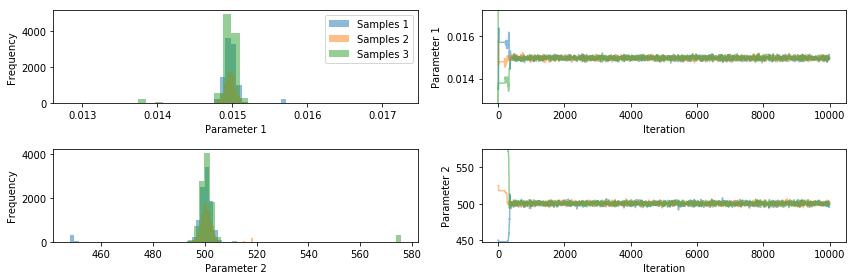

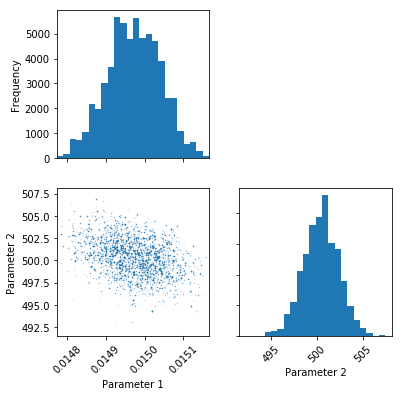

In [26]:
# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains_thin = chains[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_thin[0])

# Show graphs
plt.show()

R-hat:
[1.0012102591748129, 1.0004282391006527]


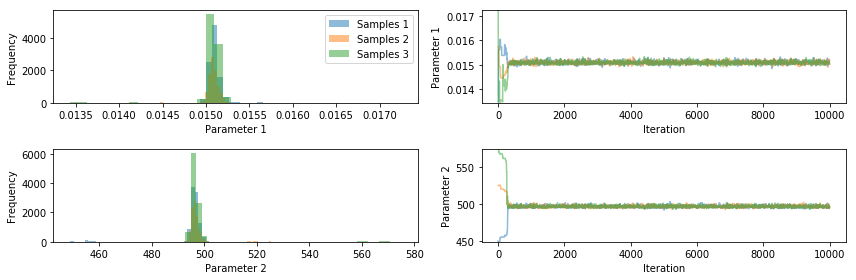

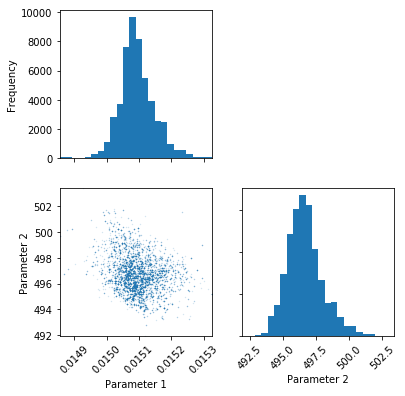

In [27]:
# Show traces and histograms
pints.plot.trace(chains_emu)

# Discard warm up
chains_emu_thin = chains_emu[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_emu_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_emu_thin[0])

# Show graphs
plt.show()

In [28]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

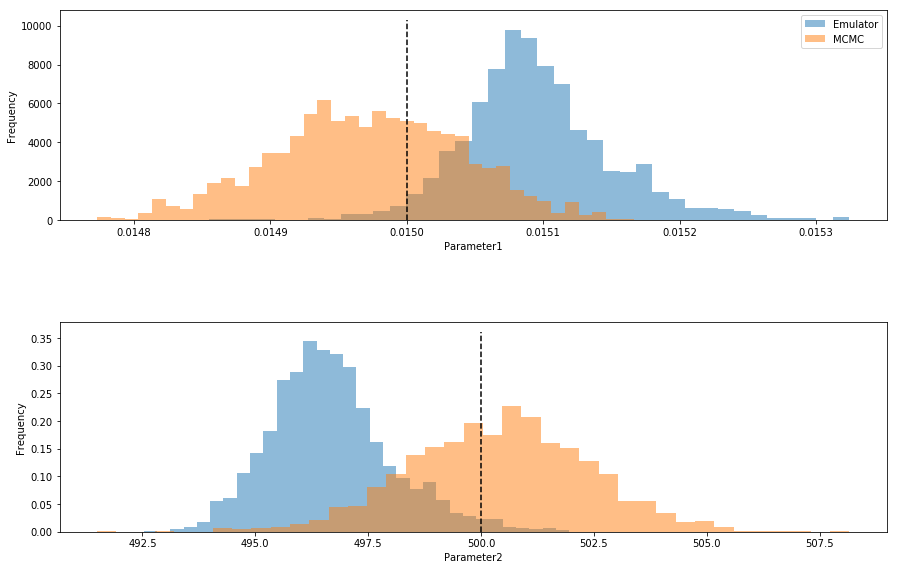

In [29]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

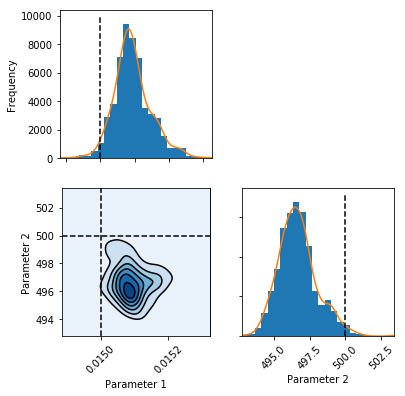

In [30]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

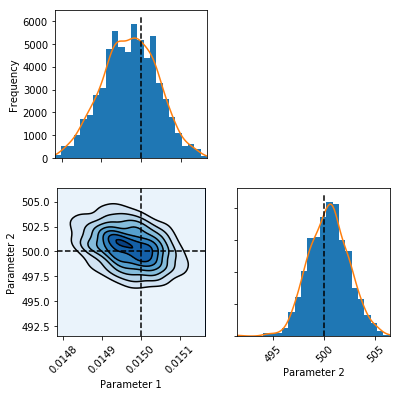

In [31]:
thinned_chain = chain[::10]
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

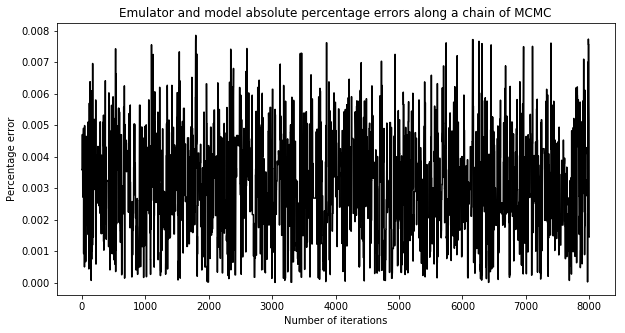

0.0031261369231024884

In [32]:
emu_likelihood = np.apply_along_axis(emu, 1, chain).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 8000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

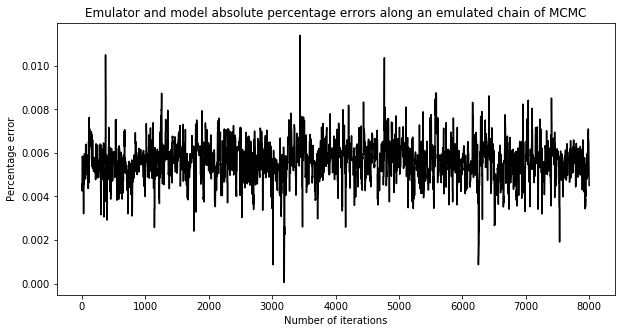

0.0056184584129521055

In [33]:
emu_likelihood = np.apply_along_axis(emu, 1, chain_emu).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 8000, len(chain_emu))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along an emulated chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

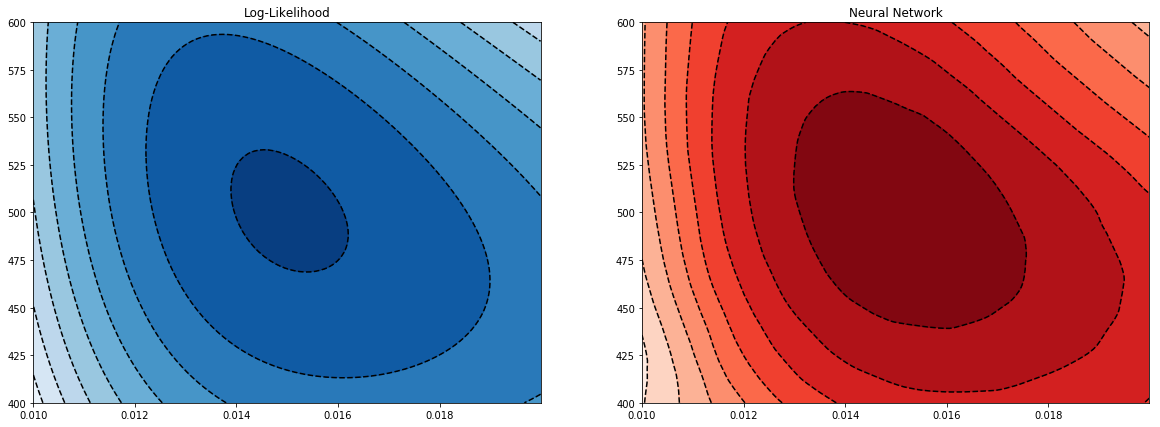

In [34]:
# Create grid of parameters
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

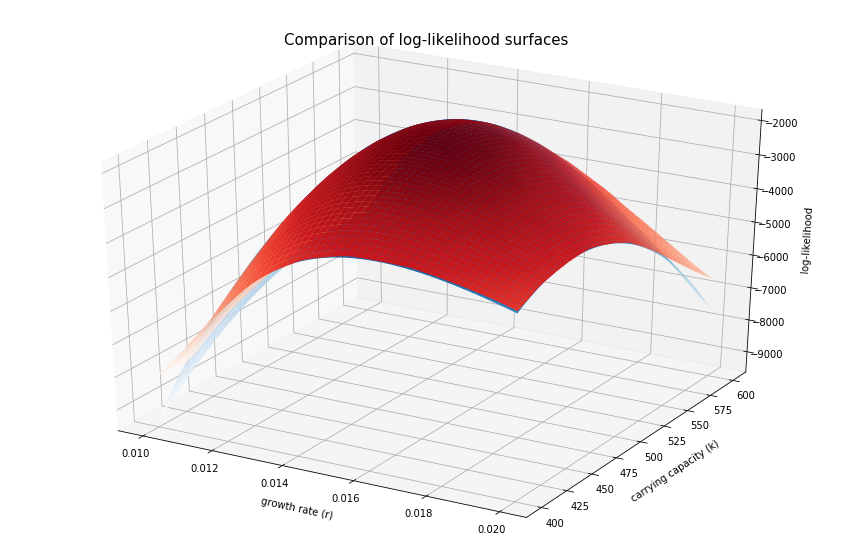

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

figsize=(20,10)
angle=(25, 300)
alpha=1.0
fontsize=10
labelpad=10

title = "Comparison of log-likelihood surfaces"
x_label = "growth rate (r)"
y_label = "carrying capacity (k)"
z_label = "log-likelihood"


fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, ll, cmap='Blues', edgecolor='none', alpha=alpha)
ax.plot_surface(xx, yy, np.array(ll_emu), cmap='Reds', edgecolor='none', alpha=alpha)
#ax.view_init(60, 35)
#ax.view_init(*angle)
#ax.set_title('surface')

plt.title(title, fontsize=fontsize*1.5)
ax.set_xlabel(x_label, fontsize=fontsize, labelpad=labelpad)
ax.set_ylabel(y_label, fontsize=fontsize, labelpad=labelpad)
ax.set_zlabel(z_label, fontsize=fontsize, labelpad=labelpad)
plt.show()

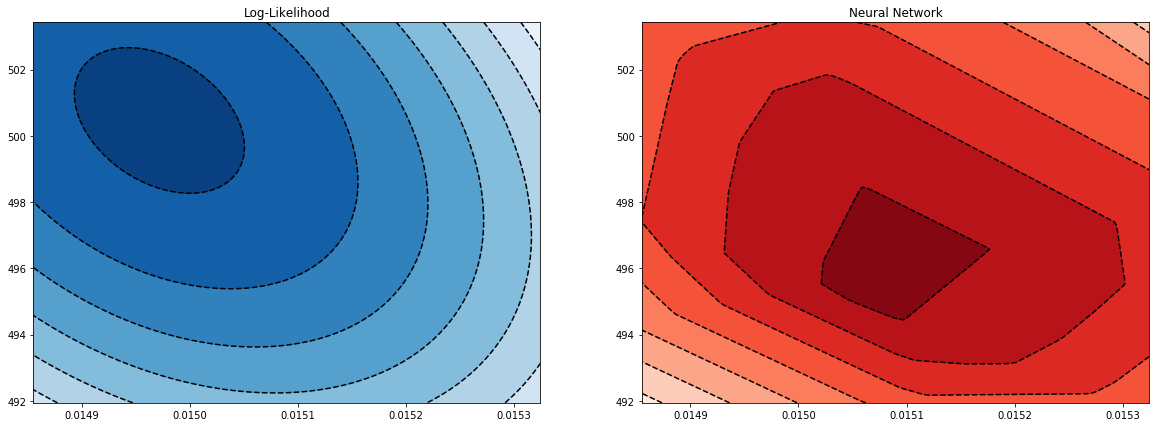

In [36]:
# Create grid of parameters
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

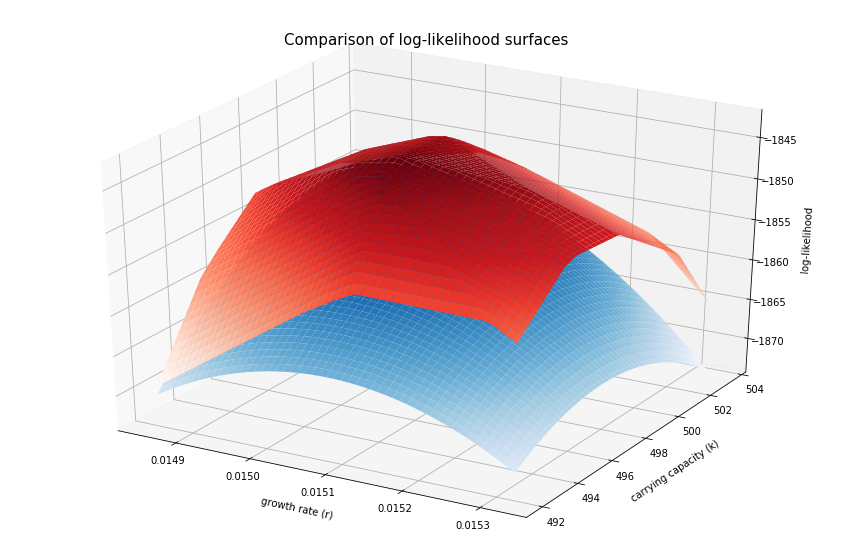

In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

figsize=(20,10)
angle=(25, 300)
alpha=1.0
fontsize=10
labelpad=10

title = "Comparison of log-likelihood surfaces"
x_label = "growth rate (r)"
y_label = "carrying capacity (k)"
z_label = "log-likelihood"


fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, ll, cmap='Blues', edgecolor='none', alpha=alpha)
ax.plot_surface(xx, yy, np.array(ll_emu), cmap='Reds', edgecolor='none', alpha=alpha)
#ax.view_init(60, 35)
#ax.view_init(*angle)
#ax.set_title('surface')

plt.title(title, fontsize=fontsize*1.5)
ax.set_xlabel(x_label, fontsize=fontsize, labelpad=labelpad)
ax.set_ylabel(y_label, fontsize=fontsize, labelpad=labelpad)
ax.set_zlabel(z_label, fontsize=fontsize, labelpad=labelpad)
plt.show()

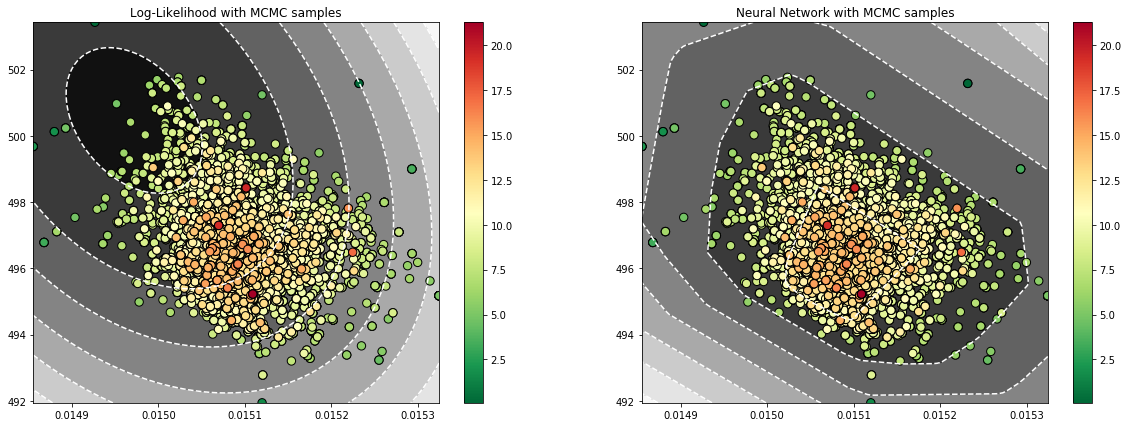

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood with MCMC samples')
ax2.title.set_text('Neural Network with MCMC samples')                                                                  

# Create grid of parameters
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

# Sort according to differences in log-likelihood
idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines of log-likelihood
ax1.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax1.set_xlim([xmin, xmax])                                                                           
ax1.set_ylim([ymin, ymax])
im1 = ax1.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

# Add contour lines of emulated likelihood
ax2.contourf(xx, yy, ll_emu, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='w')

# Plot chain_emu    
ax2.set_xlim([xmin, xmax])                                                                           
ax2.set_ylim([ymin, ymax])
im2 = ax2.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

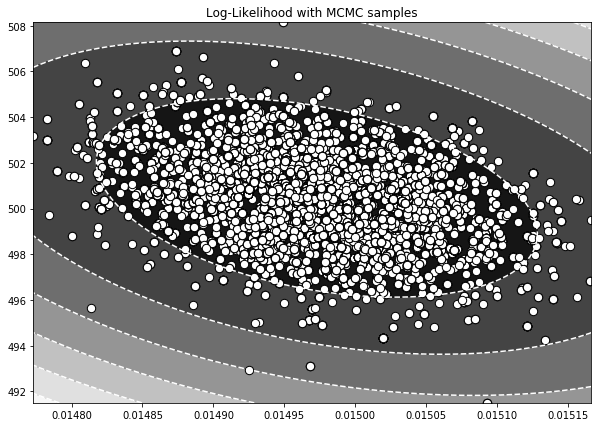

In [39]:
fig, ax = plt.subplots(figsize=(10,7))                   
ax.title.set_text('Log-Likelihood with MCMC samples')                                                                   

# Plot chain
x = [p[0] for p in chain]
y = [p[1] for p in chain]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)

# Add contour lines
ax.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax.set_xlim([xmin, xmax])                                                                           
ax.set_ylim([ymin, ymax])

ax.scatter(x, y, s=70, edgecolor='k', color='w')
plt.show()